# Reporte Proyecto WDM: Diseño de Función de Recompensas
### Integrantes: Carlos Cea - Felipe Garay - Martin Rojas                                               

A continuación, se encuentran todos los resultados de las simulaciones con los cuales trabajamos, cada uno en sus secciones respectivas si se desean ven de manera individual, si se busca ver algo mas conclusivo, al final se encuentran todos los graficos en conjunto para facilitar pa comparación de estos. Ademas se incluyen otros codigos que facilitaron el trabajo, como funciones auxiliares, libraries, y tambien las funciones de recompensa que  creamos para entregarle al agente.

#### Libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Funciones Auxiliares:

In [2]:
# Array utilizado para graficar en el eje x las iteraciones
x=[]
for i in range(1000):
    x.append(i*100)
# Funcion que muestra algunas de las stats de una funcion recompensa
def printStats(rewards, pb, name):
    print("Rewards Stats w/ ", name, " :")
    print("Avg = ", np.mean(rewards))
    print("Std = ", np.std(rewards))
    print("Min-Max Reward =", np.min(rewards[1:]), "-", np.max(rewards[1:]))
    print("Last Prob Bloqueo =", pb[-1])
    return 1
# Se le entrega iteraciones, array de rewards, array de probabilidades de bloqueos, nombre funcion de recompensa, nombre agente, nombre topo
def graph_Rewards_Bloqueo(iterations, rewards, pbs, fr, agent, topo):
    data = {'X': iterations[1:], 'Y1': rewards[1:], 'Y2':pbs[1:]}
    df = pd.DataFrame(data)

    sns.set(style="whitegrid")
    f, axs = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw=dict(width_ratios=[8, 8]))
    plt.suptitle('Funcion de Recompensa: '+ fr + ' - '+ agent+' - '+ topo)

    sns.lineplot(x="X", y="Y1", data= df, ax=axs[0])
    axs[0].set_title('Rewards v/s Iterations')
    axs[0].set_ylabel('Rewards')
    axs[0].set_xlabel('Iterations')

    sns.lineplot(x="X", y="Y2", data= df, ax=axs[1])
    axs[1].set_title('Prob. Bloqueo v/s Iterations')
    axs[1].set_ylabel('Prob.Bloqueo')
    axs[1].set_xlabel('Iterations')

    f.tight_layout()
    printStats(rewards, pbs, fr)
    plt.show()

### Funciones de recompensa consideradas en el trabajo:

#### Base Reward Function (incluida en DREAM-ON-GYM)

#### Band Select Reward Function

In [3]:
def rewardBandSelect(): 
    global episodeRewardAccum
    global episodeIteration
    global episodeRewardsArray
    global iteration

    iteration = iteration + 1
    if (iteration % episodeIteration) == 0:
        episodeRewardsArray.append(episodeRewardAccum)
        episodeRewardAccum = 0

    reward = 0
    connectionsNow = env.getSimulator().controller.connections

    value = env.getSimulator().lastConnectionIsAllocated()
    if (value.name == Controller.Status.Not_Allocated.name):
        reward -= 1.0
    elif connectionsNow[-1].bandSelected == "C" or connectionsNow[-1].bandSelected == "L" or connectionsNow[-1].bandSelected == "S":
        reward +=1.0
    elif connectionsNow[-1].bandSelected == "E":
        reward +=0.8

    episodeRewardAccum = episodeRewardAccum + reward
    return reward

#### Length Based Reward Function

In [4]:
def rewardLengthBased(): 
    global episodeRewardAccum
    global episodeIteration
    global episodeRewardsArray
    global iteration

    iteration = iteration + 1
    if (iteration % episodeIteration) == 0:
        episodeRewardsArray.append(episodeRewardAccum)
        episodeRewardAccum = 0
    
    connectionsNow = env.getSimulator().controller.connections
    controllerNow = env.getSimulator().controller

    value = env.getSimulator().lastConnectionIsAllocated()

    if (value.name == Controller.Status.Not_Allocated.name):
        value = -1
    else:

        src = connectionsNow[-1].links[0].src
        dst = connectionsNow[-1].links[-1].dst
        actualPath = connectionsNow[-1].links
        actualPathLength = 0
        for link in actualPath:
          actualPathLength += link.length
        # Possible paths
        paths = controllerNow.path[src][dst]
        PathsLength = []    
        for path in paths:
          linksCumLength = 0
          for link in path:
            linksCumLength += link.length
          PathsLength.append(linksCumLength)

        if (actualPathLength <= PathsLength[0]):
          value = 1
        elif (actualPathLength <= PathsLength[1] or actualPathLength <= PathsLength[2]):
          value = 0.9
        else:
          value = 0.8

    episodeRewardAccum = episodeRewardAccum + value
    return value

## Agente TRPO - Topologia EuroCore:

### 1) Funcion de Recompensa: Caso Base (DONE)

#### 1.1) Data: 

In [5]:
episodeRewardsArrayCB_TRPO_Euro=[93, 96, 90, 98, 80, 94, 90, 94, 86, 96, 92, 86, 86, 92, 86, 82, 94, 90, 92, 88, 88, 90, 88, 88, 86, 92, 92, 88, 78, 86, 86, 88, 94, 86, 86, 88, 96, 92, 90, 90, 94, 92, 94, 86, 88, 96, 90, 92, 94, 84, 94, 90, 82, 90, 96, 84, 88, 88, 98, 86, 94, 84, 88, 88, 86, 88, 86, 88, 92, 82, 88, 90, 88, 88, 84, 90, 86, 94, 94, 86, 90, 86, 90, 82, 84, 90, 90, 86, 90, 92, 90, 90, 86, 90, 92, 84, 82, 82, 86, 88, 100, 88, 90, 94, 92, 86, 78, 92, 86, 90, 90, 88, 92, 84, 92, 88, 90, 90, 82, 80, 76, 90, 94, 82, 94, 90, 86, 90, 84, 86, 84, 86, 84, 94, 92, 86, 90, 88, 86, 88, 84, 90, 86, 84, 92, 76, 90, 78, 90, 84, 92, 88, 90, 90, 86, 92, 92, 96, 90, 92, 88, 90, 90, 84, 86, 86, 92, 82, 90, 84, 90, 88, 92, 90, 90, 92, 92, 84, 90, 92, 84, 84, 94, 92, 84, 94, 90, 94, 98, 92, 92, 90, 84, 86, 94, 88, 86, 86, 90, 90, 90, 92, 88, 92, 94, 86, 88, 86, 92, 94, 88, 84, 92, 90, 94, 86, 88, 84, 88, 86, 86, 96, 82, 86, 90, 94, 92, 88, 92, 90, 92, 88, 88, 84, 82, 92, 86, 80, 92, 96, 96, 94, 88, 88, 86, 82, 88, 98, 88, 90, 90, 94, 78, 88, 88, 98, 98, 86, 90, 90, 88, 86, 90, 84, 76, 96, 86, 96, 90, 92, 92, 94, 94, 86, 86, 94, 88, 90, 90, 86, 90, 96, 92, 86, 94, 92, 86, 94, 94, 96, 92, 92, 92, 92, 76, 90, 92, 80, 88, 90, 84, 84, 96, 84, 88, 80, 88, 92, 88, 94, 86, 86, 94, 88, 94, 96, 90, 90, 88, 92, 92, 84, 96, 92, 92, 86, 92, 86, 78, 90, 84, 92, 94, 94, 80, 88, 86, 92, 96, 84, 94, 94, 88, 90, 80, 88, 88, 86, 92, 96, 94, 88, 90, 86, 90, 90, 86, 86, 88, 86, 92, 90, 82, 86, 96, 90, 90, 86, 86, 86, 90, 88, 88, 90, 84, 88, 88, 82, 90, 86, 88, 88, 94, 92, 90, 88, 96, 86, 84, 92, 72, 88, 90, 90, 96, 82, 96, 94, 90, 84, 88, 94, 90, 90, 90, 76, 88, 88, 86, 88, 88, 86, 90, 92, 88, 82, 94, 84, 94, 88, 82, 90, 92, 86, 84, 86, 92, 82, 82, 82, 90, 86, 86, 84, 94, 88, 84, 82, 88, 92, 92, 94, 88, 92, 90, 92, 96, 86, 90, 86, 92, 88, 84, 92, 92, 88, 82, 90, 94, 94, 90, 92, 92, 92, 88, 92, 92, 90, 94, 82, 86, 92, 86, 96, 86, 88, 84, 90, 90, 88, 86, 80, 94, 84, 94, 84, 74, 96, 84, 100, 86, 96, 92, 92, 82, 86, 88, 82, 90, 86, 90, 86, 92, 92, 82, 92, 86, 78, 88, 88, 94, 88, 90, 86, 86, 86, 84, 86, 90, 90, 86, 94, 92, 88, 88, 94, 88, 80, 88, 94, 92, 90, 90, 88, 82, 82, 84, 86, 90, 88, 88, 94, 94, 86, 92, 90, 94, 86, 96, 96, 88, 86, 92, 90, 94, 84, 90, 88, 88, 92, 90, 88, 94, 96, 86, 96, 82, 92, 92, 80, 88, 84, 82, 90, 92, 86, 94, 88, 94, 86, 86, 86, 94, 90, 92, 86, 86, 94, 96, 94, 96, 94, 90, 82, 92, 86, 90, 76, 94, 76, 96, 88, 88, 84, 86, 92, 88, 94, 90, 86, 94, 86, 90, 84, 94, 92, 82, 92, 86, 86, 90, 86, 94, 92, 90, 90, 86, 84, 88, 84, 92, 92, 90, 90, 94, 100, 86, 88, 88, 94, 90, 96, 92, 94, 90, 94, 92, 94, 100, 92, 96, 80, 88, 88, 88, 96, 86, 98, 92, 90, 86, 92, 90, 92, 86, 82, 88, 88, 92, 80, 82, 86, 90, 92, 86, 90, 90, 92, 90, 88, 88, 90, 92, 94, 88, 96, 86, 84, 86, 84, 90, 84, 94, 86, 88, 92, 92, 86, 92, 94, 94, 92, 92, 94, 86, 92, 84, 86, 94, 92, 92, 88, 86, 88, 86, 92, 94, 90, 92, 88, 82, 90, 90, 84, 94, 92, 92, 94, 92, 90, 86, 82, 86, 88, 82, 92, 94, 84, 88, 94, 92, 94, 86, 92, 90, 84, 94, 94, 88, 86, 88, 94, 94, 92, 84, 88, 92, 96, 88, 92, 90, 92, 88, 88, 84, 86, 82, 92, 88, 90, 94, 92, 88, 82, 88, 90, 92, 92, 90, 92, 80, 96, 94, 88, 90, 98, 96, 92, 92, 90, 86, 84, 90, 82, 92, 92, 92, 88, 82, 86, 88, 88, 86, 92, 94, 86, 88, 84, 88, 98, 94, 98, 92, 90, 92, 82, 84, 78, 84, 94, 88, 96, 90, 92, 90, 88, 90, 84, 88, 88, 88, 92, 90, 94, 84, 90, 92, 94, 80, 82, 84, 90, 86, 96, 92, 96, 88, 94, 94, 90, 84, 94, 82, 90, 82, 94, 84, 90, 92, 86, 92, 84, 90, 88, 88, 82, 88, 88, 86, 86, 94, 90, 92, 82, 92, 92, 96, 84, 88, 86, 86, 90, 90, 88, 90, 92, 90, 88, 86, 88, 88, 98, 92, 84, 96, 88, 90, 86, 92, 94, 86, 88, 96, 86, 92, 88, 86, 88, 78, 96, 88, 84, 86, 92, 88, 82, 86, 94, 78, 82, 88, 90, 88, 88, 90, 88, 92, 88, 88, 96, 96, 86, 94, 88, 92, 94, 88, 84, 94, 84, 90, 90, 70, 90, 86, 88, 80, 96, 86, 92, 86, 92, 92, 94, 82, 82, 84, 90, 94, 90, 92, 88, 90, 90, 80, 82, 90, 94, 94, 88, 90, 86, 96, 88, 90, 82, 88, 94, 92, 96, 92, 90, 92, 82, 96, 90, 82, 86, 90, 92, 88, 86, 92, 90, 88, 88, 92, 98, 92, 94, 92, 90, 86, 96, 88, 82, 92, 88, 86, 90, 96, 88, 94, 86, 84, 88, 92, 96, 92, 84, 92, 92, 88, 86, 92, 90, 86, 88, 96, 88, 86, 86, 88, 94, 90, 90, 94, 92, 96, 88, 86, 86, 92, 90, 88, 90, 88, 92, 92, 82, 88, 92, 88, 88, 86, 90, 98, 90, 98, 94, 90, 88, 92, 94, 98, 92, 86, 84, 88, 90, 90, 90, 88, 84, 92, 94, 92, 92, 92, 82, 96, 84, 88, 90, 96, 82, 86, 82, 78, 88, 90, 94, 92, 90, 86, 96, 94, 90, 88, 86, 90, 90, 84, 90, 80, 84, 86, 90, 86, 84, 96, 84, 94, 92, 94, 84, 90, 86, 86, 84, 84, 80, 88, 92, 94, 88, 92, 94, 88, 86, 92, 82, 80, 96, 80, 92, 88, 92, 90, 94, 94, 88, 90, 96, 92, 94, 84, 86, 86, 84, 90, 86, 84, 94, 84, 86, 88, 82, 86, 84, 90, 94, 86, 90, 94, 82, 94, 86, 80, 84, 88, 88, 88, 86, 92, 90, 86, 82, 78, 96, 86, 96, 88, 90, 90, 92, 88, 86, 90, 96, 86, 96, 86, 84, 84, 82, 86, 86, 88, 88, 96, 94, 92, 88, 90, 92, 86, 94, 86, 90, 86, 94, 94, 86, 86, 80, 92, 90, 84, 90, 94, 80, 70, 82, 82, 94, 90, 90, 78, 90, 84, 88, 86, 88, 88, 94, 84, 96, 80, 86, 88, 92, 84, 86, 86, 94, 96, 92, 82, 96, 92, 88, 88, 84, 90, 88, 92, 84, 90, 90, 86, 94, 90, 78, 92, 88, 86, 88, 88, 92, 84, 84, 82, 86, 96, 84, 80, 86, 84, 84, 84, 94, 88, 94, 88, 92, 78, 82, 96, 96, 84, 92, 90, 94, 92, 84, 86, 90, 92, 92, 90, 96, 88, 86, 80, 88, 92, 96, 84, 90, 84, 88, 90, 94, 96, 90, 92, 82, 88, 84, 88, 84, 94, 86, 94, 84, 86, 82, 86, 88, 88, 92, 96, 84, 94, 88, 82, 94, 92, 84, 92, 90, 90, 96, 88, 88, 86, 84, 90, 88, 86, 88, 94, 88, 78, 88, 92, 88, 90, 86, 88, 92, 92, 78, 86, 88, 90, 82, 90, 90, 92, 82, 98, 84, 86, 90, 92, 84, 90, 88, 90, 94, 92, 94, 94, 92, 88, 94, 94, 92, 80, 86, 96, 80, 86, 90, 82, 88, 90, 90, 94, 92, 94, 90, 86, 86, 80, 94, 80, 92, 90, 86, 88, 96, 88, 90, 86, 88, 86, 92, 92, 92, 94, 82, 92, 94, 94, 84, 96, 86, 86, 88, 84, 82, 90, 88, 88, 86, 90, 80, 80, 86, 94, 92, 94, 96, 82, 90, 90, 90, 90, 94, 84, 84, 96, 92, 92, 90, 88, 98, 90, 92, 94, 92, 94, 86, 96, 92, 80, 92, 92, 88, 88, 88, 88, 92, 94, 90, 86, 90, 86, 90, 90, 78, 80, 92, 84, 90, 86, 94, 92, 90, 90, 86, 88, 86, 94, 94, 90, 96, 92, 82, 90, 90, 92, 94, 94, 92, 92, 90, 86, 88, 76, 76, 80, 90, 90, 84, 90, 82, 82, 86, 84, 88, 86, 90, 86, 84, 86, 92, 96, 86, 88, 96, 94, 92, 88, 86, 80, 86, 86, 90, 96, 92, 96, 86, 80, 84, 86, 98, 86, 88, 88, 86, 90, 86, 86, 88, 90, 88, 96, 88, 94, 84, 94, 94, 86, 78, 78, 80, 86, 90, 92, 96, 88, 92, 100, 92, 90, 84, 92, 90, 80, 96, 80, 78, 88, 92, 94, 88, 94, 88, 90, 82, 88, 90, 88, 96, 90, 98, 94, 88, 88, 90, 92, 88, 94, 88, 90, 90, 88, 94, 90, 88, 92, 86, 94, 92, 88, 90, 98, 90, 88, 90, 92, 94, 88, 84, 90, 84, 82, 96, 90, 92, 92, 90, 98, 94, 84, 86, 82, 90, 90, 86, 92, 86, 90, 88, 84, 76, 82, 92, 92, 94, 88, 94, 88, 82, 92, 88, 88, 90, 90, 88, 86, 82, 92, 92, 88, 90, 88, 80, 88, 90, 94, 92, 86, 90, 84, 82, 94, 100, 88, 94, 86, 90, 86, 94, 92, 88, 86, 94, 88, 92, 86, 90, 90, 92, 86, 88, 82, 92, 94, 90, 92, 90, 92, 94, 94, 86, 92, 88, 94, 94, 92, 90, 98, 92, 96, 86, 86, 92, 82, 88, 88, 96, 92, 88, 94, 92, 92, 84, 88, 90, 90, 92, 88, 84, 90, 86, 92, 88, 98, 92, 88, 82, 86, 82, 88, 90, 84, 92, 92, 92, 92, 92, 90, 80, 80, 88, 88, 84, 92, 88, 88, 84, 88, 88, 88, 92, 90, 94, 84, 98, 92, 92, 86, 88, 94, 84, 86, 90, 94, 88, 96, 94, 90, 96, 90, 86, 90, 90, 86, 88, 78, 88, 96, 84, 94, 92, 80, 92, 86, 88, 92, 86, 86, 82, 88, 90, 82, 86, 86, 90, 84, 92, 100, 94, 86, 94, 92, 90, 80, 80, 94, 84, 92, 90, 90, 82, 80, 92, 86, 94, 86, 88, 90, 88, 90, 92, 98, 92, 88, 90, 84, 92, 90]
rewardsArrayCB_TRPO_Euro=[0, 90, 94, 88, 90, 92, 76, 94, 86, 92, 82, 94, 90, 86, 90, 86, 90, 88, 82, 86, 88, 88, 86, 88, 96, 88, 90, 84, 92, 92, 94, 86, 86, 86, 88, 88, 92, 84, 94, 94, 86, 88, 84, 88, 94, 98, 88, 88, 96, 88, 86, 88, 92, 92, 84, 92, 92, 90, 88, 92, 84, 90, 80, 96, 80, 88, 88, 88, 86, 86, 90, 94, 74, 80, 86, 94, 88, 92, 90, 88, 90, 86, 90, 96, 96, 86, 90, 94, 88, 96, 86, 86, 92, 86, 88, 86, 78, 84, 88, 82, 90, 92, 86, 92, 84, 94, 96, 90, 86, 78, 86, 92, 92, 86, 96, 86, 90, 86, 86, 82, 90, 96, 92, 86, 92, 86, 90, 94, 88, 84, 88, 96, 92, 96, 90, 90, 90, 84, 94, 92, 80, 86, 90, 94, 84, 92, 88, 92, 86, 90, 94, 98, 90, 96, 90, 92, 86, 96, 82, 86, 86, 94, 86, 90, 94, 90, 94, 84, 84, 92, 92, 96, 86, 88, 92, 92, 84, 90, 92, 88, 84, 94, 92, 90, 84, 86, 92, 94, 86, 94, 92, 94, 92, 90, 84, 90, 88, 94, 88, 90, 88, 92, 84, 84, 92, 90, 90, 86, 84, 96, 98, 90, 98, 92, 84, 94, 94, 94, 96, 92, 86, 86, 86, 88, 92, 90, 86, 88, 92, 94, 90, 90, 92, 86, 92, 84, 92, 90, 92, 84, 84, 80, 82, 88, 92, 92, 90, 92, 86, 96, 96, 86, 88, 86, 92, 92, 82, 82, 86, 88, 86, 84, 84, 92, 92, 86, 94, 92, 90, 88, 86, 88, 90, 84, 72, 90, 90, 88, 98, 84, 96, 92, 88, 86, 88, 86, 80, 96, 80, 90, 92, 88, 92, 94, 96, 86, 90, 96, 94, 88, 88, 88, 82, 86, 88, 86, 86, 92, 88, 80, 94, 82, 84, 80, 96, 94, 86, 88, 92, 86, 94, 86, 78, 82, 92, 84, 88, 88, 92, 88, 86, 82, 82, 90, 92, 94, 88, 92, 86, 96, 84, 88, 92, 94, 88, 94, 86, 82, 84, 82, 86, 86, 88, 90, 98, 94, 88, 90, 92, 90, 88, 92, 86, 90, 82, 96, 94, 88, 84, 82, 92, 92, 82, 92, 90, 80, 74, 80, 84, 90, 92, 84, 84, 90, 82, 86, 88, 88, 88, 96, 84, 92, 82, 84, 94, 86, 86, 88, 88, 94, 94, 92, 80, 100, 90, 86, 86, 84, 94, 88, 92, 84, 90, 86, 90, 92, 92, 80, 90, 88, 82, 92, 90, 88, 82, 88, 82, 88, 92, 82, 82, 86, 84, 84, 84, 92, 94, 92, 88, 88, 80, 86, 96, 90, 88, 94, 88, 96, 88, 86, 86, 88, 94, 92, 92, 96, 86, 86, 76, 90, 96, 92, 84, 94, 80, 90, 92, 90, 100, 88, 92, 82, 86, 88, 86, 86, 92, 86, 90, 90, 84, 80, 84, 92, 88, 94, 94, 82, 90, 88, 88, 94, 90, 84, 92, 92, 92, 90, 92, 84, 90, 82, 90, 92, 80, 92, 94, 86, 80, 86, 92, 90, 90, 84, 90, 88, 88, 86, 86, 90, 84, 86, 90, 88, 92, 86, 92, 86, 90, 88, 88, 88, 92, 86, 92, 94, 88, 96, 94, 90, 92, 94, 94, 90, 76, 92, 94, 80, 84, 94, 78, 92, 86, 90, 98, 92, 88, 94, 84, 84, 86, 86, 86, 90, 94, 84, 88, 98, 88, 82, 90, 90, 86, 90, 94, 94, 86, 86, 94, 94, 94, 86, 94, 84, 84, 90, 82, 86, 90, 86, 90, 82, 94, 82, 74, 88, 92, 96, 94, 94, 82, 94, 88, 88, 90, 92, 82, 92, 96, 88, 94, 86, 94, 96, 88, 96, 92, 94, 92, 88, 96, 84, 88, 86, 96, 84, 90, 90, 88, 92, 96, 88, 88, 88, 88, 88, 88, 74, 86, 90, 86, 86, 92, 92, 90, 90, 92, 80, 90, 90, 92, 98, 88, 96, 92, 82, 90, 92, 90, 96, 94, 88, 96, 86, 84, 84, 80, 74, 86, 90, 88, 88, 88, 80, 80, 90, 84, 84, 92, 86, 88, 86, 82, 96, 92, 90, 88, 96, 94, 86, 90, 88, 78, 88, 88, 88, 96, 92, 92, 90, 74, 86, 92, 94, 86, 92, 84, 88, 86, 92, 84, 86, 90, 88, 96, 90, 90, 88, 96, 90, 86, 80, 72, 86, 88, 88, 94, 94, 90, 92, 96, 96, 86, 88, 88, 88, 86, 92, 80, 78, 92, 90, 92, 92, 90, 90, 92, 76, 92, 90, 90, 94, 92, 98, 88, 92, 88, 90, 92, 86, 94, 92, 90, 84, 90, 98, 84, 92, 92, 86, 96, 88, 90, 92, 98, 88, 88, 90, 94, 88, 92, 86, 88, 82, 82, 94, 96, 88, 94, 92, 96, 90, 88, 86, 80, 90, 92, 84, 90, 92, 88, 88, 80, 78, 86, 88, 96, 90, 92, 92, 84, 86, 92, 86, 90, 88, 92, 88, 82, 84, 94, 92, 88, 90, 86, 82, 86, 94, 92, 94, 86, 84, 86, 84, 96, 98, 90, 90, 86, 90, 88, 92, 96, 82, 92, 92, 88, 88, 92, 90, 84, 92, 88, 90, 82, 94, 92, 90, 94, 86, 94, 94, 92, 90, 88, 88, 98, 92, 92, 92, 94, 96, 92, 88, 88, 88, 82, 92, 86, 98, 90, 90, 94, 90, 90, 86, 88, 86, 94, 90, 88, 86, 88, 90, 88, 92, 96, 90, 90, 80, 84, 86, 88, 90, 84, 94, 86, 96, 92, 92, 88, 76, 82, 90, 88, 88, 88, 90, 86, 86, 90, 88, 86, 92, 90, 94, 84, 100, 90, 92, 88, 86, 92, 80, 88, 96, 90, 92, 94, 90, 96, 94, 90, 88, 86, 92, 86, 86, 76, 94, 96, 82, 96, 84, 88, 86, 88, 92, 92, 82, 86, 82, 92, 84, 84, 88, 88, 88, 84, 94, 98, 94, 88, 94, 90, 84, 82, 84, 92, 88, 90, 86, 90, 80, 86, 90, 90, 94, 84, 88, 92, 86, 88, 96, 94, 92, 86, 92, 88, 92]
probBloqueoArrayCB_TRPO_Euro=[0.0, 0.04950495049504951, 0.03980099502487562, 0.046511627906976744, 0.04738154613466334, 0.04590818363273453, 0.05823627287853577, 0.05420827389443652, 0.056179775280898875, 0.05438401775804662, 0.057942057942057944, 0.055404178019981834, 0.054954204829308906, 0.056110684089162186, 0.055674518201284794, 0.056628914057295136, 0.056214865708931916, 0.0564373897707231, 0.05830094392004442, 0.058916359810625984, 0.05897051474262868, 0.059019514516896715, 0.0595184007269423, 0.0595393307257714, 0.05789254477301124, 0.05797680927628948, 0.05767012687427912, 0.058496853017400964, 0.057836486968939664, 0.05722164770768701, 0.05631456181272909, 0.05675588519832312, 0.05716963448922212, 0.05755831566192063, 0.0576301087915319, 0.05769780062839189, 0.05720633157456262, 0.05782221021345582, 0.0570902394106814, 0.05639579594975647, 0.056735816045988506, 0.056815410875396245, 0.05736729350154725, 0.057428504998837476, 0.05680527152919791, 0.05576538546989558, 0.05585742229950011, 0.055945543501382686, 0.055196833992918144, 0.055294837788206486, 0.05558888222355529, 0.05567535777298569, 0.055373966544895216, 0.05508394642520279, 0.05554526939455656, 0.055262679512815854, 0.054990180324941976, 0.05490264865813015, 0.054990518876055855, 0.05473648534146755, 0.05515747375437427, 0.05507293886248156, 0.05579745202386712, 0.05522932867798762, 0.05592876113107327, 0.05599138594062452, 0.05605211331616422, 0.05611102820474556, 0.05631524775768269, 0.05651354876104912, 0.05642051135552064, 0.0560484438811435, 0.05707540619358423, 0.057663333789891795, 0.05783002296986894, 0.05745900546593787, 0.05749243520589396, 0.057265290222049084, 0.057172157415715935, 0.057207948360966966, 0.05711786026746657, 0.057276879397605236, 0.05718814778685526, 0.05674015178894109, 0.05630282109272706, 0.0564639454181861, 0.056388792000930124, 0.05608550741294104, 0.056129985228951254, 0.055724075946522865, 0.05588267970225531, 0.05603779804417097, 0.055863493098576245, 0.056015482206214384, 0.05605786618444846, 0.05620461004104831, 0.05676492032079992, 0.057004432532728584, 0.05703499642893582, 0.05736794263205737, 0.05729427057294271, 0.057123057123057125, 0.05724928928536418, 0.05708183671488205, 0.05730218248245361, 0.05704218645843253, 0.05669276483350627, 0.05663022147462854, 0.05675400425886492, 0.05724245482065866, 0.05735842196163985, 0.05720205386902081, 0.05704847781448085, 0.05716308291301655, 0.05683711955091659, 0.056951569428745324, 0.056891647271786916, 0.05700367489958123, 0.05711380391492246, 0.05739013528274935, 0.05732855595367053, 0.057020080985042555, 0.0568805835587247, 0.05698723681001545, 0.056850254011773245, 0.05695544356451484, 0.05690024601222125, 0.05668844972836785, 0.056714319193812986, 0.05689481435547632, 0.056918698561649106, 0.05663689794672162, 0.05651087038860692, 0.05623637320502218, 0.05618983657935975, 0.0561439893341234, 0.056098816263510036, 0.05627326472520254, 0.05608289254401855, 0.05596719660456082, 0.05628169416470252, 0.056378980214169205, 0.05633406098162101, 0.056149919586042936, 0.05631553364349698, 0.056203020481346115, 0.05622902540921855, 0.056118631385620024, 0.056212418079859466, 0.05617072679685927, 0.05599626691553897, 0.055691676047943846, 0.055654233274126705, 0.055421214299718975, 0.05538601389520161, 0.05528675569318108, 0.055381065316325875, 0.05515572256544169, 0.05537624200999937, 0.0554682095465694, 0.05555902756077745, 0.05540028569654059, 0.05549040182704771, 0.05545672044659837, 0.05530150600573136, 0.05526937761347797, 0.05511716161677008, 0.05526615172744147, 0.05541336825188977, 0.05532217028578191, 0.055232045173813304, 0.055026021870066076, 0.055113074821231324, 0.055141321310906884, 0.05505430722372277, 0.05496828752642706, 0.05511050508493836, 0.05508163380599966, 0.05499691028593899, 0.05502485894642757, 0.05516360202210988, 0.05502458427711176, 0.05494203615185979, 0.05491503196546637, 0.0550513559045704, 0.05513215501864764, 0.05505080372023009, 0.05491684936634405, 0.05499707462369023, 0.054864821967091686, 0.05478659017946424, 0.05465682425003927, 0.054580490599447945, 0.054556758717164915, 0.054687902685428585, 0.054663863391620944, 0.05469108718942911, 0.05456575808334602, 0.054593202363516995, 0.05457012210441686, 0.054597270136493174, 0.054524650514899756, 0.0546507598633731, 0.05477562681641299, 0.05470320082348904, 0.05468025949953661, 0.054657540896073005, 0.05473165547558089, 0.054853132060958605, 0.054686378642170234, 0.05447359649540498, 0.05445239562106061, 0.05424272439979246, 0.054175860288249375, 0.05429652819961684, 0.05418352634761174, 0.05407157076061293, 0.05396064697479379, 0.05380487133617724, 0.053741838272225013, 0.05381573564837962, 0.053888964300257906, 0.05396153326426738, 0.053988610376216314, 0.053926164010535245, 0.053908715168214744, 0.05397991239325694, 0.05400643143473856, 0.053945002412174904, 0.053840443648748966, 0.05382374679361767, 0.05380719449374486, 0.05374768328951338, 0.05381743272820909, 0.053758386393743855, 0.0538700480830603, 0.05381127918308546, 0.0537951985148306, 0.05373723793117936, 0.053847119367390485, 0.0539560851631182, 0.054147130824447116, 0.05429527705466716, 0.05431875231471956, 0.054260071308552926, 0.05420186931145667, 0.05418478923620991, 0.05412736326464516, 0.05419136325148179, 0.05405405405405406, 0.05391784328626855, 0.053981913071192385, 0.054005793420895995, 0.05406900913007391, 0.05401362151096414, 0.053958668287518136, 0.05409944924026405, 0.054239134664020854, 0.0543002209216697, 0.05432222694104475, 0.05438252374908657, 0.05448067123864986, 0.05457806953933056, 0.054522641724649254, 0.05446763380174993, 0.054526244292668204, 0.05443404383293861, 0.054379985768323286, 0.05436364314764375, 0.05438459536820193, 0.05444242805822007, 0.05446293494704992, 0.05444652770118746, 0.054540126735284425, 0.05485201270026641, 0.054834369659285113, 0.054816854461794864, 0.05483556550305043, 0.05467429229164419, 0.05476506218415111, 0.05464090568193993, 0.054588804668872996, 0.054607992624375025, 0.05466237942122187, 0.05468117319812683, 0.05473492158169889, 0.054893185552952695, 0.0547716107452702, 0.05492864831082254, 0.054911594754506764, 0.05486017723526775, 0.05487783924951033, 0.054826889490085955, 0.054742158970683595, 0.054623992381211524, 0.05467611267414664, 0.054660315529880744, 0.05454361805999798, 0.05446125968927217, 0.054479783284839975, 0.05449818339388687, 0.05451646124713465, 0.05463395251812854, 0.05468466387247946, 0.05470214795565935, 0.05475230320317367, 0.05480213064932519, 0.054753916810527346, 0.054770948995162494, 0.05491731659169606, 0.05483694074384697, 0.05495000160766535, 0.055030287490785555, 0.055173956103638865, 0.055061940702525396, 0.05498238151169804, 0.05502990411695832, 0.055045582158291535, 0.05499827049463853, 0.05504529638569324, 0.054967032280241246, 0.05501386249649544, 0.05518462159560262, 0.055292405807869725, 0.055245208481219714, 0.05532137472693148, 0.05533572589797859, 0.055349989296963394, 0.05530319197585439, 0.055317467554177685, 0.055361958728523376, 0.05546660221745567, 0.055570615342911356, 0.05555388727065253, 0.055507320140115564, 0.05543118115877138, 0.055444778429213415, 0.05539894958606569, 0.05544214668205083, 0.05533760066074747, 0.05541013499602953, 0.055423594615993665, 0.055378497704745476, 0.055304510072592634, 0.05531815935583268, 0.05524477551375322, 0.055287419438744545, 0.05538745281115818, 0.055458176489181346, 0.05555714735967451, 0.05559841147395789, 0.05563944047178143, 0.05565182807306611, 0.05563581768221863, 0.055506906584559756, 0.05543505816737557, 0.05544788067750906, 0.05543262093498782, 0.05538951425937823, 0.055374502103005485, 0.05538735035137913, 0.05534472729287277, 0.05538521035330516, 0.05537037547175009, 0.05546550918930799, 0.05536834607271034, 0.055299035545476896, 0.05531184436391379, 0.0553789299203826, 0.05547275141595079, 0.055430934299073, 0.055389342605320614, 0.05548237950592726, 0.0554408728988499, 0.0554263254993182, 0.05554518546172102, 0.05574319831919364, 0.05586058725232752, 0.055924446443215786, 0.05590881507084246, 0.05586695086971395, 0.055930290543555285, 0.05599329860474857, 0.05597765071408057, 0.056066248274784514, 0.05610243889769097, 0.05611253594466464, 0.05612258081186532, 0.05613257390273447, 0.05603969049638827, 0.056101125612163794, 0.056059947315925424, 0.05614652687431443, 0.0562072211903005, 0.05614070708865257, 0.05617579301789828, 0.05621070174995581, 0.05622024634140198, 0.05622974297128213, 0.05616400591463873, 0.05609859753506162, 0.056058452407670635, 0.05616775702096963, 0.05602838639239721, 0.056013465013242246, 0.056047998814844076, 0.056082362503386614, 0.05614112675364242, 0.05607705693487905, 0.05608664824820909, 0.056047413477720055, 0.056105690859103184, 0.05609087158078688, 0.05612454904239607, 0.05610975580299993, 0.05607093804968555, 0.05603230691569914, 0.05613774250017985, 0.05612305925695558, 0.05613231187799814, 0.05621294731077831, 0.05617443766181326, 0.05615980663965309, 0.056168884896338145, 0.0562486733803448, 0.05625749982353356, 0.05633670571113354, 0.056345284653755184, 0.05630709562860681, 0.05638563203654926, 0.0564638031673682, 0.0564952089278671, 0.05654961690701604, 0.05660377358490566, 0.056657680698601415, 0.056619388060044594, 0.056558335817985826, 0.056520445756390016, 0.0565283897627908, 0.056536297578642855, 0.056635076475534646, 0.05666538173737557, 0.056582430261758784, 0.05656757183810749, 0.056575302358054996, 0.056515583919462486, 0.05652339633640501, 0.05644169034249793, 0.05644963282069597, 0.056479811140063695, 0.05650985533654808, 0.056517593844925836, 0.05645892789982523, 0.05642259552769255, 0.0563864232065373, 0.05630645480319114, 0.056336483849038395, 0.05636638147961751, 0.05650531647780616, 0.0564911439837912, 0.056411817134410125, 0.05637621743563046, 0.056427350057358064, 0.05637027278028552, 0.05646430033835478, 0.05645039891615234, 0.0564150983884466, 0.05640136185520653, 0.056280848699814104, 0.056288778490863736, 0.05625412225271803, 0.056325768030402755, 0.05635473824707104, 0.05636244476860954, 0.05639121537520306, 0.05641986484495063, 0.05638537005525094, 0.05641391165803652, 0.056400493713520634, 0.056387131792655684, 0.056436324243244934, 0.056526891332820524, 0.056575589718055645, 0.056541272437423656, 0.056548418421107, 0.056493680542669227, 0.05643916791835559, 0.05650807991622349, 0.05649474396016475, 0.05650191202633893, 0.05650905083569723, 0.05645506201503024, 0.0564419422369464, 0.056489726374718566, 0.05645634703750936, 0.05642310256358457, 0.0563899921372553, 0.05637713526890807, 0.05634425011545953, 0.056391655477846137, 0.056378872422551546, 0.05644597912217321, 0.05643313878209597, 0.05640046917556311, 0.05648697446479237, 0.056454327637076494, 0.05640204739036778, 0.05642886728072424, 0.0565146355386705, 0.05654112885797921, 0.05650869590792337, 0.05649595898319015, 0.05648327181109744, 0.05652911249293386, 0.05651641018657225, 0.056523174307295004, 0.05652991221100366, 0.0565559660354732, 0.0565819192679678, 0.056569237586944376, 0.05661429587892541, 0.05663998771616668, 0.05662726767686443, 0.0566337163725359, 0.05660197324478541, 0.05662749280966077, 0.05659588220756259, 0.056621316483558184, 0.056608776348932785, 0.056615186858471486, 0.05662157317786457, 0.05662793544377695, 0.056596680513524185, 0.0566218269826082, 0.05659070054867887, 0.056540999233659184, 0.056547452472901626, 0.05647939516954992, 0.05643017787773461, 0.05641824826997644, 0.056387844669543156, 0.05633906951812351, 0.05629047434549178, 0.05627888989153054, 0.056396022131946104, 0.05636593823966533, 0.056317649859892675, 0.05639750644412351, 0.0564405759018996, 0.056392415438698745, 0.056489882002145414, 0.05645995535471226, 0.05648448397673955, 0.05647275817797146, 0.05638887384704247, 0.05635934487666889, 0.05636589269977159, 0.05631855801511643, 0.05636099711474705, 0.05640328437773922, 0.056427563793503686, 0.056451756653179086, 0.05647586341880038, 0.05646436120139962, 0.05641743940710271, 0.05645917771366878, 0.05646543347290684, 0.05638348530008289, 0.0563898522913329, 0.056448920054129104, 0.0564376063577832, 0.05642633228840126, 0.05645006206185207, 0.056438805605486815, 0.0563927457709796, 0.05634684614180623, 0.056370549122411066, 0.05639416994506161, 0.05634850608120967, 0.056302999948187424, 0.05625765073015983, 0.05628130324779264, 0.05623614714523805, 0.056276907771736336, 0.056317528809438196, 0.056306729799490605, 0.05636422586645279, 0.056387455068908535, 0.05637659223482594, 0.05639972156669666, 0.05638887476483449, 0.05644574541885924, 0.05640107430617726, 0.05645773258461072, 0.05658153903132944, 0.05658728424732357, 0.05655945370044127, 0.05649821611028291, 0.05645390545308607, 0.05640974274219128, 0.05646572557124048, 0.05642169015490591, 0.056427634092456935, 0.05643355831578249, 0.05642290690551481, 0.056395762053519774, 0.056451213676341976, 0.05642411162913296, 0.0563642045361096, 0.05637017454557396, 0.056326945459910495, 0.05634932325166528, 0.05630626950540024, 0.05624704327824995, 0.056253155486067005, 0.05619420822425652, 0.05616791935195857, 0.0561255085006726, 0.05609941586705717, 0.0561057171935833, 0.05604748310511121, 0.056086053364680116, 0.05609234578222215, 0.05611466910643489, 0.05605679396163523, 0.056095102478360345, 0.05608536604846568, 0.056075660675268334, 0.0560819095237337, 0.05605634250647844, 0.055999111125220234, 0.05600545157762951, 0.05601177196563346, 0.05601807238432252, 0.056024352928187256, 0.05603061369112297, 0.05603685476643449, 0.056152964631638436, 0.056174668108650336, 0.05616500524248447, 0.056186622084029934, 0.056208171479384096, 0.05618292549960281, 0.056157758044198376, 0.05614819645657676, 0.056138664516829195, 0.05611368245073606, 0.05618151187771441, 0.05617197265474298, 0.05616246282799957, 0.05613759788310949, 0.05606672708560544, 0.056072759620251225, 0.05601751887413669, 0.05599302762954695, 0.05604494587868888, 0.05603573116263472, 0.0560113240285536, 0.05600218841658941, 0.05594755770018665, 0.05590824381448766, 0.05591443397225458, 0.055860183380915696, 0.05588151008280418, 0.05591783256276261, 0.055954045803822496, 0.05602017987717902, 0.05613109248736901, 0.056151854014161465, 0.05614265855517855, 0.05614841569528813, 0.056154155675772345, 0.05615987857323552, 0.056225018944740794, 0.056289966024242966, 0.05628064769410823, 0.0563157349743347, 0.05635071860090693, 0.0563266028524653, 0.05634674010692037, 0.05635211246893428, 0.05637215312550477, 0.05642146009589302, 0.05636813516639581, 0.05634420549407172, 0.05633494401541583, 0.05634028658474366, 0.0562873902854398, 0.05624918242467406, 0.05626913978026444, 0.05626005420211301, 0.056265466491078275, 0.05634311642895334, 0.05634839324107877, 0.05635365484647195, 0.05635890131077251, 0.0563066622605997, 0.056283267098033024, 0.05625993896935574, 0.05625098353385502, 0.056356337766603336, 0.05637580063051882, 0.056352473611487014, 0.05631498840699279, 0.05633442706779733, 0.05631125799634048, 0.05634481098001445, 0.05634998090550346, 0.056369260321181905, 0.05634617283254115, 0.056379487612850526, 0.05639864418221966, 0.056389657448631336, 0.05639472097165538, 0.05634374868699318, 0.05633487643529461, 0.05632602896607589, 0.056331152982524654, 0.05628055319563794, 0.05627181819446183, 0.05629088484882155, 0.05635150691391243, 0.05646736194789546, 0.0564860790307188, 0.056490932445684455, 0.056495772472103835, 0.05645927742042121, 0.05642288276639936, 0.05641406024642519, 0.0563915446976036, 0.056341693949397954, 0.05629197958988249, 0.05631070613789429, 0.05631573921228906, 0.05632075857277149, 0.05632576427531598, 0.056344343147511584, 0.05632216659204081, 0.056381349846208045, 0.056453904547976344, 0.05643166984229943, 0.05642299024304665, 0.05640085713130551, 0.05637878359645227, 0.05637021007782154, 0.05636165957503926, 0.05633972734949934, 0.05642494745719602, 0.0564029892648494, 0.05639444066167341, 0.05638591485446861, 0.05635078094832292, 0.05632903817768381, 0.05626751304763549, 0.05627246322993064, 0.05625091058396577, 0.05625586963135408, 0.05624760571194568, 0.056226171158691836, 0.05624431825667646, 0.05620978671333272, 0.05618848635366158, 0.056180365087072345, 0.05621158307230573, 0.056203452834386984, 0.05614305695350388, 0.056174201381183016, 0.05615311404023415, 0.05613208161352066, 0.05615011508302883, 0.056103167491331284, 0.056108221683246653, 0.056100309581482107, 0.05607948150735437, 0.05601994806268653, 0.05602508354730907, 0.05603020579631706, 0.05602244501357769, 0.05598899757072531, 0.05599414641660569, 0.05597364136357226, 0.055991600619710376, 0.055996726384573085, 0.05604015274389854, 0.05608346832310812, 0.05605024139819875, 0.05600437653464969, 0.05600945350122616, 0.05597644699940356, 0.05595619827378614, 0.05591068467487753, 0.05590321234876929, 0.05590838499513895, 0.055926154777367246, 0.055981662699462226, 0.05597413869007937, 0.05595407092875718, 0.05598424110111542, 0.055976742146088394, 0.05595674647376128, 0.05596180047749403, 0.055966841862149036, 0.05602174536477101, 0.05608896526817848, 0.056106267334983397, 0.05611110420988559, 0.05606630190692423, 0.05605878489733709, 0.056038910409524634, 0.05601908505457287, 0.05604869075690424, 0.056065893145583905, 0.056046107806554106, 0.056063271054476574, 0.0560558224100441, 0.05606066183237016, 0.05604097988995233, 0.0560458256324892, 0.05608733389567365, 0.056116530933688236, 0.056084681894123245, 0.05606509055918929, 0.0560698774954076, 0.05606250227822262, 0.056079416511935536, 0.056120531872340944, 0.056137334899093234, 0.056105730281375076, 0.05608627915121798, 0.0560548123665577, 0.05607161359501693, 0.056100407937329275, 0.05611711397699547, 0.056145784564410994, 0.05610244481481037, 0.05604723296726985, 0.05603999952153682, 0.05603278335981649, 0.05604945048388444, 0.05604224025935328, 0.05604695182200212, 0.05602787125004459, 0.055985083312549734, 0.05602543267576897, 0.056006445421262784, 0.05598750310647211, 0.05599224595453955, 0.055996977603570204, 0.055978113465643096, 0.055971072189962424, 0.05599934118422136, 0.055980540769203654, 0.05598525838898605, 0.05597824175566523, 0.05601807941359001, 0.055987649267260034, 0.05596897232508966, 0.055962007444487226, 0.0559317490472139, 0.055948126331474606, 0.05591795444239021, 0.05588785263818074, 0.05586942146842844, 0.05586262036361108, 0.05586740894202613, 0.05587218644871157, 0.055819216868165496, 0.05580097115373525, 0.055782767479637334, 0.05576460570073992, 0.055734991551821246, 0.05569396447801977, 0.055675967018726846, 0.05568092003528024, 0.05568586171782931, 0.05569079210523308, 0.05572995742057739, 0.055712021527690676, 0.055728294666347766, 0.05567627216982742, 0.05566982193384166, 0.055663386340677176, 0.05563428986065918, 0.05562790908370233, 0.05562154274272915, 0.055637789403509566, 0.05564271283619824, 0.05565889899775651, 0.05563000416661974, 0.05562367127478881, 0.05562858844282648, 0.05564471779216844, 0.05564960034080335, 0.055643273871513195, 0.05564814711244841, 0.055630663344543634, 0.055590897423019835, 0.055584664607975384, 0.05557844567432434, 0.055627857309707346, 0.055654937167364804, 0.05567085825906483, 0.05567565769780823, 0.05566937243219898, 0.055696286545502814, 0.05566789317245113, 0.055683712100307946, 0.05564436996284495, 0.05562714067025694, 0.05560994928548641, 0.05561477346402787, 0.0556854480192314, 0.05572307321191654, 0.05571680485427323, 0.05572149101213335, 0.05572616692713741, 0.05573083263283152, 0.05572458315612698, 0.05574013354974347, 0.05575565010173992, 0.05574939402832578, 0.05575400918556802, 0.055769460201082414, 0.055752375380548426, 0.05574614993344228, 0.055718316558739905, 0.05574453839591365, 0.05568440469897844, 0.05567827932888654, 0.055661402998891295, 0.05566606810679455, 0.05568146421628124, 0.05566463879142928, 0.05571215742596542, 0.05571674821468721, 0.055678548892525215, 0.055672482131601156, 0.05565575607517529, 0.055628404814447606, 0.055622410836945295, 0.055584515058350444, 0.055557326702160445, 0.055551427267226464, 0.0555561446856343, 0.055571445217741336, 0.05555496767229976, 0.05557023710108772, 0.055585474282214546, 0.05565342137741163, 0.055626389606010476, 0.05558888853801539, 0.05562507229156371, 0.055587651390216486, 0.055613267436857954, 0.05561786564082138, 0.05563292530968262, 0.05563749333165971, 0.055621153383977176, 0.055604847548564214, 0.055640712818427335, 0.05565567025343486, 0.05569140799783561, 0.05567509693246432, 0.05570035617490992, 0.05572556301283182, 0.05572999243531155, 0.05573441268723926, 0.05573882379706518, 0.05576388673670726, 0.055737298892684285, 0.055690147524252324, 0.055663690384239094, 0.05566815156222673, 0.05564177141036577, 0.05563597909672385, 0.05566096757981969, 0.055696150654194115, 0.0557210263968639, 0.055704951892107446, 0.05570933902615908, 0.055703513229456846, 0.0557180864619117, 0.055712263622570035, 0.05575731681264687, 0.055771790937083975, 0.05576593131034203, 0.05576008356913216, 0.05573398445811086, 0.05575854495399844, 0.05576283354061132, 0.055746911647357095, 0.05576129403335991, 0.05576556687936614, 0.055729549551364034, 0.05570366495306888, 0.05568788253384388, 0.055702251985421836, 0.05568650264290228, 0.05569082474123506, 0.05567511836718351]


#### 1.2) Rewards & Prob. Bloqueo (CB):

Rewards Stats w/  Caso Base  :
Avg =  88.776
Std =  5.372320169163413
Min-Max Reward = 72 - 100
Last Prob Bloqueo = 0.05567511836718351


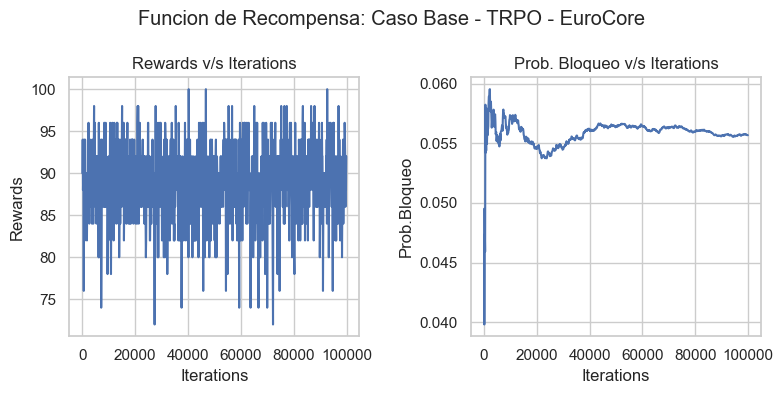

In [6]:
graph_Rewards_Bloqueo(x, rewardsArrayCB_TRPO_Euro, probBloqueoArrayCB_TRPO_Euro, "Caso Base", "TRPO", "EuroCore")

### 2) Funciona de Recompensa: Band Select (DONE)

#### 2.1) Data:

In [7]:
episodeRewardsArrayBS_TRPO_Euro=[85.99999999999996, 88.79999999999998, 81.79999999999998, 85.19999999999996, 85.59999999999997, 78.59999999999997, 81.19999999999997, 85.99999999999996, 69.79999999999997, 77.99999999999997, 85.59999999999997, 82.79999999999995, 83.19999999999996, 84.99999999999996, 85.59999999999995, 74.99999999999996, 91.79999999999997, 82.79999999999997, 76.99999999999994, 89.79999999999995, 86.99999999999996, 84.59999999999995, 85.19999999999997, 83.59999999999997, 83.59999999999998, 85.19999999999996, 87.19999999999996, 85.99999999999996, 73.79999999999998, 85.39999999999995, 75.59999999999997, 87.99999999999997, 65.19999999999996, 73.19999999999996, 80.79999999999997, 72.99999999999997, 84.59999999999997, 80.99999999999996, 87.39999999999996, 84.59999999999995, 83.59999999999997, 82.99999999999996, 88.59999999999995, 84.59999999999995, 85.79999999999998, 88.39999999999996, 87.59999999999997, 87.39999999999996, 79.19999999999996, 78.99999999999997, 76.59999999999997, 81.19999999999996, 81.39999999999996, 82.59999999999997, 83.59999999999995, 84.19999999999997, 86.99999999999996, 86.79999999999997, 83.39999999999996, 75.59999999999997, 90.19999999999996, 81.59999999999997, 87.19999999999996, 80.19999999999999, 85.39999999999996, 86.59999999999995, 82.39999999999996, 82.99999999999996, 87.79999999999997, 79.39999999999998, 79.99999999999996, 84.19999999999997, 84.99999999999997, 79.19999999999996, 78.19999999999997, 79.99999999999996, 86.39999999999996, 91.79999999999997, 86.59999999999997, 82.99999999999997, 81.99999999999997, 85.39999999999996, 89.59999999999998, 75.79999999999998, 78.79999999999994, 82.19999999999996, 83.99999999999993, 80.19999999999996, 93.19999999999995, 88.59999999999995, 75.19999999999996, 80.79999999999997, 80.19999999999997, 79.79999999999997, 80.79999999999995, 73.79999999999995, 75.99999999999999, 81.79999999999997, 79.39999999999995, 88.19999999999996, 86.79999999999994, 95.39999999999995, 74.99999999999997, 84.19999999999997, 85.99999999999999, 84.79999999999995, 89.39999999999996, 83.39999999999998, 81.59999999999995, 86.19999999999995, 76.19999999999996, 81.59999999999998, 77.59999999999997, 85.39999999999996, 86.39999999999996, 84.19999999999997, 76.99999999999996, 87.39999999999995, 78.99999999999997, 82.39999999999996, 73.59999999999994, 86.79999999999997, 89.19999999999997, 83.59999999999995, 80.19999999999996, 85.19999999999997, 89.59999999999997, 86.79999999999998, 84.19999999999993, 85.19999999999995, 79.59999999999998, 84.99999999999996, 82.39999999999998, 84.19999999999997, 86.19999999999997, 74.59999999999995, 83.19999999999996, 81.39999999999995, 79.79999999999995, 81.79999999999997, 79.39999999999998, 79.19999999999997, 78.79999999999997, 73.59999999999998, 85.39999999999996, 73.39999999999996, 83.79999999999998, 79.99999999999997, 87.39999999999998, 77.59999999999997, 79.79999999999998, 85.19999999999996, 88.99999999999997, 88.39999999999996, 84.59999999999995, 89.79999999999997, 80.99999999999997, 79.19999999999997, 82.39999999999996, 79.39999999999996, 85.79999999999997, 78.99999999999997, 89.79999999999995, 83.19999999999993, 84.79999999999997, 83.39999999999996, 79.39999999999996, 87.99999999999994, 86.39999999999996, 78.79999999999997, 77.19999999999996, 87.79999999999997, 86.19999999999997, 78.39999999999996, 80.59999999999997, 81.19999999999997, 84.19999999999993, 81.79999999999995, 85.59999999999995, 86.79999999999995, 77.59999999999997, 79.99999999999997, 82.79999999999998, 92.19999999999996, 83.19999999999996, 82.39999999999995, 77.19999999999996, 85.19999999999997, 81.99999999999996, 83.39999999999996, 84.59999999999998, 89.19999999999995, 84.19999999999993, 81.79999999999997, 82.99999999999994, 88.99999999999993, 75.59999999999997, 83.99999999999999, 83.99999999999996, 76.99999999999996, 88.19999999999995, 82.39999999999998, 82.79999999999994, 85.39999999999996, 90.19999999999997, 72.59999999999995, 87.99999999999996, 81.59999999999997, 81.39999999999996, 87.99999999999997, 82.99999999999996, 79.99999999999997, 80.39999999999996, 80.79999999999997, 84.99999999999996, 78.59999999999998, 77.39999999999998, 81.79999999999995, 72.59999999999995, 74.59999999999997, 82.19999999999997, 91.19999999999996, 85.79999999999997, 88.19999999999996, 86.39999999999995, 87.39999999999995, 86.59999999999997, 85.19999999999996, 83.19999999999997, 92.99999999999996, 86.39999999999998, 82.99999999999996, 79.19999999999995, 86.79999999999998, 80.19999999999997, 75.39999999999996, 90.39999999999998, 80.99999999999997, 85.79999999999997, 93.79999999999997, 85.79999999999997, 85.19999999999997, 80.19999999999997, 79.19999999999995, 84.79999999999994, 83.99999999999996, 77.99999999999997, 85.19999999999997, 78.99999999999997, 80.59999999999995, 89.99999999999994, 81.39999999999995, 80.39999999999998, 78.79999999999997, 76.99999999999996, 77.59999999999998, 81.79999999999995, 82.79999999999995, 91.59999999999994, 86.79999999999997, 84.19999999999995, 87.99999999999997, 89.59999999999997, 82.19999999999996, 80.39999999999996, 82.59999999999997, 80.99999999999997, 87.19999999999996, 79.99999999999996, 91.39999999999996, 83.99999999999997, 88.19999999999995, 80.19999999999995, 79.59999999999995, 76.39999999999995, 88.79999999999995, 78.19999999999997, 85.99999999999997, 89.19999999999997, 82.39999999999995, 82.99999999999997, 89.79999999999997, 85.39999999999996, 88.99999999999996, 87.99999999999997, 77.59999999999997, 83.59999999999997, 85.79999999999994, 88.39999999999998, 79.99999999999996, 84.59999999999995, 83.19999999999996, 85.99999999999996, 79.19999999999993, 74.99999999999997, 88.39999999999996, 81.19999999999996, 83.79999999999997, 91.59999999999995, 87.59999999999997, 86.19999999999996, 76.99999999999997, 86.79999999999995, 76.99999999999997, 77.39999999999998, 82.79999999999995, 79.59999999999995, 80.59999999999997, 84.59999999999997, 83.39999999999998, 83.39999999999996, 76.39999999999998, 83.59999999999995, 85.39999999999996, 83.59999999999997, 86.79999999999994, 88.19999999999996, 81.79999999999997, 91.79999999999995, 72.39999999999999, 73.19999999999996, 83.59999999999997, 84.99999999999997, 86.39999999999996, 74.99999999999997, 85.19999999999996, 85.59999999999998, 89.19999999999997, 80.79999999999997, 86.59999999999997, 81.99999999999997, 81.79999999999998, 85.19999999999997, 86.19999999999996, 79.19999999999996, 84.59999999999995, 86.59999999999995, 93.19999999999996, 87.39999999999996, 81.59999999999997, 88.99999999999997, 74.79999999999995, 82.19999999999997, 77.59999999999997, 83.99999999999996, 83.39999999999998, 77.39999999999998, 76.19999999999996, 81.79999999999998, 91.19999999999997, 88.59999999999997, 89.79999999999997, 73.79999999999997, 79.39999999999996, 78.79999999999995, 81.79999999999995, 89.99999999999997, 87.19999999999996, 81.59999999999997, 73.99999999999996, 85.79999999999995, 71.99999999999997, 85.59999999999997, 84.19999999999995, 90.99999999999996, 82.99999999999997, 78.59999999999997, 85.99999999999996, 86.39999999999995, 79.39999999999998, 89.39999999999996, 88.79999999999995, 69.99999999999996, 89.19999999999997, 91.99999999999996, 88.99999999999997, 83.59999999999994, 81.79999999999995, 80.79999999999995, 87.79999999999997, 75.19999999999997, 66.99999999999997, 85.79999999999997, 81.79999999999997, 76.39999999999998, 81.79999999999997, 81.19999999999996, 87.19999999999995, 84.59999999999998, 84.19999999999996, 72.39999999999996, 75.59999999999998, 84.59999999999995, 72.19999999999996, 84.39999999999996, 84.79999999999997, 95.99999999999996, 78.19999999999997, 90.59999999999997, 86.59999999999994, 84.39999999999996, 87.39999999999996, 87.59999999999998, 84.79999999999997, 85.39999999999996, 85.19999999999996, 84.19999999999996, 78.39999999999993, 72.59999999999998, 76.79999999999997, 75.59999999999997, 83.79999999999997, 78.39999999999998, 83.39999999999995, 82.39999999999995, 82.99999999999996, 83.99999999999996, 82.79999999999995, 86.99999999999996, 87.59999999999992, 69.99999999999996, 79.59999999999995, 86.59999999999998, 85.99999999999997, 88.99999999999996, 87.99999999999997, 92.19999999999993, 76.59999999999995, 78.99999999999997, 84.99999999999996, 86.39999999999996, 78.19999999999996, 85.59999999999997, 85.59999999999997, 80.39999999999996, 72.59999999999998, 73.19999999999996, 82.99999999999997, 87.39999999999998, 90.39999999999996, 92.19999999999997, 88.59999999999995, 83.39999999999996, 83.59999999999997, 87.39999999999998, 83.79999999999997, 87.39999999999996, 86.79999999999997, 85.19999999999997, 89.59999999999998, 84.19999999999999, 86.19999999999995, 85.79999999999994, 87.79999999999997, 83.99999999999996, 89.79999999999994, 76.59999999999998, 89.79999999999997, 86.59999999999997, 81.39999999999995, 78.79999999999993, 84.99999999999996, 87.99999999999996, 86.99999999999996, 76.59999999999994, 78.19999999999997, 84.79999999999997, 81.59999999999995, 90.79999999999995, 82.39999999999998, 84.19999999999995, 87.39999999999993, 83.99999999999994, 87.39999999999996, 78.99999999999996, 78.39999999999996, 79.59999999999995, 80.79999999999997, 88.79999999999997, 81.39999999999996, 82.59999999999998, 79.99999999999996, 85.39999999999995, 92.19999999999997, 89.79999999999995, 82.79999999999997, 82.99999999999997, 87.39999999999996, 83.99999999999994, 80.99999999999996, 85.59999999999995, 85.79999999999997, 89.19999999999993, 76.99999999999996, 92.39999999999995, 84.99999999999996, 80.39999999999996, 81.39999999999998, 85.19999999999996, 81.79999999999995, 80.79999999999998, 76.99999999999996, 88.39999999999995, 85.19999999999996, 86.99999999999996, 76.59999999999997, 80.99999999999996, 74.19999999999997, 82.59999999999998, 81.99999999999994, 94.19999999999997, 80.99999999999997, 83.79999999999997, 91.79999999999997, 84.19999999999995, 84.39999999999996, 71.99999999999997, 85.79999999999997, 85.59999999999997, 83.79999999999995, 85.99999999999996, 78.59999999999997, 89.59999999999997, 89.39999999999995, 81.19999999999997, 88.59999999999995, 80.99999999999996, 91.39999999999996, 83.99999999999997, 84.39999999999999, 90.99999999999996, 76.79999999999995, 73.59999999999997, 84.59999999999995, 78.39999999999995, 82.19999999999996, 81.19999999999996, 79.79999999999997, 87.79999999999997, 77.19999999999996, 82.59999999999997, 85.19999999999997, 78.59999999999995, 84.39999999999996, 90.59999999999997, 83.99999999999996, 80.79999999999997, 90.39999999999998, 80.99999999999996, 87.59999999999995, 90.99999999999996, 86.19999999999996, 87.59999999999997, 89.19999999999995, 86.19999999999995, 84.79999999999995, 71.59999999999995, 82.59999999999997, 86.59999999999995, 82.19999999999999, 80.19999999999996, 86.39999999999996, 79.79999999999997, 79.39999999999996, 81.79999999999997, 83.79999999999997, 79.99999999999997, 86.79999999999998, 88.99999999999996, 79.99999999999997, 84.99999999999997, 81.19999999999997, 74.99999999999997, 79.99999999999996, 79.59999999999997, 80.79999999999994, 84.59999999999997, 83.19999999999997, 87.79999999999998, 83.99999999999996, 83.79999999999998, 89.79999999999995, 87.19999999999996, 88.39999999999995, 80.59999999999995, 83.99999999999997, 80.99999999999996, 83.59999999999994, 84.79999999999995, 82.99999999999997, 87.39999999999996, 88.59999999999997, 86.99999999999996, 75.39999999999996, 89.19999999999997, 84.19999999999995, 84.39999999999996, 78.39999999999996, 85.19999999999996, 79.19999999999996, 87.39999999999996, 75.79999999999998, 84.59999999999997, 77.39999999999998, 82.39999999999999, 83.59999999999997, 81.39999999999998, 79.99999999999996, 83.39999999999998, 79.39999999999993, 85.59999999999997, 75.59999999999997, 78.59999999999997, 80.79999999999997, 85.19999999999996, 80.59999999999995, 86.59999999999994, 87.59999999999997, 82.19999999999996, 82.59999999999995, 80.39999999999995, 81.59999999999995, 83.19999999999996, 82.59999999999997, 84.39999999999996, 82.99999999999996, 91.19999999999996, 83.79999999999997, 81.39999999999996, 72.79999999999997, 81.39999999999995, 84.59999999999995, 82.79999999999997, 86.59999999999997, 83.39999999999995, 91.59999999999997, 82.79999999999997, 79.79999999999997, 82.99999999999999, 85.99999999999997, 84.39999999999998, 87.79999999999997, 86.79999999999998, 93.39999999999995, 80.19999999999997, 82.39999999999998, 81.39999999999995, 85.19999999999996, 93.19999999999995, 80.39999999999996, 77.99999999999996, 85.19999999999997, 74.79999999999994, 85.19999999999997, 84.79999999999995, 76.79999999999995, 84.19999999999997, 83.99999999999999, 87.79999999999997, 84.99999999999996, 70.59999999999998, 86.59999999999998, 88.99999999999994, 84.79999999999995, 75.79999999999997, 74.19999999999996, 82.79999999999997, 82.39999999999998, 81.79999999999997, 88.39999999999999, 82.79999999999995, 79.59999999999998, 79.59999999999995, 81.99999999999996, 86.39999999999998, 81.59999999999998, 78.99999999999997, 79.6, 85.39999999999996, 82.19999999999997, 84.59999999999995, 77.19999999999996, 89.99999999999997, 84.19999999999996, 88.19999999999995, 85.39999999999996, 81.79999999999997, 80.39999999999996, 85.99999999999996, 83.19999999999996, 82.39999999999995, 83.99999999999996, 88.19999999999996, 85.19999999999996, 74.99999999999997, 92.19999999999997, 88.39999999999998, 81.79999999999995, 86.39999999999995, 90.79999999999997, 88.19999999999997, 89.79999999999998, 82.6, 83.79999999999995, 80.59999999999997, 83.99999999999997, 89.59999999999997, 77.59999999999997, 83.59999999999997, 82.39999999999996, 91.59999999999997, 83.59999999999997, 86.99999999999999, 77.59999999999997, 87.79999999999997, 82.79999999999997, 86.39999999999993, 82.99999999999997, 87.39999999999995, 80.79999999999995, 88.59999999999995, 88.39999999999992, 91.39999999999996, 79.39999999999996, 87.99999999999996, 86.99999999999999, 84.39999999999998, 84.19999999999996, 78.19999999999996, 71.59999999999997, 85.39999999999995, 88.19999999999996, 79.99999999999996, 76.79999999999997, 77.79999999999995, 90.99999999999994, 90.19999999999996, 86.19999999999996, 88.59999999999994, 88.59999999999995, 87.79999999999997, 89.39999999999996, 78.19999999999996, 79.39999999999996, 84.59999999999995, 83.79999999999997, 81.19999999999996, 76.59999999999997, 86.19999999999997, 79.59999999999994, 77.99999999999997, 91.79999999999997, 80.39999999999995, 82.59999999999997, 83.39999999999996, 79.39999999999998, 92.79999999999997, 83.39999999999995, 80.39999999999996, 85.39999999999995, 76.39999999999998, 81.79999999999995, 80.59999999999995, 77.99999999999996, 82.59999999999995, 78.79999999999998, 81.99999999999997, 88.79999999999995, 82.19999999999996, 73.19999999999996, 84.99999999999997, 82.59999999999995, 86.39999999999998, 82.59999999999998, 91.99999999999997, 80.19999999999996, 88.99999999999996, 80.59999999999995, 75.59999999999998, 85.19999999999996, 75.99999999999996, 78.99999999999996, 85.79999999999995, 79.79999999999995, 90.79999999999995, 83.19999999999996, 73.59999999999998, 91.39999999999995, 84.39999999999995, 88.99999999999996, 84.19999999999995, 75.19999999999993, 87.79999999999997, 87.59999999999997, 75.39999999999998, 84.99999999999994, 83.79999999999995, 82.99999999999996, 71.19999999999997, 75.99999999999999, 84.79999999999997, 87.99999999999994, 83.79999999999997, 79.79999999999997, 87.99999999999996, 81.39999999999995, 83.99999999999994, 83.79999999999995, 83.59999999999997, 83.59999999999997, 78.59999999999998, 86.39999999999996, 78.59999999999995, 79.59999999999997, 81.99999999999996, 77.59999999999997, 80.59999999999997, 82.79999999999997, 86.79999999999995, 78.79999999999995, 84.19999999999996, 83.19999999999995, 80.19999999999999, 85.99999999999996, 81.19999999999995, 79.39999999999998, 86.79999999999997, 76.99999999999996, 76.79999999999997, 78.99999999999997, 91.19999999999997, 81.39999999999998, 79.99999999999994, 86.39999999999995, 81.59999999999995, 89.19999999999996, 85.39999999999995, 87.39999999999996, 83.99999999999996, 87.99999999999996, 84.19999999999997, 86.79999999999995, 78.19999999999997, 84.79999999999994, 81.99999999999997, 86.19999999999996, 88.99999999999997, 81.59999999999997, 88.79999999999997, 83.39999999999995, 84.59999999999995, 81.19999999999993, 77.39999999999995, 88.19999999999995, 81.59999999999997, 85.39999999999998, 80.59999999999994, 89.59999999999997, 86.59999999999995, 91.19999999999997, 87.99999999999993, 87.79999999999995, 84.79999999999997, 87.99999999999999, 81.19999999999997, 84.79999999999997, 85.19999999999996, 86.79999999999997, 85.39999999999995, 87.79999999999995, 90.39999999999996, 87.79999999999997, 85.19999999999997, 84.19999999999997, 75.59999999999997, 84.19999999999997, 91.19999999999996, 87.99999999999994, 89.39999999999998, 88.39999999999996, 84.39999999999996, 75.59999999999997, 77.39999999999998, 87.99999999999997, 89.39999999999996, 93.19999999999995, 83.59999999999997, 74.99999999999997, 87.79999999999997, 79.59999999999995, 87.39999999999996, 84.59999999999997, 85.39999999999995, 81.39999999999996, 78.19999999999997, 90.59999999999995, 85.39999999999998, 85.59999999999997, 84.99999999999997, 76.99999999999996, 87.59999999999997, 83.19999999999995, 91.59999999999995, 83.79999999999998, 82.79999999999997, 87.59999999999995, 78.59999999999997, 84.99999999999996, 73.99999999999994, 84.99999999999994, 84.19999999999997, 86.99999999999997, 83.19999999999996, 91.19999999999996, 82.79999999999997, 82.79999999999997, 80.19999999999996, 74.99999999999997, 71.79999999999997, 80.39999999999996, 84.79999999999995, 80.59999999999997, 74.79999999999997, 83.99999999999997, 82.99999999999994, 87.59999999999997, 89.39999999999996, 85.59999999999998, 80.19999999999995, 86.39999999999995, 82.79999999999995, 78.19999999999997, 90.19999999999997, 80.59999999999998, 86.19999999999997, 88.79999999999995, 83.39999999999999, 79.79999999999997, 85.79999999999995, 87.59999999999995, 88.39999999999995, 88.59999999999998, 77.19999999999997, 81.59999999999995, 85.59999999999997, 84.19999999999995, 85.59999999999995, 90.79999999999995, 79.79999999999997, 89.59999999999997, 89.99999999999997, 88.59999999999994, 86.19999999999997, 91.59999999999997, 84.99999999999997, 80.79999999999994, 73.79999999999997, 88.79999999999997, 84.39999999999996, 76.79999999999997, 80.59999999999997, 84.79999999999995, 85.79999999999995, 80.39999999999995, 85.79999999999997, 83.39999999999995, 84.19999999999997, 89.39999999999995, 87.79999999999997, 91.19999999999995, 92.79999999999997, 84.59999999999994, 81.79999999999998, 89.39999999999996, 76.39999999999998, 82.59999999999997, 83.79999999999995, 84.59999999999995, 84.39999999999995, 90.59999999999997, 81.19999999999997, 77.99999999999997, 85.59999999999998, 87.99999999999996, 90.59999999999995, 76.39999999999995, 86.79999999999995, 90.59999999999995, 79.79999999999995, 88.79999999999995, 81.39999999999996, 86.19999999999999, 87.39999999999995, 88.99999999999997, 76.79999999999994, 75.19999999999999, 81.19999999999996, 77.79999999999997, 84.79999999999997, 92.99999999999996, 82.59999999999997, 81.59999999999997, 84.79999999999997, 84.59999999999997, 81.99999999999996, 81.39999999999999, 85.79999999999997, 91.19999999999996, 83.19999999999997, 90.59999999999997, 83.59999999999998, 81.19999999999996, 87.39999999999998, 86.39999999999995, 78.39999999999995, 81.39999999999998, 80.79999999999995, 79.39999999999996, 80.59999999999998, 84.59999999999998]
rewardsArrayBS_TRPO_Euro=[0, 88.59999999999994, 78.79999999999994, 86.19999999999993, 86.99999999999997, 83.99999999999996, 86.79999999999997, 85.59999999999997, 79.39999999999996, 80.99999999999999, 78.99999999999997, 79.99999999999997, 77.79999999999997, 69.59999999999995, 77.59999999999995, 74.79999999999995, 79.19999999999996, 83.19999999999996, 86.99999999999997, 80.79999999999997, 84.59999999999995, 86.39999999999996, 84.79999999999997, 89.99999999999996, 80.99999999999996, 86.59999999999997, 90.19999999999997, 82.99999999999996, 91.39999999999996, 72.79999999999997, 80.79999999999995, 75.59999999999997, 82.79999999999995, 82.79999999999995, 82.39999999999995, 86.79999999999995, 86.19999999999996, 81.79999999999995, 90.39999999999996, 74.99999999999997, 83.79999999999997, 83.39999999999996, 87.39999999999996, 85.39999999999996, 82.59999999999997, 84.59999999999995, 85.19999999999996, 80.99999999999997, 85.99999999999994, 81.59999999999995, 83.59999999999995, 77.39999999999995, 88.99999999999996, 81.59999999999997, 80.79999999999995, 76.19999999999996, 82.79999999999998, 89.79999999999997, 90.59999999999998, 85.59999999999997, 77.59999999999995, 86.99999999999996, 87.19999999999996, 80.59999999999997, 81.39999999999996, 81.99999999999999, 84.19999999999995, 75.59999999999998, 87.59999999999997, 92.99999999999996, 76.99999999999997, 83.99999999999994, 79.79999999999997, 82.59999999999995, 75.19999999999996, 81.59999999999998, 71.19999999999997, 81.39999999999996, 80.99999999999994, 77.59999999999995, 92.19999999999995, 89.99999999999997, 84.79999999999995, 81.39999999999996, 85.99999999999996, 82.19999999999996, 91.39999999999996, 80.79999999999995, 82.39999999999996, 86.39999999999996, 79.99999999999996, 82.19999999999996, 82.39999999999996, 73.19999999999997, 90.19999999999996, 79.99999999999997, 81.59999999999997, 82.59999999999998, 77.79999999999995, 85.79999999999997, 81.39999999999995, 79.59999999999997, 85.19999999999996, 87.59999999999994, 88.19999999999995, 76.59999999999998, 89.79999999999997, 89.99999999999996, 83.59999999999995, 85.59999999999995, 78.39999999999992, 85.6, 81.39999999999996, 88.19999999999996, 84.59999999999997, 78.39999999999998, 77.99999999999996, 85.59999999999997, 76.59999999999997, 84.59999999999998, 76.99999999999996, 80.79999999999997, 76.59999999999997, 72.19999999999996, 83.99999999999996, 84.39999999999995, 69.99999999999996, 85.99999999999996, 83.59999999999995, 78.59999999999997, 80.39999999999995, 88.19999999999996, 82.59999999999995, 92.19999999999996, 86.39999999999995, 87.19999999999996, 79.99999999999997, 81.79999999999997, 84.39999999999995, 79.19999999999996, 83.59999999999997, 80.99999999999996, 86.19999999999997, 86.39999999999995, 78.79999999999997, 87.99999999999997, 79.59999999999995, 84.99999999999997, 87.19999999999995, 82.79999999999997, 79.79999999999997, 81.19999999999997, 88.19999999999997, 76.99999999999996, 81.99999999999994, 80.79999999999995, 83.79999999999995, 84.39999999999996, 84.79999999999995, 84.39999999999996, 83.39999999999993, 77.59999999999998, 77.59999999999997, 92.79999999999997, 87.59999999999997, 79.79999999999997, 76.39999999999996, 82.59999999999995, 86.19999999999997, 86.19999999999995, 80.99999999999997, 87.39999999999996, 84.99999999999997, 81.79999999999997, 87.59999999999998, 82.79999999999994, 87.19999999999997, 72.39999999999996, 85.99999999999994, 82.39999999999995, 85.19999999999997, 78.79999999999998, 82.59999999999997, 90.19999999999996, 83.39999999999996, 86.39999999999996, 76.59999999999998, 84.39999999999998, 86.79999999999998, 81.79999999999997, 83.79999999999995, 79.59999999999998, 80.99999999999997, 82.39999999999996, 82.99999999999996, 77.79999999999998, 79.39999999999995, 77.59999999999997, 82.39999999999995, 71.6, 79.39999999999996, 86.19999999999996, 90.99999999999997, 88.19999999999996, 85.79999999999997, 87.39999999999998, 85.19999999999996, 83.99999999999996, 85.59999999999997, 86.19999999999996, 91.59999999999997, 84.79999999999997, 77.79999999999997, 84.39999999999996, 84.59999999999998, 77.99999999999997, 83.19999999999997, 83.99999999999996, 85.59999999999997, 87.79999999999997, 87.79999999999995, 88.99999999999994, 80.39999999999995, 82.99999999999996, 80.39999999999998, 83.19999999999996, 79.79999999999997, 82.39999999999999, 83.59999999999997, 82.59999999999995, 83.39999999999996, 83.59999999999995, 78.19999999999997, 85.59999999999997, 77.79999999999997, 76.19999999999996, 82.99999999999996, 78.39999999999996, 88.79999999999995, 88.99999999999993, 85.59999999999997, 82.79999999999994, 91.59999999999997, 84.19999999999999, 84.39999999999998, 80.79999999999995, 81.99999999999997, 79.79999999999995, 86.39999999999993, 85.39999999999996, 89.19999999999996, 81.99999999999996, 87.79999999999994, 83.99999999999996, 70.39999999999998, 84.19999999999995, 80.99999999999997, 81.99999999999996, 93.59999999999997, 85.79999999999997, 75.79999999999995, 89.79999999999997, 87.59999999999997, 86.99999999999996, 91.59999999999997, 78.59999999999998, 86.79999999999997, 82.99999999999996, 86.59999999999997, 79.59999999999995, 84.59999999999997, 84.59999999999997, 89.19999999999997, 75.79999999999997, 78.79999999999997, 80.39999999999998, 85.79999999999997, 80.99999999999997, 89.99999999999997, 91.79999999999997, 82.19999999999995, 86.39999999999995, 83.19999999999996, 78.19999999999999, 75.6, 83.79999999999997, 78.59999999999997, 81.59999999999997, 82.39999999999996, 80.39999999999996, 85.79999999999995, 84.39999999999999, 72.19999999999997, 91.19999999999996, 78.99999999999996, 86.19999999999997, 89.59999999999995, 81.19999999999996, 90.19999999999996, 79.59999999999994, 70.59999999999997, 86.59999999999997, 78.79999999999994, 87.19999999999995, 80.99999999999997, 78.99999999999997, 84.99999999999996, 91.19999999999995, 81.39999999999996, 82.59999999999995, 89.39999999999996, 75.99999999999996, 87.59999999999997, 85.79999999999994, 79.59999999999995, 80.59999999999997, 87.19999999999996, 92.19999999999995, 87.39999999999996, 84.39999999999993, 88.19999999999996, 83.59999999999997, 75.59999999999998, 81.39999999999998, 81.99999999999997, 86.59999999999994, 76.79999999999997, 72.59999999999995, 82.59999999999998, 85.19999999999999, 94.19999999999996, 82.99999999999997, 83.19999999999996, 79.99999999999997, 72.99999999999996, 89.59999999999998, 79.59999999999997, 89.79999999999995, 79.79999999999997, 84.19999999999996, 79.59999999999995, 77.79999999999994, 74.99999999999997, 87.39999999999996, 89.79999999999994, 84.79999999999998, 84.99999999999996, 78.79999999999995, 85.99999999999996, 86.19999999999997, 80.79999999999997, 88.79999999999995, 83.99999999999994, 75.79999999999995, 92.99999999999997, 86.59999999999995, 90.99999999999996, 80.59999999999997, 81.19999999999996, 83.59999999999998, 80.59999999999995, 75.39999999999996, 73.39999999999998, 88.59999999999998, 75.59999999999998, 76.59999999999995, 82.79999999999997, 82.39999999999999, 84.79999999999997, 87.59999999999997, 75.99999999999996, 71.19999999999996, 81.59999999999997, 77.99999999999996, 78.99999999999996, 84.79999999999994, 92.59999999999997, 83.99999999999996, 84.19999999999997, 93.99999999999997, 81.59999999999995, 85.99999999999996, 88.59999999999997, 84.79999999999995, 89.99999999999997, 82.99999999999996, 84.19999999999999, 87.59999999999997, 66.19999999999997, 73.79999999999995, 83.19999999999996, 76.59999999999998, 81.59999999999997, 80.99999999999996, 88.39999999999995, 75.59999999999997, 82.39999999999998, 84.59999999999995, 85.79999999999997, 90.99999999999997, 72.79999999999997, 73.59999999999995, 86.79999999999997, 86.39999999999996, 89.59999999999995, 83.19999999999996, 94.79999999999997, 77.79999999999995, 85.19999999999995, 79.99999999999997, 84.59999999999995, 83.59999999999997, 77.79999999999997, 87.39999999999996, 84.99999999999996, 82.99999999999996, 65.19999999999999, 80.39999999999998, 84.39999999999996, 88.59999999999995, 90.59999999999998, 91.19999999999996, 86.99999999999994, 83.19999999999997, 86.59999999999998, 84.59999999999997, 84.59999999999998, 84.19999999999996, 82.99999999999996, 92.19999999999997, 86.59999999999997, 87.39999999999995, 81.19999999999997, 89.99999999999996, 84.99999999999999, 86.39999999999995, 84.19999999999996, 82.59999999999998, 92.39999999999996, 86.59999999999998, 75.39999999999995, 81.79999999999995, 87.99999999999999, 86.79999999999995, 81.99999999999994, 73.39999999999995, 82.79999999999997, 85.19999999999997, 84.59999999999997, 87.99999999999999, 83.59999999999997, 83.79999999999995, 87.79999999999995, 86.19999999999996, 84.59999999999995, 74.99999999999999, 79.39999999999998, 79.19999999999996, 83.59999999999998, 88.19999999999996, 79.59999999999998, 83.59999999999995, 81.99999999999996, 87.99999999999996, 93.39999999999998, 84.19999999999996, 80.59999999999995, 89.79999999999995, 86.79999999999995, 80.99999999999997, 80.79999999999995, 85.79999999999997, 90.99999999999996, 82.99999999999994, 82.79999999999998, 88.99999999999996, 80.99999999999996, 79.99999999999996, 84.59999999999997, 81.59999999999994, 82.99999999999997, 80.99999999999997, 82.39999999999996, 84.19999999999996, 87.59999999999997, 78.59999999999995, 82.79999999999995, 78.99999999999996, 74.79999999999998, 82.19999999999997, 89.19999999999999, 83.79999999999998, 88.19999999999997, 83.79999999999997, 91.19999999999995, 85.59999999999998, 75.79999999999997, 76.19999999999997, 87.19999999999996, 82.79999999999998, 85.59999999999994, 86.39999999999995, 84.79999999999995, 88.59999999999995, 84.19999999999995, 85.39999999999996, 85.19999999999996, 84.79999999999995, 89.79999999999997, 79.79999999999995, 88.79999999999997, 82.39999999999995, 76.99999999999996, 78.99999999999996, 84.39999999999995, 77.99999999999996, 79.59999999999997, 84.59999999999997, 86.59999999999998, 77.39999999999996, 80.39999999999995, 82.79999999999995, 81.79999999999997, 80.99999999999996, 89.79999999999997, 92.99999999999996, 74.79999999999995, 86.39999999999996, 86.19999999999997, 83.39999999999995, 90.19999999999995, 89.39999999999996, 88.59999999999997, 85.59999999999997, 89.19999999999996, 85.79999999999997, 76.59999999999995, 72.79999999999998, 89.79999999999997, 80.39999999999996, 83.79999999999995, 82.19999999999996, 89.39999999999996, 78.19999999999999, 77.99999999999996, 82.39999999999996, 76.19999999999997, 92.19999999999997, 86.39999999999996, 80.79999999999997, 83.19999999999995, 89.39999999999995, 68.99999999999997, 82.19999999999997, 81.19999999999996, 81.99999999999999, 79.79999999999995, 82.99999999999994, 87.39999999999996, 84.79999999999995, 80.99999999999997, 88.59999999999994, 88.99999999999996, 90.99999999999996, 84.39999999999996, 79.39999999999998, 81.39999999999995, 86.79999999999995, 81.99999999999997, 81.99999999999994, 87.59999999999995, 85.99999999999997, 86.79999999999997, 80.79999999999995, 83.59999999999997, 88.39999999999993, 84.99999999999997, 81.19999999999996, 77.19999999999997, 86.79999999999995, 78.99999999999996, 80.99999999999996, 83.59999999999998, 75.39999999999996, 83.39999999999995, 80.39999999999995, 91.39999999999996, 78.39999999999995, 76.99999999999996, 83.39999999999995, 81.79999999999997, 80.39999999999995, 70.59999999999997, 91.59999999999995, 84.19999999999996, 80.19999999999996, 81.39999999999993, 88.99999999999997, 80.39999999999995, 86.59999999999995, 83.19999999999997, 78.59999999999998, 80.99999999999996, 82.39999999999998, 82.59999999999995, 84.99999999999996, 86.99999999999997, 93.59999999999995, 77.99999999999997, 78.59999999999997, 74.79999999999997, 81.59999999999995, 87.59999999999997, 82.99999999999997, 84.79999999999995, 88.39999999999998, 86.79999999999994, 80.19999999999997, 79.59999999999998, 84.99999999999997, 83.79999999999997, 86.79999999999994, 91.39999999999996, 89.39999999999998, 86.79999999999997, 76.19999999999996, 86.79999999999997, 78.59999999999997, 93.99999999999997, 83.39999999999998, 78.99999999999996, 79.99999999999996, 82.39999999999998, 83.39999999999996, 81.79999999999995, 82.59999999999995, 77.19999999999996, 87.79999999999995, 87.99999999999996, 83.99999999999996, 79.19999999999996, 77.79999999999995, 85.99999999999993, 88.79999999999995, 80.99999999999997, 74.79999999999997, 75.99999999999996, 83.39999999999995, 82.99999999999997, 84.99999999999996, 87.19999999999997, 73.59999999999997, 80.19999999999996, 86.39999999999995, 83.59999999999997, 85.19999999999995, 75.79999999999995, 82.39999999999995, 80.99999999999997, 87.39999999999996, 77.79999999999997, 82.99999999999997, 84.99999999999996, 87.79999999999995, 86.19999999999996, 86.39999999999996, 85.19999999999996, 79.79999999999995, 83.79999999999995, 82.39999999999995, 81.39999999999996, 86.79999999999995, 82.59999999999995, 89.39999999999996, 76.79999999999995, 87.19999999999996, 87.19999999999995, 86.39999999999998, 86.59999999999995, 89.79999999999997, 87.79999999999997, 85.59999999999997, 82.19999999999996, 89.99999999999999, 79.99999999999996, 83.79999999999997, 83.59999999999994, 88.99999999999994, 78.39999999999998, 81.99999999999994, 87.99999999999997, 84.99999999999996, 86.19999999999997, 81.19999999999997, 83.19999999999997, 83.19999999999996, 88.99999999999996, 83.99999999999996, 85.79999999999997, 82.79999999999995, 86.39999999999995, 88.99999999999996, 88.79999999999995, 84.99999999999996, 86.39999999999998, 84.19999999999997, 84.99999999999999, 84.59999999999995, 81.99999999999997, 79.19999999999996, 74.19999999999997, 83.99999999999994, 85.79999999999994, 78.99999999999996, 78.59999999999995, 82.59999999999997, 93.59999999999994, 84.39999999999995, 89.39999999999996, 90.39999999999996, 84.59999999999997, 87.79999999999995, 82.79999999999995, 79.19999999999997, 86.59999999999997, 77.79999999999994, 87.19999999999996, 75.79999999999998, 86.39999999999998, 79.59999999999997, 79.59999999999997, 84.39999999999996, 89.19999999999996, 81.59999999999995, 77.99999999999994, 89.79999999999998, 79.59999999999997, 86.99999999999996, 85.99999999999996, 80.59999999999997, 79.79999999999994, 80.79999999999995, 79.19999999999997, 82.79999999999997, 81.19999999999996, 72.19999999999996, 87.99999999999997, 84.79999999999997, 86.79999999999995, 75.39999999999998, 79.99999999999996, 81.79999999999994, 86.99999999999997, 85.99999999999997, 84.19999999999996, 84.19999999999997, 84.39999999999996, 90.39999999999995, 74.59999999999998, 80.79999999999995, 78.19999999999997, 78.19999999999996, 86.19999999999996, 81.59999999999995, 85.79999999999994, 87.79999999999995, 75.19999999999996, 83.99999999999997, 89.19999999999996, 85.79999999999995, 88.99999999999994, 74.99999999999996, 79.19999999999996, 89.59999999999997, 81.39999999999996, 82.39999999999998, 84.79999999999995, 83.19999999999996, 78.79999999999995, 70.99999999999997, 81.19999999999996, 87.79999999999995, 83.79999999999995, 80.59999999999998, 84.79999999999995, 85.39999999999995, 83.79999999999994, 86.19999999999996, 78.79999999999997, 84.99999999999997, 83.99999999999996, 79.19999999999997, 81.59999999999997, 82.39999999999996, 76.59999999999995, 85.39999999999998, 78.39999999999998, 77.19999999999996, 85.39999999999996, 80.79999999999997, 83.99999999999996, 81.19999999999997, 80.79999999999997, 88.59999999999997, 83.59999999999997, 76.59999999999997, 86.39999999999998, 84.79999999999998, 71.99999999999996, 80.59999999999995, 80.99999999999994, 87.59999999999995, 83.59999999999997, 83.39999999999996, 83.99999999999997, 84.39999999999996, 88.19999999999997, 85.39999999999996, 82.99999999999996, 88.79999999999995, 80.99999999999997, 89.59999999999995, 81.79999999999997, 85.99999999999996, 80.79999999999997, 80.79999999999995, 87.99999999999997, 88.39999999999996, 82.99999999999996, 89.59999999999997, 80.99999999999997, 81.99999999999994, 84.39999999999996, 80.39999999999993, 82.79999999999997, 81.19999999999996, 86.59999999999994, 85.59999999999997, 90.39999999999995, 82.39999999999996, 93.99999999999996, 87.19999999999996, 86.19999999999996, 89.19999999999996, 84.59999999999998, 79.99999999999999, 87.99999999999997, 84.39999999999999, 84.19999999999999, 84.79999999999997, 92.39999999999998, 84.19999999999997, 88.39999999999995, 82.99999999999994, 80.19999999999999, 84.79999999999997, 84.59999999999997, 90.19999999999995, 92.19999999999995, 88.59999999999998, 84.39999999999998, 77.39999999999998, 75.39999999999995, 83.59999999999997, 88.39999999999998, 93.19999999999996, 93.19999999999997, 76.99999999999996, 78.59999999999998, 84.19999999999995, 84.19999999999996, 84.79999999999995, 83.79999999999995, 84.99999999999996, 77.39999999999998, 85.79999999999995, 92.19999999999995, 82.19999999999996, 84.59999999999995, 83.99999999999996, 78.99999999999996, 86.19999999999995, 87.39999999999995, 84.59999999999997, 85.19999999999996, 86.59999999999995, 87.19999999999995, 77.99999999999994, 79.99999999999994, 77.19999999999997, 81.19999999999996, 87.19999999999996, 87.19999999999996, 88.99999999999996, 87.79999999999997, 77.39999999999995, 85.19999999999999, 80.19999999999997, 71.79999999999998, 74.79999999999995, 86.59999999999995, 74.99999999999996, 80.79999999999995, 79.79999999999997, 85.99999999999996, 84.59999999999997, 89.59999999999997, 84.19999999999995, 87.79999999999995, 84.99999999999997, 79.99999999999997, 78.99999999999997, 85.39999999999995, 85.59999999999995, 86.39999999999998, 86.19999999999997, 81.59999999999997, 84.59999999999997, 80.99999999999996, 89.39999999999998, 87.79999999999995, 89.39999999999996, 75.59999999999995, 86.79999999999997, 84.79999999999995, 81.19999999999996, 88.39999999999998, 85.59999999999995, 86.99999999999996, 81.79999999999997, 91.59999999999998, 86.39999999999995, 87.99999999999996, 90.39999999999996, 86.39999999999995, 88.99999999999997, 71.79999999999997, 82.99999999999999, 85.99999999999996, 79.79999999999995, 77.19999999999997, 86.59999999999997, 83.99999999999996, 83.79999999999995, 81.39999999999996, 85.99999999999997, 87.19999999999997, 82.79999999999994, 88.59999999999995, 88.19999999999997, 91.79999999999994, 93.79999999999997, 81.99999999999997, 82.59999999999997, 85.19999999999996, 77.59999999999997, 82.59999999999995, 85.99999999999994, 84.59999999999997, 85.99999999999999, 85.19999999999996, 83.59999999999997, 82.99999999999997, 82.99999999999997, 89.39999999999996, 81.39999999999996, 85.19999999999995, 88.39999999999995, 81.19999999999996, 85.79999999999997, 85.39999999999996, 82.79999999999997, 88.59999999999997, 89.19999999999997, 80.59999999999997, 74.39999999999998, 80.19999999999997, 80.19999999999995, 77.39999999999995, 92.59999999999998, 89.39999999999998, 83.99999999999997, 80.39999999999996, 82.99999999999994, 89.59999999999995, 78.59999999999994, 83.99999999999996, 84.59999999999997, 87.59999999999998, 85.79999999999995, 90.39999999999993, 81.99999999999999, 82.99999999999996, 88.19999999999997, 81.39999999999998, 79.39999999999996, 78.79999999999995, 87.19999999999996, 75.19999999999996, 87.59999999999995]
probBloqueoArrayBS_TRPO_Euro=[0.0, 0.0297029702970297, 0.05472636815920398, 0.04983388704318937, 0.04738154613466334, 0.0499001996007984, 0.048252911813643926, 0.04850213980028531, 0.052434456928838954, 0.05549389567147614, 0.057942057942057944, 0.05994550408719346, 0.06244796003330558, 0.0668716372021522, 0.06780870806566738, 0.06995336442371752, 0.07058088694565896, 0.06995884773662552, 0.06829539144919489, 0.0683850604944766, 0.06746626686656672, 0.06663493574488338, 0.06587914584279873, 0.06388526727509779, 0.0641399416909621, 0.06357457017193123, 0.06228373702422145, 0.06219918548685672, 0.06069260978222064, 0.062392278524646676, 0.06264578473842053, 0.06385037084811351, 0.06373008434864105, 0.06361708573159648, 0.0635107321376066, 0.06283918880319908, 0.062482643710080533, 0.062415563361253715, 0.06156274664561957, 0.06254806459882081, 0.06248437890527368, 0.062423799073396735, 0.061890026184241845, 0.061613578237619156, 0.06180413542376732, 0.061541879582315044, 0.061291023690502065, 0.061476281642203784, 0.06102895230160383, 0.0612119975515201, 0.0611877624475105, 0.0615565575377377, 0.060949817342818687, 0.06112054329371817, 0.061284947231994076, 0.061988729321941466, 0.0619532226388145, 0.06139273811611998, 0.06085157731425616, 0.06066768344348415, 0.060989835027495415, 0.06064579577118505, 0.060312852765682955, 0.060625297571814, 0.06077175441337291, 0.06091370558375635, 0.06074837145886987, 0.06118489777645127, 0.060873400970445524, 0.06013621214316766, 0.06056277674617912, 0.060414026193493876, 0.06068601583113457, 0.06067661964114505, 0.061207944872314554, 0.06132515664578056, 0.062097092487830546, 0.06219971432281522, 0.06229970516600436, 0.0625237311732692, 0.06186726659167604, 0.06135045056165905, 0.0612120473113035, 0.06131791350439706, 0.06118319247708606, 0.061286907422656155, 0.06080688292059063, 0.060912538788644985, 0.060902170207930914, 0.06066734074823053, 0.060771025441617596, 0.06076255356554225, 0.060862949679382675, 0.061391248252876035, 0.06105733432613552, 0.06125670982001895, 0.061347776273304865, 0.061436965261313266, 0.06162636465666769, 0.06150893849106151, 0.06159384061593841, 0.061677061677061676, 0.061562591902754635, 0.06125618871954179, 0.06095567733871743, 0.0613274926197505, 0.06103197811527215, 0.06074198673021213, 0.0607351171187853, 0.06045316943399688, 0.06053995091355331, 0.06053508692910549, 0.06061958753682707, 0.06043712945757013, 0.06043329532497149, 0.06069037475002174, 0.06085682268769933, 0.0607640372617725, 0.061011778662825186, 0.06091925048315268, 0.06116156986917757, 0.06131724650855301, 0.06163429227112532, 0.06210877164458174, 0.06209176679300057, 0.06199504039676826, 0.062534719466709, 0.062436028659160696, 0.06241699867197875, 0.06263080381365786, 0.06268748557803246, 0.06251431188458896, 0.06249526551018862, 0.06217577625742425, 0.06201029773897471, 0.06177320198503815, 0.061907212704948165, 0.06196627983358879, 0.061879573943917104, 0.06200992734335659, 0.06199557174487537, 0.062052336713708245, 0.061967467079783116, 0.061813859170687366, 0.06194014304562183, 0.06178884214881732, 0.06191356756386549, 0.06183252839942861, 0.06161745827984596, 0.0616066035836521, 0.06172921805212986, 0.061783987815376466, 0.0616406815341096, 0.06182602444284687, 0.0618141679111746, 0.06186697632410812, 0.06185500929427601, 0.06177950449015986, 0.061704955382570724, 0.06163134394063267, 0.06155865258421349, 0.06173529594435128, 0.06190975865687303, 0.06165265934605239, 0.06152063898542772, 0.06163262832555603, 0.06180350581290284, 0.061792707023531526, 0.06172251651687399, 0.06159398852138927, 0.06164343273925063, 0.06151687035845857, 0.06144991570257543, 0.061441535171377376, 0.06131831503936555, 0.06125364264899149, 0.06113289017669451, 0.06140895994576578, 0.06134486826582776, 0.06133735545500251, 0.06127437364590856, 0.06137782442958953, 0.06142519641777924, 0.061198841593355556, 0.06119232650399435, 0.061131830711853415, 0.06128702757916241, 0.061280145446767555, 0.06116695920429764, 0.06121369239722766, 0.0612073048786906, 0.061305690801528714, 0.06135097130357794, 0.06134397181493187, 0.06133704448224318, 0.06148402646018153, 0.06157849089332177, 0.06172275519009188, 0.061714054845714864, 0.062006934324908294, 0.062096895155242235, 0.062036714591313866, 0.06182862234542844, 0.06172109748288262, 0.0616636439390226, 0.061557972781815525, 0.061501868841318384, 0.06149461378677359, 0.06143935387721744, 0.06138462274532319, 0.06118756249702395, 0.06118193450547368, 0.06131786236498278, 0.06126472935542932, 0.0612588196813233, 0.06139249337240128, 0.06138604694227119, 0.06137965992350583, 0.06132746204302555, 0.06123008081822748, 0.06113358483705286, 0.06099271526175286, 0.06103328678888338, 0.06102865342361329, 0.061068702290076333, 0.061063952713212744, 0.06114773682580417, 0.06118673186203251, 0.06118152712600325, 0.06117636784419894, 0.061171253423764185, 0.06112289511276568, 0.06120425843713633, 0.061156173554783054, 0.06127943250288449, 0.06140164248329858, 0.061395703571882544, 0.061474199400869164, 0.061341960421831015, 0.061168988745240786, 0.06112245323111537, 0.06107630388780549, 0.060906574108507916, 0.060902843504382534, 0.06089914347772632, 0.060936288314762665, 0.06097313117352953, 0.06105015991255415, 0.06096528365791702, 0.06092124814264487, 0.06079756809727611, 0.060834229711963665, 0.06071187651283679, 0.060669538753408955, 0.06090311405062793, 0.06086035841731697, 0.060896058747705165, 0.060931481265320414, 0.06073408007441572, 0.06069263734990927, 0.06080535364024461, 0.060687329987356806, 0.060608373726193654, 0.06053001787004297, 0.0603765008901178, 0.06048828346100147, 0.06041126273448367, 0.060409722482304036, 0.06033356964292377, 0.06040667633173488, 0.06036813451353654, 0.060329877126305304, 0.06021837432447336, 0.060364089227500826, 0.060399255501624026, 0.06047052834442384, 0.06043259302199196, 0.06046713115049998, 0.06035754109564404, 0.06021289559513996, 0.060212135280882824, 0.060140208533504144, 0.06013971135775327, 0.0602452210169252, 0.06042040773212211, 0.06041893266902916, 0.06048739554561029, 0.06048569736246124, 0.06048401097184126, 0.060516937130203105, 0.06048067308023861, 0.06047902133947287, 0.06068285332694086, 0.06054400873690318, 0.060610183327097715, 0.06057421782312464, 0.060437147393669136, 0.06046934446651628, 0.06036710177510822, 0.06039931774857028, 0.060631312289590344, 0.0605627720009302, 0.060627131551935366, 0.060559057456849606, 0.06059011216736292, 0.06065374905740795, 0.06061893402176399, 0.06048662910002932, 0.06051751566507581, 0.06051584091129737, 0.06041740589013258, 0.06054467702003151, 0.060478830806704915, 0.06041340532251366, 0.06047578102608197, 0.06050601568204184, 0.06044112528084554, 0.0602820100312293, 0.06021823213106506, 0.06018620105952791, 0.06009187212899597, 0.06009158593190243, 0.06021552125710382, 0.06024581282313241, 0.060275917409956484, 0.06021353189132642, 0.060335572528450045, 0.060487446867068285, 0.06048596079387823, 0.06048448375429318, 0.06033150510590588, 0.0603607141778194, 0.060359627722056566, 0.06041860604786643, 0.060567048890751776, 0.06047580669233754, 0.060533912681170206, 0.06044331028752856, 0.060501168604479155, 0.06047019261968673, 0.060498220640569395, 0.060555408932289376, 0.06067074062161925, 0.06061047782863473, 0.06049242754571088, 0.060491000260862, 0.06046068032715817, 0.06051698798305524, 0.06045803281514899, 0.06042806796366866, 0.06048398617182366, 0.06039713968263012, 0.060367603193091104, 0.06045154528200334, 0.06033727860794893, 0.06027999211289823, 0.0601668492458077, 0.06019439231394079, 0.06022178151448283, 0.06022116375588424, 0.060248326435376795, 0.0603584388244093, 0.060495566420817104, 0.06043910636070632, 0.06054778714870471, 0.06062847593216624, 0.060626758831725906, 0.06065229830249857, 0.060623352626287326, 0.060567464296360535, 0.060647009540282695, 0.06080698633460015, 0.06083169807263246, 0.060883086244336616, 0.06093419962033101, 0.06090504253219914, 0.06079625541873886, 0.06079414339142198, 0.06079204253855718, 0.06065803013113111, 0.06065629851846004, 0.06062832996509278, 0.06054815318970708, 0.06052061303882405, 0.06044113434545975, 0.06043998857172541, 0.060438848734488744, 0.06038603653652361, 0.060591221875724854, 0.06071823346443536, 0.060716391887387505, 0.06081685890386435, 0.060840284686615134, 0.06086359125721992, 0.06078525925737925, 0.0608592187539556, 0.06088230095199616, 0.0608548903050301, 0.06082761739654782, 0.06072529510538583, 0.06082347941301468, 0.06092117403556021, 0.060869132608641574, 0.06084216272549068, 0.06076582262815277, 0.06076393175477149, 0.06063890051969163, 0.06068646961991106, 0.06063576873115855, 0.06068311288232561, 0.060657057144947686, 0.060655458504659254, 0.06072668139122837, 0.06067649693712017, 0.060650708920074396, 0.06064914098455459, 0.060887959424052306, 0.06090981031629937, 0.06088371091600679, 0.06083387031335768, 0.06076045808433132, 0.06066364219377212, 0.06059098125636833, 0.060589584170586984, 0.06056460932525176, 0.06056328086397967, 0.06056195863946856, 0.06053722395260064, 0.06053596878577603, 0.06044148155054661, 0.060417199600009304, 0.06036982900628756, 0.06039212055276498, 0.060298838364010066, 0.06029814981221631, 0.06025148847152939, 0.060227976422559115, 0.06025033752088053, 0.06013561334216114, 0.060112525910571514, 0.06018045044430809, 0.060180041268905464, 0.06013438609986199, 0.060088937044310516, 0.06008873674016351, 0.060178422956787485, 0.06020044393623462, 0.06017762466164068, 0.060154907256534454, 0.06011001982138482, 0.060109775338325816, 0.0600873594820514, 0.06002079600008849, 0.059976600958036246, 0.05995462655007599, 0.06006461396452825, 0.060108330957654436, 0.06015185663333406, 0.06015152507587171, 0.06010762292760506, 0.06015086628551553, 0.06015053903386044, 0.06015021319884851, 0.060085095354312, 0.059998706924419734, 0.059977204791294814, 0.059998712473981246, 0.059934476777799194, 0.059891882652080085, 0.05991343468156329, 0.05993489500223399, 0.0599138022547292, 0.05982924090591301, 0.05980846070907592, 0.059829961393219555, 0.0597671627965727, 0.0597886599021029, 0.05981006687490828, 0.059810464216229785, 0.05981085989854074, 0.05981125393220975, 0.05985322550466726, 0.059853530009750834, 0.05983312974886648, 0.059792153054688955, 0.05983381785942558, 0.0598341597909508, 0.05987556723681239, 0.05997827913362431, 0.05999877303122635, 0.05993755229485113, 0.059958045660984505, 0.05991748135200504, 0.059917648729234704, 0.05983684540798769, 0.05981697339447688, 0.05989798592770307, 0.05997867246131869, 0.059938555450693765, 0.05995871826215907, 0.05991880162396752, 0.059879044330452484, 0.05985936535128782, 0.059800003976064095, 0.059780559909525605, 0.059761192847666386, 0.05974190233394597, 0.05972268791542573, 0.05966417983897955, 0.0597041315494784, 0.05966549675496559, 0.059666151347331754, 0.0597253959883596, 0.05976491686321904, 0.05974591934009066, 0.059785246888409936, 0.05982442200732544, 0.05980541962437864, 0.059786490608289417, 0.059844704340956824, 0.05986423338012731, 0.05986449396364753, 0.0598839102699182, 0.05990325232787136, 0.059846186141485846, 0.05975124283346984, 0.05982775992851847, 0.05980911178156012, 0.05979053427018428, 0.059772026993818644, 0.05969698684930473, 0.059641061373608785, 0.05958534614011015, 0.05956736271364515, 0.05951199415741278, 0.059475523821984635, 0.0595324714091155, 0.05962645015921491, 0.05957138343153473, 0.059590731155266134, 0.05959148904649914, 0.05959224413596791, 0.05953764690688364, 0.05959374597152907, 0.059631256778368044, 0.05965028164620833, 0.059724180875808136, 0.05965156030054295, 0.059633948285615225, 0.059652829638804396, 0.059653460846166434, 0.05959964428957732, 0.05972717885545552, 0.05974575504963744, 0.05976426418295699, 0.05978270661789878, 0.05980108271433967, 0.05980143983052369, 0.05976595401516102, 0.05974848392694227, 0.05976678987875216, 0.059713730593037556, 0.059660860127044, 0.059590415800785064, 0.05957341181893938, 0.05960956443248792, 0.05962792176816664, 0.059593305232711946, 0.059594021232020566, 0.05959473471467988, 0.059560358590200174, 0.05954361569849915, 0.05952693134735407, 0.059545208635102355, 0.05954600094075016, 0.059494617484913304, 0.05947813406017256, 0.05949636921370514, 0.05954914274839536, 0.05951537969983247, 0.05955069740176894, 0.0595686821225108, 0.059586605041150494, 0.059655923569064, 0.05965651273094639, 0.05969128732842174, 0.05962355591201515, 0.059658268172603536, 0.059709868879780956, 0.059710361453965126, 0.0597108523584346, 0.059728261789140626, 0.05983007043799936, 0.05974604138210148, 0.05974646891466474, 0.05976370145039579, 0.05976409791782017, 0.0597142426425018, 0.05973144261801642, 0.059698502529173136, 0.059699005016583054, 0.059732783148366914, 0.05974983804255743, 0.05976683637087279, 0.05976722239698018, 0.059751078494570335, 0.05971848649362222, 0.059636579298528856, 0.05968651831384352, 0.059719873236892665, 0.059785905149095916, 0.059786255544099116, 0.059753925589451154, 0.05977063995693382, 0.059754727121708116, 0.05970634623827255, 0.059674355935780264, 0.05970729809889629, 0.05974013365479523, 0.05974055346440284, 0.05974097191980775, 0.05970918342699796, 0.05964534332245462, 0.059613810372225164, 0.05958237848752424, 0.05964704564726964, 0.05963163527739174, 0.05966412018947066, 0.059585038454801675, 0.05958569816060158, 0.05961810129997937, 0.05963455412750986, 0.059650954889954276, 0.05963570875657573, 0.05965205596126244, 0.05965260389600164, 0.059700319177371425, 0.0596693929451657, 0.05963856365887682, 0.05963912927810206, 0.05967094264152123, 0.059718257125473864, 0.05968754380772885, 0.05964137416214367, 0.05965745873511281, 0.05972000434101797, 0.0597668766737357, 0.059767236982426857, 0.059783028039690746, 0.05976795426880942, 0.05975292687804803, 0.0598147493894103, 0.05984570788791583, 0.059815316763908666, 0.059815599149860094, 0.059800613731088074, 0.059861892349201994, 0.05986210255551666, 0.05989270679776903, 0.05986252105430873, 0.059908183209345316, 0.05990832211312991, 0.05989335508527061, 0.05986335047736836, 0.05983343624343007, 0.059803611975759764, 0.059788892058677795, 0.059819193115545496, 0.05980449394470143, 0.05980478617658929, 0.05982000268652707, 0.05979046511974486, 0.05979077692296245, 0.059746511938901355, 0.05979139775374252, 0.05976207759885039, 0.059732844188695434, 0.059718467969453924, 0.059689385112313975, 0.05964566059410024, 0.05961677034161263, 0.059602649006622516, 0.0596178941657747, 0.05958917146161843, 0.05960439174865865, 0.0596049692705216, 0.059590968061690064, 0.059547895954935155, 0.05959215709073996, 0.05959274901670513, 0.05956435413979508, 0.05955051301717775, 0.05953671189722692, 0.05956624002539646, 0.05956686503076324, 0.05956748823757931, 0.05952500682461459, 0.0595113413006987, 0.059497714932450825, 0.05949843349880545, 0.05947057899172869, 0.059428538822556026, 0.0593723736129115, 0.0593590418343978, 0.059345747929716905, 0.0593466759336747, 0.059347601308763334, 0.05933437999462525, 0.05934944421688959, 0.05937857011889818, 0.05944986690328305, 0.05943657613816965, 0.05940927795957922, 0.059438156547594004, 0.059466954244338316, 0.05946769975245102, 0.05938464546584545, 0.059371556882051854, 0.0593306499909472, 0.059275948874146396, 0.059263065790752904, 0.059236349010415947, 0.05923740668411795, 0.059266123566755646, 0.05923951326639135, 0.059268148025544476, 0.059241608242310714, 0.059297671283751255, 0.05928489993269323, 0.05931331531803405, 0.0593279544115834, 0.0593288737500171, 0.059288807529951776, 0.05928977776565122, 0.05931799294287544, 0.059278105059795104, 0.059306259425823016, 0.059280064042550304, 0.05925393964851425, 0.05926848080540182, 0.059282982662396455, 0.059297445378604874, 0.059325346019595424, 0.059326254020807254, 0.059340600260749186, 0.05940859854230145, 0.059382582002922214, 0.05937002182032369, 0.059344126415422256, 0.059398405895782436, 0.059412541166117785, 0.05941332339116656, 0.0593875081448385, 0.05937504150011288, 0.05937587034654713, 0.05937669699739076, 0.05936429412309361, 0.059312294421473954, 0.05937916386327357, 0.05939315687540349, 0.05942027078591071, 0.0594473134387196, 0.059421792364929595, 0.05942255016316955, 0.05939712830983888, 0.059371772918001074, 0.059424811686531506, 0.0594255615963286, 0.059387247561880706, 0.05936203690459162, 0.05932390488435215, 0.059376661781299855, 0.05939042240385487, 0.05935240165069016, 0.05936615805997338, 0.05937987896930362, 0.05936779165216943, 0.05936860529465515, 0.05939512345599671, 0.05947292075839848, 0.059486416840809735, 0.05946146656252801, 0.05944936765514507, 0.05947561333827154, 0.05946352725092792, 0.0594387332645444, 0.05942672485082887, 0.05940204063480769, 0.059428179845433436, 0.059416230466027044, 0.05941696940545056, 0.05945563267215332, 0.059468946099165414, 0.0594696157677709, 0.059508066649034644, 0.05949610696720796, 0.059534427959447744, 0.05957265278980189, 0.05956065713462237, 0.059573722481570945, 0.059561755478056526, 0.05957478683162507, 0.05958778568845775, 0.059563392734835185, 0.05956393577194313, 0.05960174407771332, 0.05958983139167008, 0.05959033964882715, 0.05965272707020953, 0.059665517113509106, 0.05967827557684473, 0.059654011664467765, 0.05965443775322964, 0.05964256282210551, 0.05964300192872323, 0.05963117016969117, 0.059607112657933115, 0.05959535379003929, 0.059595848461510254, 0.059559712335624716, 0.059572444238484894, 0.05953642464769004, 0.05954915390323719, 0.059537551184068234, 0.0595502481765998, 0.0595629143889165, 0.05953923075991816, 0.059515604406234504, 0.0595161894180022, 0.05948058527641403, 0.05949325911736003, 0.05949386890651135, 0.05948245814353193, 0.05948307943482071, 0.05948369923622019, 0.05949629345756338, 0.05947297281133001, 0.05944970788879464, 0.05940263242682068, 0.05941526322689837, 0.05935643623290199, 0.05933342053007693, 0.05931045949573045, 0.05927569067982586, 0.05927654885605621, 0.05930107336007858, 0.0592782591222326, 0.059279111226549865, 0.059279961321210835, 0.059269030989034285, 0.05922283267255679, 0.0592237459019283, 0.059189446133261346, 0.05919039636112121, 0.05921476329316987, 0.05920398591829335, 0.05920491583042254, 0.05915916967129905, 0.059101875269519, 0.05907963818814682, 0.05908070836385623, 0.05911661885460099, 0.05916404682080254, 0.059165015469113916, 0.05914283399497691, 0.05908602212691183, 0.05902934146256972, 0.05906506268670488, 0.05910070160482022, 0.05909022911128756, 0.059079780692175954, 0.05906935626456642, 0.05905895574592034, 0.059048579054077274, 0.059083992174002585, 0.059073610587307576, 0.059017591123389, 0.05903011368171401, 0.059019828931333354, 0.05902094401656409, 0.05904478358200475, 0.059023166592887706, 0.0589902608813959, 0.05898007950079841, 0.05896992115473807, 0.05894848645778014, 0.05891581359126872, 0.05893958354471765, 0.05895203882839157, 0.05898696302628767, 0.058999337086100154, 0.058978013714773125, 0.058956738153159716, 0.05892431215775859, 0.05890314426013132, 0.0589378889621345, 0.05893907434068816, 0.058962553371757286, 0.059030523045400386, 0.05907609481540806, 0.05905489939000678, 0.05910034294846894, 0.059112426691500096, 0.059135557745761395, 0.05911439032754062, 0.05910431928928962, 0.05907219567112946, 0.05906219336060242, 0.05904119998678429, 0.05903125378158656, 0.05904330721640422, 0.05906631101744218, 0.05905636999594303, 0.059035497968258834, 0.05902561241124277, 0.059015748461765445, 0.05901682296044803, 0.059017895115647596, 0.05902985806254834, 0.05899826987736804, 0.058966750361409116, 0.05893529929099575, 0.05897983752887713, 0.058970108666211635, 0.058960400861462536, 0.05897233543421152, 0.058941048152827726, 0.058931403113235026, 0.05891100311419058, 0.05892293947320266, 0.05888108730013656, 0.05886080708048249, 0.0588298408815356, 0.05879894106172495, 0.05877881393132836, 0.05875872985315665, 0.05881347421501907, 0.05882541274906351, 0.05881600409377299, 0.05883856401955251, 0.05887171413070074, 0.05885165938725412, 0.058842262820989165, 0.05883288618360357, 0.05884471562801241, 0.05883535623961651, 0.05881544592551876, 0.05881669676138584, 0.05878629972257677, 0.05876650404105331, 0.058715171419248216, 0.05866394675134857, 0.05866535015388494, 0.058677243680548996, 0.058668148132619155, 0.058700956010931823, 0.05870231482934279, 0.05868277238482356, 0.0586737090427031, 0.058664664602037515, 0.058655639003760376, 0.058657037908034254, 0.058668828806353365, 0.05868059521707978, 0.0586508438709142, 0.058662604532595516, 0.058643285266198074, 0.05861366480181177, 0.05862542742327042, 0.05860620633429996, 0.0585973340481026, 0.05859877859136363, 0.05857964424234319, 0.05855027183687732, 0.058562027083910846, 0.05860452713305504, 0.058626448499503075, 0.05863808968178422, 0.05865993190253679, 0.058620443100683345, 0.058591238864909544, 0.05859267489628037, 0.05860429119866396, 0.058605711030406606, 0.05857664048129592, 0.058598389864062295, 0.058599811360939544, 0.05860122997740651, 0.058582403012115265, 0.05857372524039191, 0.058534762275128535, 0.05855642223590075, 0.0585578774407516, 0.05853918893062507, 0.058550718805645816, 0.05857227565552105, 0.05859378921898375, 0.05857513966760614, 0.05861664712778429, 0.05859801203191159]


#### 2.2) Rewards & Prob. Bloqueo (BS):

Rewards Stats w/  Band Select  :
Avg =  83.38019999999996
Std =  5.339719839092683
Min-Max Reward = 65.19999999999999 - 94.79999999999997
Last Prob Bloqueo = 0.05859801203191159


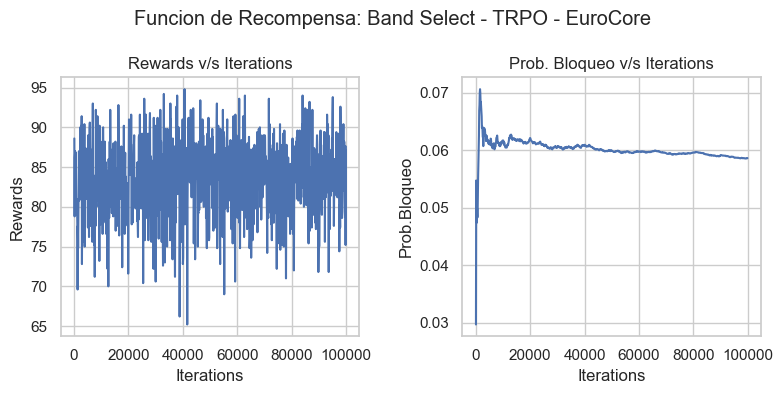

In [8]:
graph_Rewards_Bloqueo(x, rewardsArrayBS_TRPO_Euro, probBloqueoArrayBS_TRPO_Euro, "Band Select", "TRPO", "EuroCore")

### 3) Funcion de Recompensa: Length Based (DONE)

#### 3.1) Data:

In [9]:
episodeRewardsArrayLB_TRPO_Euro=[95, 96, 90, 94, 92, 92, 88, 94, 86, 96, 90, 88, 88, 80, 84, 84, 92, 86, 92, 92, 84, 84, 86, 80, 90, 84, 88, 84, 76, 90, 96, 86, 96, 90, 86, 96, 98, 88, 92, 92, 92, 90, 92, 90, 92, 88, 90, 86, 88, 96, 84, 92, 92, 92, 92, 84, 86, 88, 96, 86, 96, 80, 92, 88, 92, 94, 90, 88, 86, 94, 90, 92, 84, 82, 82, 92, 88, 88, 94, 96, 82, 98, 92, 88, 90, 90, 88, 90, 90, 90, 86, 88, 84, 92, 96, 86, 86, 88, 94, 86, 78, 90, 88, 92, 96, 74, 84, 90, 88, 80, 86, 94, 96, 78, 90, 86, 94, 86, 90, 94, 86, 84, 92, 82, 92, 86, 90, 88, 78, 82, 68, 94, 96, 88, 96, 82, 86, 92, 94, 90, 88, 90, 84, 86, 92, 78, 90, 84, 100, 84, 86, 86, 90, 94, 92, 92, 90, 94, 84, 88, 90, 92, 88, 92, 90, 94, 92, 92, 94, 94, 88, 90, 90, 90, 96, 86, 86, 88, 94, 92, 92, 92, 90, 94, 84, 92, 88, 92, 84, 92, 90, 84, 90, 88, 90, 92, 86, 86, 96, 90, 90, 82, 92, 94, 92, 82, 92, 92, 92, 86, 88, 82, 94, 90, 88, 78, 84, 90, 92, 90, 86, 92, 94, 94, 94, 96, 86, 90, 96, 94, 96, 98, 96, 88, 82, 92, 92, 90, 82, 86, 88, 84, 94, 94, 86, 88, 82, 94, 90, 80, 88, 84, 88, 84, 92, 92, 84, 90, 88, 94, 84, 92, 94, 88, 80, 90, 84, 88, 90, 92, 84, 88, 92, 86, 74, 90, 86, 92, 84, 96, 90, 88, 94, 90, 92, 90, 84, 90, 90, 92, 94, 76, 86, 98, 82, 90, 86, 84, 90, 88, 96, 90, 88, 90, 86, 84, 94, 90, 88, 92, 80, 80, 88, 84, 92, 92, 90, 84, 94, 88, 82, 86, 84, 98, 92, 94, 96, 94, 82, 86, 92, 90, 94, 94, 86, 94, 86, 92, 96, 92, 92, 90, 84, 88, 88, 80, 84, 88, 86, 90, 96, 94, 84, 88, 94, 86, 94, 92, 80, 76, 96, 92, 86, 86, 90, 80, 80, 84, 96, 92, 88, 94, 92, 90, 90, 94, 86, 90, 86, 88, 88, 84, 96, 94, 84, 98, 86, 92, 86, 86, 76, 86, 96, 84, 92, 84, 92, 78, 94, 82, 84, 88, 92, 86, 88, 74, 88, 90, 88, 90, 82, 90, 80, 90, 92, 90, 86, 92, 80, 92, 80, 84, 94, 86, 86, 88, 92, 90, 86, 80, 90, 82, 94, 92, 96, 92, 84, 90, 84, 94, 98, 90, 76, 90, 78, 92, 94, 90, 88, 90, 96, 92, 88, 94, 90, 96, 90, 92, 90, 86, 90, 90, 94, 96, 84, 90, 90, 86, 92, 88, 84, 98, 94, 90, 80, 80, 88, 92, 82, 88, 90, 82, 86, 96, 84, 88, 96, 88, 88, 84, 84, 90, 88, 90, 80, 92, 90, 84, 86, 94, 88, 84, 86, 94, 82, 86, 80, 82, 90, 84, 88, 80, 88, 92, 96, 92, 90, 82, 88, 86, 88, 94, 86, 90, 80, 86, 86, 80, 92, 94, 88, 84, 80, 94, 90, 86, 86, 82, 94, 90, 86, 86, 82, 88, 92, 86, 88, 92, 86, 98, 88, 88, 84, 90, 92, 82, 88, 82, 96, 84, 82, 92, 92, 98, 88, 96, 92, 98, 92, 90, 92, 88, 82, 84, 90, 92, 94, 84, 90, 92, 90, 86, 90, 94, 86, 84, 90, 94, 88, 92, 98, 90, 88, 90, 88, 86, 84, 88, 84, 84, 92, 86, 84, 84, 86, 90, 92, 80, 96, 92, 88, 90, 84, 90, 92, 96, 84, 94, 84, 88, 84, 90, 88, 82, 92, 90, 78, 92, 84, 90, 92, 94, 90, 94, 90, 94, 88, 88, 94, 94, 86, 96, 100, 94, 90, 98, 94, 92, 90, 88, 86, 82, 86, 92, 96, 90, 90, 88, 94, 88, 86, 90, 88, 94, 86, 86, 96, 86, 90, 92, 86, 86, 88, 84, 82, 92, 92, 80, 78, 92, 92, 88, 88, 90, 92, 96, 84, 82, 94, 92, 96, 78, 82, 88, 90, 94, 94, 86, 92, 90, 86, 86, 82, 92, 90, 88, 86, 88, 98, 88, 92, 84, 94, 90, 88, 94, 90, 90, 86, 92, 90, 94, 96, 88, 90, 88, 96, 88, 88, 84, 82, 92, 90, 82, 90, 90, 90, 92, 96, 88, 90, 92, 86, 86, 88, 78, 86, 86, 88, 84, 88, 92, 92, 86, 94, 84, 88, 90, 84, 90, 86, 94, 88, 90, 90, 84, 90, 88, 90, 78, 94, 86, 92, 88, 88, 90, 84, 86, 90, 84, 76, 86, 86, 88, 88, 86, 96, 86, 88, 96, 94, 92, 82, 88, 84, 86, 88, 92, 86, 90, 92, 90, 94, 88, 90, 88, 96, 90, 86, 90, 90, 90, 88, 84, 88, 92, 86, 92, 86, 86, 94, 92, 88, 92, 94, 88, 88, 94, 82, 90, 96, 82, 94, 86, 88, 94, 90, 86, 90, 86, 86, 96, 92, 96, 90, 92, 88, 84, 92, 84, 82, 96, 88, 82, 88, 84, 88, 82, 90, 90, 86, 86, 92, 84, 90, 82, 90, 90, 90, 88, 88, 86, 80, 82, 82, 92, 94, 98, 86, 90, 80, 84, 88, 92, 86, 96, 88, 90, 88, 90, 84, 96, 92, 82, 90, 92, 90, 94, 86, 78, 94, 92, 96, 96, 96, 92, 90, 92, 82, 90, 94, 88, 94, 98, 82, 86, 92, 94, 84, 84, 88, 84, 76, 92, 92, 88, 90, 88, 92, 92, 88, 90, 88, 90, 90, 98, 84, 92, 90, 88, 96, 88, 88, 90, 90, 84, 88, 92, 90, 92, 86, 84, 86, 88, 88, 90, 88, 92, 90, 94, 86, 86, 86, 94, 82, 82, 88, 90, 84, 96, 86, 78, 92, 96, 80, 92, 88, 96, 94, 96, 96, 92, 90, 94, 92, 94, 90, 96, 90, 88, 90, 92, 90, 92, 88, 84, 86, 92, 82, 92, 94, 96, 88, 82, 84, 88, 96, 90, 84, 88, 96, 92, 90, 88, 86, 86, 90, 86, 86, 90]
rewardsArrayLB_TRPO_Euro=[0, 88, 78, 84, 88, 88, 82, 86, 78, 86, 90, 92, 94, 86, 92, 94, 96, 86, 96, 90, 92, 96, 90, 90, 90, 92, 90, 82, 94, 88, 90, 88, 94, 90, 90, 94, 82, 86, 92, 94, 88, 88, 86, 86, 94, 94, 90, 90, 88, 90, 90, 88, 92, 80, 84, 88, 88, 88, 96, 94, 88, 88, 96, 88, 90, 94, 88, 84, 96, 88, 84, 92, 84, 86, 96, 94, 80, 88, 94, 90, 82, 80, 94, 86, 98, 82, 80, 86, 88, 92, 78, 90, 94, 88, 86, 86, 88, 90, 86, 94, 92, 84, 88, 88, 84, 94, 86, 88, 84, 80, 74, 84, 92, 92, 90, 90, 82, 92, 92, 96, 88, 84, 92, 82, 88, 86, 82, 92, 90, 92, 88, 86, 84, 92, 96, 92, 92, 88, 90, 86, 92, 86, 98, 86, 92, 88, 98, 88, 94, 94, 90, 88, 88, 90, 94, 92, 84, 90, 92, 96, 92, 88, 88, 98, 84, 90, 92, 88, 88, 88, 94, 84, 82, 92, 94, 88, 88, 84, 92, 94, 92, 86, 84, 96, 92, 86, 88, 90, 92, 92, 86, 88, 86, 94, 86, 82, 80, 88, 92, 90, 96, 82, 94, 94, 94, 96, 88, 88, 92, 98, 92, 100, 96, 92, 86, 90, 90, 90, 84, 90, 82, 88, 88, 94, 90, 82, 86, 90, 92, 86, 82, 84, 92, 82, 86, 98, 90, 82, 94, 88, 90, 88, 90, 94, 84, 84, 86, 84, 90, 94, 88, 88, 86, 94, 74, 82, 88, 86, 90, 90, 94, 88, 94, 92, 92, 88, 90, 86, 88, 96, 90, 88, 74, 94, 96, 84, 88, 82, 86, 90, 92, 92, 92, 90, 82, 94, 84, 90, 90, 88, 82, 90, 84, 86, 82, 92, 90, 90, 90, 92, 82, 86, 82, 94, 96, 92, 94, 94, 88, 86, 88, 90, 96, 92, 86, 94, 90, 84, 98, 92, 94, 90, 90, 86, 86, 86, 84, 80, 88, 94, 88, 96, 90, 84, 92, 94, 86, 94, 82, 80, 88, 92, 88, 84, 92, 82, 86, 78, 88, 98, 88, 92, 90, 92, 94, 90, 88, 92, 88, 78, 90, 90, 92, 94, 86, 94, 94, 86, 92, 82, 86, 78, 90, 96, 82, 88, 86, 84, 90, 88, 78, 86, 92, 88, 90, 78, 84, 90, 86, 94, 86, 84, 88, 80, 94, 90, 88, 84, 88, 88, 84, 88, 84, 90, 88, 88, 92, 86, 86, 86, 88, 84, 88, 94, 90, 98, 86, 90, 86, 84, 98, 98, 78, 82, 90, 84, 92, 90, 88, 90, 94, 92, 92, 88, 94, 92, 96, 88, 92, 90, 92, 90, 86, 98, 92, 82, 90, 86, 92, 92, 82, 94, 96, 92, 86, 74, 88, 88, 90, 88, 88, 80, 86, 94, 88, 86, 92, 90, 94, 82, 88, 88, 86, 86, 88, 82, 96, 84, 88, 88, 92, 84, 84, 88, 92, 78, 88, 86, 78, 90, 86, 82, 84, 88, 98, 92, 92, 92, 78, 88, 84, 94, 94, 80, 90, 80, 90, 78, 90, 92, 90, 86, 84, 86, 90, 94, 86, 86, 86, 86, 90, 88, 78, 92, 88, 94, 82, 92, 90, 88, 92, 94, 82, 86, 92, 86, 86, 84, 88, 88, 84, 90, 92, 96, 94, 90, 94, 96, 96, 92, 88, 96, 80, 80, 88, 94, 90, 94, 84, 90, 92, 88, 84, 96, 88, 84, 88, 92, 94, 88, 96, 92, 88, 94, 90, 88, 86, 78, 90, 86, 86, 88, 86, 82, 86, 84, 98, 80, 90, 92, 94, 86, 86, 90, 88, 98, 90, 86, 88, 92, 86, 84, 86, 86, 88, 94, 82, 84, 88, 86, 90, 96, 90, 92, 92, 94, 90, 88, 90, 92, 96, 88, 98, 96, 92, 94, 98, 92, 90, 92, 88, 80, 86, 86, 96, 92, 92, 88, 88, 94, 86, 90, 92, 88, 90, 82, 92, 92, 88, 94, 90, 82, 86, 84, 86, 88, 90, 88, 78, 82, 94, 88, 88, 96, 88, 94, 88, 88, 84, 96, 92, 84, 88, 80, 86, 96, 92, 92, 90, 90, 88, 86, 82, 88, 96, 88, 82, 88, 92, 94, 92, 82, 92, 96, 86, 90, 94, 88, 90, 88, 92, 92, 92, 88, 98, 88, 92, 88, 92, 86, 82, 86, 92, 84, 86, 92, 88, 90, 96, 98, 86, 88, 86, 88, 88, 82, 86, 84, 90, 82, 88, 88, 92, 88, 88, 90, 88, 88, 88, 84, 88, 92, 92, 90, 90, 84, 90, 88, 86, 88, 84, 92, 84, 92, 90, 88, 92, 80, 88, 86, 78, 86, 88, 86, 90, 84, 88, 94, 90, 86, 100, 90, 82, 94, 80, 86, 84, 92, 88, 92, 90, 96, 88, 88, 90, 94, 86, 96, 82, 94, 92, 88, 90, 88, 84, 92, 86, 86, 94, 82, 92, 88, 94, 90, 92, 90, 92, 88, 96, 82, 92, 86, 88, 90, 88, 90, 94, 88, 86, 90, 86, 92, 92, 96, 94, 86, 94, 88, 86, 86, 82, 92, 88, 84, 84, 90, 90, 82, 86, 90, 90, 82, 92, 88, 86, 86, 84, 90, 90, 94, 82, 94, 74, 86, 82, 84, 94, 96, 94, 86, 86, 82, 88, 88, 90, 92, 90, 86, 92, 88, 86, 92, 96, 88, 82, 92, 92, 92, 88, 78, 90, 94, 96, 94, 94, 94, 94, 92, 88, 84, 92, 88, 92, 96, 94, 78, 96, 90, 90, 78, 92, 80, 86, 82, 94, 88, 90, 86, 92, 94, 88, 88, 90, 88, 92, 94, 88, 90, 90, 90, 90, 98, 86, 88, 90, 86, 88, 86, 92, 90, 92, 80, 86, 88, 92, 88, 88, 92, 88, 94, 84, 94, 80, 94, 84, 84, 88, 88, 86, 90, 88, 86, 84, 92, 88, 90, 90, 90, 98, 92, 96, 94, 94, 88, 94, 94, 90, 94, 90, 90, 92, 90, 92, 90, 92, 84, 84, 88, 90, 86, 96, 94, 92, 82, 86, 84, 92, 96, 82, 84, 96, 94, 90, 92, 84, 82, 94, 90, 84, 82]
probBloqueoArrayLB_TRPO_Euro=[0.0, 0.0594059405940594, 0.0845771144278607, 0.08305647840531562, 0.0773067331670823, 0.07385229540918163, 0.07653910149750416, 0.07560627674750357, 0.07990012484394507, 0.07880133185349611, 0.07592407592407592, 0.07266121707538602, 0.06910907577019151, 0.06917755572636433, 0.06709493219129194, 0.06462358427714857, 0.06183635227982511, 0.06231628453850676, 0.059966685174902834, 0.05944239873750658, 0.05847076461769116, 0.05663969538315088, 0.056338028169014086, 0.0560625814863103, 0.0558100791336943, 0.055177928828468614, 0.05497885428681276, 0.05627545353572751, 0.05533737950731882, 0.055498104102033784, 0.055314895034988334, 0.05546597871654305, 0.05467041549515776, 0.0545289306270827, 0.054395765951190826, 0.0536989431590974, 0.0547070258261594, 0.05512023777357471, 0.054722441462772956, 0.05408869520635735, 0.054236440889777554, 0.05437698122409169, 0.054748869316829325, 0.05510346431062543, 0.054533060668029994, 0.0539880026660742, 0.05390132579873941, 0.0538183365241438, 0.05394709435534264, 0.053866557845337684, 0.05378924215156969, 0.053910997843560085, 0.053643530090367236, 0.05451801546877948, 0.054989816700611, 0.05508089438283948, 0.05516871987145153, 0.05525346430450798, 0.0546457507326323, 0.05422809693272327, 0.054324279286785536, 0.05441730863792821, 0.053862280277374615, 0.05395968893826377, 0.05389782846430245, 0.0535302261190586, 0.053628238145735495, 0.05402178779286674, 0.053521540949860315, 0.053615418055354296, 0.05399228681616912, 0.05379524010702718, 0.0541591445632551, 0.05437611286125189, 0.053911633563032024, 0.053592854286095185, 0.05420339429022497, 0.05427866510842748, 0.053967440071785666, 0.05391722566763701, 0.05436820397450319, 0.05493148993951364, 0.05462748445311547, 0.054812673171907, 0.054279252469944056, 0.05469944712386778, 0.055226136495756306, 0.05539593150212619, 0.055448244517668444, 0.05527468823727671, 0.05588267970225531, 0.05581804197340952, 0.05553744158243669, 0.055585420922481456, 0.0557387511966812, 0.055888853804862644, 0.05593167378398083, 0.05587052881146273, 0.05601469237832874, 0.055751944248055754, 0.055594440555944404, 0.05583605583605584, 0.055876874816194494, 0.05591690127172119, 0.05614844726468609, 0.05589943814874774, 0.05603244976888973, 0.0560695262125035, 0.056291084158874176, 0.05669204660122924, 0.05735842196163985, 0.05756238176740834, 0.05740558878671547, 0.05725157065746394, 0.057187965967897554, 0.05712546735066516, 0.057408844065166796, 0.05726006324245791, 0.05711380391492246, 0.05680194941601546, 0.05682859761686526, 0.057020080985042555, 0.0568805835587247, 0.057149825217461994, 0.057172808644464154, 0.05727541796656267, 0.057535116260614236, 0.05739705534997244, 0.057339270369502385, 0.05720486783970235, 0.05722636720252288, 0.057323868406991836, 0.05749564426937353, 0.05736410796180738, 0.05708529214237743, 0.05695874379675579, 0.05683405631938828, 0.05685716371067805, 0.05680747771900587, 0.05690238112366017, 0.05678165845296765, 0.05687539890787888, 0.056545313710302095, 0.056639395846444306, 0.05652385251024234, 0.056547824287980136, 0.05622902540921855, 0.05625467655261547, 0.05607729207485981, 0.05590228843701765, 0.05586294247050197, 0.05589033838818621, 0.055917373856983095, 0.05587870073851382, 0.05571066813843257, 0.05560931552803045, 0.05576565604768925, 0.05572893446277307, 0.05562939054490222, 0.055405320420099366, 0.05530904318480095, 0.0553381777529346, 0.05536695265724338, 0.05508864486841298, 0.05524053411377355, 0.0552087752257439, 0.05511716161677008, 0.05514639841925633, 0.05517528718528659, 0.055203834092657236, 0.05505558496559026, 0.0552014502075902, 0.055403755595604905, 0.05531472169238772, 0.05516924314694558, 0.05519684589452031, 0.05522413499232998, 0.05536410372295351, 0.05527779338239425, 0.05513658454834926, 0.05505249708349536, 0.05513507541019833, 0.055271688368770944, 0.05507895743402, 0.05499701103200913, 0.05507810388627642, 0.055104564270738135, 0.05507726859526228, 0.05499707462369023, 0.054917729220676156, 0.05499710541550445, 0.05502329720957018, 0.05510129680745794, 0.05497124501321175, 0.05504870882944178, 0.055227937028870314, 0.0554563542676394, 0.055479417288462514, 0.05540124236149689, 0.05537410180392945, 0.0551972401379931, 0.05537037958310532, 0.05524478986188803, 0.055120437416876014, 0.054997304053722856, 0.05482659382469148, 0.054851706227853014, 0.054876576010820736, 0.0548050574491611, 0.054590689440696616, 0.054521213275558304, 0.05426283114544334, 0.05410122164048865, 0.05403502182996103, 0.05410962104574553, 0.05409050741825962, 0.05407157076061293, 0.054052808626330585, 0.05417182698041374, 0.05415277841194466, 0.0543157129221399, 0.054341432514365864, 0.054366920408990584, 0.05425765660732702, 0.05423865006026517, 0.05439758232967424, 0.05446661652139286, 0.0544469406634069, 0.05438357966755844, 0.05445177066503646, 0.05460632146428416, 0.05471624604995455, 0.054652816688935825, 0.0548045148276898, 0.05486945002350327, 0.054678524318114125, 0.05465870090250413, 0.05480781401628623, 0.05470358388303012, 0.054725743692732524, 0.05470605391442023, 0.05472801958424962, 0.05470848312053221, 0.054606806304267314, 0.054710872505225196, 0.05481408922084813, 0.05487581805617658, 0.05497753127403749, 0.05495746139268578, 0.05485723464921088, 0.054877804887804485, 0.05489821122664436, 0.05495813658188167, 0.054859491719694876, 0.05515530884610842, 0.05529194933532018, 0.05531033943986563, 0.055367495428193456, 0.05534669198868261, 0.05532604918729007, 0.05522864505211338, 0.05524692540515689, 0.0551505667722606, 0.055092962244781565, 0.05503579409870838, 0.05505452624429267, 0.0550355249802639, 0.05509156960413468, 0.05510988395955375, 0.054979368796699006, 0.054960927373060256, 0.05497952105088373, 0.05525532149553325, 0.055162814548917624, 0.055034487792416334, 0.05512526817206647, 0.05514292960399986, 0.05526876286054655, 0.0553217510161505, 0.055302677323393425, 0.055248026856183706, 0.055193765346428954, 0.05513988865643062, 0.05512172714745062, 0.055244533643181576, 0.05515595944001965, 0.055242823677493794, 0.05522455663565729, 0.055206416443873474, 0.055223002664267676, 0.05534291920968242, 0.05532455929349507, 0.055409061333515974, 0.055458858059451895, 0.05557634094078433, 0.05552354157486187, 0.05550488159183811, 0.055486347261034984, 0.05546793731753968, 0.055416206815825556, 0.05553148228392387, 0.055579548852197604, 0.055693520082116484, 0.05560872578462757, 0.05549159567119503, 0.055440805219501, 0.05535766805006372, 0.05527507247320934, 0.05529041264893997, 0.05533801495097246, 0.055353053127318474, 0.055335841291276805, 0.055222589019582706, 0.055173956103638865, 0.05522117130027706, 0.05514110663153551, 0.055124837821587926, 0.05520330588940412, 0.055061161598691864, 0.05501394940597473, 0.05493578325677322, 0.05492040746394193, 0.054905127169963666, 0.05495185907557042, 0.05499830252152711, 0.05504446017045629, 0.05512100855801969, 0.05525824898321152, 0.055272705100454254, 0.05519589070241026, 0.05521044816823733, 0.05510407540557687, 0.055088702147525676, 0.05516350860334524, 0.05511811023622047, 0.05504313304080475, 0.055087646201005924, 0.05501320435595383, 0.055116712523298125, 0.055249107695938174, 0.05526308049763242, 0.05521832204334184, 0.05523230314903073, 0.055304510072592634, 0.05526002151100259, 0.055360714182197616, 0.055403023034016355, 0.05556035849110977, 0.05557311571506566, 0.05544253746310994, 0.05545555841261678, 0.05541152673713, 0.05539615351836596, 0.055352539588113654, 0.05528092426767606, 0.05526604884369454, 0.05527934608578411, 0.05523654799585446, 0.05524985335605151, 0.05540235648032088, 0.05538735035137913, 0.05537242735658292, 0.05532996326068341, 0.05526018566981626, 0.05530067855278701, 0.05523136352428701, 0.0551624272560859, 0.055202855508024305, 0.055161544523246654, 0.055255955123167395, 0.055295802816140105, 0.055443249508099514, 0.05542861751028198, 0.05533363716790435, 0.0554263254993182, 0.05543852163942295, 0.05547724794553336, 0.05554229330786982, 0.05552763154413905, 0.05553943167726445, 0.05568274519091603, 0.055720322301251936, 0.05567917070233763, 0.05569045194642438, 0.05567563344704565, 0.05581673203293421, 0.05587938136317712, 0.05586418955582543, 0.055900621118012424, 0.05583404025603455, 0.05587036229840261, 0.05593207334850771, 0.05594245044769266, 0.056054553319253964, 0.05598842668967793, 0.055973266499582286, 0.05598343476174844, 0.05604392836452482, 0.056053867993266504, 0.05606375780055638, 0.05612359691007725, 0.05613326350963816, 0.056192632024079, 0.056177266072802164, 0.05618672805128586, 0.05619614330510358, 0.05615625230905643, 0.056190265595439916, 0.05622411215411387, 0.05625779320799002, 0.05626692031901661, 0.05632466363348824, 0.056333584136307374, 0.05626982397520641, 0.05625467983865124, 0.05614322546444664, 0.056176534217927454, 0.05616172274046186, 0.05619482787493122, 0.05625164077229661, 0.056141520439989524, 0.05603192323222726, 0.05615980663965309, 0.0562398052055507, 0.05622508903091908, 0.05628102868167808, 0.056242811201614985, 0.056228191377251116, 0.056237003808322236, 0.05622246567679075, 0.05616148461663682, 0.05612398784250945, 0.05608666466054026, 0.0560957021777788, 0.0560355752171609, 0.05599871267327188, 0.0559161487121855, 0.055925493695796434, 0.05588913495125682, 0.05587572037083438, 0.05583964000818163, 0.05582639849436521, 0.05585846474061673, 0.05575494909821449, 0.055719465777797794, 0.05579649895507966, 0.055783502612049056, 0.05581530614527639, 0.055780004910604676, 0.05574486091623795, 0.05582098175596098, 0.05576373029422851, 0.05568460874759408, 0.05564998565153087, 0.05568159291645559, 0.055844926485132194, 0.05585403828863402, 0.05586311021640664, 0.055850308945219536, 0.05585934946951047, 0.05586835068802852, 0.0559640788703065, 0.055994458994394064, 0.05593831666702663, 0.055947070106247714, 0.0559772908109503, 0.05594300551490311, 0.0559302798655275, 0.05587487446849426, 0.05594763437879789, 0.055956256249867026, 0.05596484151079595, 0.055994576386093516, 0.05602418553518953, 0.05603257315246514, 0.05610408201932591, 0.05602823470095166, 0.0560784889205677, 0.05608669274701366, 0.05609486232020208, 0.056061332055582176, 0.05611109956133968, 0.05616066056720815, 0.056168609345562205, 0.056135203818102934, 0.056246262963650234, 0.05625398654348676, 0.05628221186423277, 0.056392287043298295, 0.05637921514897446, 0.056407012101793844, 0.05647542819901835, 0.05652324139753257, 0.05653029350317438, 0.056436104532296916, 0.05640290095149593, 0.05636983125340215, 0.056336894629886725, 0.0564446497058292, 0.0564517745135368, 0.05649887002259955, 0.05644597912217321, 0.05639329893826816, 0.05647999045744617, 0.056467133588619274, 0.05655333557751332, 0.05654038457737989, 0.056645825526123746, 0.05663274344993209, 0.05660006679633013, 0.0565871257426325, 0.056613373515195395, 0.056659049627936955, 0.056685054872224715, 0.05667204918192253, 0.056620259800780566, 0.05664618902734443, 0.056672017949362684, 0.05669774714773846, 0.056723377198897904, 0.056710447876002386, 0.05671676167444003, 0.05681883488822053, 0.056786677118984344, 0.05679280929753249, 0.0567417763471172, 0.056805003707153856, 0.05677311625965352, 0.05676028863089714, 0.056766412733218655, 0.056734778589083226, 0.0566844315549613, 0.056747053626811525, 0.05677191797527251, 0.05674051047733188, 0.05676529410665221, 0.056789985261469, 0.056833206085547754, 0.05683909221018197, 0.05684495649431365, 0.05688783541045536, 0.05687510397220014, 0.0568439696684563, 0.05677611830353032, 0.05672689840260289, 0.05671455569622576, 0.05666562883463673, 0.056598599659969655, 0.056531815112862906, 0.05650170306551793, 0.056508063489754734, 0.056441806863759277, 0.056520715204434704, 0.05659933816748341, 0.056605476435443405, 0.05655753950379273, 0.056545745580115464, 0.056498088005601334, 0.05654020537266357, 0.0565285057512388, 0.05649899108944483, 0.05650523163579972, 0.056547036529599116, 0.05648212287525976, 0.05648836013545859, 0.05652997292083326, 0.05653610360240985, 0.056506939912876315, 0.056460273586732626, 0.0564664944377076, 0.056402519254048177, 0.0563737938039614, 0.056380133214454294, 0.056334095391005395, 0.0563230605738576, 0.05632945513991061, 0.056353188312702904, 0.05644616211157519, 0.05643500977491739, 0.05645843767810573, 0.05648178479681385, 0.056487840140445084, 0.056511056511056514, 0.056568497967444814, 0.05659149672094656, 0.056631510572468846, 0.056551935973788846, 0.05662595185771963, 0.0566146834237513, 0.056586475611619495, 0.05654141455229572, 0.05656418673118898, 0.05658688197834496, 0.056575774438879615, 0.05658153903132944, 0.056503252046184095, 0.056492340732538046, 0.05651496624847155, 0.056520793966656074, 0.056493213802774576, 0.05651572473792103, 0.056554799420974695, 0.05657713327021146, 0.05659939304489146, 0.056605023095644115, 0.05656104857770946, 0.05661622745499249, 0.05665475033360241, 0.056660252298481935, 0.05668215628643208, 0.0566712021114408, 0.05661118475966023, 0.05660038234669368, 0.05657330222997994, 0.05654631032067882, 0.05650314629030422, 0.05649258940601613, 0.056498273933971895, 0.05648775909774923, 0.0564611234067301, 0.05640231609167594, 0.05640810937021948, 0.05633349946142345, 0.05627518017367297, 0.056249098572138265, 0.05620710068638902, 0.05613328860561333, 0.05610755809317236, 0.05609783283705674, 0.05607224050492043, 0.056078474944842145, 0.05614808006212263, 0.05616999731016914, 0.05619184531050062, 0.0561347612813678, 0.056109352608620336, 0.056084023836103204, 0.05609017126889688, 0.0560962994310434, 0.05605546079091094, 0.05607724879298761, 0.05606776805354051, 0.05604274076727777, 0.05604889504051259, 0.05603950249219733, 0.05609215361002155, 0.05606724354112166, 0.05604241047279022, 0.056048517769787504, 0.05600838199719573, 0.055999138474792695, 0.056051366338458704, 0.056072759620251225, 0.0561094010811473, 0.05613064020427822, 0.05613654753362544, 0.05612719318303075, 0.056133087776441756, 0.056214951140560174, 0.0562662175080803, 0.05622642081180588, 0.05623212961982421, 0.05623782118094893, 0.05618316465814995, 0.05618891281757805, 0.05614953158599119, 0.05615531298328854, 0.05616107704532166, 0.05619676352150417, 0.05614265855517855, 0.05611856539454635, 0.056154155675772345, 0.05615987857323552, 0.056225018944740794, 0.05624545629886797, 0.05619176012207226, 0.05616780816851822, 0.056143926973013694, 0.05613486526747393, 0.056125830252868145, 0.056131527477537094, 0.05615189204270128, 0.056201521971818595, 0.05620708335163468, 0.05615414979313168, 0.056159764091035166, 0.05620909316190726, 0.05621461114103143, 0.056191043734829436, 0.05615303116065079, 0.05612962130983609, 0.056178637067480934, 0.05615525787199607, 0.056103086535547825, 0.056123110618002625, 0.056114300513661675, 0.05607678050602721, 0.05608240914764494, 0.0560736952192662, 0.0560793121700691, 0.056056342052256396, 0.05603343746879502, 0.05601059813962764, 0.056016272883742765, 0.05595090978821324, 0.05595665309711919, 0.05593405192561012, 0.05593980283164312, 0.05591728930382339, 0.05593715180321857, 0.055985126970042674, 0.056004838187929847, 0.05598235979831744, 0.05601604465575518, 0.05603562975308469, 0.056013202612550876, 0.056018770687560226, 0.05601037642431765, 0.055960223395217334, 0.05589630185950126, 0.05591589005708254, 0.055921554486068156, 0.05594105344801319, 0.055946667404323594, 0.05595226585268159, 0.05599922759686073, 0.056018512141706035, 0.056051498603870646, 0.0560431862199695, 0.056089765572488716, 0.05609512198463035, 0.05610046374194608, 0.056078468873376044, 0.056083818774641546, 0.056089154098718, 0.056080869648032, 0.056086194481053245, 0.05609150486424879, 0.05609680085635696, 0.05612914574904264, 0.05613437656247888, 0.056112603068784496, 0.056090888262961415, 0.05608269067711067, 0.05607451512748485, 0.056106629441215555, 0.056098443720593555, 0.05610366661758209, 0.05612224435502199, 0.05612742152975261, 0.056159251209983864, 0.05613773451751641, 0.05616946583157139, 0.0561479927225402, 0.05613983899417779, 0.056144951722493744, 0.05612359624872687, 0.0561815563863093, 0.05618659384440838, 0.05620479308573009, 0.05627557532137735, 0.05629360980801829, 0.056298473773310063, 0.056316430977313536, 0.05630816350571328, 0.05633913282179318, 0.056343911959373896, 0.05630956571622273, 0.05630135024283538, 0.05631916359995319, 0.05624602277892495, 0.05623792168713765, 0.05628165438271525, 0.05624765526966016, 0.05630418211651012, 0.056321853911562435, 0.05635236659321401, 0.05633132134721561, 0.05633603681186617, 0.0563150665588375, 0.05630697042345611, 0.05626048322044532, 0.05626526515006202, 0.0562700348654551, 0.05626203747401181, 0.05622858307537484, 0.05624610373913818, 0.056200048284011636, 0.05624294107942793, 0.05620968048567192, 0.056189162162504275, 0.056193979848548056, 0.056186159265665836, 0.05619096858803798, 0.05622095439604035, 0.056200550936466205, 0.056217886709965956, 0.056235178981443146, 0.05620230322928284, 0.056244602695836095, 0.05622429719628504, 0.05622901087377186, 0.05619630677921722, 0.05618859042851272, 0.05616845561622368, 0.056160793033626914, 0.056140742670686465, 0.05614552483860175, 0.056100790831796636, 0.05614269292097749, 0.05612276391649486, 0.05613987497071553, 0.05614462876072955, 0.05613707088473697, 0.05614181643960148, 0.05613428056097471, 0.056102253648852345, 0.05610702439382627, 0.05612400826395765, 0.056116530933688236, 0.05613346178705138, 0.05611381103762439, 0.056094208099658156, 0.056050351757572815, 0.05601873763667917, 0.056035684415946474, 0.05600416459849154, 0.05600899626364857, 0.05602589340708446, 0.05604274978588919, 0.05608366164263081, 0.05606430728872095, 0.05606903763175923, 0.056097765933182074, 0.05612642534262179, 0.056119088394150966, 0.05611176899797849, 0.0561522562454451, 0.0561687808021384, 0.056161428350079264, 0.056154093403649956, 0.056194337760549815, 0.05617510480873149, 0.05617964199712933, 0.056196016634873995, 0.056212352516538264, 0.056240469970804126, 0.05623310232464788, 0.056225752054810674, 0.05619486225132802, 0.056234632533734896, 0.056203804890659334, 0.056290419126536075, 0.05630649113140526, 0.05634594442688025, 0.05637360966538403, 0.056342799733647975, 0.05630039322761695, 0.056269740445915546, 0.0562857242639783, 0.05630167091080336, 0.05634080904983682, 0.05634505400169371, 0.056349289116000977, 0.05634194048679992, 0.05632304828845909, 0.056315746931328736, 0.0563315302014971, 0.056312715291298485, 0.0563169583779243, 0.05633268583119734, 0.05631393439799773, 0.056272290455384684, 0.056276560405951824, 0.05631514513563918, 0.0562964994685775, 0.05627789637104599, 0.056259335697426485, 0.05626359608660494, 0.05632472895643963, 0.056317541846115385, 0.05628766983348657, 0.05624652781714493, 0.0562168038867057, 0.05618714720421715, 0.05615755754172269, 0.056128034672294894, 0.056109852200087934, 0.056114232947827164, 0.0561411007750194, 0.056122964910506626, 0.05612731619173747, 0.05610923644353763, 0.05606880102126516, 0.05603964161474704, 0.05609993184433693, 0.0560596421914934, 0.05605288681285604, 0.05604614647943787, 0.05610616122178841, 0.05608826568593682, 0.05613700180908092, 0.056152370816288065, 0.056189853932957556, 0.05616088317607106, 0.05616512524723484, 0.05615832054833832, 0.05617358132765901, 0.0561557692095902, 0.05612699530258193, 0.05613125130493071, 0.05613549796379842, 0.056128770517867126, 0.05613301059134073, 0.056115359788186124, 0.056086818723292645, 0.05609109070861672, 0.05608444837024678, 0.05607782050304463, 0.05607120705977084, 0.05606460799339138, 0.056014592675432406, 0.05602976106549821, 0.05603406246952904, 0.05602753216956526, 0.056042637376893224, 0.056046910940486604, 0.05606196265412455, 0.056044654691220996, 0.05603814813618799, 0.056020903001043, 0.05606814105111653, 0.056083089237239946, 0.05608728738170009, 0.05607006348968426, 0.056074266585384114, 0.056078460700206195, 0.05606130137351789, 0.05606550036779992, 0.05603774187708331, 0.056063233369857766, 0.0560355362854805, 0.056082207195252705, 0.056054548732250985, 0.05607991440768636, 0.05610522639972064, 0.05610934345302904, 0.056113451811490904, 0.05612809991455786, 0.05612164255381924, 0.0561257249923685, 0.05614031398197706, 0.056165376414113295, 0.056148413972571115, 0.056152451232167375, 0.05614600894231474, 0.05613958012991496, 0.05613316475271941, 0.056085009551048524, 0.056068237036110156, 0.05603066634722555, 0.0560035795673302, 0.0559765491003212, 0.055980727095253424, 0.055953776413107746, 0.05592688158671931, 0.055920746162048014, 0.05589394111746518, 0.05588785239821903, 0.055881776245859174, 0.05586540344944897, 0.055859362931380725, 0.055843046882233724, 0.055837041757022025, 0.05582078212749356, 0.05584558107096337, 0.05587032919744675, 0.055874556043438654, 0.055868549401335364, 0.05588298383060439, 0.055846368914602915, 0.055820022221995697, 0.05580391238378428, 0.05583869950458286, 0.05585309092387272, 0.05587760530349946, 0.05586150241883957, 0.05582516894459023, 0.05585975850446858, 0.05588416699527811, 0.05584792072807345, 0.05582183832655574, 0.05581596959708068, 0.05580004229564657, 0.05582438808462691, 0.05585873508808957, 0.05583277276332567, 0.05582692249826983, 0.05585114377611447, 0.05588532647320848]


#### 3.2) Rewards & Prob. Bloqueo (LB):

Rewards Stats w/  Length Based  :
Avg =  88.734
Std =  5.316506747856152
Min-Max Reward = 74 - 100
Last Prob Bloqueo = 0.05588532647320848


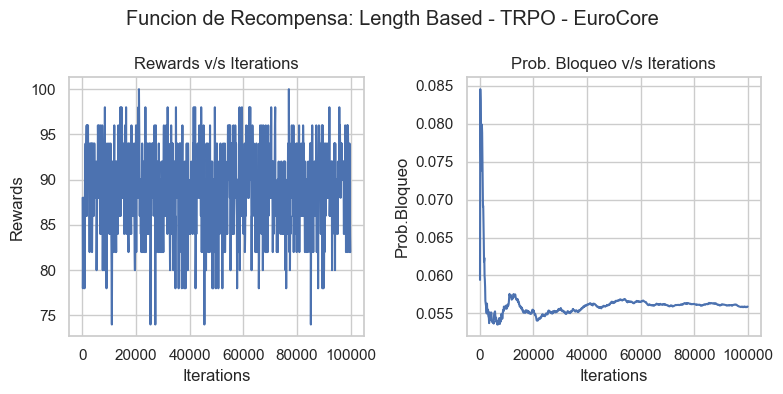

In [10]:
graph_Rewards_Bloqueo(x, rewardsArrayLB_TRPO_Euro, probBloqueoArrayLB_TRPO_Euro, "Length Based", "TRPO", "EuroCore")


## Agente TRPO - Topologia NSFNet:

### 1) Funcion de Recompensa: Caso Base ()

#### 1.1) Data:

In [11]:
episodeRewardsArraysCB_TRPO_NSFNet=[93, 90, 90, 90, 78, 88, 84, 78, 70, 86, 84, 80, 90, 92, 90, 80, 96, 72, 90, 80, 84, 90, 86, 82, 88, 88, 90, 74, 82, 88, 84, 88, 88, 86, 74, 72, 88, 92, 84, 78, 74, 80, 82, 90, 84, 74, 84, 92, 80, 78, 86, 78, 84, 84, 90, 94, 82, 82, 88, 80, 90, 88, 98, 88, 90, 80, 78, 76, 86, 84, 92, 76, 88, 82, 78, 84, 84, 90, 80, 88, 84, 90, 92, 82, 92, 82, 78, 88, 78, 80, 84, 82, 80, 82, 90, 70, 90, 82, 74, 92, 84, 84, 82, 84, 84, 74, 76, 86, 82, 86, 80, 86, 76, 86, 86, 88, 92, 94, 82, 88, 80, 86, 84, 82, 74, 80, 82, 76, 90, 80, 82, 82, 84, 86, 92, 84, 88, 86, 70, 88, 84, 90, 82, 84, 80, 70, 88, 92, 92, 82, 86, 86, 84, 96, 78, 78, 78, 78, 86, 78, 84, 82, 84, 88, 82, 82, 90, 88, 94, 86, 86, 92, 78, 74, 82, 86, 82, 84, 90, 84, 78, 80, 86, 90, 86, 76, 86, 80, 74, 90, 88, 82, 86, 76, 84, 80, 96, 76, 82, 86, 86, 72, 86, 92, 86, 86, 78, 90, 88, 90, 78, 92, 82, 86, 74, 80, 82, 94, 80, 78, 90, 88, 88, 84, 88, 86, 80, 78, 86, 80, 88, 86, 90, 84, 88, 74, 84, 74, 90, 88, 82, 76, 86, 90, 90, 82, 80, 68, 84, 84, 88, 82, 76, 94, 86, 86, 82, 80, 78, 84, 92, 80, 90, 88, 82, 92, 88, 88, 86, 92, 92, 88, 86, 84, 80, 88, 80, 84, 86, 88, 80, 90, 80, 80, 84, 86, 86, 92, 86, 86, 76, 80, 90, 84, 70, 92, 86, 82, 90, 86, 90, 86, 82, 80, 80, 88, 88, 86, 86, 84, 88, 88, 84, 82, 84, 88, 80, 92, 90, 78, 80, 92, 90, 94, 86, 86, 84, 74, 80, 84, 84, 78, 86, 74, 76, 84, 84, 88, 92, 90, 92, 88, 82, 92, 86, 92, 84, 86, 96, 76, 86, 90, 72, 90, 90, 80, 90, 90, 88, 78, 88, 70, 86, 72, 90, 76, 82, 72, 92, 88, 84, 84, 74, 82, 88, 90, 84, 90, 80, 92, 84, 84, 90, 90, 82, 90, 88, 92, 86, 80, 80, 76, 90, 86, 90, 82, 84, 86, 86, 72, 84, 86, 78, 82, 74, 84, 92, 82, 80, 86, 84, 84, 88, 88, 90, 82, 80, 78, 84, 88, 80, 80, 86, 90, 80, 84, 98, 90, 86, 84, 82, 82, 88, 82, 88, 78, 76, 86, 84, 92, 92, 84, 86, 90, 88, 82, 86, 86, 68, 86, 82, 76, 84, 88, 86, 86, 90, 82, 80, 92, 78, 76, 84, 86, 80, 92, 88, 82, 88, 82, 84, 90, 88, 94, 82, 84, 86, 82, 82, 92, 84, 78, 90, 88, 82, 86, 74, 84, 78, 80, 84, 90, 86, 76, 86, 76, 88, 88, 88, 82, 80, 86, 80, 86, 88, 92, 80, 78, 84, 80, 90, 82, 82, 82, 82, 78, 86, 84, 92, 76, 86, 84, 92, 88, 84, 96, 86, 90, 84, 76, 88, 82, 78, 84, 88, 90, 72, 86, 92, 82, 86, 82, 76, 82, 90, 78, 86, 88, 82, 76, 92, 88, 88, 88, 88, 84, 90, 80, 86, 88, 80, 82, 84, 80, 82, 88, 86, 86, 80, 84, 82, 76, 94, 88, 88, 82, 80, 72, 82, 82, 78, 84, 92, 84, 80, 74, 86, 88, 82, 86, 90, 84, 86, 80, 92, 80, 86, 78, 84, 82, 82, 90, 88, 86, 80, 82, 80, 84, 82, 86, 80, 80, 84, 88, 86, 82, 80, 82, 84, 80, 88, 86, 90, 92, 92, 86, 84, 72, 70, 86, 90, 86, 80, 88, 94, 90, 78, 82, 80, 86, 84, 96, 86, 88, 84, 80, 86, 86, 92, 84, 82, 78, 86, 78, 80, 90, 68, 90, 80, 82, 82, 84, 86, 84, 82, 90, 84, 88, 86, 82, 84, 86, 86, 90, 84, 82, 68, 80, 86, 90, 82, 88, 82, 90, 84, 90, 90, 84, 84, 82, 86, 82, 76, 84, 74, 76, 84, 84, 80, 88, 78, 88, 80, 90, 78, 86, 78, 70, 84, 90, 78, 76, 82, 76, 76, 90, 82, 90, 90, 84, 80, 90, 86, 90, 86, 92, 96, 80, 80, 74, 96, 78, 86, 86, 88, 70, 84, 90, 84, 90, 78, 82, 88, 78, 86, 80, 86, 84, 88, 74, 80, 84, 86, 84, 86, 90, 90, 82, 90, 80, 82, 88, 76, 82, 84, 88, 88, 84, 98, 82, 90, 84, 86, 90, 84, 94, 88, 82, 86, 78, 80, 86, 84, 86, 74, 82, 78, 82, 76, 90, 94, 86, 90, 90, 90, 88, 82, 80, 88, 80, 84, 80, 92, 86, 88, 82, 78, 86, 78, 88, 76, 90, 88, 74, 92, 76, 82, 82, 92, 84, 88, 84, 80, 84, 88, 90, 82, 82, 88, 84, 84, 90, 90, 92, 86, 86, 92, 90, 84, 80, 90, 88, 88, 90, 90, 80, 98, 80, 86, 90, 80, 76, 90, 76, 84, 92, 88, 86, 86, 90, 82, 82, 90, 90, 82, 84, 92, 86, 90, 86, 84, 84, 82, 90, 82, 78, 86, 82, 86, 78, 82, 86, 72, 86, 70, 94, 90, 84, 94, 80, 82, 92, 90, 80, 84, 82, 86, 80, 78, 90, 86, 82, 86, 90, 80, 80, 88, 80, 84, 84, 80, 88, 86, 80, 88, 84, 92, 80, 78, 88, 92, 78, 82, 80, 86, 88, 88, 84, 78, 78, 88, 78, 88, 78, 82, 92, 74, 76, 84, 86, 84, 88, 86, 86, 88, 80, 82, 94, 92, 86, 82, 86, 88, 80, 86, 84, 74, 86, 90, 92, 90, 80, 84, 78, 84, 90, 78, 90, 82, 78, 88, 90, 82, 82, 82, 84, 86, 90, 84, 94, 82, 90, 86, 86, 80, 86, 80, 80, 72, 82, 78, 88, 90, 80, 78, 84, 90, 82, 86, 88, 76, 82, 82, 84, 82, 86, 86, 90, 80, 80, 90, 86, 82, 84, 82, 82, 86, 88, 90, 78, 94, 90, 88, 84, 80, 84, 80, 76, 80, 76, 78, 74, 88, 80, 76, 94, 82, 74, 72, 86, 88, 86, 80, 92, 90, 82, 88, 80, 74, 84, 88, 88, 86, 86, 84, 76, 88, 86, 84, 88, 82, 82, 80, 84, 90, 80, 92, 86, 94, 76, 82, 80, 88, 84, 84, 96, 80, 86, 92, 88, 88, 86, 96, 90, 84, 88, 88, 76, 92, 76, 86, 82, 86, 82, 90, 86, 92, 84, 86, 82, 76, 88, 86, 80, 88, 86, 82, 92, 78, 82, 88, 90, 78, 76, 92, 78, 78, 88, 82, 86, 90, 88, 78, 84, 80, 84, 78, 78, 86, 86, 84, 88, 72, 78, 88, 90, 82, 94, 88, 88, 82, 88, 86, 86, 80, 80, 88, 84, 90, 76, 84, 78, 86, 96, 68, 82, 80, 82, 70, 80, 88, 78, 84, 84, 88, 74, 80, 84, 80, 92, 90, 92, 94, 84, 90, 86, 92, 78, 88, 86, 76, 88, 86, 92, 76, 82, 90, 84, 88, 80, 92, 88, 86, 84, 82, 74, 88, 84, 84, 90, 80, 80, 80, 92, 80, 84, 88, 78, 76, 76, 88, 82, 84, 76, 88, 88, 80, 80, 72, 84, 84, 78, 84, 84, 92, 82, 90, 86, 90, 84, 76, 92, 90, 82, 76, 78, 86, 92, 88, 80, 84, 84, 86, 88, 84, 80, 72, 84, 86, 78, 84, 84, 86, 80, 92, 84, 80, 90, 86, 88, 88, 82, 88, 82, 92, 80, 86, 94, 78, 84, 84, 100, 78, 72, 76, 82, 86, 80, 90, 78, 96, 80, 86, 84, 94, 88, 80, 80, 86, 84, 84, 92, 82, 86, 84, 86, 90, 84, 80, 90, 82, 94, 80, 74, 88, 84, 82, 86, 90, 86, 86, 84, 82, 74, 80, 70, 76, 90, 90, 86, 90, 82, 82, 82, 76, 76, 84, 80, 90, 80, 98, 88, 72, 90, 82, 88, 94, 86, 92, 74, 78, 86, 96, 82, 82, 80, 88, 78, 80, 88, 86, 84, 84, 84, 84, 76, 86, 80, 84, 84, 90, 90, 78, 78, 78, 80, 84, 84, 92, 96, 84, 84, 82, 78, 84, 90, 78, 82, 80, 86, 80, 78, 80, 88, 90, 84, 80, 86, 86, 86, 82, 90, 84, 80, 88, 86, 86, 94, 90, 82, 86, 80, 80, 86, 84, 92, 74, 88, 94, 86, 80, 84, 82, 90, 80, 82, 94, 74, 80, 90, 80, 76, 86, 82, 86, 80, 82, 84, 72, 88, 88, 88, 94, 80, 74, 80, 84, 88, 82, 94, 78, 88, 88, 84, 88, 88, 84, 80, 92, 80, 88, 82, 84, 80, 82, 80, 70, 68, 98, 88, 92, 90, 78, 88, 96, 82, 88, 88, 84, 84, 84, 82, 84, 80, 86, 88, 90, 86, 88, 86, 92, 86, 86, 80, 90, 80, 88, 80, 78, 92, 86, 86, 92, 90, 88, 90, 82, 86, 92, 86, 82, 84, 84, 88, 78, 86, 78, 72, 84, 94, 82, 92, 86, 68, 78, 88, 86, 86, 88, 86, 84, 88, 74, 88, 86, 78, 84, 80, 80, 82, 80, 86, 78, 88, 88, 82, 86, 90, 84, 86, 76, 82, 90, 88, 82, 82, 92, 88, 90, 80, 80, 90, 80, 96, 86, 82, 78, 88, 80, 88, 82, 86, 84, 92, 86, 82, 88, 88, 76, 90, 84, 88, 86, 90, 88, 86, 86, 80, 76, 86, 82, 94, 80, 80, 82, 82, 82, 86, 88, 88, 80, 82, 88, 84, 78, 86, 82, 86, 80, 84, 82, 78, 86, 90, 88, 88, 78, 88, 88, 86, 80, 94, 82, 80, 82, 92, 92, 82, 94, 80, 82, 78, 80, 72, 82, 90, 82, 78, 76, 80, 84, 72, 78, 82, 76, 82, 78, 82, 78, 86, 86, 76, 92, 90, 92, 76, 86, 90, 68, 82, 88, 94, 74, 90, 84, 92, 86, 90, 66, 82, 88, 82, 88, 84, 88, 82, 84, 86, 92, 82, 84, 74, 92, 86, 88, 82, 82, 72, 88, 84, 78, 74, 90, 76, 80, 86, 78, 86, 82, 82, 84, 72, 84, 78, 84, 86, 84, 72, 76, 90, 84, 88, 90, 88, 88, 82, 92, 86, 72, 88, 82, 84, 82, 78, 78, 78, 80, 86, 88, 82, 80, 80, 94, 90, 76, 86, 90, 76, 90, 92, 84, 74, 86, 86, 84, 86, 88, 78, 84, 84, 84, 86, 80, 86, 92, 86, 90, 86, 92, 92, 84, 88, 84, 88, 80, 84, 80, 86, 88, 88, 80, 84, 86, 84, 78, 80, 76, 78, 80, 82, 78, 78, 90, 88, 82, 90, 78, 92, 94, 88, 82, 92, 76, 82, 88, 86, 78, 88, 92, 86, 86, 80, 86, 84, 84, 96, 92, 84, 78, 80, 88, 78, 90, 72, 80, 90, 80, 84, 88, 90, 90, 80, 86, 98, 84, 90, 96, 88, 92, 92, 92, 88, 76, 88, 84, 90, 72, 66, 82, 88, 84, 90, 88, 82, 80, 74, 92, 82, 82, 82, 92, 84, 86, 88, 80, 86, 80, 88, 72, 92, 92, 86, 88, 82, 82, 82, 90, 80, 88, 92, 86, 86, 90, 90, 80, 88, 82, 86, 86, 80, 84, 80, 88, 84, 84, 90, 80, 80, 84, 88, 88, 86, 78, 92, 70, 92, 82, 80, 84, 86, 84, 86, 80, 82, 84, 86, 88, 86, 86, 92, 90, 80, 88, 82, 86, 80, 86, 94, 88, 94, 80, 90, 76, 84, 82, 80, 80, 82, 94, 86, 84, 88, 86, 92, 82, 80, 90, 84, 76, 82, 92, 82, 82, 84, 76, 84, 90, 88, 84, 84, 90, 82, 76, 76, 82, 80, 80, 88, 84, 88, 84, 88, 76, 82, 84, 96, 82, 86, 78, 90, 84, 80, 94, 90, 86, 84, 84, 88, 92, 86, 90, 86, 92, 86, 78, 82, 82, 90, 90, 90, 80, 74, 74, 68, 88, 76, 78, 80, 84, 84, 84, 82, 82, 78, 82, 84, 84, 86, 84, 96, 84, 90, 84, 86, 80, 78, 80, 80, 88, 84, 78, 92, 88, 96, 86, 78, 82, 92, 88, 86, 82, 82, 94, 82, 84, 68, 80, 84, 82, 76, 82, 90, 76, 90, 84, 82, 84, 92, 80, 94]
rewardsArrayCB_TRPO_NSFNet=[0, 84, 80, 92, 90, 84, 86, 82, 72, 86, 86, 88, 86, 86, 84, 76, 88, 86, 84, 88, 82, 82, 82, 82, 90, 82, 90, 86, 94, 76, 82, 80, 88, 84, 84, 96, 82, 84, 92, 88, 88, 86, 96, 90, 84, 88, 88, 76, 92, 76, 86, 82, 86, 82, 90, 86, 92, 84, 86, 82, 76, 88, 88, 78, 88, 86, 82, 92, 78, 82, 88, 92, 76, 76, 92, 80, 78, 86, 84, 84, 90, 88, 80, 82, 80, 84, 80, 76, 88, 84, 84, 88, 74, 76, 88, 90, 84, 92, 88, 88, 82, 88, 86, 86, 80, 84, 84, 84, 90, 76, 84, 80, 84, 96, 70, 80, 80, 82, 70, 82, 86, 80, 82, 84, 88, 76, 78, 84, 80, 92, 90, 92, 94, 84, 90, 86, 92, 82, 84, 86, 76, 88, 86, 94, 74, 82, 90, 84, 88, 80, 92, 88, 86, 84, 84, 74, 86, 84, 86, 88, 80, 80, 80, 92, 82, 84, 88, 76, 78, 74, 88, 82, 84, 80, 84, 90, 78, 80, 72, 86, 82, 78, 84, 86, 90, 82, 90, 86, 92, 82, 76, 92, 90, 82, 76, 78, 88, 90, 90, 78, 84, 84, 86, 88, 84, 80, 72, 84, 86, 78, 84, 84, 86, 80, 92, 84, 80, 90, 86, 90, 86, 82, 88, 82, 92, 80, 86, 94, 78, 86, 84, 98, 78, 74, 76, 80, 90, 76, 90, 80, 94, 80, 86, 84, 94, 88, 80, 80, 86, 86, 82, 94, 82, 84, 86, 84, 90, 84, 80, 90, 82, 94, 80, 76, 86, 84, 82, 86, 90, 86, 86, 84, 82, 74, 80, 70, 76, 90, 90, 88, 88, 84, 82, 80, 76, 78, 82, 82, 88, 82, 96, 88, 72, 92, 82, 86, 94, 86, 92, 76, 76, 86, 96, 82, 82, 80, 88, 80, 78, 92, 84, 82, 84, 84, 84, 76, 88, 80, 84, 82, 90, 92, 76, 78, 78, 82, 82, 84, 92, 96, 84, 84, 82, 78, 84, 90, 78, 82, 80, 86, 82, 78, 78, 88, 90, 86, 78, 86, 86, 88, 80, 90, 84, 80, 90, 84, 86, 94, 92, 80, 86, 82, 78, 86, 84, 92, 76, 86, 94, 86, 80, 84, 82, 90, 80, 86, 90, 74, 82, 90, 78, 76, 86, 82, 86, 80, 82, 86, 70, 88, 88, 88, 94, 80, 76, 78, 84, 88, 86, 92, 76, 88, 88, 84, 88, 88, 84, 80, 92, 80, 88, 82, 84, 80, 82, 82, 70, 68, 96, 88, 92, 92, 76, 88, 96, 82, 88, 88, 84, 84, 84, 82, 86, 78, 86, 88, 90, 86, 88, 86, 92, 88, 84, 80, 90, 80, 88, 80, 78, 94, 84, 86, 92, 90, 88, 90, 84, 84, 92, 86, 82, 84, 84, 88, 80, 86, 76, 74, 82, 94, 82, 92, 86, 68, 78, 88, 86, 88, 86, 88, 82, 88, 78, 84, 86, 82, 80, 80, 80, 82, 80, 86, 78, 88, 88, 86, 82, 92, 82, 86, 76, 82, 90, 88, 82, 82, 92, 88, 92, 78, 80, 90, 82, 94, 88, 80, 78, 88, 80, 88, 84, 84, 86, 90, 86, 84, 86, 88, 78, 88, 84, 88, 88, 90, 86, 86, 86, 80, 76, 86, 82, 94, 82, 78, 84, 80, 82, 86, 88, 88, 80, 82, 88, 84, 78, 86, 82, 86, 80, 84, 82, 78, 86, 90, 88, 88, 80, 88, 86, 86, 80, 94, 82, 80, 82, 92, 92, 82, 94, 82, 80, 78, 80, 74, 80, 90, 84, 76, 76, 82, 82, 72, 80, 80, 78, 82, 76, 82, 78, 86, 86, 76, 92, 90, 92, 78, 86, 88, 68, 82, 88, 94, 74, 90, 86, 92, 86, 88, 68, 82, 86, 82, 90, 84, 86, 82, 84, 86, 92, 82, 84, 76, 90, 86, 88, 82, 82, 72, 88, 84, 78, 76, 90, 74, 80, 88, 78, 84, 82, 82, 86, 70, 84, 78, 84, 86, 86, 70, 76, 90, 84, 88, 90, 88, 90, 80, 92, 86, 76, 84, 84, 82, 82, 80, 76, 78, 80, 86, 90, 80, 80, 80, 94, 90, 78, 84, 90, 78, 88, 94, 82, 78, 84, 84, 84, 86, 90, 76, 84, 84, 84, 86, 80, 86, 92, 86, 90, 86, 92, 92, 84, 90, 82, 88, 80, 84, 82, 84, 88, 88, 80, 84, 86, 86, 78, 80, 76, 76, 80, 82, 78, 80, 88, 88, 82, 92, 76, 92, 94, 88, 82, 92, 78, 80, 88, 86, 78, 88, 92, 86, 88, 78, 86, 84, 84, 96, 92, 86, 76, 80, 88, 80, 88, 72, 82, 88, 82, 82, 88, 90, 90, 80, 86, 98, 84, 90, 96, 88, 92, 92, 92, 88, 76, 88, 84, 90, 72, 68, 80, 90, 84, 88, 92, 78, 80, 74, 92, 82, 82, 82, 92, 84, 86, 88, 80, 86, 80, 88, 72, 92, 92, 86, 90, 80, 84, 80, 92, 78, 88, 92, 86, 88, 90, 88, 80, 88, 82, 86, 86, 80, 84, 82, 86, 84, 86, 88, 82, 78, 86, 86, 88, 86, 78, 92, 72, 90, 84, 80, 82, 86, 84, 88, 78, 82, 84, 86, 88, 86, 86, 92, 90, 80, 88, 82, 86, 80, 86, 94, 88, 94, 80, 90, 76, 84, 82, 80, 80, 84, 92, 86, 84, 90, 84, 92, 84, 78, 90, 84, 76, 82, 92, 82, 82, 84, 78, 82, 90, 88, 84, 84, 90, 82, 76, 76, 82, 80, 82, 86, 84, 88, 84, 88, 76, 82, 84, 96, 82, 86, 78, 90, 84, 82, 92, 90, 88, 82, 84, 90, 90, 86, 90, 88, 90, 86, 78, 82, 84, 88, 90, 90, 82, 72, 74, 68, 90, 74, 78, 82, 82, 84, 86, 80, 84, 76, 84, 82, 84, 86, 84, 96, 84, 90, 86, 84, 80, 78, 80, 80, 88, 84, 78, 92, 88, 96, 86, 78, 82, 92, 88, 86, 82, 82, 94, 82, 84, 68, 80, 84, 82, 76, 84, 88, 76, 90, 86, 80, 84, 94, 80, 92]
probBloqueoArrayCB_TRPO_NSFNet=[0.0, 0.07920792079207921, 0.08955223880597014, 0.07308970099667775, 0.06733167082294264, 0.06986027944111776, 0.06988352745424292, 0.07275320970042796, 0.08114856429463171, 0.07991120976692564, 0.07892107892107893, 0.07720254314259764, 0.07660283097418817, 0.07609531129900077, 0.07637401855817273, 0.07928047968021319, 0.07807620237351655, 0.07760141093474426, 0.07773459189339256, 0.07680168332456602, 0.07746126936531735, 0.0780580675868634, 0.07860063607451158, 0.07909604519774012, 0.07788421491045398, 0.07836865253898441, 0.07727797001153403, 0.07700851536467974, 0.07533023920028561, 0.07687004481213375, 0.0773075641452849, 0.0780393421476943, 0.077475788815995, 0.07755225689185095, 0.07762422816818583, 0.07597829191659526, 0.07636767564565398, 0.0764658200486355, 0.07550644567219153, 0.07510894642399385, 0.07473131717070733, 0.07461594732991954, 0.07331587717210188, 0.07277377354103697, 0.07293796864349011, 0.07265052210619863, 0.07237557052814605, 0.07338864071474155, 0.07269318891897521, 0.07365843705366251, 0.07358528294341132, 0.07390707704371692, 0.07383195539319362, 0.07413695529145445, 0.07369005739677838, 0.07362297764042901, 0.07302267452240671, 0.07314506226977723, 0.07309084640579211, 0.07337739366209117, 0.07415430761539743, 0.07392230781839043, 0.07369779067892275, 0.07427392477384542, 0.07405092954225902, 0.07398861713582526, 0.07423117709437964, 0.07372034024772423, 0.07425378620791061, 0.07448195913635705, 0.07427510355663476, 0.07379242360230953, 0.07443410637411471, 0.07505821120394467, 0.07458451560599919, 0.07492334355419278, 0.07538481778713327, 0.07531489416958836, 0.07537495192923985, 0.0754334894317175, 0.07511561054868142, 0.07492902110850512, 0.07523472747225948, 0.07541260089145886, 0.07570527318176408, 0.07575579343606635, 0.07603767003836763, 0.07654292610044823, 0.07635495966367459, 0.07639591057184586, 0.07643595156093767, 0.07625535655422482, 0.07683947397022063, 0.07730351575099452, 0.07711945537708755, 0.07683401747184507, 0.07686699302156025, 0.07648696010720545, 0.07631874298540965, 0.07615392384607615, 0.07629237076292371, 0.07613107613107613, 0.07607097343397706, 0.076012037666246, 0.0762426689741371, 0.07627844967145986, 0.07631355532496935, 0.07634800485935894, 0.07610406443847792, 0.07650674250068801, 0.07653849650031816, 0.07674984235654446, 0.07677885903044371, 0.07627643571365365, 0.07692307692307693, 0.07712372837144596, 0.07732092061029222, 0.07742927954875652, 0.07804423353953055, 0.07814469372321653, 0.07807682693108908, 0.07825799520700769, 0.07835423325956889, 0.07836761238923665, 0.07821949842754616, 0.07855371570274378, 0.07880326958177922, 0.07881269191402251, 0.07897820482774784, 0.07867607162235486, 0.07845550342281363, 0.07816197236852149, 0.07779713658056207, 0.07781369821817909, 0.07760614879486606, 0.07754981112510184, 0.07727372987280347, 0.07736661557550543, 0.07738569668864576, 0.07733256600244587, 0.07763731162059853, 0.07751223317495214, 0.07745933384972889, 0.07712747360324453, 0.07749461842927574, 0.07758085649265568, 0.07739195945483186, 0.07740970002040677, 0.07729207485980677, 0.07744446681430776, 0.07719485367642157, 0.0770809880140388, 0.07703440563120847, 0.07705378733416117, 0.07707291734302968, 0.0774143603638475, 0.07736683545926543, 0.07738360613973633, 0.07733687741282197, 0.07722784730520094, 0.0773701643647272, 0.07751071362027204, 0.0776495278069255, 0.07741856327832648, 0.07749527467837326, 0.07751045391188413, 0.07740497560387928, 0.0776600203580624, 0.07785250877923933, 0.07816105555884267, 0.07805423210399388, 0.07812408631074207, 0.07813499215161909, 0.07826137217501879, 0.07827136371472904, 0.07810982229586881, 0.07829100619282996, 0.07841364894638721, 0.0787596202460536, 0.07871068655382381, 0.07877340147769568, 0.07894591459035412, 0.07895170595022251, 0.0789027921971477, 0.0787457203412858, 0.07880655099724339, 0.07865168539325842, 0.07860542216993743, 0.07840008510185628, 0.07846145706576371, 0.0786800694700279, 0.07847756661954872, 0.07832925368470392, 0.07838972073985803, 0.07860419566001753, 0.07876519152863956, 0.07866945564001837, 0.07852393279528957, 0.0783798798040503, 0.07853876689613587, 0.07854607269636518, 0.0785533058056813, 0.07851096480372259, 0.07841978227673514, 0.07842752806234989, 0.0785327544997805, 0.07883112470268433, 0.07883677117047486, 0.07879428873611846, 0.0789435912157313, 0.07894862149421455, 0.07895360409459268, 0.07891137210508939, 0.07901037509976057, 0.07882809214522686, 0.07883354262592437, 0.07893153094764131, 0.07879821206396019, 0.07875785514425944, 0.0786265467330259, 0.07858733693923003, 0.07863897561196326, 0.07855502004414215, 0.07860634052284651, 0.07843399848221061, 0.07852984311808364, 0.07849210211937525, 0.07827848993436412, 0.07841761326257621, 0.07838085673114711, 0.07838789617842702, 0.07809185749534653, 0.07822938666436792, 0.07845156860220591, 0.078629118413743, 0.07872005446576741, 0.07859836447608153, 0.07877304755073626, 0.07865215747237511, 0.0787414752520815, 0.0785383942335736, 0.07862744284469524, 0.07859179372753192, 0.07859758857660179, 0.07839842629400434, 0.07832333374147994, 0.07841144668915898, 0.07849884620055868, 0.07846457804120802, 0.07843058511706358, 0.07847686092556298, 0.07828373371578821, 0.07833022499107178, 0.0783368246314375, 0.07830400377937877, 0.07831065448413788, 0.07820007030975352, 0.07820707365472161, 0.07829153908763226, 0.07818230956333733, 0.07822776047075113, 0.07804298685874105, 0.07812678905385291, 0.07828599673016236, 0.07825461156774365, 0.07826119769065318, 0.078305326867411, 0.07827422193925321, 0.07816872504757286, 0.07813835916880413, 0.07810821821414021, 0.07811519870115494, 0.07815889121723466, 0.07834877843302443, 0.07842779460603627, 0.0786880477073561, 0.07883772327089598, 0.07873361972491968, 0.07863026509837776, 0.07856349234794452, 0.0784971965286954, 0.07850254439343796, 0.07854331406687706, 0.0786191300660754, 0.07876483222421746, 0.07887442545875584, 0.07891332470892626, 0.0789519528936274, 0.07888614978646574, 0.078924604684959, 0.07872142339919314, 0.07865709082162126, 0.07886716208349029, 0.0787345141804034, 0.07877283085609332, 0.07874309345445916, 0.07857842640451336, 0.0785495437864045, 0.07842018724203886, 0.0785592455101836, 0.07869737675410819, 0.07866848277465865, 0.07847422270785735, 0.07851226032144154, 0.07855004769579949, 0.07862037310252123, 0.07855952419855561, 0.07862936060714634, 0.07873121002564852, 0.07860587036018252, 0.07861036740750299, 0.07864698884280248, 0.07865132527803596, 0.07865563400530334, 0.078659915289322, 0.07879114948731786, 0.07873168570614854, 0.07879877606384657, 0.07880255337882457, 0.07883765399203786, 0.0787475391394019, 0.07862683405501386, 0.07875531815782119, 0.07885204792421287, 0.07894818061170951, 0.07898218516353343, 0.07901598110487408, 0.07901899024494664, 0.07890003353556294, 0.0787210115194067, 0.07872488712463259, 0.07872873931301169, 0.07876268787084727, 0.0788564907960722, 0.07885991437382114, 0.07877376794722546, 0.07886670039582155, 0.07889973591288092, 0.07896216088281412, 0.07893572460989351, 0.0789682656392459, 0.07905926512418991, 0.07914973246396304, 0.07909390396781435, 0.07900933112409524, 0.07898321787774268, 0.07907285916592006, 0.07904671335120025, 0.07902071779546564, 0.07896621873298759, 0.07902631353389904, 0.07894361983989061, 0.07894662083463538, 0.07900626044587972, 0.07892432417163357, 0.07892735415903777, 0.07890227802589815, 0.07876530069185737, 0.07865702075361024, 0.0787164702933066, 0.07869225854837365, 0.07872358106423645, 0.07880997762492749, 0.07878570838268918, 0.0787890442570259, 0.07868277581436126, 0.07879566132072895, 0.0787716955941255, 0.07863916741392897, 0.07861575567057803, 0.07867354936353071, 0.07867712460580577, 0.0787075616246875, 0.07863059971582531, 0.07868773562204219, 0.07866456894482814, 0.07858833541661125, 0.07872470226253946, 0.07875453030343113, 0.07867866283211525, 0.07876108523459908, 0.07886932101519645, 0.07884610350514384, 0.07887522518994282, 0.07885211322621807, 0.07890704137554869, 0.07893577886583249, 0.07891268959458413, 0.07909589959021675, 0.07904681113596052, 0.07899797441091254, 0.07894938748369607, 0.0788245197826586, 0.07887840004071144, 0.07898276693484937, 0.07906128958760537, 0.07906366000858564, 0.07901564192337725, 0.07899299012587624, 0.07889526578281246, 0.07899802504937377, 0.07895064960973541, 0.07890350986293873, 0.07890623061462494, 0.07885943417242147, 0.07881286881805387, 0.07881579271446516, 0.07886784108498562, 0.07877257910345335, 0.07882447861910467, 0.07877856637642984, 0.07880586847035352, 0.0788087667775054, 0.07886007602721484, 0.07888698340619792, 0.07891376111419002, 0.07908463738852431, 0.07927867437231721, 0.07913686275447956, 0.07909119114102289, 0.07899811909240256, 0.07890548918077955, 0.07900286723063435, 0.07895794425663696, 0.07881889578075989, 0.07884520364226724, 0.07880096711344804, 0.07875693777663287, 0.07875984205976495, 0.07876273280343116, 0.07876561010209066, 0.07879167536716085, 0.0787713247378533, 0.07884344472414032, 0.07882306859288957, 0.07877979816555941, 0.07871379096809707, 0.07869385139928148, 0.07865117234766329, 0.0786314662536161, 0.07854366946205768, 0.07850162127842907, 0.07850501119884165, 0.07855353152299045, 0.07848922321569334, 0.07853756095368643, 0.07849599784758189, 0.07854410415874365, 0.07861431664471775, 0.07850604663593239, 0.07850936645852315, 0.07849049910201547, 0.07840534501449083, 0.07834264144279375, 0.07830224003876567, 0.07824003868046855, 0.07824389816012807, 0.07824774074965536, 0.07816423222200389, 0.07814644561120673, 0.0781722136475294, 0.07817617839092428, 0.07818012597129932, 0.07814086088853373, 0.07818797008685158, 0.07817036192770048, 0.07826012317332245, 0.0783709128284191, 0.07839576077434243, 0.07829257371911047, 0.07831748260675304, 0.07823613086770982, 0.07821868180758883, 0.07839157734508784, 0.07845826037425371, 0.07841940169680638, 0.07840171424970063, 0.07836313704115218, 0.07834564130457522, 0.07830734222667585, 0.07833170142288702, 0.07829359056984263, 0.07835937013754901, 0.07836276681642201, 0.0783454887295717, 0.07836951815426486, 0.07841402440279006, 0.07845834787786699, 0.07850248970307985, 0.07852600151326149, 0.07856982510561009, 0.07855237164212542, 0.07861628828682343, 0.07857852781890834, 0.07854092022428696, 0.07852366618856185, 0.07854680349186509, 0.07846924609162793, 0.07849239975100901, 0.07847538125488467, 0.07855842883142337, 0.07858126584299714, 0.07852433218461784, 0.07848750521858412, 0.07851034701692426, 0.07853309835448803, 0.0784569474911563, 0.07842054397349164, 0.0783449144701876, 0.07840710398616924, 0.07844944216780063, 0.07839376920216826, 0.07841643717896135, 0.07832205999883043, 0.07828641466119336, 0.07832857614415253, 0.07838995368306816, 0.07835438386104718, 0.07839616995810891, 0.07836072522687425, 0.07836387761773812, 0.07836701790752577, 0.07835098944464665, 0.07829678208829659, 0.07828094883685426, 0.07828422315765414, 0.07826847398338435, 0.07823380960513084, 0.07829397170508134, 0.07825939018166009, 0.07826267428916435, 0.07822828195325889, 0.078194018909419, 0.07814112305585261, 0.0781258777925507, 0.07811068951982206, 0.07809555791869555, 0.07813634755404927, 0.07821415958811175, 0.07819892024266711, 0.07822077368937612, 0.07813164266834255, 0.07815353960259036, 0.07821218762085413, 0.07821547398025772, 0.07825544485422285, 0.07827695463453051, 0.07826182336703168, 0.0782284994799365, 0.07819529698912588, 0.07823494118288758, 0.07825629298923795, 0.07822322059382983, 0.07822643351838122, 0.07828378549123662, 0.07826886002054018, 0.0782899588136904, 0.07827507585142097, 0.07831400870952133, 0.07831702474016565, 0.07833788682344958, 0.07839432452184453, 0.07837938826711269, 0.0783289817232376, 0.07829648410489176, 0.07826410152032708, 0.07830250348933765, 0.07827022451103155, 0.07825566451294871, 0.07824115569146413, 0.07827932843283451, 0.07819477767464668, 0.07821541581440884, 0.07825343362244987, 0.07827389766728803, 0.07820733552459957, 0.07814100449644971, 0.07816155699207986, 0.07807823394058927, 0.07809882385451028, 0.07813658385200255, 0.07819142527667337, 0.0782288964107146, 0.07831769609440661, 0.07835482269139227, 0.07830635373754295, 0.07830924386955854, 0.07838026609427437, 0.0784510467509056, 0.07847065414848645, 0.0784901950814393, 0.07859427082452074, 0.07863042854005844, 0.07866646430920221, 0.07871921348125452, 0.07873817246768962, 0.07880740256035973, 0.0788261503157401, 0.07887827962743098, 0.07886345803909785, 0.07884868585523575, 0.07891715612053044, 0.07885251075563529, 0.07880466327258255, 0.07874041820499661, 0.0787920860812218, 0.07877757792775697, 0.07874664338314032, 0.07888028157431622, 0.07889854025385462, 0.07886755954820412, 0.07878758121798334, 0.07887126027352494, 0.07882416273796512, 0.07880979137147603, 0.07874668704573909, 0.07873248810895928, 0.07870212800440836, 0.07883367583048818, 0.07885171483497844, 0.078837438105837, 0.0788554129563131, 0.07880902236298452, 0.07881093401390026, 0.07879681415361933, 0.07881473896417657, 0.07881663232216737, 0.07880257093188306, 0.07874078438241429, 0.07875868428164894, 0.07876065459278424, 0.07882600909652779, 0.07878039904431892, 0.07876652817491035, 0.07873692843961452, 0.07875466528086172, 0.07877234634675555, 0.07886846360339712, 0.07883888967257567, 0.07884070671820473, 0.07888939235324448, 0.07895352646604577, 0.07890842821762901, 0.07898788510287554, 0.07902051210384932, 0.07899102339498612, 0.07903902416371264, 0.07904050942025626, 0.07905742195336492, 0.07907428236853054, 0.07906032214889001, 0.07916929079430424, 0.07917056486863698, 0.07921777614431633, 0.07921897218696962, 0.07920489763515061, 0.07919086599289644, 0.0792986408121642, 0.0793604960410936, 0.07931594361238828, 0.07931698004575688, 0.07928775661487723, 0.07924351595897343, 0.0792144914857996, 0.07917049442026476, 0.07920181651403738, 0.0791429558114743, 0.07912924843705492, 0.07919043128096885, 0.07919164138054738, 0.07919284786794227, 0.0792089536668604, 0.07922501153256647, 0.07925588029895544, 0.07931633061824009, 0.07936178723278174, 0.07939231668170589, 0.07937844344987519, 0.07933511305142991, 0.07936554689916202, 0.07939589123689357, 0.07942614645893599, 0.07935367516605328, 0.07931069823282236, 0.07935556497712022, 0.07935650574444168, 0.0793137126280958, 0.07935837906289574, 0.07933024229298993, 0.07925864646376686, 0.07927421341719686, 0.07931867845617285, 0.07931966301065013, 0.07932064472374135, 0.079321623607729, 0.07930821139264184, 0.07926610249852732, 0.07932454340683778, 0.07932551109582957, 0.07932647601607988, 0.07932743817945458, 0.07931413246601332, 0.07934359909402999, 0.0793303082459709, 0.07927444212440164, 0.07926128707394221, 0.07921984107873827, 0.07920680046958317, 0.0791514244149094, 0.07909620456693135, 0.0790974775003169, 0.07905655335367998, 0.07907192314714681, 0.07904517468198202, 0.0790745227657876, 0.07907581712143887, 0.07909107414700912, 0.07909234180834299, 0.07906575117338199, 0.07903923450299717, 0.07906834627296844, 0.07906963842387761, 0.07905707677178986, 0.0790445498679133, 0.07908730542395823, 0.07911615012206728, 0.07917246318921227, 0.07922862133945888, 0.07925715306108433, 0.07927188927449555, 0.07931398200024657, 0.07934227985937264, 0.07931585634076037, 0.07928950491807751, 0.07930409667443222, 0.07925062244051101, 0.07930598769038465, 0.07925265600195384, 0.07918591888998794, 0.07915995724009148, 0.07917460574857096, 0.07912173924778343, 0.07916335359361734, 0.07919139715481623, 0.0791656026128681, 0.07915329995570529, 0.07919464886529672, 0.07916895356153197, 0.07911658935040976, 0.07910441783153763, 0.07907894561405848, 0.0791201182407691, 0.07910799058523157, 0.07910917517695648, 0.07911035662656994, 0.07903206580045298, 0.07898043676670943, 0.0789685737308622, 0.07902270418596061, 0.07905034189272869, 0.07902527598321074, 0.07905283767624605, 0.07902783428039002, 0.07910774432838363, 0.07912200102092905, 0.07909700526790499, 0.0791112387566742, 0.07912543513122385, 0.07910053254514915, 0.07906269099231479, 0.07902494772795159, 0.07905215237156457, 0.0790404269374749, 0.07895111318094203, 0.07895246831436287, 0.07891511077276422, 0.07883919021662092, 0.07881494446660918, 0.07876505443374764, 0.07871529248661763, 0.07866565813258804, 0.07864175874828748, 0.07869464584851855, 0.07867077048824409, 0.07867246591242459, 0.07863594094342748, 0.07871401127212121, 0.07881729584122184, 0.07884417710435147, 0.07880761967528929, 0.0788091289983671, 0.07878535037483723, 0.07873637959116678, 0.07877580358381357, 0.07880253397312377, 0.0788669324914152, 0.07881810530018467, 0.07883213510495476, 0.07884612974774752, 0.07886008936058372, 0.0788115148560643, 0.07881299858928104, 0.07880200995000063, 0.07877859553430219, 0.07880498998768672, 0.07879405224779816, 0.07882036203024777, 0.07879704092886086, 0.07887278622789322, 0.0788247364062249, 0.07877680522462685, 0.07876598315680448, 0.07873055750544944, 0.07875671885954662, 0.07875824621319148, 0.07878430939497674, 0.07873678018651732, 0.0787750455930772, 0.07875209349518955, 0.07870477771944176, 0.07869416226631383, 0.07867139255307487, 0.07863651293779882, 0.0786138686042697, 0.07863982233225325, 0.07861722888207416, 0.07863100930981465, 0.07862057290721998, 0.07861016171302279, 0.07863596337800509, 0.07863760677582197, 0.07865127976799316, 0.07864088172017163, 0.07864251329515852, 0.07863215069363677, 0.07860983700794003, 0.07862346144184879, 0.07866094789787458, 0.07865061276118424, 0.07864030226099808, 0.07861811168914656, 0.07860786435357486, 0.07864514673222409, 0.07859930487182833, 0.07867205364865346, 0.07863812262576775, 0.07863973239087009, 0.07866495082702683, 0.07867831747267132, 0.07866809578214626, 0.07866966270985047, 0.07864772446857264, 0.0786845224821305, 0.07869778783367135, 0.07869931265441857, 0.07868913813873522, 0.07866730528848961, 0.07865719186473903, 0.07864710201512803, 0.07860211173327435, 0.07856885385053662, 0.07859374455581236, 0.07857217433672463, 0.07858541615972005, 0.07857547945046932, 0.07860024739598385, 0.07859031650904724, 0.07853427296109618, 0.07851292035806039, 0.07845709485506495, 0.07848185653038471, 0.07844915672609959, 0.07849680622928636, 0.07849852808100709, 0.07851168750929623, 0.07853624530005371, 0.07856074702343581, 0.07856238811416061, 0.07851846789899887, 0.07850877691948897, 0.07851047147191509, 0.07847811035062031, 0.07847983582952574, 0.07843625780002492, 0.07843802671915476, 0.0784736895628298, 0.07844155257841334, 0.07844330954555191, 0.07849010709338859, 0.0785030539588981, 0.07845979258660014, 0.07847274441364295, 0.07848566720104035, 0.07848736296346065, 0.07852261160389705, 0.07853543535826416, 0.07850358812959676, 0.07848296005618667, 0.07848464939143217, 0.07848633496846531, 0.07845468383684626, 0.07846749758604234, 0.07851354197847031, 0.07855948439109202, 0.07857213968872026, 0.07859581662081082, 0.07860840388075187, 0.07859891291165477, 0.07860045594211518, 0.07857999361943213, 0.07858155404885661, 0.0785611573967355, 0.0786065942259405, 0.07861907317554025, 0.07862058401986849, 0.07855651850799444, 0.07856901125533564, 0.07855966674300172, 0.07859391509896406, 0.07856280127528537, 0.07856436343083227, 0.078576779839524, 0.07853493996811314, 0.07850402487513677, 0.07848399909091892, 0.07849644868704123, 0.07849807237502834, 0.07846733044950971, 0.07843665477742696, 0.0784275734383914, 0.07839700648380125, 0.07837724621647459, 0.07834679885408954, 0.07833785275613338, 0.07837175190843781, 0.07838418840440209, 0.07838591468039871, 0.07836629278236092, 0.07833605185445784, 0.07830587533679087, 0.07831831576259828, 0.07838386414597082, 0.078438657763718, 0.0785251481956713, 0.07849493119776274, 0.07854943333932975, 0.0785826788300335, 0.07859473500807805, 0.07860676575141612, 0.07860823384368974, 0.078599172640288, 0.0786216759024616, 0.07862312370668376, 0.07866654074983473, 0.07866793849121079, 0.07867980439995392, 0.07868118534324955, 0.07867211418898444, 0.07867350027661507, 0.07861231895392123, 0.07861376443995376, 0.07858398976077252, 0.07857506678724753, 0.07857654645330786, 0.07859876972230578, 0.0786313095201086, 0.07865343008871543, 0.0786755049068779, 0.07865621222921251, 0.07865759899278645, 0.0786899104132947, 0.07865006539582496, 0.07863087828314523, 0.07857062106247624, 0.07856182174720999, 0.07859406570189023, 0.078605751990246, 0.07856623780718723, 0.07854725411805605, 0.0785385236105862, 0.0785502188753176, 0.07856189029673499, 0.0785124387735359, 0.07852412488174078, 0.07852562473958598, 0.0786083390016345, 0.07863003417815236, 0.07863142217404079, 0.0786429287152964, 0.07868474535141202, 0.07868607387804163, 0.07866721829244912, 0.07870888398302436, 0.07867997301134934, 0.07867124073198459, 0.078692676455513, 0.07869398901617454, 0.07864514899549653, 0.0786665464273905, 0.07862784156314752]


#### 1.2) Rewards & Prob. Bloqueo (CB):

Rewards Stats w/  Caso Base  :
Avg =  84.19
Std =  6.006654642977237
Min-Max Reward = 68 - 98
Last Prob Bloqueo = 0.07862784156314752


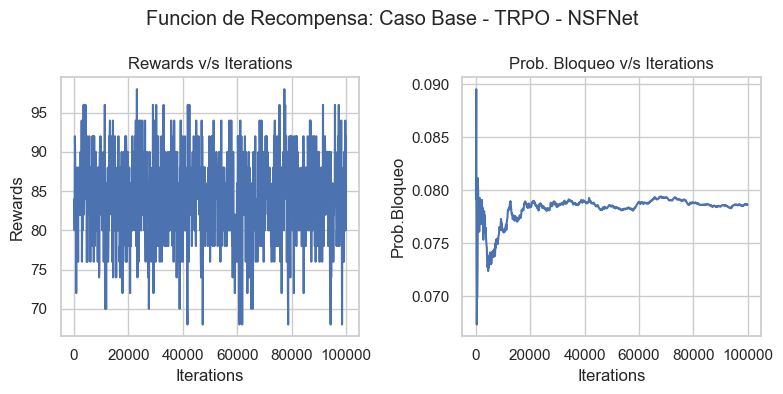

In [12]:
graph_Rewards_Bloqueo(x, rewardsArrayCB_TRPO_NSFNet, probBloqueoArrayCB_TRPO_NSFNet, "Caso Base", "TRPO", "NSFNet")

### 2) Funcion de Recompensa: Band Select (DONE)

#### 2.1) Data:

In [13]:
episodeRewardsArrayBS_TRPO_NSFNet=[85.59999999999995, 85.19999999999996, 76.59999999999997, 89.19999999999996, 71.39999999999996, 80.39999999999993, 77.39999999999996, 81.19999999999997, 72.79999999999995, 76.59999999999997, 73.39999999999998, 70.19999999999996, 80.39999999999995, 78.99999999999999, 68.79999999999997, 81.79999999999995, 92.99999999999996, 74.59999999999997, 78.39999999999998, 90.79999999999998, 76.19999999999996, 81.19999999999996, 77.79999999999997, 73.39999999999995, 75.59999999999997, 78.59999999999995, 81.59999999999997, 64.39999999999998, 82.79999999999995, 74.19999999999995, 78.79999999999997, 82.19999999999995, 85.6, 77.39999999999996, 79.59999999999994, 66.99999999999997, 84.79999999999994, 78.79999999999998, 80.39999999999998, 85.39999999999998, 72.39999999999998, 76.59999999999997, 77.19999999999996, 78.99999999999996, 82.79999999999998, 75.19999999999997, 75.19999999999997, 79.59999999999998, 81.39999999999996, 70.79999999999997, 81.19999999999997, 89.59999999999995, 70.19999999999996, 85.99999999999997, 88.99999999999997, 78.39999999999996, 76.19999999999999, 69.99999999999999, 84.79999999999997, 79.59999999999997, 83.99999999999999, 78.99999999999997, 84.39999999999998, 75.19999999999995, 91.19999999999995, 81.79999999999994, 80.59999999999995, 80.39999999999996, 85.79999999999995, 73.39999999999996, 81.79999999999997, 70.39999999999996, 84.99999999999996, 75.59999999999995, 75.39999999999996, 82.99999999999999, 79.19999999999997, 79.59999999999997, 77.79999999999997, 81.79999999999997, 82.59999999999995, 85.19999999999996, 77.59999999999997, 71.99999999999997, 79.0, 75.99999999999994, 72.19999999999997, 71.39999999999998, 71.39999999999998, 70.59999999999997, 85.59999999999994, 78.59999999999995, 76.79999999999997, 74.39999999999999, 69.39999999999996, 71.59999999999994, 75.39999999999996, 75.79999999999997, 77.99999999999996, 84.79999999999995, 81.19999999999993, 75.39999999999995, 81.39999999999996, 69.59999999999997, 74.19999999999997, 77.39999999999995, 84.19999999999996, 87.59999999999997, 82.59999999999997, 78.99999999999996, 79.79999999999997, 78.19999999999996, 77.99999999999996, 77.59999999999998, 75.59999999999995, 79.39999999999995, 84.79999999999995, 83.99999999999997, 71.99999999999999, 76.59999999999995, 79.99999999999997, 77.59999999999995, 81.99999999999997, 75.99999999999996, 76.39999999999998, 82.79999999999995, 82.59999999999997, 76.59999999999997, 78.99999999999997, 79.59999999999995, 76.79999999999995, 81.99999999999997, 81.19999999999997, 79.99999999999996, 83.99999999999996, 74.39999999999996, 85.59999999999997, 69.79999999999997, 73.99999999999997, 71.79999999999997, 73.39999999999995, 87.59999999999995, 82.79999999999995, 72.79999999999995, 71.79999999999998, 61.199999999999974, 84.99999999999997, 79.39999999999996, 78.19999999999996, 76.39999999999995, 86.59999999999998, 85.19999999999996, 80.79999999999998, 83.99999999999996, 83.19999999999995, 85.99999999999994, 77.19999999999995, 82.59999999999995, 77.19999999999996, 75.99999999999994, 71.59999999999997, 87.79999999999995, 80.19999999999996, 84.79999999999995, 75.19999999999995, 88.79999999999997, 90.19999999999995, 78.79999999999997, 79.39999999999995, 83.59999999999998, 80.79999999999995, 74.59999999999997, 69.39999999999998, 78.99999999999996, 79.39999999999993, 84.79999999999997, 70.99999999999997, 83.19999999999997, 76.79999999999995, 71.99999999999999, 75.99999999999999, 72.59999999999997, 82.39999999999995, 78.39999999999998, 80.19999999999995, 77.59999999999997, 71.19999999999997, 82.59999999999997, 83.19999999999996, 75.79999999999995, 80.99999999999997, 79.59999999999995, 82.39999999999996, 69.39999999999996, 72.99999999999997, 80.39999999999995, 83.39999999999995, 71.39999999999998, 71.59999999999997, 85.99999999999994, 83.39999999999996, 67.79999999999998, 78.59999999999997, 83.39999999999998, 83.39999999999996, 79.79999999999998, 87.39999999999998, 79.99999999999994, 76.79999999999997, 79.99999999999997, 71.99999999999997, 82.79999999999997, 72.19999999999995, 75.19999999999996, 71.39999999999996, 77.79999999999997, 80.39999999999996, 77.19999999999996, 84.99999999999996, 76.19999999999995, 79.39999999999996, 84.39999999999995, 81.59999999999997, 77.99999999999997, 83.59999999999997, 89.99999999999996, 80.79999999999997, 78.79999999999997, 78.99999999999997, 81.39999999999996, 86.39999999999996, 70.59999999999995, 87.79999999999995, 76.19999999999995, 80.19999999999995, 78.59999999999997, 81.39999999999996, 72.79999999999997, 85.79999999999997, 90.79999999999995, 80.99999999999997, 72.59999999999998, 83.19999999999996, 87.39999999999996, 83.59999999999997, 80.19999999999996, 81.39999999999995, 85.79999999999997, 71.99999999999997, 67.99999999999997, 82.39999999999995, 85.39999999999996, 71.99999999999997, 75.99999999999999, 78.39999999999996, 76.99999999999999, 75.59999999999997, 81.99999999999996, 83.19999999999996, 87.99999999999996, 74.99999999999997, 72.19999999999996, 83.79999999999995, 77.79999999999995, 77.79999999999997, 82.19999999999995, 85.59999999999995, 79.79999999999997, 67.79999999999997, 69.39999999999999, 81.0, 84.19999999999996, 64.99999999999997, 79.79999999999995, 81.99999999999996, 83.79999999999997, 82.19999999999997, 78.59999999999995, 83.19999999999997, 75.19999999999999, 81.99999999999996, 74.99999999999996, 75.99999999999999, 81.19999999999996, 82.99999999999996, 72.79999999999997, 81.19999999999995, 85.19999999999996, 81.59999999999995, 80.19999999999995, 82.19999999999997, 77.19999999999995, 75.39999999999996, 73.59999999999997, 69.79999999999997, 86.79999999999997, 73.59999999999998, 69.39999999999993, 87.59999999999997, 83.79999999999995, 81.39999999999995, 84.39999999999996, 70.79999999999997, 75.59999999999998, 74.99999999999997, 69.39999999999996, 76.19999999999996, 72.99999999999994, 83.19999999999996, 81.59999999999997, 72.19999999999995, 73.99999999999997, 85.19999999999996, 79.19999999999996, 79.79999999999997, 79.59999999999997, 79.99999999999997, 82.59999999999995, 85.99999999999996, 83.39999999999996, 75.99999999999996, 86.19999999999997, 79.79999999999997, 78.79999999999997, 78.39999999999996, 82.99999999999994, 82.19999999999997, 82.19999999999997, 74.19999999999996, 82.19999999999995, 77.99999999999996, 77.19999999999997, 86.99999999999997, 69.59999999999997, 73.39999999999996, 79.59999999999998, 84.19999999999997, 90.59999999999998, 78.99999999999997, 83.79999999999997, 86.39999999999996, 83.59999999999997, 73.79999999999997, 74.39999999999998, 79.59999999999995, 71.59999999999998, 83.19999999999996, 84.99999999999997, 84.59999999999995, 77.99999999999996, 80.59999999999997, 71.19999999999996, 68.59999999999997, 87.99999999999994, 85.39999999999995, 70.79999999999995, 78.19999999999999, 77.99999999999996, 79.19999999999997, 77.99999999999997, 84.79999999999997, 73.99999999999997, 79.59999999999997, 60.999999999999964, 84.39999999999998, 78.39999999999995, 64.19999999999997, 73.19999999999996, 82.39999999999998, 86.19999999999995, 84.39999999999998, 82.79999999999995, 72.79999999999998, 75.19999999999995, 85.59999999999998, 87.39999999999996, 77.59999999999998, 74.39999999999992, 71.79999999999997, 75.39999999999996, 73.79999999999995, 78.19999999999996, 78.59999999999995, 78.59999999999997, 78.99999999999996, 81.39999999999996, 89.79999999999997, 78.19999999999996, 77.79999999999995, 70.59999999999997, 77.39999999999996, 77.19999999999999, 91.39999999999996, 73.39999999999998, 80.79999999999995, 80.19999999999997, 80.79999999999995, 77.99999999999996, 77.79999999999997, 73.99999999999996, 80.79999999999997, 72.19999999999997, 75.39999999999996, 84.79999999999997, 73.19999999999996, 80.99999999999996, 74.39999999999996, 79.19999999999995, 76.79999999999997, 82.19999999999997, 75.79999999999997, 81.39999999999998, 79.59999999999998, 81.19999999999996, 79.79999999999997, 75.59999999999997, 86.79999999999995, 79.99999999999997, 81.99999999999994, 78.39999999999995, 69.39999999999995, 75.79999999999998, 74.39999999999995, 87.19999999999996, 77.39999999999996, 70.39999999999998, 87.99999999999997, 80.19999999999997, 83.99999999999994, 74.19999999999996, 89.99999999999996, 78.79999999999995, 85.59999999999997, 75.79999999999997, 77.39999999999996, 74.19999999999996, 75.79999999999995, 75.99999999999997, 75.79999999999995, 76.79999999999995, 83.79999999999998, 79.59999999999997, 74.39999999999995, 84.19999999999997, 82.19999999999996, 82.59999999999997, 85.39999999999996, 71.19999999999997, 74.39999999999998, 79.79999999999995, 81.59999999999995, 72.79999999999994, 72.59999999999994, 79.99999999999996, 70.39999999999996, 80.39999999999998, 85.99999999999996, 83.19999999999997, 82.19999999999995, 84.79999999999995, 75.99999999999997, 66.59999999999998, 79.99999999999996, 80.39999999999998, 80.19999999999996, 85.59999999999997, 87.79999999999997, 75.39999999999998, 85.59999999999995, 87.19999999999996, 78.79999999999997, 86.19999999999996, 85.39999999999998, 81.39999999999996, 81.39999999999996, 64.59999999999997, 76.79999999999997, 81.39999999999998, 74.79999999999997, 78.99999999999996, 82.99999999999996, 85.79999999999997, 80.39999999999996, 75.79999999999995, 85.19999999999997, 80.19999999999997, 66.19999999999996, 85.79999999999995, 73.19999999999996, 72.99999999999997, 80.19999999999997, 82.19999999999995, 77.19999999999996, 75.39999999999996, 73.59999999999998, 76.79999999999995, 79.79999999999995, 82.39999999999995, 75.39999999999996, 71.79999999999994, 83.39999999999996, 80.19999999999993, 75.79999999999995, 78.79999999999995, 78.59999999999995, 71.99999999999999, 71.99999999999997, 78.39999999999995, 65.39999999999996, 77.99999999999997, 82.39999999999996, 79.59999999999997, 75.59999999999998, 78.39999999999995, 77.79999999999994, 71.59999999999997, 78.39999999999996, 76.59999999999995, 79.39999999999996, 74.59999999999997, 79.39999999999993, 76.99999999999996, 88.79999999999995, 79.79999999999997, 74.79999999999997, 78.79999999999994, 80.59999999999997, 86.79999999999997, 87.19999999999996, 70.79999999999997, 83.39999999999998, 80.19999999999996, 75.59999999999995, 76.19999999999997, 75.59999999999998, 81.39999999999996, 73.79999999999995, 72.19999999999997, 81.19999999999996, 81.99999999999996, 89.39999999999996, 77.19999999999997, 77.19999999999997, 77.59999999999997, 81.79999999999995, 82.39999999999995, 77.19999999999997, 81.79999999999997, 77.59999999999998, 79.99999999999997, 68.99999999999997, 83.79999999999998, 80.79999999999998, 80.79999999999995, 72.79999999999995, 88.19999999999996, 75.19999999999996, 85.19999999999996, 70.59999999999998, 86.19999999999996, 74.19999999999997, 76.79999999999998, 84.79999999999997, 73.19999999999996, 72.39999999999995, 80.99999999999997, 79.79999999999995, 87.39999999999995, 87.79999999999997, 74.79999999999998, 77.99999999999996, 76.39999999999996, 80.79999999999995, 68.99999999999996, 77.99999999999996, 79.99999999999996, 82.39999999999998, 69.99999999999996, 66.39999999999996, 81.79999999999995, 78.39999999999995, 75.39999999999996, 82.19999999999996, 80.79999999999995, 82.59999999999997, 79.59999999999998, 86.99999999999996, 88.39999999999996, 82.59999999999995, 79.19999999999995, 83.99999999999997, 79.99999999999996, 80.99999999999996, 83.39999999999995, 82.59999999999997, 78.79999999999994, 84.99999999999997, 74.39999999999996, 77.59999999999995, 78.79999999999995, 79.99999999999997, 86.59999999999998, 72.99999999999997, 72.79999999999995, 81.59999999999998, 81.99999999999996, 84.39999999999995, 67.59999999999997, 74.79999999999995, 67.79999999999995, 77.19999999999997, 81.79999999999995, 84.79999999999997, 74.19999999999995, 77.39999999999996, 73.59999999999997, 79.19999999999997, 80.59999999999997, 75.59999999999995, 79.19999999999996, 82.39999999999993, 77.59999999999995, 82.79999999999997, 79.39999999999996, 79.99999999999997, 71.79999999999997, 82.59999999999997, 83.99999999999996, 80.99999999999996, 87.39999999999998, 84.19999999999997, 84.99999999999996, 77.19999999999997, 74.39999999999998, 79.39999999999998, 79.79999999999994, 76.79999999999997, 69.59999999999997, 77.59999999999997, 82.79999999999995, 72.19999999999995, 88.39999999999995, 82.99999999999999, 87.79999999999997, 79.59999999999998, 86.99999999999996, 83.19999999999997, 86.79999999999997, 81.19999999999996, 74.99999999999997, 76.99999999999997, 75.79999999999997, 78.59999999999998, 82.39999999999996, 82.79999999999995, 78.39999999999995, 58.19999999999997, 78.79999999999995, 84.99999999999994, 79.19999999999996, 83.19999999999997, 91.59999999999994, 76.59999999999992, 73.39999999999996, 72.19999999999997, 83.59999999999997, 82.19999999999995, 76.59999999999995, 77.19999999999995, 77.99999999999997, 76.59999999999998, 75.39999999999993, 65.19999999999997, 80.79999999999995, 78.79999999999998, 81.59999999999995, 76.19999999999996, 75.59999999999998, 69.99999999999997, 81.99999999999996, 81.59999999999995, 80.19999999999996, 79.39999999999995, 83.59999999999997, 66.39999999999996, 81.99999999999996, 76.39999999999996, 82.19999999999995, 84.39999999999995, 79.39999999999998, 77.79999999999995, 78.99999999999997, 79.19999999999997, 69.99999999999994, 79.59999999999995, 67.99999999999994, 75.99999999999999, 77.39999999999998, 83.39999999999998, 74.99999999999997, 74.79999999999995, 78.79999999999995, 78.19999999999996, 84.99999999999997, 74.79999999999995, 86.19999999999996, 77.59999999999997, 82.19999999999995, 80.19999999999996, 76.39999999999995, 85.39999999999996, 78.79999999999998, 76.99999999999996, 77.99999999999996, 83.79999999999995, 83.59999999999995, 81.99999999999997, 68.19999999999997, 71.79999999999998, 82.39999999999995, 85.99999999999996, 80.59999999999995, 80.59999999999997, 80.39999999999995, 79.39999999999998, 88.59999999999995, 87.79999999999994, 78.19999999999999, 80.99999999999996, 84.39999999999995, 81.39999999999996, 85.79999999999997, 79.79999999999997, 81.19999999999993, 77.39999999999995, 76.39999999999996, 81.99999999999994, 83.19999999999996, 83.39999999999993, 77.79999999999995, 79.39999999999996, 87.59999999999997, 80.79999999999997, 81.79999999999997, 79.39999999999995, 65.59999999999997, 71.19999999999997, 71.59999999999997, 79.79999999999993, 73.19999999999996, 78.39999999999996, 78.79999999999995, 90.99999999999996, 76.79999999999998, 80.19999999999996, 84.59999999999995, 83.19999999999997, 82.39999999999996, 78.99999999999997, 72.99999999999997, 79.79999999999997, 80.39999999999995, 68.39999999999998, 84.59999999999997, 81.39999999999996, 75.19999999999996, 82.99999999999997, 78.99999999999996, 82.39999999999996, 85.79999999999997, 77.79999999999994, 79.59999999999998, 86.79999999999997, 88.39999999999995, 74.79999999999995, 76.19999999999996, 74.79999999999998, 83.59999999999997, 76.39999999999993, 76.99999999999996, 79.19999999999999, 77.59999999999997, 69.79999999999998, 79.99999999999997, 78.99999999999997, 80.59999999999997, 71.19999999999996, 80.99999999999997, 81.59999999999997, 84.19999999999995, 90.59999999999997, 72.99999999999997, 88.99999999999996, 85.99999999999996, 81.19999999999997, 75.79999999999997, 85.19999999999997, 79.79999999999995, 80.19999999999995, 79.79999999999997, 86.39999999999996, 78.39999999999996, 73.79999999999995, 81.99999999999996, 82.59999999999995, 79.99999999999997, 72.19999999999997, 82.79999999999997, 81.19999999999996, 87.59999999999997, 64.39999999999996, 84.59999999999997, 79.39999999999996, 76.99999999999997, 85.19999999999997, 76.79999999999997, 79.59999999999997, 76.79999999999995, 80.99999999999996, 78.59999999999997, 84.99999999999997, 81.19999999999999, 73.59999999999998, 79.39999999999998, 85.59999999999997, 85.79999999999997, 67.99999999999996, 81.99999999999994, 79.39999999999995, 75.59999999999994, 83.19999999999997, 85.79999999999995, 79.99999999999997, 77.79999999999997, 82.39999999999996, 89.19999999999996, 86.39999999999995, 78.19999999999996, 82.99999999999994, 74.59999999999995, 75.79999999999995, 82.19999999999996, 72.39999999999998, 82.79999999999994, 82.19999999999996, 81.79999999999998, 83.59999999999998, 88.39999999999996, 74.79999999999997, 80.39999999999998, 75.19999999999996, 86.79999999999997, 85.19999999999995, 79.59999999999997, 79.19999999999996, 83.99999999999999, 88.39999999999995, 82.79999999999995, 85.99999999999996, 77.99999999999997, 72.79999999999997, 72.59999999999997, 80.39999999999996, 87.79999999999995, 73.19999999999997, 75.99999999999997, 84.79999999999995, 82.19999999999997, 88.39999999999995, 80.19999999999996, 65.39999999999996, 78.59999999999995, 82.19999999999996, 78.19999999999996, 76.99999999999997, 71.79999999999994, 76.39999999999996, 90.59999999999998, 82.99999999999996, 85.99999999999997, 72.19999999999997, 80.59999999999997, 70.39999999999998, 84.59999999999997, 71.79999999999998, 84.39999999999996, 79.79999999999995, 80.79999999999997, 84.59999999999995, 80.19999999999997, 77.99999999999996, 79.79999999999997, 80.99999999999996, 76.19999999999996, 68.39999999999998, 77.19999999999996, 79.59999999999998, 82.39999999999995, 72.99999999999996, 77.99999999999994, 93.39999999999993, 73.59999999999997, 79.99999999999996, 77.99999999999994, 75.79999999999995, 84.59999999999997, 80.99999999999997, 83.79999999999997, 76.39999999999996, 84.99999999999996, 79.59999999999998, 79.19999999999999, 82.39999999999996, 80.59999999999994, 80.19999999999996, 77.19999999999999, 89.99999999999994, 81.19999999999996, 85.99999999999997, 83.99999999999996, 77.59999999999997, 80.19999999999996, 79.19999999999997, 72.79999999999995, 74.79999999999995, 77.79999999999997, 89.59999999999995, 71.79999999999995, 81.79999999999997, 83.19999999999993, 83.39999999999995, 67.19999999999997, 77.59999999999997, 80.99999999999996, 76.39999999999996, 86.99999999999996, 71.99999999999997, 74.99999999999994, 77.79999999999995, 77.39999999999996, 75.19999999999997, 77.79999999999997, 85.99999999999996, 74.19999999999997, 76.79999999999997, 80.79999999999995, 69.19999999999997, 85.59999999999995, 68.99999999999996, 81.79999999999995, 82.59999999999997, 77.59999999999995, 82.59999999999995, 79.59999999999997, 78.19999999999996, 75.39999999999996, 77.59999999999995, 86.99999999999996, 85.59999999999998, 80.19999999999999, 79.19999999999997, 72.59999999999997, 80.39999999999996, 74.59999999999995, 81.99999999999997, 73.79999999999998, 64.79999999999997, 71.59999999999998, 88.79999999999995, 73.99999999999997, 78.79999999999995, 66.39999999999999, 78.59999999999995, 76.79999999999997, 81.39999999999998, 84.59999999999997, 78.79999999999997, 78.59999999999998, 80.19999999999997, 84.79999999999995, 75.39999999999995, 80.79999999999997, 77.79999999999997, 73.79999999999995, 83.79999999999997, 87.79999999999995, 81.19999999999995, 72.19999999999996, 74.39999999999998, 76.59999999999997, 85.59999999999998, 78.59999999999995, 74.39999999999998, 75.59999999999997, 71.59999999999997, 77.99999999999997, 82.79999999999995, 67.99999999999996, 78.59999999999997, 88.19999999999997, 73.19999999999996, 87.79999999999997, 72.19999999999995, 82.19999999999996, 68.99999999999996, 78.39999999999998, 81.39999999999995, 89.19999999999996, 77.99999999999997, 74.79999999999995, 68.59999999999995, 72.19999999999996, 73.6, 77.19999999999996, 79.79999999999995, 76.19999999999999, 73.19999999999995, 79.19999999999996, 69.79999999999995, 75.79999999999995]
rewardsArrayBS_TRPO_NSFNet=[0, 78.99999999999994, 75.39999999999996, 76.79999999999995, 79.99999999999997, 77.39999999999998, 78.99999999999997, 71.99999999999997, 69.99999999999996, 74.99999999999997, 84.19999999999996, 74.39999999999998, 82.99999999999997, 83.19999999999997, 81.99999999999994, 70.59999999999997, 79.19999999999997, 81.19999999999997, 74.79999999999998, 83.59999999999997, 83.59999999999997, 67.79999999999997, 83.59999999999994, 75.19999999999997, 82.79999999999998, 75.39999999999998, 83.99999999999996, 69.39999999999996, 85.79999999999997, 75.19999999999997, 74.39999999999996, 84.39999999999998, 80.99999999999993, 73.99999999999997, 87.39999999999996, 86.99999999999996, 76.99999999999997, 71.19999999999995, 78.59999999999997, 82.19999999999995, 84.19999999999996, 76.19999999999996, 89.79999999999997, 78.59999999999994, 79.39999999999998, 89.19999999999995, 78.99999999999997, 79.59999999999994, 84.59999999999995, 75.39999999999993, 80.59999999999997, 79.19999999999996, 76.79999999999997, 74.59999999999998, 80.39999999999993, 79.59999999999997, 81.19999999999997, 80.59999999999997, 77.39999999999998, 82.19999999999997, 79.39999999999995, 84.79999999999998, 81.39999999999996, 67.59999999999997, 75.59999999999995, 84.59999999999995, 76.99999999999996, 61.99999999999994, 79.19999999999997, 70.79999999999997, 74.79999999999994, 83.79999999999995, 80.19999999999996, 70.99999999999996, 75.39999999999995, 66.79999999999997, 77.79999999999997, 74.79999999999997, 79.19999999999996, 76.99999999999997, 84.19999999999996, 76.59999999999998, 78.39999999999996, 74.39999999999998, 71.99999999999996, 81.39999999999993, 77.79999999999997, 87.39999999999996, 78.79999999999997, 83.99999999999996, 82.59999999999997, 78.59999999999995, 81.79999999999998, 67.39999999999998, 80.59999999999995, 79.19999999999996, 82.39999999999996, 87.59999999999997, 73.19999999999996, 72.59999999999997, 78.99999999999997, 87.19999999999996, 67.99999999999997, 82.39999999999998, 82.39999999999999, 75.99999999999999, 84.59999999999998, 77.39999999999998, 81.99999999999994, 75.19999999999997, 78.19999999999996, 78.99999999999996, 80.19999999999997, 83.79999999999997, 79.79999999999997, 83.59999999999995, 76.59999999999998, 79.19999999999996, 68.59999999999998, 75.79999999999997, 73.59999999999998, 78.19999999999997, 82.59999999999997, 75.59999999999998, 77.39999999999995, 64.79999999999998, 72.39999999999996, 83.59999999999995, 80.19999999999997, 75.99999999999997, 79.99999999999997, 88.79999999999997, 83.39999999999998, 80.59999999999997, 83.99999999999997, 84.19999999999996, 80.39999999999993, 80.99999999999996, 80.99999999999996, 73.79999999999998, 77.79999999999997, 75.99999999999996, 85.59999999999997, 80.79999999999995, 84.19999999999997, 77.99999999999996, 92.19999999999995, 82.79999999999995, 80.59999999999995, 79.99999999999997, 83.19999999999996, 80.6, 72.99999999999996, 70.19999999999997, 81.59999999999995, 77.99999999999996, 82.59999999999995, 70.79999999999997, 87.99999999999997, 74.39999999999998, 69.79999999999995, 74.19999999999996, 74.59999999999997, 79.79999999999995, 78.19999999999999, 83.59999999999998, 74.59999999999997, 73.19999999999995, 87.39999999999996, 73.99999999999997, 83.79999999999998, 77.19999999999996, 83.99999999999996, 73.39999999999996, 69.59999999999998, 81.59999999999995, 81.39999999999998, 74.79999999999995, 71.59999999999997, 80.19999999999997, 83.39999999999996, 69.79999999999995, 78.99999999999994, 79.79999999999994, 82.79999999999997, 84.79999999999995, 81.79999999999995, 86.59999999999995, 78.99999999999997, 77.59999999999998, 70.19999999999997, 82.79999999999995, 77.39999999999996, 74.19999999999997, 68.19999999999996, 76.59999999999998, 80.99999999999996, 77.39999999999998, 84.39999999999996, 75.79999999999997, 77.79999999999998, 85.59999999999997, 82.99999999999994, 78.79999999999995, 80.39999999999996, 87.99999999999997, 84.19999999999995, 79.39999999999996, 79.19999999999996, 79.39999999999993, 81.79999999999997, 83.39999999999995, 77.99999999999996, 86.19999999999996, 69.99999999999996, 80.39999999999995, 83.19999999999996, 74.79999999999995, 83.19999999999996, 87.19999999999999, 83.19999999999996, 77.79999999999994, 79.8, 83.39999999999998, 83.99999999999997, 83.79999999999995, 76.59999999999995, 84.79999999999997, 83.79999999999995, 69.79999999999998, 75.39999999999996, 80.99999999999994, 81.19999999999996, 75.39999999999996, 71.79999999999995, 81.19999999999996, 74.99999999999997, 81.99999999999997, 81.39999999999998, 84.79999999999995, 81.59999999999995, 72.79999999999995, 77.79999999999997, 81.99999999999996, 73.19999999999996, 85.39999999999996, 78.79999999999994, 83.99999999999999, 79.19999999999997, 64.59999999999997, 72.59999999999998, 85.59999999999995, 71.19999999999996, 75.79999999999995, 77.99999999999994, 85.79999999999997, 79.79999999999997, 77.99999999999997, 83.39999999999996, 76.59999999999997, 84.39999999999996, 78.19999999999997, 73.19999999999996, 81.79999999999997, 81.39999999999996, 80.39999999999995, 75.59999999999995, 85.39999999999998, 82.99999999999997, 77.59999999999997, 80.39999999999996, 82.19999999999995, 74.99999999999997, 69.79999999999994, 74.99999999999997, 76.59999999999994, 81.99999999999996, 71.59999999999998, 78.99999999999997, 85.19999999999996, 86.79999999999994, 77.79999999999995, 75.39999999999996, 76.19999999999996, 75.39999999999998, 70.19999999999997, 78.19999999999996, 71.99999999999999, 78.39999999999996, 81.19999999999997, 79.19999999999996, 73.79999999999997, 76.79999999999997, 88.39999999999995, 71.59999999999997, 83.99999999999997, 73.79999999999997, 87.59999999999995, 83.19999999999995, 83.59999999999997, 77.99999999999997, 79.59999999999997, 84.19999999999996, 80.59999999999997, 79.19999999999996, 79.59999999999998, 82.79999999999997, 85.79999999999997, 75.19999999999995, 78.59999999999995, 83.79999999999995, 72.99999999999997, 82.79999999999995, 77.59999999999997, 71.59999999999997, 74.99999999999997, 87.99999999999997, 84.59999999999998, 85.79999999999997, 77.19999999999996, 84.99999999999996, 85.39999999999996, 81.39999999999996, 77.79999999999997, 73.39999999999996, 68.99999999999997, 82.99999999999996, 86.79999999999995, 82.99999999999996, 83.79999999999997, 72.99999999999997, 83.39999999999993, 65.99999999999997, 78.99999999999997, 83.19999999999997, 84.19999999999995, 68.79999999999997, 83.59999999999994, 74.99999999999997, 81.39999999999995, 77.59999999999997, 83.19999999999996, 73.79999999999997, 73.39999999999996, 71.19999999999997, 81.39999999999995, 68.19999999999996, 69.59999999999997, 79.19999999999997, 83.99999999999996, 84.79999999999997, 85.19999999999996, 80.19999999999996, 70.59999999999998, 80.39999999999995, 85.39999999999995, 85.99999999999997, 74.59999999999995, 75.39999999999998, 72.19999999999997, 75.39999999999995, 75.39999999999998, 74.19999999999996, 79.59999999999998, 79.99999999999994, 82.79999999999997, 81.39999999999998, 82.79999999999994, 81.79999999999997, 74.19999999999996, 71.79999999999998, 79.59999999999998, 84.19999999999996, 77.79999999999997, 81.59999999999997, 80.99999999999997, 84.19999999999997, 76.59999999999995, 74.19999999999995, 81.99999999999999, 72.59999999999995, 72.39999999999998, 75.59999999999997, 80.39999999999995, 85.79999999999997, 74.79999999999997, 74.59999999999995, 79.39999999999995, 73.99999999999999, 79.99999999999997, 81.79999999999997, 78.59999999999998, 76.39999999999996, 79.59999999999997, 83.99999999999994, 79.59999999999997, 79.59999999999998, 82.39999999999995, 81.59999999999997, 79.79999999999995, 75.99999999999999, 68.19999999999997, 80.19999999999996, 78.19999999999997, 84.99999999999996, 74.39999999999995, 79.59999999999997, 81.59999999999997, 77.99999999999996, 83.39999999999998, 81.99999999999999, 81.79999999999998, 83.79999999999995, 79.99999999999996, 75.59999999999997, 75.39999999999996, 83.19999999999997, 63.79999999999998, 86.99999999999996, 74.39999999999998, 76.19999999999997, 80.59999999999997, 78.99999999999996, 80.59999999999998, 83.39999999999998, 82.39999999999996, 83.39999999999996, 68.99999999999996, 76.39999999999995, 78.19999999999997, 79.59999999999997, 85.39999999999996, 72.79999999999998, 76.59999999999998, 66.79999999999995, 79.59999999999994, 82.59999999999998, 84.99999999999996, 84.99999999999996, 82.39999999999996, 74.19999999999996, 75.19999999999997, 78.79999999999998, 75.99999999999997, 84.79999999999995, 75.39999999999998, 88.19999999999997, 82.79999999999995, 82.79999999999998, 84.59999999999997, 82.19999999999995, 83.99999999999996, 83.79999999999995, 81.59999999999997, 83.39999999999996, 76.79999999999995, 66.19999999999996, 80.99999999999996, 79.19999999999995, 75.79999999999997, 81.59999999999998, 80.59999999999997, 88.99999999999996, 81.19999999999995, 72.8, 86.39999999999998, 74.59999999999998, 72.19999999999996, 81.59999999999997, 73.59999999999997, 72.19999999999997, 83.39999999999996, 80.59999999999995, 75.39999999999998, 71.39999999999998, 77.79999999999997, 75.19999999999995, 82.99999999999996, 78.79999999999997, 72.99999999999997, 79.99999999999997, 84.99999999999997, 75.99999999999997, 76.19999999999997, 80.79999999999997, 66.59999999999997, 76.79999999999997, 79.59999999999998, 72.19999999999996, 67.79999999999998, 81.19999999999996, 81.19999999999997, 70.99999999999996, 81.99999999999996, 79.59999999999995, 78.99999999999996, 70.39999999999996, 80.59999999999995, 72.79999999999997, 75.59999999999997, 81.99999999999994, 78.19999999999996, 84.39999999999996, 81.59999999999997, 79.39999999999996, 76.99999999999997, 75.59999999999994, 83.19999999999996, 86.59999999999995, 77.39999999999996, 81.99999999999996, 83.79999999999998, 78.99999999999994, 73.59999999999994, 73.99999999999996, 78.19999999999999, 78.59999999999995, 74.19999999999997, 78.19999999999997, 74.79999999999995, 86.59999999999997, 84.79999999999995, 76.99999999999996, 75.79999999999997, 82.59999999999995, 84.39999999999996, 78.19999999999996, 79.99999999999997, 76.99999999999996, 78.79999999999995, 75.19999999999997, 75.19999999999996, 84.19999999999996, 86.59999999999998, 72.59999999999997, 77.79999999999995, 81.99999999999997, 82.59999999999997, 70.19999999999995, 86.59999999999995, 75.59999999999997, 78.39999999999998, 79.39999999999995, 85.39999999999996, 68.99999999999997, 77.79999999999995, 75.19999999999996, 87.39999999999998, 88.79999999999997, 77.99999999999996, 79.19999999999996, 78.39999999999996, 78.99999999999997, 72.79999999999997, 72.19999999999999, 81.19999999999993, 79.79999999999997, 77.19999999999999, 62.99999999999997, 77.39999999999995, 82.79999999999997, 76.79999999999998, 78.19999999999996, 79.99999999999994, 81.19999999999996, 79.19999999999997, 87.59999999999998, 84.39999999999995, 87.19999999999996, 77.39999999999998, 86.19999999999996, 82.39999999999996, 79.59999999999997, 79.39999999999995, 82.59999999999997, 85.39999999999998, 78.19999999999996, 78.59999999999997, 79.79999999999995, 78.59999999999997, 75.19999999999997, 83.79999999999997, 85.39999999999998, 64.19999999999997, 76.39999999999996, 87.59999999999995, 83.39999999999995, 79.0, 74.59999999999998, 66.79999999999998, 68.79999999999997, 79.79999999999997, 82.59999999999995, 85.59999999999997, 70.19999999999997, 77.19999999999996, 77.39999999999999, 80.59999999999995, 75.19999999999999, 77.59999999999997, 80.59999999999997, 78.59999999999994, 81.99999999999996, 76.99999999999991, 84.19999999999997, 71.59999999999997, 82.79999999999998, 83.59999999999997, 81.39999999999996, 83.19999999999996, 84.39999999999996, 87.19999999999997, 77.19999999999996, 81.99999999999999, 79.19999999999996, 75.59999999999997, 75.59999999999995, 78.99999999999996, 64.39999999999998, 87.39999999999998, 76.19999999999995, 80.19999999999996, 83.6, 88.39999999999996, 81.59999999999997, 83.79999999999997, 84.19999999999996, 84.39999999999996, 86.19999999999997, 78.59999999999997, 72.59999999999995, 79.99999999999997, 71.99999999999997, 86.19999999999996, 82.39999999999998, 77.19999999999997, 67.59999999999995, 70.79999999999995, 83.39999999999998, 80.99999999999997, 80.59999999999997, 87.99999999999997, 86.39999999999995, 69.19999999999999, 73.99999999999999, 79.99999999999999, 84.79999999999997, 76.59999999999994, 78.19999999999996, 81.59999999999997, 74.39999999999998, 74.99999999999999, 72.39999999999996, 66.19999999999996, 79.19999999999996, 87.99999999999999, 75.19999999999997, 72.39999999999995, 77.99999999999994, 78.39999999999996, 75.59999999999995, 84.59999999999997, 79.59999999999995, 77.79999999999997, 78.79999999999997, 72.39999999999998, 80.19999999999996, 76.99999999999996, 85.99999999999996, 76.59999999999997, 87.99999999999997, 76.79999999999995, 79.39999999999998, 71.39999999999996, 75.39999999999996, 76.19999999999996, 65.99999999999997, 79.59999999999995, 77.39999999999996, 76.99999999999999, 77.79999999999997, 82.79999999999995, 73.99999999999996, 84.39999999999995, 79.79999999999995, 81.99999999999996, 79.39999999999995, 76.99999999999997, 86.79999999999997, 77.39999999999996, 77.39999999999998, 79.39999999999993, 78.59999999999997, 84.19999999999995, 73.99999999999996, 85.39999999999993, 84.19999999999997, 78.59999999999995, 65.99999999999997, 78.99999999999996, 79.79999999999997, 88.39999999999995, 76.99999999999996, 84.39999999999996, 74.79999999999997, 87.99999999999997, 85.79999999999995, 83.99999999999996, 80.59999999999998, 85.19999999999997, 76.19999999999997, 87.19999999999995, 77.99999999999997, 85.19999999999995, 79.79999999999995, 73.39999999999998, 79.59999999999995, 78.99999999999996, 86.19999999999996, 84.99999999999996, 78.79999999999997, 79.79999999999997, 85.19999999999996, 85.19999999999997, 78.39999999999996, 70.39999999999996, 68.19999999999999, 70.99999999999997, 78.39999999999995, 80.59999999999997, 68.99999999999997, 77.79999999999994, 87.59999999999997, 81.79999999999995, 79.39999999999996, 83.99999999999996, 86.8, 76.79999999999995, 80.79999999999995, 80.79999999999994, 70.39999999999998, 82.59999999999995, 77.59999999999994, 70.99999999999996, 86.59999999999995, 76.79999999999994, 83.39999999999998, 77.79999999999997, 77.19999999999996, 90.79999999999995, 80.79999999999995, 78.59999999999997, 81.19999999999996, 89.39999999999996, 80.79999999999997, 71.39999999999996, 77.79999999999994, 79.19999999999996, 88.59999999999997, 65.99999999999997, 79.79999999999998, 80.99999999999999, 78.79999999999995, 64.59999999999998, 80.99999999999996, 84.79999999999998, 71.59999999999997, 82.19999999999996, 79.59999999999997, 79.19999999999995, 90.19999999999999, 82.39999999999993, 79.19999999999996, 88.39999999999998, 84.79999999999995, 75.79999999999997, 79.39999999999998, 82.19999999999995, 80.79999999999997, 82.39999999999996, 82.79999999999995, 81.99999999999994, 76.39999999999998, 75.79999999999998, 84.79999999999995, 77.59999999999997, 78.19999999999997, 79.79999999999997, 78.39999999999996, 86.99999999999996, 73.59999999999997, 76.0, 83.39999999999996, 72.99999999999996, 80.39999999999996, 85.39999999999995, 79.59999999999995, 79.99999999999997, 74.0, 80.59999999999997, 82.99999999999996, 85.39999999999996, 76.79999999999997, 76.79999999999995, 82.39999999999996, 83.59999999999995, 72.79999999999998, 81.19999999999997, 77.19999999999995, 76.39999999999996, 84.99999999999996, 80.59999999999998, 89.19999999999997, 73.59999999999997, 80.19999999999997, 81.79999999999997, 89.39999999999996, 83.19999999999997, 84.39999999999996, 79.39999999999996, 70.39999999999996, 77.39999999999995, 79.99999999999997, 80.19999999999997, 81.39999999999998, 86.19999999999996, 75.99999999999996, 85.59999999999995, 83.99999999999997, 74.59999999999998, 81.79999999999997, 79.99999999999996, 88.99999999999997, 76.19999999999997, 85.59999999999997, 73.19999999999997, 93.19999999999995, 85.39999999999996, 83.59999999999997, 79.19999999999997, 75.59999999999997, 71.99999999999996, 78.99999999999996, 81.39999999999998, 82.59999999999995, 77.99999999999997, 77.59999999999997, 81.79999999999995, 83.19999999999995, 86.19999999999995, 73.19999999999999, 72.99999999999997, 76.39999999999995, 82.79999999999997, 75.19999999999996, 79.59999999999995, 72.79999999999998, 83.59999999999997, 84.59999999999997, 83.19999999999997, 78.39999999999993, 78.79999999999995, 78.19999999999995, 76.59999999999995, 74.79999999999995, 81.39999999999998, 82.59999999999995, 82.59999999999997, 80.19999999999996, 84.19999999999995, 79.59999999999997, 75.79999999999998, 79.39999999999996, 78.79999999999995, 72.99999999999999, 70.79999999999994, 81.79999999999995, 79.59999999999997, 81.39999999999996, 68.99999999999999, 88.59999999999997, 77.59999999999994, 83.39999999999995, 76.79999999999997, 84.59999999999995, 74.39999999999996, 84.59999999999995, 79.99999999999997, 80.19999999999997, 76.19999999999996, 84.99999999999997, 78.79999999999995, 79.19999999999996, 85.59999999999994, 78.99999999999996, 77.79999999999994, 84.79999999999998, 84.99999999999996, 88.39999999999998, 76.39999999999998, 85.39999999999992, 80.39999999999998, 80.39999999999998, 73.99999999999996, 72.99999999999997, 79.99999999999996, 78.99999999999997, 80.39999999999996, 74.99999999999994, 86.99999999999996, 81.99999999999996, 80.59999999999997, 66.19999999999996, 78.99999999999997, 81.99999999999996, 80.99999999999996, 77.39999999999996, 76.39999999999998, 77.19999999999996, 74.99999999999996, 75.19999999999996, 75.79999999999997, 83.59999999999997, 78.79999999999995, 77.19999999999997, 80.39999999999996, 74.99999999999996, 73.79999999999994, 79.59999999999997, 73.8, 85.79999999999995, 79.39999999999996, 83.39999999999996, 80.39999999999998, 75.19999999999996, 80.79999999999997, 72.79999999999997, 82.39999999999996, 90.19999999999995, 76.59999999999997, 83.39999999999996, 73.59999999999997, 73.79999999999998, 78.79999999999995, 81.19999999999996, 81.19999999999996, 62.599999999999966, 70.79999999999997, 81.79999999999997, 79.39999999999995, 79.79999999999998, 70.19999999999996, 70.19999999999996, 72.59999999999997, 81.99999999999994, 84.79999999999997, 83.19999999999997, 78.39999999999998, 80.39999999999996, 85.59999999999997, 79.99999999999996, 74.19999999999997, 82.79999999999997, 67.79999999999997, 85.59999999999995, 84.99999999999997, 87.99999999999999, 72.99999999999997, 73.59999999999997, 76.99999999999996, 75.39999999999996, 86.39999999999998, 67.79999999999997, 82.79999999999997, 75.79999999999997, 70.19999999999996, 80.99999999999997, 82.19999999999995, 67.59999999999997, 80.19999999999995, 85.39999999999993, 81.79999999999998, 83.39999999999996, 70.19999999999997, 78.79999999999997, 68.79999999999997, 83.19999999999997, 84.19999999999997, 85.59999999999997, 73.99999999999997, 76.59999999999997, 65.39999999999999, 74.39999999999995, 77.39999999999995, 73.59999999999995, 78.39999999999996, 75.59999999999995, 80.19999999999997, 73.79999999999997, 68.19999999999996]
probBloqueoArrayBS_TRPO_NSFNet=[0.0, 0.06930693069306931, 0.0845771144278607, 0.08637873754152824, 0.08229426433915212, 0.08383233532934131, 0.08319467554076539, 0.0884450784593438, 0.09238451935081149, 0.0932297447280799, 0.08891108891108891, 0.09082652134423251, 0.08825978351373855, 0.08685626441199078, 0.08493932905067808, 0.08727514990006663, 0.0868207370393504, 0.08583186360964139, 0.08717379233759023, 0.08574434508153603, 0.08445777111444278, 0.08710138029509758, 0.0854157201272149, 0.08604954367666232, 0.0849645980841316, 0.0859656137544982, 0.08496732026143791, 0.08663457978526472, 0.08532666904676901, 0.08583247156153051, 0.08630456514495169, 0.0854563044179297, 0.08466104342393002, 0.08512571947894577, 0.08379888268156424, 0.08254784347329334, 0.08275479033601778, 0.08376114563631451, 0.08366219415943173, 0.08305562676236862, 0.08222944263934016, 0.08266276517922458, 0.08140918828850274, 0.08137642408742153, 0.0813451488298114, 0.07998222617196178, 0.07998261247554879, 0.0797702616464582, 0.07915017704644865, 0.07937155682513773, 0.07918416316736653, 0.07920015683199373, 0.07940780619111709, 0.07998490850782872, 0.07961488613219773, 0.07962188692964915, 0.07962863774326014, 0.07963515172776706, 0.07981382520255129, 0.0796475173699373, 0.07965339110148309, 0.07916734961481724, 0.07901951298177713, 0.07998730360260276, 0.08029995313232308, 0.07998769420089218, 0.08013937282229965, 0.08133114460528279, 0.0813115718276724, 0.08187219243587886, 0.08198828738751607, 0.0815378115758344, 0.0813775864463269, 0.08190658813861115, 0.08215106066747736, 0.08292227702972937, 0.08288383107485857, 0.08310609011816647, 0.08306627355467248, 0.08315403113529933, 0.08273965754280715, 0.08282928033576102, 0.08279478112425313, 0.08312251535959522, 0.08344244732769908, 0.08316668627220326, 0.0832461341704453, 0.08274910929778187, 0.0827178729689808, 0.08246264464666891, 0.08221308743472948, 0.0821887704647841, 0.08205629822845342, 0.08267928179765617, 0.08254441016913094, 0.08251762972318703, 0.08228309551088428, 0.08184723224409855, 0.08213447607387002, 0.08251691748308251, 0.08249175082491751, 0.08207108207108207, 0.08263895696500344, 0.08251626055722745, 0.08239592346889722, 0.08256356537472621, 0.08225639090651825, 0.08242220353238015, 0.0822146097583557, 0.08246949821117329, 0.08244705026815743, 0.0824250067561481, 0.082403356843139, 0.08220511459162906, 0.08218577317779142, 0.08199287018520128, 0.08206189121627445, 0.0820442697205367, 0.0825353783577663, 0.08268212755230653, 0.08290975752020666, 0.08296834972316337, 0.08278009999180395, 0.08292008779774002, 0.08289654060156439, 0.08351331893448524, 0.08372351400682486, 0.08353672939138651, 0.08350910085149597, 0.08363692736997132, 0.08353203599723098, 0.08319975574383635, 0.08302401333232332, 0.08300127809939102, 0.08282963957913589, 0.0825864750759203, 0.08242041026395118, 0.08225676957886285, 0.08216795884356207, 0.08236817495144234, 0.08235126062424113, 0.08240550315580455, 0.08217731145693966, 0.08209216138731558, 0.08193875425317686, 0.0819253844562444, 0.0814327785768098, 0.08128698727977689, 0.08121072900479698, 0.08113549426213006, 0.08099460035997601, 0.08098801403880537, 0.08117886981119664, 0.08149794131102542, 0.08135835335367833, 0.08134959034900974, 0.08121274277289918, 0.08145977963187058, 0.0811973925700905, 0.0813156405257531, 0.08161989875632773, 0.08179616172908515, 0.081908524165175, 0.08183547021655113, 0.0818852508993354, 0.0817526210532695, 0.08186253840130113, 0.08203101610681995, 0.08178084637819177, 0.08194781373883202, 0.08181871654608552, 0.08186655751125665, 0.0816812975989768, 0.08184498005895613, 0.08212171714269295, 0.0820524541454774, 0.08198397818305778, 0.08208575786678719, 0.0822987472613898, 0.08228590581531758, 0.08210654963613133, 0.0823711397160378, 0.08235811219163783, 0.08229058521392274, 0.08222379218520733, 0.08204961893951679, 0.08198483952475673, 0.08176033367199614, 0.08175097069304824, 0.0817946140415851, 0.08204831324667122, 0.0819328830951259, 0.08197489714077391, 0.08206828661727372, 0.08231534456986753, 0.08235475103840828, 0.08229171981021377, 0.08233084614994163, 0.08216756729458108, 0.08225717300638159, 0.08224588770561472, 0.08208546838465748, 0.0819266372951834, 0.08191714693857445, 0.08190774962011665, 0.0817033315448027, 0.08154943934760449, 0.08154195449495194, 0.08153454160857651, 0.08147935505478207, 0.08142469406218751, 0.08132316003980854, 0.0813169190132541, 0.08112295197408573, 0.08130461193402178, 0.08125203478907958, 0.08115365029396787, 0.08124049582968527, 0.0811430668317967, 0.08100086754029497, 0.08090541339030044, 0.08090131668250305, 0.08094229989640106, 0.08084839244876911, 0.08075532342306146, 0.08061863917159237, 0.08066014778107164, 0.08052508700057266, 0.08039121091180211, 0.08060783371905157, 0.08069214381983392, 0.080602571317259, 0.08055687254859704, 0.08064031586627184, 0.08080851245673262, 0.08076252074379814, 0.08088640311851193, 0.08084047086620817, 0.08079492458300071, 0.08066608091711644, 0.08057997583434023, 0.08070204555827559, 0.08074046527003016, 0.08065511707337146, 0.0807753780582763, 0.08064976939716746, 0.08060647941140604, 0.0805230557467309, 0.08052094673601871, 0.0807999678727762, 0.08095676172953081, 0.08083343293095893, 0.08098884964882345, 0.08102446543614877, 0.0810204322664462, 0.08089878828281244, 0.08089527752822155, 0.08093070308548306, 0.08081082128599666, 0.08088490791861318, 0.08080458443906004, 0.08080150185816636, 0.08091294225411244, 0.08087144975476218, 0.08083027158062195, 0.08078940417342742, 0.08082402917183565, 0.08070858769334482, 0.08063131972687586, 0.08066614623991673, 0.08062664345764972, 0.08055053319065718, 0.0806220359545605, 0.08076627229771803, 0.08083646582241524, 0.08086978655321625, 0.08083040469548204, 0.08097180607198295, 0.08093234056328909, 0.08082147593276226, 0.08063997714367344, 0.0806376997259884, 0.08070635793056984, 0.0807391964948235, 0.08084222386535686, 0.08101470123855303, 0.08101115345617287, 0.08114699836242639, 0.0811430158675046, 0.08110446005328535, 0.08110065170166546, 0.08116559568399712, 0.08123009485976508, 0.08105525408689124, 0.0811877147035815, 0.08111589437646181, 0.08121347251782034, 0.08107471128918219, 0.08097043723364988, 0.08090030433764757, 0.08093063564547849, 0.08092754393541743, 0.08085824972683024, 0.08082241510181182, 0.08081970987796454, 0.08081702239270844, 0.08074899513087808, 0.08064883880003909, 0.08071166520567515, 0.08070936215656452, 0.08061030289345505, 0.08070480048873027, 0.08063844107560655, 0.08066834925401745, 0.0807936052991943, 0.08085457604520492, 0.08072529350337014, 0.08065991609097505, 0.08056350429231786, 0.0805930848562741, 0.08049748445361082, 0.08040247967353042, 0.08037017483929071, 0.08039998761648247, 0.08049134285978828, 0.08064367250238454, 0.08058035029600319, 0.08045625516039265, 0.08039389043016981, 0.08033190480532507, 0.08042180539983637, 0.0803298993988097, 0.08050962320412036, 0.08050809285006456, 0.08044669321277806, 0.08035581027432016, 0.08050355644177257, 0.08044271683332839, 0.0805005769060087, 0.08044010501165158, 0.08046822152289639, 0.08040819917304477, 0.0804947223765387, 0.0805807410862657, 0.08069532862416791, 0.08066432857018638, 0.08080691309499725, 0.0809486758306677, 0.0809459498290279, 0.08088593450044411, 0.08079769149452873, 0.08070995128343922, 0.08070793443368086, 0.0808475680575621, 0.08081692607553459, 0.08073012027830202, 0.08064380214038931, 0.08069801966331475, 0.08072400212284574, 0.08083340296927662, 0.08085886503152691, 0.08091188609733803, 0.08099223778348665, 0.08098950442136581, 0.08095931430455207, 0.0809018930988192, 0.08087210731947214, 0.08081523664205335, 0.08078584821064645, 0.08083791767160782, 0.08094375827680333, 0.08094121452251961, 0.08088492244832128, 0.08090935899841828, 0.08088019036924146, 0.08085117730193861, 0.08079572351799154, 0.08079361290151454, 0.0808444221052353, 0.08081580960924514, 0.08089260808926081, 0.08099524946851788, 0.08104499882202036, 0.08101616145792538, 0.080935392307492, 0.08098490948287057, 0.08103417009922023, 0.08100565876850728, 0.081080384526172, 0.08107760725945348, 0.08104920386656753, 0.08107209534283011, 0.08112037958215351, 0.08111752881606066, 0.08103855232100708, 0.0810359231411863, 0.08103330723971616, 0.08098032795143699, 0.08095273988090751, 0.08092529009298012, 0.08097297567560811, 0.08109523453280466, 0.08109251013656377, 0.08108979926056425, 0.0810128462166778, 0.08105972692032296, 0.08105711681978277, 0.08102995012407557, 0.08105193500159309, 0.0810004645363194, 0.08097363478939539, 0.08094693559767402, 0.08087182349942963, 0.08086971259775792, 0.0809159199053163, 0.0809619045324209, 0.08091151655008293, 0.08110117263374979, 0.08100284682184637, 0.08104818500751772, 0.08106949834527749, 0.0810669580295005, 0.08106442975284946, 0.0810382733268717, 0.08101224027735195, 0.08096280087527352, 0.08091359357761554, 0.08102854734081169, 0.08104950818906101, 0.08107037132001585, 0.08106788214227575, 0.08099580056147189, 0.08106293835790838, 0.08108357774647237, 0.08121932674362342, 0.08119353578078665, 0.08116786312240545, 0.0810965424132171, 0.08102554736193238, 0.08097765426755654, 0.08102088588895708, 0.08106392145302828, 0.08108413836791023, 0.08112683686598497, 0.08105673295646494, 0.08109930113930024, 0.08100715230600211, 0.08096015749088387, 0.0809356933997009, 0.08086679583973631, 0.08082042621275083, 0.0807742622114809, 0.08072830247118426, 0.08070462020705944, 0.0806590163212264, 0.08067954550449441, 0.08080963136773317, 0.08078597842497975, 0.08078426235235038, 0.0808261257924664, 0.08080259124801635, 0.08077915880349668, 0.08066924958334235, 0.08062460853977235, 0.08070946746837353, 0.08064342702307477, 0.08070642260895688, 0.08076914841223956, 0.08074613790303627, 0.08078719003859193, 0.08087061977404736, 0.08082630942018217, 0.08080337280989809, 0.08084395678738293, 0.08092656273074408, 0.08094566430180418, 0.08096468561584841, 0.0809207354143519, 0.08091880922993243, 0.08097952026053735, 0.08095664673652632, 0.08089228914159789, 0.0809111844152611, 0.08093000144924535, 0.08090741926819693, 0.081029257128719, 0.08106829077590996, 0.08106609720539619, 0.08112538677486117, 0.0812457822948406, 0.08122283218709822, 0.08119997556057922, 0.08127883579602041, 0.08125595829699195, 0.08123317341754216, 0.0812104805963516, 0.08128868369589323, 0.0812659705036116, 0.08132366819943375, 0.08136109496803672, 0.08131837363252735, 0.08131574220075448, 0.08125336148682297, 0.08123098944354983, 0.08122854705263785, 0.08124591592245699, 0.08126321614197347, 0.08122127768683063, 0.08114013503671187, 0.081157541109212, 0.08111605654791082, 0.08109430343828888, 0.08107263530009179, 0.08110953002865441, 0.08116573607517363, 0.0811828896526281, 0.08118059727524661, 0.08121699773698768, 0.0812339530124901, 0.08127011040249706, 0.08119074633180132, 0.08113088040536649, 0.08114787073044577, 0.08118391617751095, 0.08114348962806053, 0.08108416982533666, 0.0810821087051577, 0.08108005540691827, 0.08109694892142194, 0.0810948753331695, 0.08113054470670365, 0.08116607973484492, 0.08112629461852221, 0.08106789741280651, 0.08112207636561113, 0.08111997906581185, 0.08109923322326076, 0.08105994301782089, 0.08113232096057695, 0.08105601009257714, 0.08109109090572397, 0.08110755808580249, 0.08110551465840114, 0.08104823115596398, 0.08113821437105935, 0.08113612594264326, 0.08117067452977052, 0.08109540959031827, 0.08100217149322092, 0.08101856068195479, 0.08101670878711296, 0.0810148636140905, 0.0810130251263564, 0.08106544185457767, 0.08113571957184888, 0.08109763788039855, 0.0810956637470549, 0.08112960270013106, 0.08127094496514399, 0.08126867140122716, 0.0812306923090659, 0.08124632359494482, 0.08124410597676197, 0.08122413456244117, 0.08120423396748284, 0.08120210261765279, 0.08112930866945814, 0.08107440785876792, 0.08100209503353814, 0.08101790829686649, 0.0809459483166962, 0.080926778865519, 0.08092515865107254, 0.08090609238931258, 0.08086967126008257, 0.08081598580894245, 0.08081456919150709, 0.08081315748427237, 0.08079444992301171, 0.08079307783976097, 0.08082619265185083, 0.08079034784255004, 0.08075462620917166, 0.0808905507624226, 0.08090614886731391, 0.0808362250217945, 0.08078360437535195, 0.08079930495221546, 0.08084896515365385, 0.0809493896538259, 0.0810325248724598, 0.08103077782101825, 0.08099525345855645, 0.08094298578438812, 0.08100873722664602, 0.08102384833868338, 0.0810556869851177, 0.08103716855664059, 0.08108560057524122, 0.0810837882506135, 0.08108198196696721, 0.08106354303588958, 0.08102855434295111, 0.08102684864264274, 0.08099203655568617, 0.08105651146262045, 0.08103826669526905, 0.08100360784830563, 0.08098551010674167, 0.08095105170686852, 0.08091670628350354, 0.08084974059344364, 0.08086469175340272, 0.08084696823869104, 0.08084558883405808, 0.08087673371164697, 0.08089154396844207, 0.08089009902594771, 0.08101810650313102, 0.08095184245811861, 0.0809664360252254, 0.08094877699231896, 0.0809150978280092, 0.08084942456782396, 0.08083203794810981, 0.08079870722068447, 0.08074950879378924, 0.08071641600612431, 0.08066750529450167, 0.08066644409468848, 0.08071300455548325, 0.08071187461371453, 0.08077403838546858, 0.08072542297909986, 0.08069273355309853, 0.0807073904347963, 0.08078489331928743, 0.08083075618907082, 0.08079810661274901, 0.08078120843179293, 0.08076436305682724, 0.08070076909876601, 0.08063737324963785, 0.08069858944650939, 0.08074408782472321, 0.08074293421807414, 0.08069534527329299, 0.08069427056768828, 0.08069319917902501, 0.08067672300889046, 0.08072183504869156, 0.08076680849756532, 0.08081164399319028, 0.08090228327284421, 0.08090090365590741, 0.08083846048151937, 0.080867669700157, 0.08091201047168232, 0.08091062445859486, 0.08090924265185657, 0.08092301631793458, 0.08087623485272538, 0.08085980574311566, 0.08085850892143406, 0.08087227601993946, 0.08093111381783732, 0.08091470098046576, 0.08092832191421417, 0.08086705288842981, 0.08088070432430008, 0.08081968925836928, 0.08083337059060222, 0.08083213047424889, 0.08089032852409325, 0.08090384415661489, 0.08091731974341121, 0.08100471886510555, 0.08100323481189348, 0.08101650418135425, 0.08104446178995892, 0.08105763150541903, 0.08102671032730797, 0.08105452999222885, 0.08100906282484883, 0.08100758760836829, 0.08097692004496285, 0.08096091893704173, 0.08097407606876174, 0.08091452159125594, 0.08092770787071306, 0.0809408559296242, 0.08092502279272369, 0.08093813673212814, 0.08089349360038095, 0.08092102419273497, 0.08086214586840478, 0.08081780434189163, 0.08081663103829213, 0.08091574619274795, 0.08091443613109969, 0.08091312981243125, 0.08084050156203193, 0.08085354909474224, 0.08080966131349483, 0.08083691993011463, 0.08077899604260932, 0.0807212362431127, 0.08067778390687544, 0.08067682659849437, 0.08063355947024725, 0.08064675145420487, 0.08058958383145104, 0.08060280052246457, 0.08055987994558281, 0.0805450904048963, 0.08058628550649641, 0.08058546668342621, 0.08058465014434946, 0.08052812634921519, 0.08048566779321567, 0.08048499326398244, 0.08048432060581684, 0.08044209913990111, 0.08039999446757307, 0.08039944199665751, 0.08045406270258341, 0.08053608077023733, 0.08060411823771338, 0.08060328841636791, 0.08058874363863322, 0.08065642936398132, 0.0806555313880795, 0.08059999180339067, 0.08057188851448138, 0.08057110938543072, 0.08052951660521626, 0.08048803684732544, 0.08050094299941656, 0.08048671427216433, 0.08047252405244855, 0.08053945216956528, 0.08051173398469656, 0.08051104432554818, 0.08056419159903636, 0.08050967056894397, 0.08052240909517994, 0.08049489953217785, 0.08050762372659001, 0.0805203138995468, 0.08043951349114165, 0.080425594325409, 0.080425027629459, 0.08041116474514967, 0.08034421853627442, 0.08033049959549608, 0.0803697964265374, 0.08036930728429519, 0.08036881943435358, 0.08031556311922006, 0.08039419770490508, 0.08039367903053907, 0.0803931617192941, 0.0803926457658036, 0.08049697906973696, 0.08048323974817083, 0.0804564646213775, 0.08050808736178379, 0.0804813496564582, 0.08048072290725382, 0.08048009778806517, 0.08041454007090817, 0.08038806241164187, 0.0803875597466354, 0.08033531260915124, 0.08029612020516531, 0.08032154423813886, 0.08032112988234688, 0.0802949768986242, 0.08028174445058547, 0.08025570916933031, 0.08022974064435072, 0.08020383861922382, 0.08022915307988389, 0.08025440288118926, 0.08021581357380646, 0.08022827734678539, 0.08024070940573275, 0.08024040355268675, 0.08025278867019454, 0.08020177184066109, 0.08023949063935899, 0.0802644720041466, 0.08023888587265313, 0.0802764151776144, 0.08026347275223233, 0.08022540596973624, 0.08022512279996483, 0.08022484034077364, 0.0802621521033571, 0.08024930851929263, 0.080223997200035, 0.08018626484063869, 0.0802109699380307, 0.0802231603591487, 0.08021044514371711, 0.08018533931255513, 0.08023473654173024, 0.08022205424963755, 0.08022177943342286, 0.08023386608323754, 0.08018419525684868, 0.08018396813849397, 0.08012216598317755, 0.08015891563449404, 0.08015872040884019, 0.08014625587416105, 0.08008480288231762, 0.08006021958115568, 0.08002347159570176, 0.08001123307407725, 0.08005999926830161, 0.08005992618847517, 0.08005985328645637, 0.08005978056159706, 0.080047572238201, 0.07999903031478406, 0.08002324427065048, 0.07998694090760693, 0.07996280238161375, 0.07999903499354652, 0.079986988108577, 0.0799749702169649, 0.07992692395524092, 0.07993901633833927, 0.07990311866764188, 0.07993916240524065, 0.0798555041207641, 0.07981983488847207, 0.07978425078459685, 0.07978450793196744, 0.07980857370745587, 0.07984447271732797, 0.07984465742687141, 0.07983297944271124, 0.07980948093032073, 0.07982154057348434, 0.07983357170719023, 0.07981015572425355, 0.07978679496704048, 0.07973993239184463, 0.07977553205256409, 0.07981104804878908, 0.07982300677222098, 0.07979976788079858, 0.07982342127141369, 0.07982362779382697, 0.07985888015326924, 0.07983570786805289, 0.07981258959685784, 0.07978952515104597, 0.07978976988639667, 0.07979001405326303, 0.0797902576536235, 0.07980208804069477, 0.07982546498304417, 0.07982566675529763, 0.07980277364002725, 0.07977993333410226, 0.0797686662596053, 0.07973441042105384, 0.07973471569292306, 0.07975798211271971, 0.07975825965298564, 0.07975853655742775, 0.07979313737829087, 0.0798390875532851, 0.07981644045159302, 0.0798166497531385, 0.07980546918600016, 0.07986257266697762, 0.07980591129646254, 0.07980613159896029, 0.07977233818210677, 0.079783920906898, 0.07973891698057714, 0.07976181060101016, 0.07972821977178587, 0.07972852617219649, 0.07972883188252385, 0.07975163383988931, 0.07971820541342232, 0.07971852167764672, 0.07971883723276645, 0.07967435974961087, 0.07966353843916735, 0.07966391436967185, 0.079641968281604, 0.07959777482971205, 0.07955367980312024, 0.07957642295413844, 0.07953244963944844, 0.07953296855750769, 0.07953348632498532, 0.07956722516915649, 0.0796008893706928, 0.07959028077037823, 0.07960177039988521, 0.07959118422068114, 0.07960264754793449, 0.07955908075818748, 0.0795265986088065, 0.07951614142545087, 0.07958246071863247, 0.07958291804032815, 0.07956149276266124, 0.07955104315799827, 0.07956245019159179, 0.07958473735291872, 0.07958518970381587, 0.07960740361911187, 0.07962956924381256, 0.0796516867352146, 0.07963037277252959, 0.07963077323105926, 0.07964199521650199, 0.07963157155057783, 0.07965356745607499, 0.07967551590597728, 0.07967586556179351, 0.07970850690520016, 0.07966581004505328, 0.07966616899925887, 0.07964506818596367, 0.07963473060310179, 0.07965653472660893, 0.07964620699243859, 0.0796786359120095, 0.0796576343902413, 0.0795940341787401, 0.07961576554030309, 0.07959489792661781, 0.07962720906260294, 0.07965945159817836, 0.07965981272733057, 0.07964957998326289, 0.07963936889556725, 0.07973488652339827, 0.07977740467365708, 0.07976709106444024, 0.07975679919073561, 0.07975705518889274, 0.07979937119483496, 0.07985210239388242, 0.07988373679184899, 0.07986289451892538, 0.07984209589428383, 0.07983180092258449, 0.07984242588896667, 0.07984259036962035, 0.07981147224742181, 0.07980125207029093, 0.07982227031976774, 0.07980166526335485, 0.07986417586525581, 0.07982282341469486, 0.07980228184163894, 0.07976107907785633, 0.07979234961375788, 0.0798235555417816, 0.0798340574400677, 0.07985484685724889, 0.07982410067867478, 0.07987572144319503, 0.07985529439574104, 0.07987597663268345, 0.07991712905508662, 0.07990696816630977, 0.07988659276773012, 0.07993783294649338, 0.07992768204614865, 0.0798869399291844, 0.07987686160181853, 0.07985662060467816, 0.07989745780816065, 0.07989756201664618, 0.07994842691952365, 0.0799383373393779, 0.07990800498475192, 0.07987773403103207, 0.07990819101930213, 0.07991838466278119, 0.07998910202722476, 0.08000927410005948, 0.08001933515271749, 0.08003943622297563, 0.080039396588979, 0.08005943715424543, 0.08004934754917202, 0.08007935792226531, 0.08012932803475441]


#### 2.2) Rewards & Prob. Bloqueo (BS):

Rewards Stats w/  Band Select  :
Avg =  78.98039999999996
Std =  5.741130188386253
Min-Max Reward = 61.99999999999994 - 93.19999999999995
Last Prob Bloqueo = 0.08012932803475441


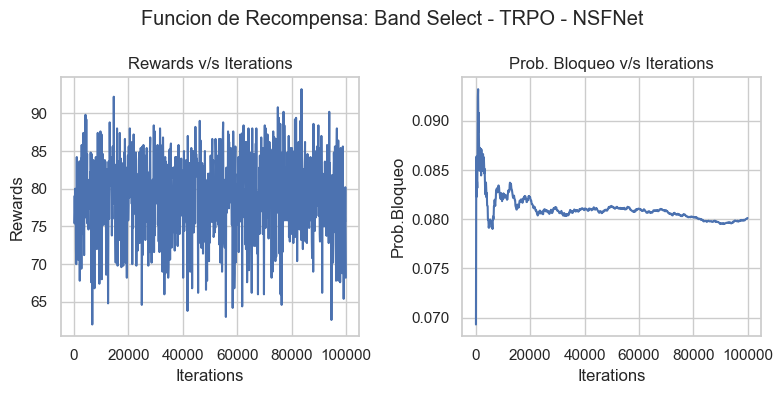

In [14]:
graph_Rewards_Bloqueo(x, rewardsArrayBS_TRPO_NSFNet, probBloqueoArrayBS_TRPO_NSFNet, "Band Select", "TRPO", "NSFNet")


### 3) Funcion de Recompensa: Length Based (DONE)

#### 3.1) Data:

In [15]:
episodeRewardsArrayLB_TRPO_NSFNet=[93, 90, 90, 90, 78, 88, 84, 78, 70, 86, 84, 80, 90, 92, 90, 80, 96, 72, 90, 80, 84, 90, 86, 82, 88, 88, 90, 74, 82, 88, 84, 88, 88, 86, 74, 72, 88, 92, 84, 78, 74, 80, 82, 90, 84, 74, 84, 92, 80, 78, 86, 78, 84, 84, 90, 94, 82, 82, 88, 80, 90, 88, 98, 88, 90, 80, 78, 76, 86, 84, 92, 76, 88, 82, 78, 84, 84, 90, 80, 88, 84, 90, 92, 82, 92, 82, 78, 88, 78, 80, 84, 82, 80, 82, 90, 70, 90, 82, 74, 92, 84, 84, 82, 84, 84, 74, 76, 86, 82, 86, 80, 86, 76, 86, 86, 88, 92, 94, 82, 88, 80, 86, 84, 82, 74, 80, 82, 76, 90, 80, 82, 82, 84, 86, 92, 84, 88, 86, 70, 88, 84, 90, 82, 84, 80, 70, 88, 92, 92, 82, 86, 86, 84, 96, 78, 78, 78, 78, 86, 78, 84, 82, 84, 88, 82, 82, 90, 88, 94, 86, 86, 92, 78, 74, 82, 86, 82, 84, 90, 84, 78, 80, 86, 90, 86, 76, 86, 80, 74, 90, 88, 82, 86, 76, 84, 80, 96, 76, 82, 86, 86, 72, 86, 92, 86, 86, 78, 90, 88, 90, 78, 92, 82, 86, 74, 80, 82, 94, 80, 78, 90, 88, 88, 84, 88, 86, 80, 78, 86, 80, 88, 86, 90, 84, 88, 74, 84, 74, 90, 88, 82, 76, 86, 90, 90, 82, 80, 68, 84, 84, 88, 82, 76, 94, 86, 86, 82, 80, 78, 84, 92, 80, 90, 88, 82, 92, 88, 88, 86, 92, 92, 88, 86, 84, 80, 88, 80, 84, 86, 88, 80, 90, 80, 80, 84, 86, 86, 92, 86, 86, 76, 80, 90, 84, 70, 92, 86, 82, 90, 86, 90, 86, 82, 80, 80, 88, 88, 86, 86, 84, 88, 88, 84, 82, 84, 88, 80, 92, 90, 78, 80, 92, 90, 94, 86, 86, 84, 74, 80, 84, 84, 78, 86, 74, 76, 84, 84, 88, 92, 90, 92, 88, 82, 92, 86, 92, 84, 86, 96, 76, 86, 90, 72, 90, 90, 80, 90, 90, 88, 78, 88, 70, 86, 72, 90, 76, 82, 72, 92, 88, 84, 84, 74, 82, 88, 90, 84, 90, 80, 92, 84, 84, 90, 90, 82, 90, 88, 92, 86, 80, 80, 76, 90, 86, 90, 82, 84, 86, 86, 72, 84, 86, 78, 82, 74, 84, 92, 82, 80, 86, 84, 84, 88, 88, 90, 82, 80, 78, 84, 88, 80, 80, 86, 90, 80, 84, 98, 90, 86, 84, 82, 82, 88, 82, 88, 78, 76, 86, 84, 92, 92, 84, 86, 90, 88, 82, 86, 86, 68, 86, 82, 76, 84, 88, 86, 86, 90, 82, 80, 92, 78, 76, 84, 86, 80, 92, 88, 82, 88, 82, 84, 90, 88, 94, 82, 84, 86, 82, 82, 92, 84, 78, 90, 88, 82, 86, 74, 84, 78, 80, 84, 90, 86, 76, 86, 76, 88, 88, 88, 82, 80, 86, 80, 86, 88, 92, 80, 78, 84, 80, 90, 82, 82, 82, 82, 78, 86, 84, 92, 76, 86, 84, 92, 88, 84, 96, 86, 90, 84, 76, 88, 82, 78, 84, 88, 90, 72, 86, 92, 82, 86, 82, 76, 82, 90, 78, 86, 88, 82, 76, 92, 88, 88, 88, 88, 84, 90, 80, 86, 88, 80, 82, 84, 80, 82, 88, 86, 86, 80, 84, 82, 76, 94, 88, 88, 82, 80, 72, 82, 82, 78, 84, 92, 84, 80, 74, 86, 88, 82, 86, 90, 84, 86, 80, 92, 80, 86, 78, 84, 82, 82, 90, 88, 86, 80, 82, 80, 84, 82, 86, 80, 80, 84, 88, 86, 82, 80, 82, 84, 80, 88, 86, 90, 92, 92, 86, 84, 72, 70, 86, 90, 86, 80, 88, 94, 90, 78, 82, 80, 86, 84, 96, 86, 88, 84, 80, 86, 86, 92, 84, 82, 78, 86, 78, 80, 90, 68, 90, 80, 82, 82, 84, 86, 84, 82, 90, 84, 88, 86, 82, 84, 86, 86, 90, 84, 82, 68, 80, 86, 90, 82, 88, 82, 90, 84, 90, 90, 84, 84, 82, 86, 82, 76, 84, 74, 76, 84, 84, 80, 88, 78, 88, 80, 90, 78, 86, 78, 70, 84, 90, 78, 76, 82, 76, 76, 90, 82, 90, 90, 84, 80, 90, 86, 90, 86, 92, 96, 80, 80, 74, 96, 78, 86, 86, 88, 70, 84, 90, 84, 90, 78, 82, 88, 78, 86, 80, 86, 84, 88, 74, 80, 84, 86, 84, 86, 90, 90, 82, 90, 80, 82, 88, 76, 82, 84, 88, 88, 84, 98, 82, 90, 84, 86, 90, 84, 94, 88, 82, 86, 78, 80, 86, 84, 86, 74, 82, 78, 82, 76, 90, 94, 86, 90, 90, 90, 88, 82, 80, 88, 80, 84, 80, 92, 86, 88, 82, 78, 86, 78, 88, 76, 90, 88, 74, 92, 76, 82, 82, 92, 84, 88, 84, 80, 84, 88, 90, 82, 82, 88, 84, 84, 90, 90, 92, 86, 86, 92, 90, 84, 80, 90, 88, 88, 90, 90, 80, 98, 80, 86, 90, 80, 76, 90, 76, 84, 92, 88, 86, 86, 90, 82, 82, 90, 90, 82, 84, 92, 86, 90, 86, 84, 84, 82, 90, 82, 78, 86, 82, 86, 78, 82, 86, 72, 86, 70, 94, 90, 84, 94, 80, 82, 92, 90, 80, 84, 82, 86, 80, 78, 90, 86, 82, 86, 90, 80, 80, 88, 80, 84, 84, 80, 88, 86, 80, 88, 84, 92, 80, 78, 88, 92, 78, 82, 80, 86, 88, 88, 84, 78, 78, 88, 78, 88, 78, 82, 92, 74, 76, 84, 86, 84, 88, 86, 86, 88, 80, 82, 94, 92, 86, 82, 86, 88, 80, 86, 84, 74, 86, 90, 92, 90, 80, 84, 78, 84, 90, 78, 90, 82, 78, 88, 90, 82, 82, 82, 84, 86, 90, 84, 94, 82, 90, 86, 86, 80, 86, 80, 80, 72, 82, 78, 88, 90, 80, 78, 84, 90, 82, 86, 88, 76, 82, 82, 84, 82, 86, 86, 90, 80, 80, 90, 86, 82, 84, 82, 82, 86, 88, 90, 78]
rewardsArrayLB_TRPO_NSFNet=[0, 86, 86, 84, 86, 90, 86, 88, 72, 88, 84, 80, 94, 92, 76, 70, 84, 88, 84, 82, 78, 80, 78, 84, 92, 74, 88, 84, 92, 72, 82, 80, 84, 78, 92, 94, 88, 76, 88, 86, 82, 88, 94, 92, 92, 82, 78, 78, 86, 84, 86, 88, 76, 84, 80, 82, 88, 80, 90, 84, 82, 94, 90, 86, 88, 90, 76, 82, 84, 82, 74, 90, 80, 80, 84, 82, 80, 90, 72, 84, 86, 80, 86, 84, 86, 80, 72, 84, 82, 88, 80, 86, 78, 78, 92, 88, 88, 94, 84, 88, 84, 86, 80, 84, 76, 76, 86, 74, 86, 86, 76, 88, 80, 86, 90, 84, 90, 86, 78, 78, 86, 88, 84, 78, 84, 80, 78, 88, 96, 86, 82, 90, 82, 90, 90, 74, 78, 80, 84, 78, 84, 76, 90, 86, 80, 82, 92, 84, 92, 90, 88, 86, 88, 72, 84, 78, 94, 74, 88, 88, 80, 82, 80, 92, 84, 82, 86, 74, 80, 84, 92, 80, 90, 74, 84, 84, 82, 84, 84, 84, 86, 74, 84, 88, 86, 90, 76, 88, 92, 88, 80, 88, 88, 84, 82, 74, 82, 84, 96, 76, 78, 92, 86, 90, 86, 82, 82, 80, 82, 86, 84, 88, 90, 84, 86, 86, 76, 80, 82, 90, 80, 78, 86, 86, 90, 84, 82, 72, 78, 86, 86, 86, 82, 80, 88, 84, 88, 82, 76, 82, 86, 86, 86, 90, 82, 90, 86, 90, 86, 90, 98, 88, 88, 80, 84, 84, 82, 84, 82, 90, 88, 80, 86, 76, 84, 86, 88, 90, 88, 88, 84, 76, 84, 86, 76, 82, 80, 92, 86, 88, 90, 86, 82, 82, 78, 84, 88, 88, 88, 82, 86, 92, 84, 86, 82, 80, 92, 78, 96, 84, 78, 86, 88, 96, 90, 84, 92, 70, 82, 78, 92, 74, 84, 80, 74, 78, 90, 80, 92, 88, 92, 98, 82, 86, 88, 88, 90, 84, 90, 94, 70, 88, 82, 82, 90, 90, 84, 88, 84, 88, 80, 80, 76, 82, 82, 84, 74, 78, 88, 90, 80, 84, 82, 76, 90, 88, 82, 88, 90, 82, 90, 82, 88, 92, 82, 88, 88, 88, 84, 88, 80, 82, 80, 90, 88, 88, 82, 80, 88, 86, 72, 84, 82, 80, 82, 78, 86, 92, 76, 84, 90, 78, 88, 82, 92, 84, 84, 76, 80, 92, 82, 80, 80, 92, 80, 86, 92, 92, 88, 86, 86, 82, 84, 88, 84, 78, 80, 78, 90, 82, 94, 88, 88, 84, 90, 84, 84, 86, 70, 82, 88, 84, 74, 86, 84, 88, 88, 90, 76, 88, 88, 72, 86, 80, 86, 80, 90, 86, 86, 90, 80, 84, 94, 86, 88, 90, 88, 78, 80, 88, 86, 80, 92, 86, 84, 84, 80, 78, 84, 76, 82, 88, 88, 78, 80, 84, 82, 88, 88, 88, 78, 88, 78, 80, 90, 88, 90, 76, 78, 88, 84, 86, 82, 80, 86, 78, 82, 82, 90, 84, 78, 92, 86, 88, 84, 92, 92, 88, 84, 80, 80, 90, 84, 78, 84, 90, 78, 80, 88, 88, 82, 90, 76, 82, 84, 86, 80, 84, 86, 84, 78, 92, 86, 94, 82, 86, 90, 80, 88, 86, 86, 86, 80, 82, 76, 86, 86, 86, 90, 70, 90, 82, 78, 94, 84, 86, 86, 78, 76, 82, 80, 82, 84, 86, 84, 80, 76, 86, 90, 80, 88, 88, 88, 78, 86, 86, 88, 80, 84, 80, 82, 82, 90, 90, 78, 86, 78, 86, 82, 82, 86, 78, 80, 90, 86, 84, 80, 84, 74, 88, 84, 86, 88, 92, 88, 90, 86, 84, 66, 80, 88, 88, 80, 88, 90, 90, 86, 78, 74, 88, 86, 90, 92, 92, 82, 82, 82, 90, 88, 88, 80, 80, 82, 80, 82, 84, 88, 70, 90, 78, 84, 82, 86, 80, 86, 86, 84, 88, 86, 90, 80, 84, 84, 90, 88, 82, 76, 70, 86, 84, 86, 90, 84, 84, 90, 88, 86, 84, 90, 80, 88, 82, 78, 82, 76, 78, 80, 78, 88, 78, 88, 82, 84, 88, 84, 80, 84, 66, 82, 86, 80, 78, 80, 84, 70, 88, 88, 84, 92, 82, 86, 84, 92, 84, 84, 92, 92, 90, 82, 80, 80, 90, 78, 88, 88, 76, 78, 88, 88, 88, 82, 76, 88, 86, 80, 82, 82, 84, 86, 84, 74, 84, 90, 82, 78, 94, 88, 88, 84, 86, 82, 84, 84, 78, 86, 80, 90, 86, 90, 98, 82, 88, 82, 88, 86, 88, 94, 88, 80, 78, 80, 82, 88, 82, 80, 82, 78, 80, 84, 76, 96, 90, 88, 92, 86, 86, 88, 78, 90, 82, 86, 80, 84, 90, 88, 88, 74, 84, 82, 84, 82, 80, 94, 76, 84, 86, 78, 80, 86, 88, 90, 88, 76, 82, 90, 86, 90, 86, 78, 88, 84, 86, 90, 90, 90, 90, 84, 88, 88, 86, 84, 88, 90, 90, 86, 90, 86, 84, 86, 90, 88, 76, 82, 82, 78, 90, 88, 92, 84, 86, 88, 86, 82, 92, 82, 90, 82, 90, 88, 88, 80, 88, 84, 84, 82, 84, 88, 80, 82, 84, 80, 82, 82, 76, 82, 78, 94, 88, 86, 92, 74, 88, 88, 92, 82, 82, 84, 82, 80, 82, 88, 80, 88, 88, 86, 76, 88, 84, 80, 84, 86, 80, 88, 84, 82, 94, 78, 82, 88, 82, 92, 82, 84, 74, 90, 82, 86, 90, 76, 86, 80, 86, 78, 84, 82, 86, 82, 78, 78, 84, 82, 88, 86, 90, 86, 82, 84, 84, 96, 86, 88, 84, 90, 86, 76, 90, 74, 86, 82, 94, 92, 82, 84, 74, 94, 78, 84, 84, 84, 80, 88, 86, 86, 80, 86, 78, 88, 92, 84, 92, 88, 86, 86, 84, 86, 86, 78, 78, 84, 72, 74, 88, 86, 86, 84, 76, 88, 90, 80, 90, 82, 78, 84, 84, 78, 80, 88, 90, 88, 78, 84, 92, 82, 86, 76, 84, 86, 92, 84, 80]
probBloqueoArrayLB_TRPO_NSFNet=[0.0, 0.06930693069306931, 0.06965174129353234, 0.07308970099667775, 0.07231920199501247, 0.06786427145708583, 0.06821963394342762, 0.06704707560627675, 0.07615480649188515, 0.07436182019977802, 0.07492507492507493, 0.07720254314259764, 0.07327227310574522, 0.07071483474250577, 0.07423269093504639, 0.07928047968021319, 0.07932542161149282, 0.07818930041152264, 0.07828983897834536, 0.07890583903208838, 0.08045977011494253, 0.08138981437410757, 0.08268968650613358, 0.08257279443720121, 0.0807996668054977, 0.08276689324270292, 0.08189158016147635, 0.08182154757497223, 0.08032845412352731, 0.08238538435022406, 0.08263912029323559, 0.08319896807481457, 0.0830990315526398, 0.0839139654650106, 0.0826227580123493, 0.08111968009140245, 0.08053318522632602, 0.08159956768440962, 0.08103130755064457, 0.0807485260189695, 0.08097975506123468, 0.08046817849305048, 0.07926684122827898, 0.07835387119274587, 0.07748239036582595, 0.07776049766718507, 0.07846120408606824, 0.07913209955328654, 0.07894188710685274, 0.07896347684146092, 0.07878424315136973, 0.07841599686336012, 0.07921553547394732, 0.07923033389926429, 0.07961488613219773, 0.07980367205962552, 0.07945009819675058, 0.07981055955095598, 0.07929667298741597, 0.07930859176410777, 0.07948675220796533, 0.07867562694640223, 0.07821319142073858, 0.07808284399301699, 0.07780034369629746, 0.07737271189047838, 0.07801848204817452, 0.07819728398746456, 0.07822379061902661, 0.07839443558904506, 0.0791315526353378, 0.07872130685818898, 0.07901680322177475, 0.07930420490343788, 0.07931360626942305, 0.07945607252366352, 0.07972635179581634, 0.07934034540968705, 0.08011793359825663, 0.08011644095684091, 0.07999000124984378, 0.08023700777681768, 0.08011218144128765, 0.08011083002047946, 0.07999047732412808, 0.08022585578167274, 0.08092082316009766, 0.08091024020227561, 0.08101352119077378, 0.08077744073699585, 0.0809910009998889, 0.08087023404021536, 0.08118682751874796, 0.0814966132673906, 0.08105520689288373, 0.08083359646353015, 0.08061660243724612, 0.08009483558396041, 0.08009386797265586, 0.07989092010907989, 0.07989201079892011, 0.07979407979407979, 0.07999215763160475, 0.07999223376371226, 0.08037688683780406, 0.08075421388439197, 0.08065276860673522, 0.08111391458742173, 0.08101101749837979, 0.0809100082561233, 0.08126533951458959, 0.08107377713719485, 0.08124274618337649, 0.08114326165826033, 0.0808700991141128, 0.08086253369272237, 0.08059650030169813, 0.08050593966327664, 0.08075586814676722, 0.08100159650449543, 0.08090992417298558, 0.0807371291628791, 0.08073108761576919, 0.08096902690838144, 0.08096121280541892, 0.08111351091912647, 0.08134275057535116, 0.08117471065270451, 0.08069682056089368, 0.08061390589876753, 0.08068610106914853, 0.08045187390275552, 0.08052420271191577, 0.08029471468310653, 0.08006865159316469, 0.08043848603807126, 0.0806558341298434, 0.08079702211517407, 0.08079124701108616, 0.0810013668081433, 0.08099421469895007, 0.08127083185589674, 0.08105063023730723, 0.08097335850639815, 0.08110547878619541, 0.08116681608164954, 0.08088487089925347, 0.08087885177879056, 0.0806026619822985, 0.0803972887725656, 0.08026131591227252, 0.0801933646778359, 0.08006052233405697, 0.08045225802235148, 0.08044932147263165, 0.08063995871234114, 0.08031536439971797, 0.08063180689128081, 0.08050123409910766, 0.0803723036287026, 0.08049496906443347, 0.0805540028569654, 0.08067403246713166, 0.08042451383350714, 0.08042192549234803, 0.08047997091085389, 0.08041684235889404, 0.08071372971678342, 0.08082852211177906, 0.08082361990414769, 0.0805834950885242, 0.08069703526109584, 0.08051857450148248, 0.08080457777007109, 0.08079995402563071, 0.08079538312096451, 0.08084767910914152, 0.08084289023219027, 0.08083815515982248, 0.08083347299033573, 0.08077329037275707, 0.08104524611899895, 0.08103950332399319, 0.08092453964264248, 0.08086517037117548, 0.0806983406302362, 0.08090962851459599, 0.08079781829848671, 0.08058082016913994, 0.08047193270197343, 0.08057470659438977, 0.08046699125700225, 0.08036039789594292, 0.08035853064608052, 0.0804082263800835, 0.08066253012666016, 0.08071016784857915, 0.08070656311862343, 0.08039997979900006, 0.08059896487613688, 0.0807459627018649, 0.08054325655440028, 0.08049106479877234, 0.08034086990788632, 0.08029018185383069, 0.0803375445100239, 0.08038444735692442, 0.08047920390319309, 0.0805249747608288, 0.08047461843930913, 0.080472358459121, 0.0803753376617222, 0.08023206452525825, 0.08023097507159288, 0.08018316901079389, 0.0801358076368541, 0.08032035553909542, 0.08041104096585411, 0.08045502499885326, 0.08031596730742889, 0.08040543611654016, 0.08053934211121669, 0.0804918697355975, 0.08044482310210305, 0.08030891478059016, 0.08030754188702724, 0.08035042697225786, 0.08061318884630633, 0.08074207271610895, 0.08069516614994979, 0.08064866744924133, 0.080602571317259, 0.08064307572949442, 0.08072614909231364, 0.08063757959061578, 0.08063486660142122, 0.08054743443074446, 0.08058731699084427, 0.0807529095416159, 0.08079159867787959, 0.0807466355568518, 0.08070204555827559, 0.08065782405685716, 0.08053166536356529, 0.08057046842342527, 0.08044569609403698, 0.0804032356408276, 0.08028015060119023, 0.08023870005241725, 0.0801172643668929, 0.07983680652773889, 0.07975777857455878, 0.07967937780246816, 0.07975969329275523, 0.07976063934490768, 0.07976157797733423, 0.07980157025116207, 0.07980234232131045, 0.07984186659431805, 0.07972665148063782, 0.0796507826622053, 0.07972874602505652, 0.07969161482386168, 0.07984487281852401, 0.0798454603992273, 0.07980830912041055, 0.07973384459230856, 0.07962248604921164, 0.07954927054960635, 0.07947659938292256, 0.07947853783193215, 0.07962805800523966, 0.07962942538877248, 0.07959415406029083, 0.07974161526951572, 0.07977891713028618, 0.07985217926886708, 0.07970831377928594, 0.07967339304341571, 0.07960288161714633, 0.07949716081568516, 0.07946336429308566, 0.07950072692457714, 0.07953782551853292, 0.0796450829196155, 0.07964632819901056, 0.07957763714555435, 0.07950942475871921, 0.07944168605256761, 0.07947821874675617, 0.07944553636081514, 0.07930998934744511, 0.07931235231670149, 0.07928057062898877, 0.07931703003299208, 0.07938713941900274, 0.07925407925407925, 0.07935759738729335, 0.07915841750276836, 0.0791612320658172, 0.07926402453251559, 0.07923324806484834, 0.07916956392172445, 0.0789742912775156, 0.07887898424393934, 0.07888265958493164, 0.07875559622234568, 0.07898765512524022, 0.07902340833089835, 0.07912365295621501, 0.07899745169510661, 0.07916144175428443, 0.07916412935482837, 0.07923069550493594, 0.07939237603897965, 0.0794895400146027, 0.07939622163855574, 0.07946121573451942, 0.07933712776327788, 0.07927651170809692, 0.07915377644448611, 0.07893835083019221, 0.07897270271109592, 0.07894492430574905, 0.07888645412178637, 0.07882834374326944, 0.07873991595349836, 0.07874376930369102, 0.07865613853236182, 0.07850825202881372, 0.07872488712463259, 0.07866831817769857, 0.07870244872142405, 0.07873637428305456, 0.07865033981018532, 0.07856481896062804, 0.07856909020564865, 0.07851399068276906, 0.07851838702996952, 0.0784637621309106, 0.07852710214405459, 0.0785900706724143, 0.0787111487968188, 0.07874405993994345, 0.07877677974477486, 0.07878032520796499, 0.07892835467183029, 0.07901789573787499, 0.0789632481825235, 0.07888026131056416, 0.07894060169709437, 0.07894361983989061, 0.07897502911849096, 0.07909124387411122, 0.07900906754046495, 0.07895552237965128, 0.07898654532176062, 0.07893336321111454, 0.07885254601826765, 0.07888359655719897, 0.07880336657315075, 0.07883438131907704, 0.07878235407861661, 0.07867551858075535, 0.07870662893876541, 0.07865537930467659, 0.07860440971558154, 0.07855371788234652, 0.07855764789000298, 0.07850735752418633, 0.0785654441771844, 0.07859626425163742, 0.07865379962904223, 0.07857698185035254, 0.07852731210395444, 0.07847790725580651, 0.07850855030451317, 0.0785655552903106, 0.07851644136398508, 0.07849397113532625, 0.07865582484671456, 0.0786593527728931, 0.07868903955393838, 0.07874468029555363, 0.07877399026067029, 0.07885509467286564, 0.0788321546073936, 0.07873181571535619, 0.07883817427385892, 0.07884116089560679, 0.07876721109715136, 0.07884708830976189, 0.07879901022933089, 0.07882751075036258, 0.07872896626989162, 0.07873218399534189, 0.07873538547006388, 0.07883932394650009, 0.07889249013843873, 0.07879501766873011, 0.07882302942426439, 0.07887583850776789, 0.07892838486604811, 0.07883179077442247, 0.07888418603499914, 0.07886225031480704, 0.07876653284401862, 0.07867128571779564, 0.07862552388421852, 0.07860443509938632, 0.07858344918416624, 0.07861122600423347, 0.078614596733089, 0.07856952616159416, 0.0785729813289534, 0.07864870726006602, 0.07870003124924882, 0.07877508932639506, 0.07870625104662568, 0.0787332044581275, 0.078617175781529, 0.07857295551174556, 0.07852894481173432, 0.07853242240136167, 0.07846513053937407, 0.078468741911955, 0.07847233633013309, 0.0784524952577223, 0.07861965841919581, 0.07864618540360364, 0.07860282319015836, 0.07860606482448203, 0.07872502951320572, 0.07870487979492391, 0.07870786387410428, 0.07866485827912002, 0.07862204995298273, 0.07855655476991373, 0.07865117234766329, 0.0786086877292089, 0.07856639621826776, 0.07870569828348563, 0.07868600257912717, 0.07873411435407779, 0.0787144433683926, 0.07876227500505606, 0.07869778704513351, 0.07867832934386255, 0.07865895850539051, 0.07859513151154762, 0.07864269682895936, 0.07864570630362963, 0.0785380854405876, 0.07851923798591642, 0.0784784476112861, 0.07841585899211007, 0.07837547422205654, 0.0784446729830857, 0.0784917359882972, 0.07845144985948019, 0.07843307754179257, 0.07847985943905772, 0.07839657150278133, 0.07837843675082612, 0.07838193142389173, 0.07838541106642868, 0.07843179330915645, 0.07849938973469518, 0.07850259609837397, 0.07859107481716808, 0.07861534860960405, 0.07857582641557503, 0.07853647168492194, 0.07860298936597535, 0.07864812978629143, 0.07865097576893118, 0.0786748177559295, 0.07863566801534559, 0.0785966820777808, 0.07855785891735037, 0.07862336201329138, 0.07858464480987921, 0.07864982054314226, 0.07869402289807664, 0.07863473895167455, 0.07859631760169894, 0.07853747865270262, 0.07862261555204206, 0.07868691215343948, 0.07864869839062597, 0.0786514560927328, 0.07863383637807785, 0.07865693786711653, 0.07870022920427577, 0.07868261776077408, 0.07874588392153693, 0.07876857321424971, 0.07879117120379872, 0.07873335876789622, 0.0787358970762109, 0.07879842403151938, 0.07872098361310154, 0.07870361148184299, 0.07866642810282101, 0.078669074026309, 0.07859250311875013, 0.07851623485701864, 0.07847971440405514, 0.07848270703332612, 0.07852497986287106, 0.07856708691986432, 0.0785111837341735, 0.07851409152164997, 0.07857546636517806, 0.07857823777747515, 0.07852274713112367, 0.07858374837696944, 0.07862517166012263, 0.07858921642439336, 0.07855339974181615, 0.07857541201130748, 0.07852056582407248, 0.07860002681940959, 0.07862182367449953, 0.07862445373179901, 0.0786080265137807, 0.0786486948917321, 0.07865125898939299, 0.07863487433950114, 0.07863745486852801, 0.07869662836550254, 0.07862375473154931, 0.07860754497095919, 0.07851635053751337, 0.0785378550963465, 0.07852189678697595, 0.07846868528572228, 0.0785087800972049, 0.07847437779966915, 0.07845865568356802, 0.07844299179644822, 0.0784273858154193, 0.07846718695227026, 0.07848842562752067, 0.078564732265951, 0.07854901744922112, 0.07853336019486823, 0.0785177601871995, 0.07846572142844109, 0.07859601828746289, 0.07854402647224595, 0.07856481733543856, 0.07862176409847647, 0.0785338420643388, 0.07853648851103771, 0.07852110772778868, 0.07850578227010306, 0.07856232383619684, 0.07863658357377108, 0.07865691132537879, 0.0786950233031553, 0.07871517441756831, 0.0787174605434067, 0.07870197687430064, 0.07870427829293807, 0.07874196916868728, 0.07881486192823449, 0.07879931570871766, 0.07874861358074682, 0.07878596158239749, 0.07875300433325731, 0.0787201625190452, 0.0786874355343438, 0.07874208129002984, 0.07872685144858103, 0.07871167457957252, 0.07867918959740282, 0.07871614010155803, 0.0787183612740264, 0.07875511649194314, 0.078774503887864, 0.0787938245469097, 0.0787443514716242, 0.07869504811238229, 0.07874865156418555, 0.07873369685988274, 0.07878705141550485, 0.07877208224732117, 0.07879117702079896, 0.07881020695743705, 0.07879527465636176, 0.0788480736366559, 0.07888380263846895, 0.07883509552958634, 0.0788202218817865, 0.0788222046688291, 0.07885773728628714, 0.07885965059211739, 0.07894516814100098, 0.07891354067544783, 0.07891535141080983, 0.07890051746227185, 0.0788691217753858, 0.07880466327258255, 0.07877353023956557, 0.07872597147154592, 0.07871157241629675, 0.07871369499678753, 0.07886383447640664, 0.07889854025385462, 0.07886755954820412, 0.0788366802507324, 0.07887126027352494, 0.07884047568555162, 0.07879350499177538, 0.07874668704573909, 0.07873248810895928, 0.07878316396816908, 0.07886603776637918, 0.07883556000710812, 0.07882130933372042, 0.07877489895492826, 0.078712560891304, 0.07865042294666218, 0.07866861107995064, 0.0786867410121438, 0.07870481302215619, 0.07865903255131497, 0.07862932118915304, 0.07859970429722898, 0.07863367248138918, 0.07866753300264655, 0.0786854638375975, 0.07871913555867996, 0.07873692843961452, 0.07873891749736224, 0.07870945425386393, 0.07882136858134095, 0.07877619473049012, 0.07882505751083707, 0.07882689332979172, 0.07884432380150076, 0.07883054781078176, 0.07886347024152035, 0.07884970730268163, 0.07883598703896064, 0.0788377888887169, 0.07880867374538261, 0.07879508032283453, 0.07875071262384246, 0.07878340333225643, 0.0787852721156357, 0.07878713516663854, 0.07874305140809482, 0.07871439274628829, 0.07873162241797835, 0.07879453057118031, 0.07890290863152769, 0.07888937858087264, 0.07889106386853006, 0.07887759276374601, 0.07883390568977776, 0.07883566713493755, 0.0788374232666174, 0.07879399406635443, 0.07876573284612262, 0.07875257128271347, 0.07875444146264673, 0.07871139653598, 0.07874321759017056, 0.07871524305607379, 0.07873206062502794, 0.07877858960432137, 0.07879526307187115, 0.07885639678936514, 0.07890253477726256, 0.0789337435836748, 0.07897963102465251, 0.07895163788144717, 0.07899736380907497, 0.07896942692019235, 0.07898562429332903, 0.07898711162592924, 0.07895931245516172, 0.07896083390593704, 0.07899154756864864, 0.0789930175944957, 0.07912548580078893, 0.0791412915509949, 0.0791280242667015, 0.07915827306850626, 0.0792029058913764, 0.07923295906128525, 0.07923406588649515, 0.07933603262200833, 0.07930821139264184, 0.0792804701081881, 0.0792815024174689, 0.07922522599962752, 0.07924064033418692, 0.0792274396080056, 0.07922854167558237, 0.07917266135810032, 0.07917383820998279, 0.07917501171858354, 0.0791194451142537, 0.0790640359201711, 0.07902292753992164, 0.07903843166056977, 0.07906799622008152, 0.0790974775003169, 0.07905655335367998, 0.0791000126402719, 0.07907322477945611, 0.07904651195361409, 0.07910378875819919, 0.07914693928855743, 0.07912023542210012, 0.07909360593863596, 0.07906705052780907, 0.07908223496895876, 0.07913898558965896, 0.07911247766651432, 0.07909987413728717, 0.07912874131572768, 0.07914373594846967, 0.07915868927425242, 0.07915984649454616, 0.07914726446065301, 0.07914843417785765, 0.07921809290283695, 0.07921916252855637, 0.07917924618516141, 0.07919400826728148, 0.07923597771147532, 0.07916899089808302, 0.07914294642735832, 0.07911697263266441, 0.07911816913049959, 0.07910583077360252, 0.07912055242496722, 0.07912173924778343, 0.07912292287165941, 0.07916447961669426, 0.07915216193330735, 0.07918014523294989, 0.07914103028109543, 0.07912879345658023, 0.07908985173995, 0.07899761017876931, 0.07901227983626885, 0.07898696422151502, 0.07900160902115663, 0.0789763748157395, 0.07896446996724181, 0.07893935179666495, 0.07887461806060767, 0.07884968494471671, 0.07887758736692128, 0.07891859132290747, 0.07894632965355719, 0.07896085465368392, 0.0789359719688718, 0.07895047247087195, 0.07897802384785539, 0.07899243147148403, 0.07903291079750917, 0.07906024693289526, 0.07906147055376883, 0.07911470592059922, 0.07903793457227828, 0.07900027237000817, 0.0789756609370345, 0.07892524029443344, 0.0789137091252051, 0.07890220771344886, 0.07887784951224855, 0.07891790324448848, 0.0788807341807946, 0.07889500776626744, 0.07888360405635825, 0.07891064134902243, 0.07891203437296199, 0.0788751101518499, 0.07885103506332827, 0.07882702131183042, 0.0788921260543759, 0.07889353375433603, 0.07890762807578584, 0.0789090125600436, 0.07892305160694169, 0.07894969722253828, 0.07888789282963599, 0.07893973594280022, 0.07894107127114268, 0.07892982478207822, 0.07896885717516111, 0.07899524472716779, 0.0789839726319219, 0.0789602132639141, 0.07892401344983188, 0.07890038825982197, 0.07895163401952594, 0.07896539270992889, 0.07892936655016729, 0.07891827430715147, 0.07888239600004962, 0.07887138944994486, 0.07890991448125642, 0.0788865403394272, 0.07888791496401279, 0.07887695589450192, 0.07884139357889682, 0.07880591874638689, 0.07877053107455682, 0.07873523024257371, 0.07873678018651732, 0.07871384683174013, 0.07869096954804954, 0.0786803579931869, 0.07868196729308179, 0.0786592124334661, 0.07862434763567354, 0.07858956756297007, 0.07857914345699687, 0.0785445024908789, 0.07853415818210434, 0.07853593064170929, 0.07852562167123585, 0.078491212409983, 0.0784689341092276, 0.078518910723096, 0.07853270994339011, 0.0785464760327007, 0.07858418963801393, 0.0785499574855391, 0.07852776880659322, 0.07848173856943166, 0.07848355031562869, 0.07847343893398172, 0.07845144700658326, 0.07844139784306964, 0.07845512523604233, 0.07840950878400019, 0.07842324143078873, 0.07838960485674726, 0.07840332856585619, 0.07836979492567975, 0.07834813268711453, 0.07832652147795668, 0.0783520193880072, 0.07833045440124088, 0.07833241393880354, 0.07833436888195917, 0.07834802871160759, 0.0783499608191717, 0.07832852419948365, 0.07835381150745033, 0.07836738499551288, 0.07836928557292698, 0.07839443727398519, 0.07840791628436371, 0.07842136402129905, 0.07846954264724626, 0.07848288792953785, 0.07851932347602918, 0.07846329719056362, 0.07844200182235499, 0.07843227612585109, 0.07838805077041691, 0.07844737416811301, 0.07842619487721152, 0.07840506416210823, 0.07836107261085211, 0.0783743893090468, 0.07838767556942207, 0.07838951610141437, 0.07840275481465434, 0.07842735276363595, 0.0784405183103719, 0.07841956341405211, 0.0784440585237398, 0.07842314712985114, 0.07840228309985164, 0.07839277836223572, 0.07843979164077242, 0.07841897946975768, 0.07842076188543534, 0.07844506255560185, 0.07844681162191651, 0.07843732092897833, 0.07846152119504832, 0.07844082465443213, 0.07844257063190782, 0.07845549826064585, 0.0784013586440375, 0.0784366245912434, 0.0784495156129809, 0.07842897072415675, 0.07844184158129498, 0.07839912889856779, 0.07841200430627851, 0.07841376481413731, 0.07847089179521821, 0.07843939779427218, 0.07845217179920663, 0.07844284279422964, 0.07841148388661646, 0.07845728571271242, 0.07844798187038647, 0.07847166514653685, 0.07846236594548907, 0.07849694630541332, 0.07849859256744175, 0.0785111760265205, 0.07850187429645578, 0.07851442669839849, 0.07854876173651323, 0.07858302197143822, 0.07858456382411508, 0.07859697177204596, 0.078576779839524, 0.07856747757616511, 0.07853652723155762, 0.07852728866570709, 0.07853969146279499, 0.07854126845282448, 0.07854284204053893, 0.07847975776123102, 0.07847063002551102, 0.07845076934656617, 0.07845243337880367, 0.07842190534436326, 0.07841287874728031, 0.07845740409631588, 0.07842696869552197, 0.07848206749927886, 0.07847301522929317, 0.07848530399462693, 0.07843366950298719, 0.0783927830554994, 0.07840511790522948, 0.07840681096803644, 0.07846152214716705, 0.0784101863327719, 0.07844361435328727, 0.07844525956385238, 0.07844690129988068, 0.07844853957236737, 0.07847124898578518, 0.07845180577046558, 0.07844291858129777, 0.07843405006249934, 0.07845667936328056, 0.07844781501242125, 0.0784808536036272, 0.07846152236901288, 0.07842133311041682, 0.07842298097097107, 0.07838291571516459, 0.07836376704409329, 0.07835506394314315, 0.0783463789357699, 0.0783480960737687, 0.07833943631290131, 0.07833079449953886, 0.07836357801679071, 0.07839629373015791, 0.07839795043439633, 0.07846152258490624, 0.07851465448809807, 0.0784955870691342, 0.07848684684313947, 0.07847812458248117, 0.07847968706686789, 0.07852227156644548, 0.07850329402362681, 0.07847412001924238, 0.07849612989642232, 0.07846702280875578, 0.07847879103274456, 0.078510922416693, 0.0785124387735359, 0.07851395204524877, 0.07854594973628316, 0.07856773027684998, 0.07854889909838643, 0.07851997446834379, 0.07850122974463822, 0.07853307853307853, 0.0785345602569671, 0.07849567612839427, 0.07850727311216621, 0.07849870595462281, 0.07854045733946338, 0.07854192420176681, 0.07853334805875443, 0.07849469915045988, 0.07849620745283113, 0.07851773255522967]


#### 3.2) Rewards & Prob. Bloqueo (LB):

Rewards Stats w/  Length Based  :
Avg =  84.212
Std =  5.747613069788188
Min-Max Reward = 66 - 98
Last Prob Bloqueo = 0.07851773255522967


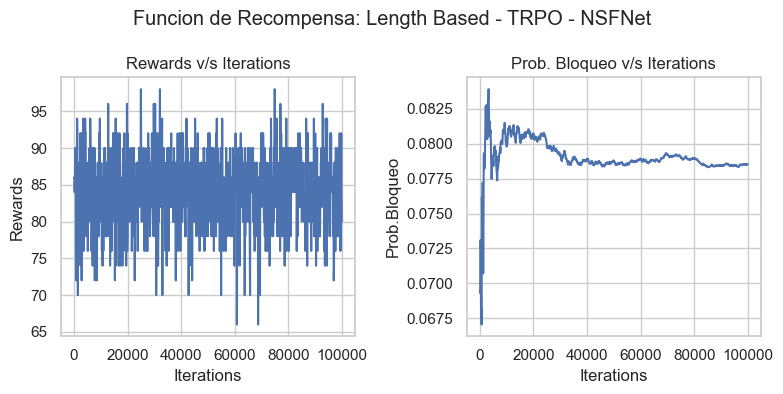

In [16]:
graph_Rewards_Bloqueo(x, rewardsArrayLB_TRPO_NSFNet, probBloqueoArrayLB_TRPO_NSFNet, "Length Based", "TRPO", "NSFNet")

## Agente PPO - Topologia EuroCore:

### 1) Funcion de Recompensa Caso Base: (DONE)

#### 1.1) Data:

In [17]:
episodeRewardsArrayCB_PPO_Euro=[87, 96, 94, 88, 90, 90, 90, 98, 92, 88, 90, 82, 80, 88, 92, 86, 92, 92, 90, 86, 92, 88, 92, 82, 88, 84, 90, 90, 84, 90, 96, 90, 96, 94, 90, 82, 100, 98, 96, 84, 98, 90, 92, 86, 90, 94, 92, 88, 90, 92, 90, 96, 86, 92, 92, 82, 92, 88, 82, 78, 90, 84, 90, 90, 84, 92, 84, 96, 94, 96, 96, 88, 92, 88, 82, 90, 92, 88, 90, 80, 88, 88, 86, 92, 86, 82, 90, 90, 90, 90, 86, 90, 88, 82, 78, 78, 86, 80, 90, 86, 94, 90, 96, 94, 92, 84, 82, 98, 90, 80, 98, 88, 90, 90, 96, 88, 92, 86, 88, 88, 80, 92, 92, 80, 98, 88, 90, 92, 86, 92, 86, 88, 94, 84, 92, 90, 84, 90, 88, 90, 94, 88, 88, 78, 82, 68, 92, 88, 92, 88, 94, 90, 88, 86, 90, 88, 86, 94, 88, 94, 88, 94, 92, 86, 88, 96, 88, 94, 86, 92, 78, 88, 90, 90, 88, 88, 88, 90, 86, 92, 90, 84, 82, 94, 80, 96, 88, 90, 84, 90, 96, 86, 90, 92, 94, 82, 90, 86, 82, 86, 90, 90, 94, 88, 92, 84, 92, 98, 96, 94, 92, 86, 86, 88, 84, 82, 92, 96, 90, 84, 86, 88, 88, 92, 88, 90, 94, 84, 86, 94, 100, 92, 92, 96, 90, 90, 98, 84, 94, 94, 90, 86, 92, 90, 90, 94, 88, 100, 86, 90, 94, 86, 92, 86, 90, 94, 88, 96, 90, 96, 92, 90, 86, 88, 88, 90, 86, 90, 94, 96, 90, 94, 86, 92, 90, 94, 94, 82, 90, 94, 88, 84, 92, 90, 94, 96, 88, 88, 84, 90, 86, 86, 86, 90, 84, 92, 86, 90, 88, 96, 92, 84, 84, 86, 88, 82, 88, 90, 72, 94, 86, 78, 86, 90, 90, 96, 80, 84, 88, 86, 86, 82, 90, 94, 80, 90, 94, 88, 86, 88, 92, 96, 92, 100, 82, 88, 90, 92, 96, 90, 90, 82, 92, 92, 86, 88, 90, 86, 78, 88, 92, 92, 92, 96, 90, 90, 88, 86, 88, 78, 92, 82, 84, 88, 86, 90, 90, 84, 92, 82, 86, 96, 90, 90, 96, 84, 90, 90, 90, 94, 84, 90, 94, 86, 86, 90, 86, 86, 88, 84, 84, 86, 88, 94, 82, 94, 94, 92, 92, 92, 86, 84, 94, 88, 90, 80, 90, 88, 88, 80, 86, 86, 90, 88, 96, 76, 90, 84, 88, 90, 84, 86, 92, 92, 92, 94, 88, 92, 84, 90, 88, 92, 100, 94, 94, 90, 90, 86, 90, 84, 94, 98, 84, 94, 90, 90, 96, 94, 90, 82, 92, 90, 96, 88, 88, 96, 86, 90, 76, 92, 90, 86, 90, 96, 84, 94, 90, 82, 92, 86, 86, 88, 88, 96, 88, 82, 84, 78, 84, 96, 82, 96, 90, 88, 88, 86, 86, 98, 80, 90, 92, 92, 84, 88, 90, 92, 92, 88, 82, 90, 86, 88, 90, 92, 94, 82, 80, 90, 86, 90, 90, 86, 86, 92, 92, 88, 88, 86, 88, 84, 88, 88, 94, 86, 90, 94, 88, 84, 82, 90, 94, 92, 76, 90, 84, 94, 74, 90, 94, 88, 96, 88, 84, 92, 94, 88, 94, 86, 92, 84, 86, 86, 94, 90, 90, 82, 86, 86, 94, 94, 86, 92, 96, 80, 86, 100, 96, 90, 90, 88, 94, 90, 90, 92, 86, 86, 84, 96, 90, 86, 92, 98, 94, 92, 94, 82, 90, 88, 92, 92, 92, 88, 96, 88, 96, 92, 86, 86, 98, 90, 86, 78, 88, 94, 90, 86, 90, 84, 82, 88, 88, 98, 90, 86, 84, 82, 90, 86, 88, 86, 94, 90, 94, 94, 90, 86, 80, 84, 86, 88, 94, 94, 80, 86, 96, 98, 78, 84, 96, 90, 88, 92, 94, 88, 90, 90, 90, 94, 96, 88, 88, 88, 88, 84, 96, 86, 92, 100, 90, 88, 92, 88, 90, 88, 80, 88, 90, 88, 90, 88, 80, 92, 90, 90, 84, 92, 86, 94, 96, 90, 94, 88, 90, 90, 90, 96, 90, 92, 96, 88, 92, 88, 84, 90, 86, 90, 92, 84, 90, 92, 82, 86, 88, 90, 90, 92, 90, 86, 96, 84, 88, 88, 88, 92, 88, 92, 94, 86, 88, 88, 88, 96, 96, 88, 88, 88, 88, 90, 90, 88, 90, 88, 84, 80, 86, 92, 90, 88, 94, 94, 94, 90, 90, 94, 86, 92, 92, 80, 90, 82, 84, 92, 88, 90, 88, 88, 90, 86, 90, 92, 84, 86, 84, 92, 94, 88, 86, 86, 86, 88, 86, 82, 86, 90, 90, 84, 92, 90, 84, 84, 80, 84, 88, 90, 84, 90, 86, 94, 90, 94, 96, 88, 88, 94, 94, 90, 86, 90, 92, 90, 90, 84, 92, 92, 90, 92, 88, 86, 92, 98, 88, 96, 92, 86, 84, 76, 86, 92, 82, 86, 86, 90, 86, 90, 94, 82, 90, 94, 86, 86, 86, 90, 86, 86, 82, 90, 86, 90, 88, 88, 88, 82, 94, 92, 94, 86, 86, 86, 84, 92, 94, 92, 92, 94, 84, 94, 94, 86, 84, 86, 90, 84, 84, 88, 82, 92, 94, 88, 86, 94, 94, 94, 94, 96, 88, 94, 84, 92, 92, 90, 82, 86, 92, 88, 88, 94, 90, 90, 92, 96, 88, 92, 86, 78, 94, 92, 82, 84, 92, 84, 92, 94, 94, 90, 86, 94, 84, 92, 78, 92, 86, 90, 84, 92, 82, 82, 78, 92, 70, 92, 88, 92, 82, 96, 90, 88, 96, 92, 94, 96, 96, 88, 90, 90, 92, 88, 92, 90, 90, 88, 90, 86, 76, 90, 92, 90, 84, 96, 92, 90, 88, 78, 84, 98, 86, 82, 90, 90, 90, 92, 84, 94, 92, 92, 86, 86, 90, 84, 86, 90, 92, 88, 92, 96, 92, 86, 96, 92, 80, 86, 86, 88, 80, 84, 90, 88, 86, 94, 92, 92, 92, 88, 90, 98, 88, 88, 86, 88, 90, 90, 88, 96, 90, 92, 82, 88, 86, 92, 86, 90, 90, 92, 86, 80, 86, 86, 92, 92, 88, 86]
rewardsArrayCB_PPO_Euro=[0, 96, 86, 92, 84, 88, 82, 90, 84, 90, 94, 94, 92, 98, 92, 84, 90, 100, 96, 92, 88, 94, 92, 90, 88, 90, 98, 88, 90, 92, 86, 92, 92, 90, 94, 90, 82, 90, 86, 82, 80, 84, 94, 90, 80, 94, 84, 94, 96, 92, 96, 90, 92, 86, 94, 78, 96, 90, 88, 86, 82, 90, 86, 90, 86, 86, 86, 90, 88, 96, 88, 84, 86, 82, 90, 72, 80, 80, 92, 86, 94, 90, 92, 96, 92, 84, 84, 94, 94, 86, 88, 94, 90, 84, 96, 92, 90, 88, 86, 88, 86, 90, 92, 84, 88, 92, 92, 90, 90, 86, 86, 90, 92, 90, 88, 88, 82, 92, 92, 90, 90, 88, 92, 80, 76, 80, 78, 94, 88, 88, 92, 96, 84, 92, 80, 94, 88, 86, 96, 88, 90, 96, 94, 84, 86, 94, 92, 92, 92, 84, 88, 84, 86, 90, 92, 84, 94, 82, 92, 86, 96, 88, 78, 90, 90, 84, 90, 88, 88, 90, 90, 90, 88, 94, 96, 88, 84, 84, 84, 90, 88, 86, 94, 90, 88, 92, 84, 96, 100, 92, 92, 94, 82, 86, 86, 84, 86, 94, 94, 84, 92, 86, 88, 88, 90, 92, 90, 88, 86, 90, 96, 96, 90, 98, 94, 84, 96, 90, 92, 90, 92, 88, 90, 96, 90, 90, 88, 96, 94, 86, 94, 90, 88, 88, 88, 94, 92, 90, 94, 94, 92, 90, 90, 86, 86, 90, 92, 84, 94, 96, 92, 90, 90, 90, 88, 94, 96, 84, 88, 92, 92, 88, 84, 92, 92, 94, 94, 88, 86, 88, 92, 80, 90, 86, 88, 86, 86, 92, 90, 88, 96, 92, 80, 90, 80, 88, 84, 86, 86, 78, 94, 82, 76, 92, 88, 94, 96, 78, 86, 82, 88, 86, 86, 90, 88, 84, 94, 88, 88, 86, 94, 90, 100, 92, 88, 86, 92, 88, 96, 92, 92, 84, 88, 94, 90, 82, 94, 84, 84, 86, 90, 88, 92, 92, 92, 96, 88, 86, 84, 90, 84, 86, 78, 86, 92, 86, 90, 82, 92, 88, 78, 96, 92, 92, 92, 96, 82, 92, 88, 92, 88, 90, 90, 92, 84, 86, 90, 84, 84, 92, 82, 88, 82, 90, 92, 86, 96, 92, 94, 94, 86, 84, 90, 90, 92, 82, 80, 100, 82, 82, 88, 84, 86, 90, 94, 86, 78, 84, 96, 88, 82, 92, 82, 94, 94, 90, 96, 84, 92, 84, 90, 90, 96, 100, 92, 92, 88, 86, 92, 86, 92, 94, 94, 86, 92, 90, 92, 92, 90, 86, 92, 90, 92, 92, 92, 90, 92, 88, 84, 84, 88, 92, 84, 94, 92, 88, 92, 88, 86, 90, 84, 86, 88, 92, 94, 84, 88, 80, 76, 92, 86, 90, 94, 90, 86, 82, 94, 90, 88, 84, 92, 92, 90, 86, 86, 96, 90, 90, 86, 86, 86, 84, 92, 88, 92, 90, 84, 88, 84, 86, 92, 86, 86, 90, 92, 88, 88, 92, 86, 84, 82, 96, 88, 90, 88, 92, 90, 90, 80, 84, 92, 94, 80, 86, 88, 90, 82, 82, 96, 84, 98, 90, 84, 92, 90, 96, 88, 94, 82, 92, 82, 86, 94, 88, 90, 84, 84, 88, 94, 90, 88, 92, 96, 88, 82, 92, 96, 96, 86, 92, 90, 94, 88, 96, 82, 94, 78, 92, 90, 90, 90, 94, 98, 92, 96, 82, 92, 82, 98, 84, 96, 92, 92, 90, 94, 92, 92, 84, 90, 96, 88, 80, 84, 88, 94, 88, 88, 90, 78, 86, 90, 92, 92, 92, 84, 88, 82, 86, 84, 90, 92, 94, 88, 96, 88, 92, 78, 88, 84, 86, 90, 96, 86, 82, 92, 98, 96, 72, 90, 94, 88, 88, 94, 94, 88, 90, 92, 88, 96, 96, 84, 88, 86, 88, 92, 88, 94, 92, 96, 88, 90, 92, 88, 86, 82, 86, 88, 90, 92, 88, 82, 86, 90, 94, 86, 88, 88, 92, 94, 92, 94, 90, 90, 88, 94, 88, 94, 92, 96, 90, 90, 88, 86, 88, 90, 86, 94, 86, 86, 90, 92, 84, 82, 86, 96, 94, 86, 92, 88, 88, 88, 84, 94, 86, 96, 86, 90, 90, 90, 88, 88, 94, 92, 94, 90, 86, 90, 86, 90, 88, 90, 90, 86, 78, 86, 86, 94, 92, 90, 94, 92, 92, 90, 94, 90, 86, 96, 82, 86, 92, 76, 90, 88, 90, 92, 88, 86, 88, 90, 88, 96, 80, 82, 90, 94, 90, 86, 88, 86, 84, 88, 84, 84, 88, 90, 84, 90, 92, 86, 84, 86, 80, 90, 84, 94, 80, 94, 88, 88, 92, 98, 86, 92, 88, 98, 92, 92, 80, 92, 92, 90, 92, 80, 94, 94, 94, 84, 94, 82, 96, 96, 90, 94, 88, 88, 82, 80, 86, 86, 82, 88, 90, 88, 86, 94, 86, 88, 94, 88, 82, 88, 88, 88, 92, 80, 88, 86, 86, 90, 86, 94, 82, 84, 96, 94, 92, 84, 84, 88, 84, 94, 96, 92, 90, 92, 88, 94, 90, 86, 80, 88, 90, 82, 88, 84, 90, 92, 90, 86, 92, 92, 94, 94, 96, 92, 94, 86, 84, 96, 90, 84, 84, 90, 88, 90, 92, 94, 90, 92, 94, 88, 92, 90, 84, 82, 98, 80, 84, 92, 86, 88, 90, 96, 92, 88, 90, 92, 86, 90, 82, 88, 86, 86, 92, 86, 80, 80, 86, 80, 80, 94, 86, 90, 88, 94, 84, 98, 88, 98, 92, 100, 88, 92, 86, 92, 90, 94, 88, 88, 92, 90, 86, 78, 88, 90, 90, 88, 90, 94, 92, 88, 80, 80, 96, 90, 86, 88, 86, 96, 86, 88, 90, 96, 90, 86, 88, 88, 86, 80, 94, 92, 90, 86, 96, 96, 90, 88, 96, 84, 82, 84, 90, 86, 78, 88, 88, 92, 86, 96, 90, 94, 90, 90, 90, 94, 86, 84, 92, 90, 88, 92, 90, 94, 86, 94, 84, 84, 92, 88, 84, 90, 94, 88, 84, 84, 80, 92, 98, 90, 84]
probBloqueoArrayCB_PPO_Euro=[0.0, 0.019801980198019802, 0.04477611940298507, 0.04318936877076412, 0.05236907730673317, 0.05389221556886228, 0.059900166389351084, 0.05848787446504993, 0.06117353308364544, 0.05993340732519423, 0.056943056943056944, 0.05449591280653951, 0.05328892589508743, 0.04996156802459646, 0.04925053533190578, 0.051299133910726186, 0.05121798875702686, 0.048206937095825984, 0.046640755136035536, 0.046291425565491845, 0.04697651174412794, 0.0461684911946692, 0.045888232621535664, 0.04606692742285962, 0.04664723032069971, 0.046781287485006, 0.04536716647443291, 0.04590892262125139, 0.04605498036415566, 0.04584625991037573, 0.04665111629456848, 0.04643663334408255, 0.04623555139019057, 0.0463495910330203, 0.04586886209938253, 0.045986860896886604, 0.04720910858094974, 0.047284517697919484, 0.04788213627992634, 0.04896180466547039, 0.05023744063984004, 0.0509631797122653, 0.050464175196381814, 0.050453382934201346, 0.0515791865485117, 0.051099755609864475, 0.05172788524233862, 0.051265688151457135, 0.05061445532180796, 0.050397877984084884, 0.04979004199160168, 0.04979415800823368, 0.04960584502980196, 0.049990567817392945, 0.0496204406591372, 0.05071805126340665, 0.05016961256918408, 0.05016663743202947, 0.05033614893983796, 0.0506693780715133, 0.05132477920346609, 0.05130306507129979, 0.0516045799064667, 0.05157911442628154, 0.051866895797531634, 0.05214582371942778, 0.052416300560521135, 0.05238024175496195, 0.05249228054697839, 0.052021446167222145, 0.05213540922725325, 0.05252781298408675, 0.052770448548812667, 0.05328037255170524, 0.0532360491825429, 0.05439274763364885, 0.05499276410998553, 0.055577197766523825, 0.055377515703114985, 0.05556258701430199, 0.05524309461317335, 0.05517837304036539, 0.05499329350079259, 0.054571738344777736, 0.05439828591834305, 0.05469944712386778, 0.05499360539472154, 0.054706355591311345, 0.054425633450744235, 0.054600606673407485, 0.05466059326741473, 0.05438962751346006, 0.054341919356591675, 0.05461778303408236, 0.054249547920433995, 0.05409956846647721, 0.0540568690761379, 0.054118132151324605, 0.0542801754922967, 0.05433794566205434, 0.05449455054494551, 0.05445005445005445, 0.054308401137143414, 0.05455780992136686, 0.05461013364099606, 0.05447100276164175, 0.05433449674559004, 0.054293991215774225, 0.05425423571891492, 0.05439867902027337, 0.0545404963185165, 0.05449959463111431, 0.05437014552272119, 0.05433147509069994, 0.05438119463204982, 0.054430049560907745, 0.054736660632704076, 0.054610717032732244, 0.05448690788916193, 0.05444920594907991, 0.054412132322306475, 0.0544583092306421, 0.0543398082124416, 0.05471099910576376, 0.055237480848318685, 0.05559555235581153, 0.056027299420680896, 0.05582237619085111, 0.05585501132724006, 0.05588714053174173, 0.05576494115837243, 0.05549194717960461, 0.055677600181804406, 0.055559732350951054, 0.05589135139168719, 0.05569957780905118, 0.055731196235570914, 0.055835340486095904, 0.055575682921527425, 0.055607510251061074, 0.05556745946718092, 0.055315225870505635, 0.055136962185761564, 0.05531081742535487, 0.055412818554267065, 0.055237569822770845, 0.05513321005410588, 0.055030270049656486, 0.054928721032362675, 0.055096973357492786, 0.05512965802279848, 0.05529435136745911, 0.05539109269127031, 0.055355859094176854, 0.05525615219790923, 0.05541577962712083, 0.055252868405871416, 0.05547417361951468, 0.05537624200999937, 0.0554682095465694, 0.05524654709080683, 0.055276069809328615, 0.055613850996852045, 0.055579412305993496, 0.055545393573562585, 0.05569359432761651, 0.05565929763267273, 0.05568528830608946, 0.05571096958514374, 0.055677178865155906, 0.05564378565966708, 0.055610782995146484, 0.055636300215103775, 0.055488122073868565, 0.05528417907016838, 0.05531112507856694, 0.05545139480711323, 0.05559007965651658, 0.05572720633672266, 0.05569521255795765, 0.05571912671518249, 0.05579802220871775, 0.05565628262183397, 0.0556253756625321, 0.05564914950274442, 0.05556456407761742, 0.05569593032632654, 0.055505053205710926, 0.05520982926440083, 0.05512935823501402, 0.0550497342245145, 0.0549185906497042, 0.05510129680745794, 0.05517848816123517, 0.05525488376887789, 0.05538177529357469, 0.0554563542676394, 0.05532714075427643, 0.05519923236200192, 0.055323853072709914, 0.05524723763811809, 0.055320630814387345, 0.05534379486164051, 0.05536673070292104, 0.055340424488995635, 0.05526559680015609, 0.05524003689141304, 0.05526303077146032, 0.055333878178933704, 0.05530835845174872, 0.05514023141755155, 0.0549736979290081, 0.05495023819631149, 0.05473921412140275, 0.05462361571889164, 0.05474163992372448, 0.054580806444146104, 0.05455969770978296, 0.05449291316912068, 0.0544723985206155, 0.05440661788100541, 0.054431926157187456, 0.054411963425070944, 0.05425765660732702, 0.05423865006026517, 0.054219812452779875, 0.05424538737224017, 0.05409453328047223, 0.05398886013771326, 0.0540587747259945, 0.05395417590539542, 0.05393705900177481, 0.053963191241756824, 0.05398909918029269, 0.05401478569291911, 0.0539125994638526, 0.0538536502690564, 0.05383739082739125, 0.05373723793117936, 0.05363792309945191, 0.05358110078746719, 0.05356624206464462, 0.05355150613611008, 0.053619192625817866, 0.053686324330970044, 0.053671278723317416, 0.0536157066785903, 0.05372252135541071, 0.05362686988427886, 0.05349182763744428, 0.05343786248550058, 0.05342416636787379, 0.05341057894527995, 0.05339709892889609, 0.053423093578992956, 0.05333124191208188, 0.05320104683410804, 0.05330531885918836, 0.053331266229991084, 0.05327979614686692, 0.053228721972231836, 0.05325466457223861, 0.053356742109079806, 0.05330595794836698, 0.05325555850157191, 0.053167804988491, 0.05308071125145671, 0.053106625220029215, 0.05316965784858774, 0.05319504851120776, 0.05314617977111959, 0.05331906571713221, 0.05330686371824565, 0.05336800849785722, 0.053392211963067045, 0.05345260172357369, 0.05351255389297489, 0.053463773870979385, 0.05345131470091004, 0.053474785849969536, 0.05335523731295311, 0.053307711469342725, 0.053473281089323074, 0.05346100844493128, 0.05362487236364917, 0.05364724044770359, 0.05373937974196706, 0.053796034981359535, 0.053852296795250165, 0.054046572782948686, 0.053963656425640494, 0.054087488402460394, 0.05431320845176535, 0.05426435957817139, 0.05428386789564981, 0.05420155248974611, 0.054086010607749736, 0.05427426685970169, 0.05432703600550317, 0.05444633958730477, 0.05446485117162761, 0.05451646124713465, 0.05456772954537929, 0.05455265502788687, 0.05457057333640341, 0.054653945772269764, 0.05457337995490343, 0.05459105566593922, 0.05460861660335704, 0.05465842529367981, 0.05457888455211122, 0.05456416192405389, 0.05438928239479504, 0.05434331171528066, 0.05436132607241807, 0.054410971080283164, 0.05436536818455112, 0.054383142487618684, 0.05427502279802522, 0.05423027491301213, 0.054185806693540825, 0.05426622223606741, 0.05428402844632154, 0.05420884802328101, 0.05419585815252616, 0.054306021353189134, 0.05423146529247569, 0.05431026574110884, 0.05438858571385019, 0.054436035378863865, 0.05442259325474986, 0.054439442917132416, 0.05439595192915876, 0.05435272214047626, 0.05430975120505374, 0.054207337094415095, 0.05422457664950448, 0.0542713866057387, 0.05434750451170084, 0.054334680392908764, 0.05441016440692921, 0.05445588105920648, 0.0546182860150288, 0.0546631293548293, 0.054620505217871575, 0.05466508217153126, 0.05465159966474958, 0.05475346531800236, 0.0547110715209333, 0.05472622560958139, 0.054884146167252366, 0.054784763966838554, 0.05474276298968779, 0.05470099997167219, 0.05465947289624587, 0.054561843328356945, 0.05466138591612595, 0.054620318758578194, 0.05463534538141393, 0.054594579538174426, 0.0546095941779395, 0.05459682557269882, 0.05458412751028977, 0.05454395195724636, 0.05461388423394962, 0.05465603682090902, 0.0546433157564001, 0.05471240565652162, 0.05478112007825874, 0.05474106392780684, 0.05483635577416827, 0.054850273577531604, 0.054944759549474476, 0.05493150317685853, 0.05489158043902569, 0.054931868483507104, 0.0548389670487487, 0.0547996074374685, 0.054734001745985555, 0.05466874224954487, 0.05470908660298413, 0.05477546521088685, 0.05476296432030575, 0.054750528706822274, 0.05471211687195646, 0.05480377133061479, 0.05492085697261729, 0.05477894628045787, 0.05486971985258112, 0.054960026734531243, 0.05497294941155355, 0.05503695557658372, 0.05507512563455014, 0.05506221215745147, 0.05499860409634273, 0.05503658135237083, 0.05517537435923335, 0.055237903327372107, 0.055149368106328985, 0.055161524773815196, 0.055248618784530384, 0.0552105932520386, 0.05529713191214149, 0.055234361430237466, 0.05517190168560184, 0.05515913187328708, 0.05507253515923253, 0.05513378049679369, 0.05509668880664689, 0.0551575756093983, 0.05514499646350089, 0.055132478528502955, 0.05504720759204874, 0.05491392460230987, 0.05487790149996377, 0.05484205199874702, 0.05485445061416793, 0.054890770005515455, 0.054855147006052485, 0.0548912913772941, 0.05485583676579129, 0.0547967981758153, 0.05473803938295301, 0.054774118815158035, 0.05473927501709865, 0.05472812404414014, 0.054693551794558815, 0.054659141472096676, 0.054648255881871916, 0.054684039999067624, 0.05464989186297993, 0.05463910350107886, 0.054605217471817784, 0.05457148795639823, 0.05453791387295224, 0.05452748212684766, 0.05449416297791335, 0.05450676185899636, 0.054564964270222144, 0.05462290152843899, 0.05463512192904707, 0.05460193646402576, 0.0546593968462252, 0.05460373355003273, 0.05457084299903155, 0.05458304307768365, 0.05455034640478913, 0.05456253775083331, 0.05459699560277673, 0.05458675753323979, 0.0546432301504411, 0.054677279882929426, 0.05468905555186832, 0.05465663009646586, 0.054602321534767954, 0.054658139381552055, 0.05466985373127782, 0.05476904225290475, 0.05491146481517871, 0.05487897867148864, 0.054911849742396907, 0.05490119520183944, 0.054847297677539444, 0.05483682857821645, 0.05486950712269132, 0.054945054945054944, 0.0548915259329199, 0.054881051797606044, 0.05489198948740411, 0.05494552354960448, 0.054913725239888515, 0.05488206195197554, 0.05487171881951654, 0.05490370182448574, 0.05493554988291386, 0.054862002905202, 0.0548517888279658, 0.05484161757615144, 0.05487332900985335, 0.05490490803949813, 0.0549363554925939, 0.05498846177834141, 0.05495736602975042, 0.054967806049564194, 0.05493688146939113, 0.05492670254221563, 0.05497829262772371, 0.0549886039301041, 0.05503985574066105, 0.055070448457086765, 0.05503969306748842, 0.055070161503839025, 0.055100506087274646, 0.055090160442993044, 0.05505961417785065, 0.05506959455364538, 0.05507953468680067, 0.055049194181203596, 0.05507921527680167, 0.055129155728342115, 0.05519889602207956, 0.05512864014690325, 0.055138343857692076, 0.05512812866543409, 0.05513779488502212, 0.0551078196471357, 0.05509772534139642, 0.05508767085461825, 0.055176079211039154, 0.05522484823480875, 0.05519499617654556, 0.05514569186512984, 0.055233296224683114, 0.05526208066119569, 0.055271298223769964, 0.05526106289198268, 0.05532838510881572, 0.0553954468965784, 0.05532711723711897, 0.05537465559430454, 0.05528739831926309, 0.05527724995681465, 0.05532461063964292, 0.05529530984111203, 0.05528520448083052, 0.05521799584769814, 0.055227086937510696, 0.05517921861065255, 0.05524516581125358, 0.05521634751706017, 0.055281975811777136, 0.055309692849475525, 0.055262119133099, 0.05527100804862948, 0.055261137431883295, 0.055307377432197526, 0.05535344489841607, 0.055362097540083054, 0.055314956971060016, 0.055305096380401104, 0.055313790485361385, 0.05528548455666254, 0.05522038338776037, 0.05522918546619768, 0.05529310122975681, 0.05526504100842186, 0.055200454204135455, 0.05513610354472496, 0.05516322694841335, 0.05513560773027814, 0.0551262704314467, 0.055080670042285985, 0.05508958171047626, 0.05502612972640639, 0.055089258316636885, 0.055044053260301616, 0.05514289311343321, 0.055115707078867524, 0.055106539309331376, 0.05509740433981503, 0.055088301994607236, 0.05504358211083581, 0.054963434814327146, 0.054936857249427186, 0.05487491356536232, 0.05493708075963257, 0.05491069062384057, 0.054972575439586606, 0.05489339976408866, 0.054937523066378446, 0.05487623024157471, 0.05485017775520569, 0.05482421635985385, 0.054815797281024765, 0.05477256493789307, 0.054746873967409265, 0.05472127220013542, 0.05476508206096948, 0.054756838116987595, 0.0546968100723649, 0.05470595334563197, 0.05478391077606237, 0.05482723664541846, 0.05483610915764738, 0.054793582301672916, 0.05480248200885455, 0.054811351342127265, 0.054803154971806274, 0.054897025560789785, 0.054922666847761495, 0.05491432348604261, 0.05488908817109694, 0.05486393810915356, 0.05483887286892295, 0.054881230955707815, 0.05488983378430615, 0.054948742470763916, 0.054973953535116665, 0.055015802411330916, 0.055007428924391914, 0.05498241695971734, 0.05494084956989068, 0.05494925333466222, 0.05489129533506907, 0.05489975331534246, 0.05487512603097469, 0.05496608966848732, 0.05497438262961071, 0.055015542507524544, 0.05504014712402095, 0.05503188472320126, 0.05497455033469174, 0.05499910132187383, 0.05505619810443549, 0.05503167700851778, 0.05495845596006569, 0.05490170614113407, 0.05503962658627899, 0.055031471982654005, 0.05499103407053198, 0.05499911291753359, 0.05500716574612325, 0.054966961945949425, 0.05492688720887305, 0.05493501706703418, 0.05492712116606134, 0.05490327630549033, 0.05491140492177158, 0.05485581439785991, 0.054800400629560736, 0.054840399358740334, 0.05484857609229648, 0.0548725494849765, 0.05488064959479313, 0.054857178908850016, 0.054865277712162014, 0.05482618197827078, 0.05480290733269493, 0.05474835817620413, 0.054756576579396254, 0.05474914454461649, 0.05472613531770175, 0.05473434993224405, 0.0547580908539525, 0.05481281346562942, 0.054836359126215095, 0.05484435225460906, 0.054836864963447245, 0.054813968920232714, 0.054821959600006166, 0.05487607882955647, 0.05489931030245311, 0.05489179613809604, 0.0548536775853356, 0.05487683674561551, 0.054884658249492374, 0.05489245590768434, 0.054869788892102096, 0.05483199343475023, 0.05480948695770929, 0.054771897395494006, 0.054764678295335927, 0.054757481004818656, 0.054765388154024826, 0.054728091444405956, 0.054736019007232975, 0.054698878395219294, 0.05467684142666527, 0.05462493076450951, 0.05461801766789734, 0.05461112520708646, 0.054619156197374105, 0.05464204401720212, 0.05465000520051708, 0.05464310618536817, 0.05466585680212145, 0.0546293693880268, 0.05465207308606963, 0.054674709812539635, 0.054667825216123477, 0.05464625520212938, 0.0546834848240114, 0.054735267811322416, 0.054757617018784496, 0.05470680253212672, 0.054670734733799506, 0.05469308027579773, 0.0546716932795738, 0.054679437798869204, 0.05468715983802848, 0.05469485949478993, 0.054731480007525216, 0.05469574139102036, 0.05471782513960838, 0.054667800175789975, 0.05468986057754565, 0.05468312236893148, 0.05467640349492834, 0.05466970387243736, 0.05467732936581737, 0.05468493307238468, 0.05464971969016134, 0.054628851440862665, 0.0545938180111236, 0.05458729279413645, 0.0546091544800783, 0.054602626025127124, 0.05462440418098754, 0.05461787262891767, 0.05462546367470134, 0.054618949028886914, 0.05461245270811944, 0.05463406412831281, 0.054711715123210054, 0.05473312698701699, 0.054754478958336246, 0.0547199061465622, 0.05469937657773253, 0.05469283157616189, 0.05465848875537197, 0.054638130025971864, 0.05461782776937907, 0.05461143197462639, 0.05457739173732037, 0.05457106946036657, 0.05459235045033862, 0.05454470324100219, 0.05459347189172088, 0.05461463441436244, 0.054594587179874074, 0.05468418240846016, 0.05467777458584698, 0.05468504528626658, 0.05467865377007135, 0.054658655876622934, 0.054665922912613435, 0.05468675697341069, 0.0546939661605677, 0.0546876058589992, 0.054694794387085424, 0.05464791016337617, 0.05470911323733823, 0.05475667443834989, 0.05475027254007348, 0.05471700649184823, 0.054710675024496315, 0.05473116982346081, 0.0547382230492229, 0.054758626221574576, 0.054792325870148595, 0.05479926934307543, 0.054832825128826514, 0.0548662916716533, 0.05487310925485717, 0.054866646330950515, 0.05489993510019735, 0.05489345379029378, 0.05487377973870887, 0.05489373491114893, 0.054926812558464315, 0.054946645438875806, 0.05500584749214859, 0.05499927822469521, 0.05503204414096801, 0.05499928011413463, 0.055058103815636396, 0.05502539131342933, 0.05503187702898267, 0.05503834585487168, 0.05501879039284274, 0.05496032519058194, 0.05497983164939495, 0.05496042797373091, 0.05496694738748528, 0.05490885130683066, 0.05488961432755706, 0.054870426927488045, 0.05492850799861006, 0.05490931993162042, 0.054890181127328276, 0.05488391174472122, 0.05486485448329727, 0.05492257132261736, 0.05489074213611576, 0.054858994145482835, 0.054827327040419864, 0.05485935293444104, 0.05482776584795619, 0.05487240009644548, 0.05482820243089441, 0.05478411665675118, 0.05477806854527756, 0.05474678350020833, 0.0547534079015397, 0.05476001561693178, 0.054804342083747376, 0.05486111983517795, 0.05488011442767343, 0.054899061415270484, 0.05494299195254127, 0.05494931313358583, 0.054943134292955144, 0.054949439533172904, 0.05496818221441825, 0.054937127647666076, 0.0549558390578999, 0.05496209724445106, 0.0549311656608964, 0.05493743889308301, 0.05498077897677408, 0.05498697546943865, 0.054993156681175326, 0.05499932266844004, 0.05498087354399085, 0.055036178916720926, 0.05504226942000712, 0.05506059974755211, 0.05507888520336349, 0.05507267637314947, 0.055090902430983746, 0.05506030414263241, 0.0551028611100961, 0.05513314923176117, 0.05509046062623783, 0.05506001140762855, 0.05504175706961128, 0.05507197249427973, 0.055102114847462545, 0.055108030096254874, 0.055138056235751076, 0.055107769785906195, 0.0550655226772241, 0.05504741529548924, 0.055041356046145906, 0.055023321063296604, 0.05502928108645405, 0.05499934211313262, 0.054993369254847616, 0.055011276715075, 0.05506489791540029, 0.055070772966988486, 0.055064743582121496, 0.05510623389270911, 0.055112039003096046, 0.05514152675916162, 0.05513544218411617, 0.05511755180198816, 0.055111509899528933, 0.05512906687421139, 0.05511124721734726, 0.055093469488594254, 0.0550639827969119, 0.055034565322003265, 0.054993493628445154, 0.05497593704991745, 0.054946725769289245, 0.0549643111645892, 0.054993523996219415, 0.05495273947856086, 0.054946973841980884, 0.054976104929012455, 0.05500516834879966, 0.054999361956357816, 0.05500515637130508, 0.0549993634332936, 0.05498202332921007, 0.05495317606032263, 0.054947463120379236, 0.05493024273913895, 0.05490155464263932, 0.05490741485730049, 0.05489029976693723, 0.05488469168931549, 0.05491346032691493, 0.05495360464983238, 0.05490222968880356, 0.0549537105740802, 0.054982269301376265, 0.054965205407683286, 0.05498230964380382, 0.05498801149986932, 0.05498234980306693, 0.05494268772462897, 0.0549257652801214, 0.0549315052997138, 0.05492593304030463, 0.05490908680488934, 0.05492610004396794, 0.05492055269647864, 0.05496001169840609, 0.054965674542982665, 0.05498254789508535, 0.054999383414984136, 0.05498258698110883, 0.05499938479435353, 0.05504966424956146, 0.055099831475095146, 0.055116442403094726, 0.05516642353648623, 0.05521629347838178, 0.05518827568582571, 0.05520471470904873, 0.05519894457932839, 0.05520426130386153, 0.055176380792247876, 0.05520380990265301, 0.05515391662343683, 0.05515925954509873, 0.05510952522549311, 0.055092903268390885, 0.055032362281733166, 0.055037815172171545, 0.055021326520542535, 0.05503773233589994, 0.05502127985470619, 0.055015792177134676, 0.054988482658486264, 0.05499394772139889, 0.05499940087798608, 0.05498307961828489, 0.05497766328626863, 0.054993974006796884, 0.055053632823939005, 0.05505899177690383, 0.05505351673683185, 0.055048053534556385, 0.05505340115117548, 0.055047949860303556, 0.055020958825874725, 0.05500479004531706, 0.05501016118106257, 0.05505848487126884, 0.05510670486368172, 0.055069077501848855, 0.05506365028211689, 0.055079624816846876, 0.05508488157177808, 0.05510079935112752, 0.055063378855236086, 0.055079285630610965, 0.05508452037744279, 0.05507911711884039, 0.05504187853632127, 0.05503653195618286, 0.05505238291967246, 0.05505761843790013, 0.055062842887495904, 0.055078615854109246, 0.05512600078058248, 0.05509952476791604, 0.05508363069862422, 0.05507828519153321, 0.05509395909706831, 0.05505713476248938, 0.055020387626964075, 0.055015130731615375, 0.05502034497547097, 0.05498375147595114, 0.055009864197659734, 0.05504634988164878, 0.05507234299642712, 0.05506706485884642, 0.055082587499090445, 0.0551396143342229, 0.05514465617576581, 0.05514968756800448, 0.055134004823966624, 0.055149377979545194, 0.05511306701377052, 0.055107790425279406, 0.055081906372099254, 0.055076672742814185, 0.05507144988220286, 0.05506623775706313, 0.05504050266424369, 0.05505584558107096, 0.05508140285447895, 0.05506596657147829, 0.0550607866995225, 0.055065831809685294, 0.0550504586687891, 0.055045310445357334, 0.05501980631561797, 0.05503504542171494, 0.055009603560939424, 0.05503497426422067, 0.055060293506151055, 0.055045035004711196, 0.05505005010070748, 0.05507527729749952, 0.05507015080655751, 0.055044853230542576, 0.055049848287819676, 0.0550749740687405, 0.055100049295278716, 0.05514517442035759, 0.055129968574612706, 0.05508470326275564, 0.055079608420757306, 0.055104553507972893]


#### 1.2) Rewards & Prob. Bloqueo (CB):

Rewards Stats w/  Caso Base  :
Avg =  88.89
Std =  5.351252189908452
Min-Max Reward = 72 - 100
Last Prob Bloqueo = 0.055104553507972893


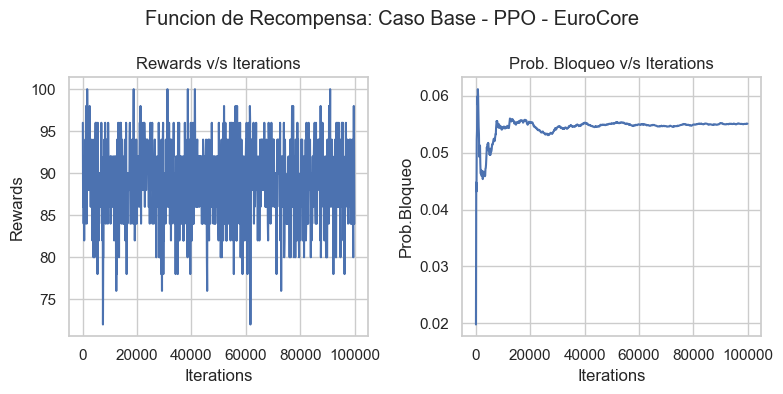

In [18]:
graph_Rewards_Bloqueo(x, rewardsArrayCB_PPO_Euro, probBloqueoArrayCB_PPO_Euro, "Caso Base", "PPO", "EuroCore")


### 2) Funcion de Recompensa Band Select: (DONE)

#### 2.1) Data:

In [19]:

episodeRewardsArrayBS_PPO_Euro=[90.79999999999995, 90.99999999999996, 87.59999999999994, 84.59999999999995, 88.79999999999995, 76.39999999999996, 75.79999999999997, 86.19999999999996, 79.99999999999997, 85.59999999999995, 86.59999999999995, 84.19999999999996, 76.59999999999994, 91.39999999999995, 83.59999999999995, 82.79999999999997, 90.39999999999996, 82.59999999999997, 89.79999999999994, 82.59999999999997, 80.99999999999994, 85.59999999999998, 89.39999999999996, 80.19999999999997, 80.39999999999995, 78.39999999999998, 85.19999999999996, 87.59999999999997, 80.19999999999997, 83.79999999999997, 89.79999999999995, 84.59999999999998, 85.99999999999997, 83.99999999999996, 80.99999999999996, 84.59999999999997, 88.79999999999995, 83.19999999999996, 87.99999999999996, 89.79999999999995, 85.19999999999999, 82.99999999999994, 87.59999999999997, 77.79999999999998, 81.59999999999997, 89.19999999999996, 80.19999999999996, 89.99999999999997, 86.59999999999994, 79.99999999999997, 77.39999999999999, 87.19999999999997, 78.39999999999996, 85.59999999999997, 81.39999999999996, 84.79999999999997, 90.39999999999995, 88.99999999999996, 86.99999999999994, 76.39999999999996, 90.79999999999997, 85.19999999999996, 85.39999999999998, 88.19999999999997, 84.99999999999996, 89.99999999999999, 84.99999999999996, 77.19999999999999, 82.79999999999995, 84.19999999999997, 83.99999999999996, 82.59999999999995, 87.19999999999996, 73.19999999999997, 75.79999999999998, 83.79999999999998, 84.19999999999997, 82.99999999999999, 88.39999999999998, 82.99999999999997, 83.19999999999996, 80.79999999999998, 84.79999999999995, 82.79999999999997, 85.19999999999995, 81.79999999999995, 78.59999999999998, 80.99999999999999, 83.99999999999996, 90.59999999999998, 83.19999999999997, 83.19999999999996, 85.99999999999999, 88.39999999999998, 90.59999999999995, 85.19999999999995, 82.99999999999997, 74.19999999999995, 85.19999999999997, 83.19999999999997, 83.59999999999997, 85.59999999999994, 88.99999999999997, 86.19999999999996, 91.39999999999996, 77.99999999999996, 75.59999999999997, 90.79999999999994, 84.19999999999997, 85.79999999999995, 87.59999999999995, 73.59999999999998, 80.79999999999994, 86.19999999999997, 87.19999999999996, 79.19999999999995, 83.99999999999996, 83.19999999999995, 76.19999999999999, 77.99999999999996, 77.59999999999997, 82.39999999999995, 90.39999999999996, 73.79999999999997, 95.39999999999998, 90.99999999999997, 85.79999999999997, 81.6, 86.59999999999995, 75.19999999999997, 79.39999999999998, 81.99999999999999, 84.99999999999997, 86.39999999999996, 79.39999999999995, 90.99999999999996, 90.19999999999997, 85.59999999999997, 79.79999999999997, 74.39999999999998, 71.99999999999994, 82.19999999999996, 72.79999999999998, 83.79999999999997, 81.99999999999997, 86.19999999999996, 88.19999999999999, 75.59999999999997, 86.99999999999996, 70.39999999999998, 82.19999999999996, 86.19999999999996, 77.39999999999998, 83.79999999999997, 85.59999999999997, 84.39999999999998, 83.19999999999996, 87.59999999999997, 85.99999999999999, 87.59999999999997, 83.99999999999997, 76.59999999999997, 85.59999999999995, 83.59999999999995, 79.99999999999997, 84.59999999999998, 86.59999999999997, 85.39999999999998, 79.79999999999997, 77.39999999999995, 74.39999999999996, 80.79999999999997, 87.19999999999997, 81.39999999999998, 88.99999999999996, 76.79999999999997, 93.99999999999996, 84.99999999999997, 92.19999999999997, 95.19999999999996, 81.59999999999998, 73.19999999999996, 87.79999999999997, 87.79999999999997, 79.19999999999997, 83.79999999999997, 81.19999999999997, 81.99999999999996, 73.19999999999997, 86.59999999999997, 82.79999999999995, 80.99999999999997, 83.59999999999998, 83.79999999999997, 82.19999999999997, 80.79999999999997, 86.99999999999996, 82.39999999999998, 81.59999999999998, 88.79999999999997, 78.99999999999997, 85.39999999999998, 85.39999999999998, 79.99999999999997, 89.19999999999995, 84.59999999999997, 92.19999999999997, 85.79999999999997, 94.19999999999996, 89.39999999999996, 82.59999999999997, 82.59999999999998, 79.79999999999995, 89.59999999999995, 78.39999999999995, 75.99999999999996, 86.99999999999996, 85.99999999999997, 83.59999999999997, 75.79999999999997, 82.99999999999997, 86.79999999999995, 84.99999999999997, 83.59999999999997, 90.39999999999996, 84.59999999999997, 77.19999999999999, 86.39999999999996, 83.19999999999995, 80.99999999999997, 86.79999999999998, 84.19999999999996, 74.99999999999996, 78.19999999999997, 87.79999999999997, 81.19999999999996, 84.79999999999995, 82.99999999999996, 86.99999999999996, 95.99999999999997, 79.59999999999997, 79.99999999999997, 82.39999999999996, 84.59999999999997, 90.19999999999997, 88.19999999999997, 69.39999999999998, 90.39999999999995, 79.39999999999996, 86.19999999999997, 85.39999999999996, 86.99999999999996, 78.99999999999996, 79.39999999999996, 74.79999999999998, 80.39999999999998, 83.99999999999994, 82.99999999999999, 78.39999999999998, 86.19999999999996, 83.19999999999997, 77.79999999999998, 87.39999999999996, 84.39999999999998, 79.59999999999997, 85.79999999999998, 75.39999999999998, 88.99999999999996, 84.99999999999996, 83.19999999999997, 85.59999999999997, 93.59999999999995, 80.19999999999997, 84.39999999999996, 81.39999999999996, 79.19999999999997, 76.39999999999998, 83.59999999999998, 80.79999999999998, 90.19999999999997, 81.19999999999999, 89.99999999999997, 79.99999999999997, 81.79999999999997, 87.59999999999997, 83.59999999999998, 86.99999999999999, 85.39999999999998, 82.39999999999998, 86.59999999999995, 89.59999999999997, 74.79999999999998, 82.39999999999996, 82.19999999999996, 83.79999999999995, 90.19999999999996, 77.39999999999998, 80.99999999999996, 89.39999999999998, 89.19999999999996, 86.19999999999996, 82.39999999999995, 84.39999999999998, 85.19999999999997, 88.39999999999996, 77.59999999999997, 80.39999999999998, 82.39999999999996, 81.19999999999997, 86.59999999999998, 79.19999999999995, 67.59999999999995, 81.39999999999998, 86.19999999999996, 82.19999999999999, 91.39999999999996, 85.19999999999996, 74.19999999999997, 82.79999999999998, 79.99999999999997, 83.59999999999998, 88.19999999999996, 82.59999999999997, 86.19999999999996, 91.39999999999998, 79.59999999999998, 81.99999999999994, 88.39999999999998, 81.99999999999997, 81.19999999999997, 85.99999999999997, 80.59999999999998, 79.19999999999997, 88.99999999999997, 86.19999999999995, 85.59999999999998, 86.99999999999996, 86.19999999999999, 84.79999999999998, 76.99999999999999, 95.19999999999999, 80.59999999999995, 80.19999999999996, 84.59999999999998, 77.99999999999997, 78.59999999999998, 84.79999999999995, 82.39999999999998, 84.59999999999997, 90.19999999999996, 87.39999999999999, 88.19999999999996, 78.19999999999997, 78.79999999999995, 88.19999999999995, 82.59999999999997, 87.19999999999995, 83.59999999999997, 89.59999999999997, 80.59999999999995, 89.19999999999995, 77.59999999999998, 78.99999999999997, 82.19999999999997, 86.39999999999996, 81.19999999999996, 78.39999999999995, 79.39999999999998, 82.99999999999994, 75.99999999999997, 87.39999999999996, 89.59999999999995, 84.99999999999997, 89.99999999999997, 86.79999999999995, 87.99999999999996, 83.19999999999996, 86.19999999999995, 86.59999999999997, 79.59999999999997, 73.99999999999997, 77.79999999999998, 92.99999999999996, 76.79999999999997, 79.39999999999998, 90.99999999999997, 82.19999999999995, 88.59999999999997, 78.99999999999997, 87.99999999999997, 77.19999999999996, 83.19999999999996, 83.59999999999998, 84.59999999999995, 81.59999999999997, 83.39999999999996, 83.59999999999995, 88.79999999999997, 91.59999999999995, 78.19999999999996, 80.99999999999997, 77.59999999999997, 81.59999999999997, 86.39999999999998, 86.99999999999997, 76.19999999999996, 86.99999999999997, 87.39999999999995, 80.79999999999998, 82.59999999999998, 74.99999999999997, 85.39999999999995, 78.99999999999997, 86.99999999999997, 78.19999999999997, 78.59999999999998, 85.39999999999996, 84.39999999999996, 77.59999999999997, 81.19999999999996, 83.59999999999997, 84.39999999999993, 87.99999999999996, 79.59999999999997, 83.59999999999994, 89.79999999999997, 91.39999999999996, 82.39999999999998, 85.79999999999997, 79.19999999999995, 78.99999999999996, 83.59999999999995, 90.79999999999997, 87.99999999999994, 88.19999999999997, 87.59999999999997, 85.39999999999996, 88.99999999999996, 80.39999999999995, 85.19999999999997, 86.39999999999998, 90.39999999999998, 81.99999999999994, 87.99999999999997, 87.59999999999997, 76.79999999999995, 89.79999999999997, 79.99999999999997, 83.79999999999997, 89.39999999999995, 86.19999999999996, 85.79999999999997, 87.59999999999997, 93.99999999999997, 78.79999999999997, 85.79999999999997, 78.79999999999998, 79.99999999999997, 85.99999999999997, 91.39999999999998, 90.59999999999995, 86.39999999999998, 86.99999999999997, 91.39999999999996, 86.19999999999996, 83.39999999999996, 81.19999999999996, 81.99999999999997, 87.99999999999996, 78.79999999999997, 77.99999999999996, 90.59999999999995, 83.59999999999997, 92.19999999999997, 85.99999999999997, 80.59999999999995, 80.19999999999997, 87.99999999999994, 74.59999999999998, 86.59999999999995, 80.79999999999997, 75.79999999999994, 68.79999999999998, 85.59999999999997, 77.79999999999998, 81.59999999999997, 81.39999999999998, 85.39999999999996, 83.99999999999997, 84.8, 86.59999999999998, 76.99999999999997, 90.39999999999995, 83.39999999999995, 84.39999999999996, 80.39999999999998, 79.39999999999998, 80.99999999999996, 85.19999999999996, 92.59999999999997, 89.39999999999998, 86.19999999999997, 86.59999999999997, 88.59999999999997, 80.39999999999998, 86.99999999999997, 77.59999999999995, 84.99999999999996, 81.59999999999997, 79.99999999999996, 84.19999999999997, 86.39999999999998, 88.59999999999998, 83.39999999999996, 80.39999999999998, 87.99999999999996, 81.79999999999995, 78.59999999999998, 76.39999999999998, 82.99999999999997, 81.79999999999995, 83.99999999999997, 86.99999999999996, 83.79999999999997, 81.39999999999995, 85.79999999999995, 77.39999999999998, 78.39999999999999, 82.79999999999995, 84.59999999999998, 80.39999999999998, 87.19999999999996, 81.59999999999998, 87.59999999999997, 75.79999999999995, 80.79999999999995, 78.39999999999998, 67.59999999999997, 92.19999999999997, 92.19999999999995, 83.79999999999997, 83.59999999999998, 82.39999999999998, 83.39999999999995, 85.99999999999997, 87.19999999999995, 82.19999999999997, 82.39999999999998, 78.99999999999996, 89.8, 82.39999999999998, 74.39999999999996, 89.79999999999997, 81.79999999999994, 92.99999999999997, 81.19999999999996, 85.59999999999997, 84.59999999999997, 81.79999999999997, 83.79999999999995, 80.59999999999997, 84.19999999999997, 82.79999999999995, 77.99999999999997, 75.79999999999998, 86.99999999999997, 80.19999999999997, 85.99999999999997, 90.99999999999996, 88.39999999999998, 87.19999999999997, 79.79999999999997, 78.99999999999999, 82.19999999999996, 82.19999999999997, 79.99999999999996, 86.39999999999996, 79.59999999999995, 82.99999999999997, 87.59999999999997, 84.19999999999997, 88.59999999999997, 83.59999999999998, 90.99999999999994, 89.99999999999997, 76.59999999999997, 87.39999999999995, 90.79999999999998, 85.39999999999996, 79.59999999999997, 88.79999999999997, 84.59999999999997, 85.79999999999998, 80.59999999999997, 87.59999999999997, 84.59999999999995, 84.19999999999996, 78.79999999999997, 81.19999999999997, 82.19999999999996, 81.59999999999997, 75.79999999999998, 81.39999999999996, 81.99999999999999, 85.39999999999998, 80.79999999999995, 91.59999999999997, 84.39999999999995, 84.79999999999998, 73.59999999999997, 80.79999999999998, 82.79999999999998, 75.79999999999995, 74.39999999999998, 82.39999999999996, 86.19999999999996, 83.59999999999995, 83.79999999999997, 84.99999999999996, 81.79999999999997, 91.79999999999997, 81.99999999999996, 83.99999999999997, 86.99999999999997, 83.99999999999996, 88.39999999999998, 82.99999999999996, 84.99999999999997, 86.99999999999994, 84.79999999999997, 84.39999999999996, 81.39999999999998, 83.19999999999996, 84.39999999999995, 86.19999999999997, 91.79999999999997, 81.99999999999997, 84.79999999999998, 86.39999999999998, 84.59999999999995, 87.39999999999996, 89.79999999999995, 86.39999999999999, 85.6, 82.99999999999997, 84.79999999999998, 80.79999999999995, 85.59999999999997, 88.19999999999996, 84.79999999999995, 83.99999999999997, 76.19999999999996, 81.19999999999997, 83.99999999999996, 89.39999999999996, 87.19999999999999, 74.39999999999998, 82.19999999999999, 79.79999999999997, 84.79999999999995, 76.99999999999997, 84.19999999999996, 82.19999999999996, 86.99999999999997, 84.79999999999997, 81.79999999999995, 85.59999999999998, 80.19999999999997, 76.39999999999998, 76.79999999999998, 79.39999999999998, 79.19999999999999, 77.19999999999997, 86.79999999999995, 86.79999999999995, 84.79999999999997, 84.99999999999997, 81.99999999999997, 77.79999999999997, 76.19999999999996, 89.79999999999997, 81.19999999999997, 83.99999999999996, 85.79999999999998, 79.6, 90.19999999999997, 79.79999999999995, 80.39999999999996, 82.79999999999998, 82.99999999999996, 78.99999999999999, 80.19999999999997, 89.59999999999997, 89.79999999999995, 75.99999999999999, 79.59999999999997, 81.99999999999999, 82.59999999999997, 80.79999999999997, 86.79999999999997, 77.19999999999996, 85.79999999999997, 76.19999999999997, 88.19999999999999, 80.39999999999998, 82.79999999999995, 84.79999999999997, 81.59999999999997, 81.39999999999998, 82.79999999999998, 84.39999999999998, 79.39999999999996, 89.99999999999997, 76.19999999999996, 83.99999999999997, 83.59999999999997, 87.59999999999997, 75.39999999999998, 86.99999999999996, 89.79999999999997, 80.99999999999996, 81.19999999999997, 85.19999999999995, 83.79999999999995, 85.99999999999999, 83.99999999999996, 92.99999999999996, 84.39999999999996, 84.19999999999996, 74.39999999999995, 86.79999999999997, 81.8, 77.79999999999994, 71.99999999999999, 82.59999999999995, 82.59999999999997, 87.39999999999996, 89.39999999999998, 81.19999999999996, 85.99999999999996, 86.39999999999995, 85.39999999999996, 87.39999999999996, 86.99999999999997, 85.59999999999997, 81.39999999999996, 85.99999999999996, 74.19999999999997, 85.39999999999998, 75.19999999999997, 81.59999999999995, 83.99999999999997, 80.99999999999996, 84.59999999999998, 78.19999999999996, 81.59999999999997, 82.59999999999997, 90.19999999999997, 90.99999999999996, 86.99999999999997, 74.99999999999996, 87.19999999999996, 80.19999999999997, 89.99999999999997, 78.39999999999993, 78.39999999999998, 84.79999999999995, 85.39999999999998, 83.79999999999995, 79.59999999999997, 83.79999999999997, 83.39999999999996, 92.39999999999995, 83.59999999999998, 87.99999999999997, 88.19999999999996, 87.59999999999997, 86.59999999999995, 86.19999999999996, 83.59999999999997, 75.99999999999996, 86.59999999999997, 84.59999999999997, 77.99999999999997, 84.79999999999997, 87.99999999999996, 86.99999999999996, 84.59999999999998, 77.39999999999996, 90.59999999999998, 81.79999999999998, 78.99999999999996, 92.99999999999997, 86.19999999999996, 83.59999999999995, 87.59999999999997, 80.39999999999996, 87.39999999999995, 79.19999999999996, 82.79999999999995, 79.19999999999997, 81.39999999999998, 89.19999999999997, 80.99999999999999, 81.79999999999995, 88.59999999999998, 84.19999999999997, 83.59999999999994, 82.19999999999997, 82.59999999999997, 77.99999999999997, 91.79999999999998, 88.79999999999997, 91.19999999999997, 84.19999999999999, 77.19999999999995, 87.79999999999998, 82.79999999999995, 83.99999999999997, 82.99999999999997, 77.59999999999997, 86.99999999999996, 77.39999999999998, 82.39999999999996, 87.19999999999996, 77.39999999999998, 82.39999999999995, 81.39999999999996, 79.59999999999997, 77.99999999999997, 81.99999999999997, 84.19999999999999, 69.39999999999996, 80.39999999999996, 69.99999999999997, 82.39999999999996, 86.59999999999995, 86.79999999999998, 86.39999999999998, 77.59999999999997, 85.39999999999996, 78.59999999999998, 78.19999999999997, 92.79999999999998, 82.39999999999996, 82.59999999999995, 89.59999999999997, 85.19999999999996, 79.39999999999996, 84.59999999999997, 75.39999999999998, 81.79999999999997, 74.59999999999997, 83.19999999999996, 80.19999999999996, 85.19999999999996, 79.59999999999997, 91.79999999999995, 89.19999999999997, 85.39999999999995, 85.19999999999996, 77.99999999999999, 77.99999999999997, 81.79999999999998, 80.39999999999996, 74.19999999999997, 87.39999999999998, 90.59999999999997, 89.39999999999996, 87.19999999999996, 91.79999999999995, 86.19999999999997, 78.39999999999996, 84.39999999999999, 82.99999999999999, 75.39999999999998, 74.79999999999997, 88.19999999999997, 69.39999999999998, 77.39999999999996, 78.39999999999998, 82.59999999999997, 87.79999999999997, 85.19999999999997, 81.39999999999996, 82.79999999999997, 83.99999999999996, 76.19999999999997, 90.39999999999996, 77.39999999999998, 79.19999999999997, 82.79999999999997, 88.39999999999995, 79.19999999999996, 84.59999999999997, 88.99999999999996, 85.79999999999997, 77.99999999999997, 87.79999999999997, 75.8, 86.39999999999996, 81.19999999999997, 88.99999999999999, 91.59999999999997, 87.19999999999996, 89.19999999999996, 88.39999999999996, 77.39999999999998, 72.79999999999997, 80.39999999999996, 73.79999999999997, 82.99999999999999, 85.79999999999997, 93.19999999999997, 72.8, 82.39999999999995, 84.39999999999995, 83.19999999999996, 79.39999999999998, 76.59999999999998, 84.79999999999995, 79.59999999999997, 72.99999999999997, 83.99999999999997, 76.59999999999998, 80.79999999999995, 83.59999999999997, 77.39999999999996, 83.19999999999997, 86.79999999999997, 89.79999999999997, 82.19999999999995, 90.19999999999997, 85.39999999999996, 84.39999999999996, 95.59999999999995, 83.99999999999994, 79.59999999999995, 87.79999999999997, 84.39999999999998, 91.79999999999995, 83.59999999999997, 80.79999999999998, 87.59999999999997, 85.59999999999995, 81.19999999999997, 81.59999999999997, 92.79999999999997, 84.79999999999997, 90.39999999999996, 85.99999999999997, 87.39999999999998, 78.59999999999997, 87.79999999999997, 84.99999999999996, 87.39999999999996, 74.59999999999997, 84.19999999999996, 89.99999999999996, 82.39999999999996, 81.99999999999997, 88.19999999999996, 83.19999999999997, 80.19999999999997, 71.59999999999997, 87.19999999999997, 82.99999999999997, 77.19999999999996, 87.19999999999996, 82.19999999999997, 80.39999999999998, 77.39999999999996, 86.39999999999998, 84.19999999999997, 73.19999999999997, 80.6, 88.19999999999997, 89.39999999999996, 91.99999999999996, 92.19999999999993, 93.79999999999995, 84.19999999999996, 91.99999999999999, 78.39999999999996, 92.59999999999998, 86.39999999999996, 78.79999999999998, 88.79999999999997, 87.79999999999997, 76.59999999999997, 76.6, 76.19999999999997, 80.39999999999998, 86.79999999999997, 83.79999999999995, 73.59999999999998, 77.59999999999997, 88.59999999999995, 89.19999999999997, 83.79999999999997, 81.39999999999996, 80.19999999999996, 81.59999999999994, 80.59999999999998, 84.39999999999996, 79.39999999999998, 80.59999999999998, 80.99999999999996, 84.79999999999995, 82.79999999999998, 84.79999999999995, 83.59999999999995, 78.79999999999997, 84.59999999999997, 88.99999999999996, 76.19999999999997, 86.59999999999998, 83.39999999999995, 81.59999999999997, 81.99999999999997]
rewardsArrayBS_PPO_Euro=[0, 89.39999999999993, 82.39999999999996, 89.59999999999997, 74.39999999999998, 84.59999999999997, 81.99999999999997, 81.79999999999997, 88.99999999999996, 79.19999999999995, 85.79999999999997, 89.19999999999996, 84.39999999999996, 83.39999999999996, 86.59999999999997, 79.79999999999997, 85.39999999999995, 82.99999999999996, 88.39999999999998, 90.19999999999996, 86.99999999999997, 88.39999999999996, 81.59999999999997, 84.99999999999996, 72.39999999999996, 89.19999999999997, 88.19999999999997, 81.99999999999997, 89.79999999999997, 84.19999999999996, 74.79999999999998, 83.59999999999998, 78.79999999999997, 87.39999999999995, 82.39999999999998, 87.99999999999999, 82.99999999999996, 86.39999999999995, 94.39999999999996, 77.79999999999995, 86.19999999999997, 85.19999999999995, 89.19999999999996, 83.39999999999999, 84.19999999999995, 93.39999999999998, 83.99999999999997, 77.99999999999994, 81.79999999999997, 84.99999999999996, 82.79999999999997, 81.59999999999997, 88.59999999999995, 78.79999999999995, 77.59999999999997, 77.19999999999996, 86.59999999999998, 82.39999999999998, 88.99999999999997, 85.19999999999995, 79.39999999999996, 80.39999999999998, 88.99999999999996, 80.79999999999995, 84.19999999999997, 81.39999999999998, 83.19999999999996, 80.79999999999997, 78.99999999999997, 90.19999999999997, 81.19999999999995, 87.59999999999997, 83.59999999999997, 86.19999999999997, 89.79999999999995, 93.79999999999997, 74.59999999999995, 80.79999999999995, 83.39999999999996, 81.19999999999999, 83.79999999999995, 81.59999999999997, 91.19999999999995, 86.8, 89.59999999999997, 85.79999999999998, 77.19999999999997, 79.79999999999998, 90.39999999999996, 86.99999999999997, 81.99999999999999, 82.79999999999995, 77.79999999999997, 80.99999999999997, 91.39999999999996, 78.19999999999997, 83.19999999999997, 85.79999999999997, 72.79999999999997, 81.79999999999997, 78.39999999999998, 81.19999999999996, 85.59999999999998, 85.59999999999997, 80.59999999999998, 92.99999999999997, 86.79999999999997, 80.19999999999997, 90.19999999999999, 80.59999999999995, 71.39999999999996, 82.19999999999996, 85.39999999999995, 88.59999999999995, 87.79999999999998, 78.39999999999996, 89.59999999999997, 89.99999999999996, 78.39999999999998, 83.39999999999998, 71.79999999999997, 78.59999999999998, 76.79999999999995, 73.39999999999996, 84.39999999999996, 84.19999999999996, 85.79999999999995, 86.39999999999996, 79.19999999999996, 77.19999999999996, 78.39999999999996, 87.19999999999996, 74.99999999999997, 83.79999999999997, 86.79999999999997, 82.79999999999997, 82.59999999999998, 84.79999999999997, 91.39999999999996, 85.39999999999996, 88.39999999999996, 74.79999999999998, 85.79999999999997, 79.99999999999999, 81.79999999999997, 85.39999999999995, 80.19999999999997, 88.39999999999998, 83.99999999999997, 76.39999999999998, 81.19999999999997, 76.39999999999998, 79.39999999999999, 87.79999999999997, 87.79999999999997, 75.99999999999997, 89.99999999999997, 90.19999999999997, 86.39999999999996, 95.39999999999998, 87.39999999999995, 74.59999999999998, 80.39999999999995, 88.79999999999997, 86.79999999999995, 79.79999999999997, 80.39999999999998, 84.79999999999998, 78.99999999999994, 77.59999999999998, 82.39999999999996, 84.19999999999997, 82.99999999999996, 84.59999999999997, 84.19999999999997, 81.79999999999995, 82.79999999999997, 81.19999999999997, 79.99999999999996, 88.19999999999996, 85.19999999999997, 80.99999999999994, 85.79999999999995, 82.59999999999997, 84.19999999999997, 85.59999999999998, 89.79999999999997, 91.79999999999997, 88.59999999999998, 91.79999999999995, 82.99999999999996, 83.19999999999996, 80.79999999999997, 86.19999999999997, 83.99999999999996, 77.79999999999997, 80.79999999999997, 87.79999999999997, 85.59999999999995, 73.59999999999997, 84.79999999999998, 81.99999999999996, 89.99999999999996, 85.99999999999997, 83.59999999999998, 93.19999999999997, 74.19999999999997, 85.39999999999998, 85.79999999999997, 80.19999999999996, 81.99999999999997, 83.19999999999997, 77.99999999999999, 76.59999999999997, 86.19999999999996, 88.19999999999997, 79.39999999999998, 85.79999999999997, 82.39999999999996, 92.19999999999996, 87.39999999999995, 78.19999999999997, 81.99999999999996, 86.59999999999997, 87.99999999999997, 82.99999999999996, 80.99999999999994, 79.39999999999995, 87.19999999999996, 81.79999999999998, 88.19999999999996, 86.59999999999995, 78.99999999999997, 79.39999999999996, 76.39999999999995, 78.59999999999995, 82.99999999999996, 86.59999999999997, 73.19999999999997, 88.39999999999998, 83.99999999999997, 80.79999999999997, 84.19999999999997, 81.99999999999997, 79.59999999999997, 85.59999999999997, 79.39999999999996, 83.79999999999997, 87.39999999999998, 87.59999999999995, 80.19999999999996, 90.59999999999998, 84.19999999999995, 86.79999999999997, 81.99999999999997, 76.99999999999996, 78.19999999999997, 80.79999999999998, 84.79999999999997, 83.19999999999997, 88.39999999999996, 82.79999999999997, 88.39999999999996, 75.79999999999997, 87.39999999999996, 80.79999999999995, 90.59999999999997, 90.19999999999996, 80.19999999999997, 84.19999999999997, 84.39999999999996, 82.79999999999994, 80.59999999999995, 81.99999999999999, 84.79999999999995, 87.39999999999998, 84.59999999999997, 78.59999999999997, 85.99999999999999, 88.79999999999997, 85.6, 86.79999999999997, 78.99999999999996, 86.19999999999996, 86.39999999999995, 91.19999999999996, 71.59999999999998, 80.79999999999997, 81.59999999999997, 86.19999999999997, 80.79999999999995, 78.79999999999997, 69.79999999999995, 85.39999999999998, 83.19999999999996, 85.99999999999997, 89.79999999999997, 75.99999999999997, 83.59999999999997, 79.19999999999997, 81.19999999999996, 86.19999999999997, 87.59999999999995, 83.59999999999998, 85.59999999999997, 81.39999999999996, 89.79999999999997, 79.99999999999997, 85.99999999999997, 80.19999999999996, 89.19999999999996, 84.19999999999997, 75.99999999999997, 86.79999999999998, 86.79999999999995, 84.59999999999997, 86.59999999999998, 83.99999999999996, 88.79999999999997, 77.39999999999998, 86.99999999999997, 88.79999999999995, 83.39999999999996, 77.79999999999998, 86.39999999999996, 77.79999999999997, 83.99999999999997, 79.79999999999997, 82.39999999999998, 89.19999999999995, 87.59999999999997, 87.39999999999998, 82.39999999999998, 77.59999999999997, 82.99999999999997, 86.79999999999997, 83.99999999999997, 89.19999999999996, 80.79999999999995, 91.59999999999995, 83.79999999999998, 81.79999999999995, 73.59999999999997, 87.79999999999995, 80.99999999999999, 81.59999999999997, 84.99999999999997, 75.39999999999998, 85.39999999999998, 80.19999999999997, 78.19999999999997, 89.39999999999998, 84.79999999999994, 89.59999999999997, 83.39999999999996, 91.99999999999997, 86.59999999999995, 83.39999999999996, 88.39999999999996, 81.19999999999996, 75.59999999999995, 77.19999999999999, 85.79999999999997, 88.19999999999997, 71.39999999999998, 90.99999999999999, 87.19999999999996, 80.19999999999996, 83.99999999999997, 86.59999999999997, 81.79999999999997, 78.99999999999996, 82.79999999999995, 86.79999999999997, 79.99999999999997, 85.39999999999996, 87.59999999999997, 84.6, 84.59999999999998, 89.59999999999997, 78.19999999999997, 76.59999999999997, 81.59999999999997, 83.79999999999997, 88.99999999999996, 83.19999999999999, 73.79999999999998, 95.19999999999997, 75.99999999999996, 81.59999999999998, 87.19999999999997, 74.79999999999995, 83.79999999999995, 79.39999999999996, 89.19999999999997, 72.59999999999998, 84.39999999999996, 82.19999999999997, 81.59999999999997, 75.79999999999998, 82.59999999999995, 91.59999999999995, 79.39999999999998, 91.39999999999998, 77.59999999999998, 87.79999999999995, 90.99999999999996, 82.39999999999998, 90.19999999999997, 78.59999999999997, 79.79999999999995, 83.79999999999998, 82.6, 96.59999999999998, 84.59999999999997, 86.99999999999997, 88.99999999999997, 87.39999999999996, 82.79999999999995, 77.59999999999995, 91.79999999999997, 84.79999999999997, 87.79999999999995, 84.79999999999997, 91.79999999999997, 75.19999999999996, 82.99999999999997, 82.19999999999996, 87.59999999999997, 88.79999999999998, 86.79999999999997, 83.79999999999997, 88.19999999999997, 89.39999999999996, 90.59999999999998, 78.19999999999997, 85.79999999999997, 78.59999999999997, 80.19999999999996, 89.19999999999996, 91.99999999999996, 88.99999999999997, 86.99999999999999, 87.39999999999996, 88.99999999999997, 82.99999999999996, 84.99999999999996, 79.39999999999996, 83.19999999999997, 89.99999999999999, 74.99999999999999, 82.39999999999996, 92.39999999999995, 82.79999999999997, 94.39999999999998, 77.19999999999996, 82.79999999999995, 84.19999999999997, 80.59999999999997, 83.19999999999996, 82.39999999999998, 77.59999999999997, 70.39999999999998, 80.39999999999996, 78.99999999999999, 82.99999999999997, 76.99999999999996, 89.19999999999996, 79.79999999999995, 87.99999999999997, 82.79999999999997, 86.99999999999999, 79.6, 85.39999999999996, 83.99999999999996, 82.19999999999996, 79.59999999999997, 81.39999999999996, 82.99999999999996, 88.39999999999998, 92.39999999999998, 92.79999999999997, 78.79999999999997, 92.39999999999996, 78.79999999999998, 86.39999999999995, 84.79999999999997, 81.39999999999998, 81.19999999999997, 82.59999999999997, 80.79999999999997, 85.79999999999995, 88.99999999999997, 82.19999999999996, 81.99999999999997, 84.99999999999999, 89.39999999999996, 77.59999999999998, 74.39999999999995, 77.59999999999995, 85.99999999999993, 83.19999999999997, 87.39999999999995, 86.19999999999997, 83.39999999999995, 80.39999999999996, 80.19999999999995, 75.79999999999997, 81.99999999999996, 83.39999999999996, 84.59999999999998, 82.39999999999998, 84.39999999999995, 87.99999999999997, 80.59999999999995, 78.99999999999997, 77.39999999999996, 79.39999999999996, 75.99999999999997, 91.19999999999995, 85.39999999999995, 89.19999999999996, 78.99999999999999, 83.79999999999997, 84.99999999999996, 88.59999999999997, 79.59999999999994, 86.99999999999997, 82.79999999999997, 81.59999999999998, 80.99999999999997, 81.79999999999995, 83.39999999999998, 84.99999999999996, 88.59999999999998, 82.99999999999997, 82.99999999999996, 86.19999999999997, 86.19999999999997, 79.79999999999997, 82.39999999999995, 83.39999999999996, 86.59999999999997, 78.99999999999997, 69.99999999999997, 85.19999999999995, 85.39999999999996, 82.79999999999997, 89.59999999999997, 86.99999999999996, 87.59999999999995, 87.19999999999995, 76.79999999999998, 81.59999999999994, 79.79999999999997, 86.39999999999995, 78.19999999999996, 86.39999999999996, 81.99999999999996, 83.59999999999997, 85.59999999999995, 83.39999999999996, 88.99999999999996, 89.79999999999997, 85.19999999999997, 82.79999999999998, 86.59999999999998, 86.19999999999995, 89.59999999999997, 83.39999999999996, 84.39999999999995, 83.79999999999997, 90.19999999999996, 81.39999999999996, 86.59999999999995, 83.79999999999997, 85.19999999999995, 80.79999999999998, 79.19999999999996, 82.39999999999998, 83.19999999999996, 73.39999999999995, 79.79999999999995, 83.59999999999995, 83.79999999999998, 81.99999999999996, 87.39999999999998, 88.79999999999995, 80.59999999999998, 78.79999999999997, 81.59999999999997, 81.39999999999998, 76.99999999999994, 74.99999999999996, 83.59999999999998, 83.79999999999998, 80.39999999999998, 82.79999999999997, 83.59999999999997, 87.19999999999997, 85.79999999999995, 90.19999999999997, 81.39999999999996, 79.99999999999996, 87.79999999999995, 87.99999999999997, 85.59999999999997, 85.99999999999997, 82.79999999999998, 87.79999999999994, 84.39999999999998, 79.39999999999996, 84.99999999999996, 83.39999999999996, 84.99999999999997, 92.19999999999996, 79.39999999999995, 88.99999999999994, 82.19999999999996, 89.19999999999996, 85.39999999999996, 87.19999999999996, 87.99999999999997, 86.79999999999994, 88.19999999999995, 77.99999999999997, 84.79999999999997, 86.79999999999997, 86.59999999999998, 85.39999999999996, 82.99999999999997, 77.19999999999996, 82.19999999999996, 83.79999999999997, 86.39999999999996, 83.39999999999993, 88.59999999999997, 71.79999999999995, 86.19999999999996, 75.99999999999996, 81.99999999999997, 82.59999999999998, 85.99999999999997, 79.19999999999999, 90.79999999999998, 82.59999999999998, 79.19999999999997, 89.39999999999996, 76.79999999999995, 76.39999999999998, 75.39999999999996, 82.59999999999997, 71.79999999999998, 85.99999999999997, 87.79999999999995, 81.19999999999996, 91.59999999999997, 81.39999999999996, 78.19999999999997, 78.59999999999997, 80.59999999999997, 83.99999999999997, 86.19999999999995, 82.59999999999995, 86.59999999999997, 84.99999999999997, 82.79999999999997, 79.99999999999996, 83.99999999999997, 79.99999999999996, 80.19999999999997, 82.39999999999996, 82.79999999999998, 91.79999999999998, 80.99999999999997, 79.79999999999997, 79.59999999999997, 81.19999999999996, 82.59999999999998, 80.39999999999998, 83.79999999999997, 77.79999999999995, 83.79999999999997, 84.59999999999998, 84.19999999999997, 81.59999999999997, 83.39999999999996, 84.39999999999996, 78.99999999999996, 88.59999999999998, 80.39999999999996, 78.39999999999998, 85.59999999999998, 82.59999999999994, 77.59999999999997, 87.39999999999996, 83.99999999999997, 78.79999999999995, 87.39999999999996, 87.39999999999996, 84.19999999999997, 81.99999999999994, 81.99999999999996, 86.19999999999997, 82.79999999999995, 88.59999999999997, 86.39999999999995, 89.39999999999998, 85.19999999999997, 84.19999999999997, 77.19999999999999, 80.79999999999998, 79.99999999999996, 72.39999999999996, 79.99999999999996, 79.39999999999995, 87.79999999999995, 90.39999999999998, 84.39999999999996, 82.99999999999999, 85.99999999999994, 84.99999999999996, 86.79999999999995, 88.99999999999996, 85.99999999999997, 79.59999999999997, 83.79999999999998, 83.39999999999996, 77.99999999999997, 83.39999999999996, 75.99999999999997, 80.79999999999995, 87.99999999999997, 79.19999999999996, 77.39999999999998, 85.39999999999996, 80.19999999999996, 88.39999999999998, 88.79999999999995, 90.79999999999998, 81.99999999999997, 79.19999999999997, 85.39999999999996, 82.59999999999998, 83.79999999999997, 76.39999999999996, 82.19999999999996, 87.39999999999995, 85.19999999999997, 77.59999999999997, 85.19999999999996, 83.59999999999997, 88.59999999999994, 89.19999999999996, 85.59999999999997, 83.19999999999996, 89.59999999999997, 88.99999999999996, 85.59999999999995, 81.59999999999997, 82.59999999999997, 84.19999999999996, 87.19999999999997, 74.59999999999997, 83.19999999999995, 87.99999999999997, 88.19999999999999, 84.99999999999997, 81.99999999999997, 81.19999999999996, 87.59999999999995, 76.99999999999996, 90.19999999999997, 91.79999999999995, 80.79999999999998, 86.39999999999996, 83.79999999999995, 84.19999999999996, 86.39999999999996, 78.39999999999996, 82.79999999999997, 80.59999999999997, 83.99999999999996, 81.59999999999997, 86.39999999999996, 82.19999999999997, 87.39999999999998, 83.19999999999997, 82.39999999999996, 88.19999999999996, 78.59999999999998, 80.59999999999998, 89.59999999999998, 89.59999999999997, 89.59999999999997, 80.59999999999998, 86.0, 80.39999999999996, 86.79999999999995, 79.59999999999995, 87.19999999999997, 79.99999999999997, 80.79999999999995, 77.99999999999997, 85.99999999999996, 78.39999999999996, 82.59999999999997, 82.39999999999996, 81.19999999999996, 75.59999999999995, 88.19999999999997, 76.8, 81.19999999999997, 68.19999999999996, 79.59999999999997, 77.19999999999996, 84.99999999999997, 84.79999999999997, 88.79999999999997, 80.59999999999997, 82.79999999999997, 78.19999999999997, 78.39999999999998, 88.79999999999998, 88.79999999999997, 77.99999999999994, 88.59999999999997, 83.39999999999998, 85.39999999999998, 81.99999999999997, 80.39999999999998, 76.79999999999998, 84.19999999999997, 70.39999999999998, 83.79999999999994, 83.39999999999996, 81.19999999999996, 87.39999999999996, 87.99999999999997, 91.39999999999996, 85.19999999999997, 82.59999999999995, 70.79999999999997, 82.79999999999998, 83.79999999999998, 75.79999999999997, 80.39999999999998, 89.79999999999998, 90.99999999999996, 87.79999999999995, 87.59999999999997, 94.19999999999997, 78.79999999999995, 82.99999999999997, 79.59999999999997, 81.59999999999995, 76.59999999999995, 82.39999999999998, 74.99999999999996, 74.59999999999998, 73.19999999999997, 84.59999999999997, 83.99999999999996, 84.39999999999996, 84.39999999999996, 84.39999999999995, 86.59999999999997, 78.19999999999996, 84.39999999999999, 78.99999999999996, 78.99999999999996, 81.59999999999997, 88.39999999999996, 85.39999999999996, 78.19999999999999, 86.99999999999996, 85.79999999999997, 83.59999999999997, 85.39999999999996, 78.99999999999997, 81.79999999999998, 88.59999999999997, 78.99999999999999, 94.19999999999997, 89.19999999999996, 85.99999999999997, 89.99999999999999, 82.99999999999994, 76.6, 73.19999999999997, 84.99999999999996, 67.99999999999997, 83.59999999999998, 93.39999999999998, 84.79999999999997, 72.79999999999997, 86.39999999999996, 84.19999999999997, 82.99999999999996, 74.59999999999998, 84.19999999999997, 76.59999999999997, 78.59999999999998, 79.79999999999998, 82.59999999999998, 73.99999999999996, 82.59999999999997, 82.19999999999996, 81.79999999999998, 79.59999999999997, 93.59999999999995, 88.19999999999996, 80.39999999999998, 91.79999999999997, 83.59999999999998, 90.59999999999995, 91.99999999999999, 78.59999999999997, 83.59999999999995, 84.99999999999999, 90.39999999999998, 86.59999999999995, 76.19999999999997, 90.59999999999997, 91.99999999999997, 71.19999999999997, 89.19999999999995, 86.59999999999998, 87.59999999999997, 87.59999999999997, 88.6, 88.59999999999998, 77.19999999999999, 87.19999999999995, 88.19999999999997, 86.79999999999997, 79.79999999999997, 80.99999999999999, 87.99999999999997, 82.19999999999997, 83.99999999999997, 86.19999999999997, 85.99999999999997, 79.19999999999997, 77.79999999999997, 75.39999999999998, 87.79999999999997, 77.19999999999999, 82.79999999999997, 85.39999999999996, 83.99999999999997, 76.39999999999996, 83.19999999999997, 82.59999999999997, 81.39999999999996, 73.59999999999997, 86.59999999999997, 88.79999999999997, 90.39999999999995, 92.39999999999996, 92.59999999999997, 89.99999999999996, 89.39999999999995, 83.19999999999997, 85.99999999999997, 92.39999999999996, 82.59999999999997, 79.39999999999998, 89.39999999999996, 84.79999999999997, 71.99999999999996, 76.99999999999999, 82.39999999999998, 86.19999999999997, 81.19999999999999, 76.59999999999995, 76.39999999999998, 82.39999999999993, 88.39999999999998, 88.19999999999996, 83.79999999999997, 87.79999999999997, 77.19999999999997, 76.19999999999997, 86.99999999999997, 73.99999999999996, 81.79999999999995, 85.79999999999995, 80.99999999999996, 79.99999999999996, 85.79999999999995, 85.19999999999996, 82.79999999999995, 79.79999999999998, 90.39999999999998, 75.39999999999998, 84.19999999999997, 84.39999999999998, 83.39999999999996, 85.59999999999997]
probBloqueoArrayBS_PPO_Euro=[0.0, 0.019801980198019802, 0.04477611940298507, 0.03986710963455149, 0.057356608478802994, 0.05588822355289421, 0.05823627287853577, 0.05991440798858773, 0.056179775280898875, 0.058823529411764705, 0.057942057942057944, 0.055404178019981834, 0.05578684429641965, 0.056110684089162186, 0.054960742326909354, 0.056628914057295136, 0.056214865708931916, 0.0564373897707231, 0.0555247084952804, 0.05365597054182009, 0.05297351324337831, 0.05235602094240838, 0.05315765561108587, 0.05302042590178183, 0.0558100791336943, 0.0547780887644942, 0.05420991926182238, 0.0547945205479452, 0.05390931810067833, 0.05377456049638056, 0.05564811729423526, 0.05611093195743309, 0.05716963448922212, 0.05664950015146925, 0.057042046456924435, 0.056555269922879174, 0.05665093029713968, 0.05620102674952716, 0.05498553012365167, 0.05562676236862343, 0.05548612846788303, 0.05535235308461351, 0.054748869316829325, 0.05510346431062543, 0.05521472392638037, 0.05421017551655188, 0.05433601391001956, 0.05488194001276324, 0.055196833992918144, 0.055090797796368086, 0.05538892221555689, 0.05567535777298569, 0.05518169582772544, 0.055649877381626106, 0.056285872986483985, 0.05689874568260316, 0.056775575790037495, 0.05700754253639712, 0.05671435959317359, 0.05660057617352991, 0.05699050158306949, 0.057367644648418294, 0.05692630220932108, 0.0571337882875734, 0.05717856584908608, 0.05737578834025535, 0.057415543099530376, 0.05775257424265035, 0.05822673136303485, 0.05781770757861179, 0.057991715469218684, 0.05773834671173074, 0.05776975420080544, 0.057663333789891795, 0.05728955546547764, 0.05665911211838422, 0.05722931193264044, 0.05739514348785872, 0.057428534803230354, 0.057714213390710034, 0.05774278215223097, 0.057894087149734604, 0.05731008413608096, 0.057222021443199614, 0.05689798833472206, 0.05681684507704976, 0.0572026508545518, 0.05746465923457074, 0.057038972843995, 0.056959892146949784, 0.05710476613709588, 0.05713657839797824, 0.057493750679273994, 0.05762821202021288, 0.05722795447292841, 0.057572887064519525, 0.057598166857618996, 0.05751984331512215, 0.0580553004795429, 0.05817594182405818, 0.058394160583941604, 0.058509058509058506, 0.05842564454465248, 0.058343850111639645, 0.05855206230170176, 0.05818493476811732, 0.058107725686256016, 0.05831230726100364, 0.05814276455883714, 0.05825153655627924, 0.05881283519680029, 0.058913611386361586, 0.05883403267565396, 0.05857888682417485, 0.05841592842733093, 0.05860359968698374, 0.058357038186363244, 0.058114691052046835, 0.05838488263706466, 0.05839845391143601, 0.05891175735355387, 0.059086025948268735, 0.059339398409966396, 0.05975123973660678, 0.05975324570599145, 0.059755219582433405, 0.05967780334894056, 0.0596016061727423, 0.05976095617529881, 0.05999534919773661, 0.06022613645104223, 0.06007175024807267, 0.06037421407469131, 0.06037140064656793, 0.06021938661293933, 0.06029183023479742, 0.060363208587603856, 0.06028757025034669, 0.05999565248895008, 0.05992374649305805, 0.05978144418255839, 0.06013757889511382, 0.060066192521653405, 0.06020558002936858, 0.06027359211165891, 0.060202744638300804, 0.06033833299089104, 0.06013196381198558, 0.060131072224849674, 0.060398630964364805, 0.06046263582427838, 0.060724455334083834, 0.06091704493125452, 0.06078034115417293, 0.06064541263554315, 0.06089929681956003, 0.060701237100185886, 0.0605057002738679, 0.06043921270805645, 0.06012200490535186, 0.05999625023436035, 0.06030681324141358, 0.06036664403431887, 0.0602417029630084, 0.060118285470398145, 0.06023877340767226, 0.060357809770495756, 0.060355667325309864, 0.06047259091720731, 0.06064729897639193, 0.06064349155932004, 0.060639728670837965, 0.0606360095343294, 0.06063233339113346, 0.060628699500028735, 0.060682246728758354, 0.060678370547128005, 0.06073103214507655, 0.0608392786922083, 0.06072286464443327, 0.060718848952835955, 0.06077012319761339, 0.060710949947805064, 0.060761707010545875, 0.060757567523504155, 0.060699421652883626, 0.06053437987204989, 0.06031763007325811, 0.06020956332109994, 0.05999682556478493, 0.0599968422714594, 0.05999685880320402, 0.06010103640435394, 0.060048702139785505, 0.05999690737590846, 0.06015076149941029, 0.060201010152543234, 0.06009847215877367, 0.060047472349881316, 0.06029847746344405, 0.060296985150742465, 0.06034525645490274, 0.060195039849512404, 0.06014482045219447, 0.06014411058281457, 0.05994829520511195, 0.06019125285180331, 0.060190328969614994, 0.06014133935868468, 0.06018850772690302, 0.06023522689395743, 0.06028150324629165, 0.060421678222725345, 0.060560537063987605, 0.06051119106583804, 0.06041579461420399, 0.060506458034350265, 0.06041196258236948, 0.06041007293243429, 0.06022556047669056, 0.060133630289532294, 0.060268766119180125, 0.06031259853159768, 0.06026635576879961, 0.0601758850051337, 0.060219545797964534, 0.060262820229193395, 0.060349764327562665, 0.060260514889697823, 0.0603030435352168, 0.060214773270727356, 0.06012726721786936, 0.060212921856816516, 0.06029784129436505, 0.06042476817230033, 0.060508063486660144, 0.06050591076649295, 0.060419391586852875, 0.060669719759673967, 0.06058323919501276, 0.060580809132952794, 0.060661383345089415, 0.060658650468988884, 0.06069709065470557, 0.060776197696815706, 0.06073221501163218, 0.06081053615706679, 0.06080725476701348, 0.06072335792911576, 0.060599975904582146, 0.060677572897084114, 0.06055535636030437, 0.060513471687631444, 0.06047191810600371, 0.06050942876264714, 0.06062507352652837, 0.060739814850982385, 0.060814754289716354, 0.06081159644975001, 0.06084707154163932, 0.06076689358101611, 0.06080226811233286, 0.06072287317277966, 0.060872210182122355, 0.060793151774553994, 0.06082789328704577, 0.06071200330814631, 0.060596981386464924, 0.06066937800828327, 0.06066688970670235, 0.06062738417095663, 0.060625069185638904, 0.06065953457593471, 0.06069374748177722, 0.060654720630633915, 0.06057961528671685, 0.06054128473606029, 0.0606476300494567, 0.06060933059961872, 0.060535464678685355, 0.0604978393628799, 0.060424895911177536, 0.06049430871245701, 0.06045722765980001, 0.060385197704306184, 0.06024350022806217, 0.06045243173315618, 0.06052053935402948, 0.06055345300510399, 0.060516937130203105, 0.060549636219440706, 0.060616473660698944, 0.060819834937159686, 0.060817036961195864, 0.06081425801843475, 0.060777600759296294, 0.06067362589101719, 0.060806033466886636, 0.06080332874735747, 0.06090097321159828, 0.06093130228992367, 0.06089498687751237, 0.06082580047018311, 0.060823075146034786, 0.06078747409624683, 0.06081767810891446, 0.06071697003365903, 0.06074720693137031, 0.06071231453524236, 0.06077473220931361, 0.060675462081868324, 0.060673290247901995, 0.06079933335470017, 0.06076483179451136, 0.0606987038629343, 0.06066474080187931, 0.060630992690104746, 0.060597457493454465, 0.06053268765133172, 0.060656405755305474, 0.060623105527952255, 0.06055886109466995, 0.06052607061892488, 0.06061731834927711, 0.060584549859572234, 0.0606750561521184, 0.0606729854912426, 0.060732087703739945, 0.0607603426724795, 0.06066684903194432, 0.06060422411442078, 0.060572188151415365, 0.060600584319749407, 0.06068886820215609, 0.060686805784257954, 0.06062505596847855, 0.06062319573822208, 0.060532328417554376, 0.0605603384515251, 0.060440694964750304, 0.06043939884121055, 0.06043811031934548, 0.0605830238881904, 0.060523016821667004, 0.060579634312956016, 0.060606938929306395, 0.06057628392242999, 0.06068989366300683, 0.06068791126691762, 0.06071459270508008, 0.06079826290677409, 0.060710521067775844, 0.0606800943155024, 0.06059318432905583, 0.0605915087144431, 0.060477169657192756, 0.060419651133395126, 0.06041847567295034, 0.060333510237144214, 0.06036043564246121, 0.0604427654787367, 0.06055233927038032, 0.06052318996712798, 0.06046665381118978, 0.06065767423971869, 0.06057368291279691, 0.060517472200213106, 0.06054330944660909, 0.06054183310236135, 0.060513265223164685, 0.06053890435393638, 0.06059135872348454, 0.060589769092228705, 0.06056137905149996, 0.060613352584155504, 0.06058505106530492, 0.060530305045078586, 0.06052889843770722, 0.060527499272506016, 0.06044695390622939, 0.06052472303360438, 0.06062832996509278, 0.06065286249051072, 0.06065115793321323, 0.06057133928803937, 0.060595828679774554, 0.06072381544519572, 0.06059274954135552, 0.0606685394706322, 0.06071823346443536, 0.060690751519191816, 0.06079128411038081, 0.060763756026631977, 0.06081270196687107, 0.060734499124387706, 0.0608845345687451, 0.06088230095199616, 0.06090526686985215, 0.06092811738398533, 0.06102603944763289, 0.06102347441313967, 0.06092117403556021, 0.06096863262107908, 0.060866976005558175, 0.06093908566619638, 0.060862694748277824, 0.060762050195807986, 0.060784747303506054, 0.06070929634077596, 0.06075646072223173, 0.06077900539011244, 0.06077711004598428, 0.06079949515788452, 0.060652284448318446, 0.06062655491413251, 0.060600949374713865, 0.06052739116848153, 0.06047816599122323, 0.06047702208081147, 0.06052361518818167, 0.06042713268731697, 0.060426118144462124, 0.06037771616786332, 0.06035318313987849, 0.06025801278271739, 0.06035152114067904, 0.0603506959930518, 0.060373293365494955, 0.06032569332492232, 0.06027831519078809, 0.06023115741494384, 0.06023062109927844, 0.060183792041850884, 0.060114085125054846, 0.060044699430888686, 0.06011356060780212, 0.060090364899887616, 0.060158806434635365, 0.060204104929111206, 0.0601353044349787, 0.060044089907047564, 0.059975964263848894, 0.05995339471957648, 0.05990835421322318, 0.05986351658746425, 0.059863823284870006, 0.059841707585031725, 0.0598868034272164, 0.05990937702283431, 0.0598427651945391, 0.059954223239483566, 0.05995432473781069, 0.05984380876529281, 0.05986622811858458, 0.05975639303099051, 0.059822861036021184, 0.05982324949014276, 0.059823636244283496, 0.05984585489399795, 0.05984619071479924, 0.0598682637333971, 0.05993362399947941, 0.06006363498625571, 0.060106693159974946, 0.06017111700178875, 0.06019225393002301, 0.06025621767773224, 0.06019143059035138, 0.060233755688981004, 0.06019061427261679, 0.06021148486202421, 0.0601898048873697, 0.060252960742357156, 0.06023128475085093, 0.06023079681863252, 0.06025136312919728, 0.06029285099052541, 0.06031320098111151, 0.060312545762640946, 0.060270140498110684, 0.0601862461198725, 0.06010270056755577, 0.06016472687288645, 0.060081571810107454, 0.06014338546724241, 0.060101853570029486, 0.06010164399909467, 0.06012196874807499, 0.06014221020061064, 0.06014191938815157, 0.06016203750943858, 0.060141341316877456, 0.06010040446332392, 0.06012048437151376, 0.060140482986174366, 0.06014019918789519, 0.060079433882381406, 0.060139635017404075, 0.06021967430372884, 0.06027935311917597, 0.06023879522409552, 0.0602383185964352, 0.06019800402382423, 0.06017773006500865, 0.06017737743298744, 0.0601968277855884, 0.06021620126084465, 0.06029466874420623, 0.06031377335091829, 0.06031315691243787, 0.06031254289131586, 0.06033150036202814, 0.06031132204449132, 0.06027172959591431, 0.06029065582381666, 0.060328925651929086, 0.06038642661963915, 0.06042436316512253, 0.06050076253354182, 0.06042272788578255, 0.06040268456375839, 0.06034433120285599, 0.06040114174057968, 0.0604003747538288, 0.06038052708917769, 0.06034170777699473, 0.06036006920020532, 0.060321436025881865, 0.06033976629230507, 0.060358027258463925, 0.06039508688515311, 0.06041317489312819, 0.060412398263190545, 0.06039286317329881, 0.0603359487650044, 0.060354012074540664, 0.06035335161657432, 0.06033407199121059, 0.06031486403598446, 0.06035138494647595, 0.06035073424566212, 0.06035008595035212, 0.06033099020313278, 0.06036721239019539, 0.060495211485082995, 0.06047595456964092, 0.060456768191058774, 0.060474214365368095, 0.060418605499899636, 0.06038141381759895, 0.06034435737532045, 0.06030743543674343, 0.06037934095396823, 0.06039673785284172, 0.06043212216385986, 0.06039530819264518, 0.06043056779554325, 0.06041184179817238, 0.06041110374366051, 0.06041036832972577, 0.06039177871823717, 0.06039108037289888, 0.06033700467963204, 0.06028312108133071, 0.06026488892040921, 0.060282118900550435, 0.06026395293369375, 0.060228214669935276, 0.06019260224291826, 0.06019226375634874, 0.06017438290556306, 0.06017407751177738, 0.06012132655023514, 0.06013856651716375, 0.060103482517726174, 0.06010330255125998, 0.06006840159025017, 0.060102944489696886, 0.06013736786560786, 0.06015440147838552, 0.060154135273529766, 0.06023992702363126, 0.060273878455696636, 0.06027340868938783, 0.06029006352630948, 0.06030666142459103, 0.06027200901008515, 0.06022043917480111, 0.06023707079811568, 0.06028760122918117, 0.06030406264300605, 0.060337388538265, 0.06038749345450246, 0.06045429250771488, 0.060470362451810575, 0.060469571939967395, 0.060502340564755626, 0.06050149913736788, 0.060500660524071506, 0.06046643628653946, 0.06044899251679139, 0.060398329478710835, 0.06041427883257753, 0.060446758760219564, 0.06041290707107498, 0.060379167286491134, 0.06036204023035924, 0.06034496960511359, 0.06036084932813605, 0.060310996535360664, 0.06031048671333257, 0.0603427112485884, 0.06032581166974396, 0.0603252801748748, 0.06030846403153043, 0.060242922879302774, 0.06027499553578676, 0.06022592826696488, 0.06024174366110581, 0.06019288864477149, 0.060176448766955375, 0.06014395903447609, 0.060111573768910465, 0.06007929246721561, 0.060047114629573246, 0.06009503847938433, 0.060094886663152346, 0.06006283791327092, 0.060046814541169724, 0.06003084211697747, 0.060030793162013305, 0.06007828719037733, 0.06007816332020063, 0.06007803984139271, 0.060062144130218764, 0.06004629848348845, 0.06001477964182953, 0.06010894648435661, 0.06009310198899704, 0.06015555312123441, 0.0601709348291433, 0.060186268544952494, 0.060170402330181776, 0.06021679289591142, 0.06016987313861586, 0.06018511340909443, 0.06021578613334159, 0.06016908548554118, 0.06021512013703492, 0.060276421010462086, 0.06033753326871894, 0.06035237553954624, 0.060459195411113324, 0.06044317851181452, 0.060396630020947695, 0.06041129143066518, 0.06034968979131416, 0.06036437801555532, 0.060409416270269446, 0.060439143563830594, 0.06045362949046226, 0.06045294322324927, 0.06042204800531714, 0.06042141144175804, 0.060405716781373776, 0.06040510669012496, 0.06041951322052221, 0.06044886883255124, 0.06044819688328019, 0.060477421862154525, 0.06050655960358801, 0.06052070759005082, 0.06053481347003765, 0.060474584330099106, 0.06048871678461744, 0.060517621961156134, 0.060546441620686085, 0.06056040531159067, 0.060574327812274155, 0.06060293662832653, 0.06060204996985338, 0.06064521813189234, 0.06064427207812202, 0.060643328794600375, 0.06065700793848043, 0.06067064714383732, 0.06066966953834492, 0.06066869477882418, 0.06069679219778782, 0.06066675374813138, 0.060694772539528416, 0.06073718180634144, 0.060721665871880465, 0.06072062452201267, 0.0607628132159479, 0.06073293909440152, 0.06073188603612017, 0.06075952999239609, 0.0607297889715047, 0.060700133045306935, 0.06069913286953044, 0.060698135547281776, 0.06071138587769405, 0.06069614941465982, 0.0606951605801054, 0.06066580615877789, 0.06063653489327347, 0.06060734643074355, 0.0605923645146255, 0.060591529033441, 0.0606329488317066, 0.060660187620427276, 0.06068734989677111, 0.06075651112887617, 0.06078346241649277, 0.06079635249856646, 0.060767307719165935, 0.06072439714927268, 0.06072338825364549, 0.06073629017677084, 0.06070749017374759, 0.06069263949182397, 0.06066397972327253, 0.0606215681664154, 0.060606897694783224, 0.060633646432463, 0.060632773653255465, 0.060631903275058116, 0.06067224351313855, 0.06067132138105102, 0.0607251955452665, 0.06073788320269217, 0.060709553148181036, 0.06073586990627686, 0.06078936254274465, 0.06077468333764167, 0.06080080433689759, 0.06077258110473399, 0.06073088440536036, 0.0606893005507368, 0.0607018824069945, 0.06072792539911742, 0.06071346747348418, 0.060725966003149355, 0.060724990255507316, 0.06076428504315378, 0.060776665192155604, 0.06073546538868288, 0.060734482159329424, 0.06077355442517456, 0.0607591898774683, 0.06075817898563268, 0.06071727769577532, 0.06067648504003931, 0.06066232543334969, 0.06066144819273917, 0.060620891258052145, 0.060580441473692556, 0.06055329085368267, 0.0605657369468123, 0.06056499256588729, 0.060551109709465055, 0.06052414010314825, 0.060588983106381306, 0.06058821219617544, 0.060561299852289516, 0.06053445777470268, 0.060520723328248656, 0.06053306597570344, 0.06054537652306212, 0.06051869456240828, 0.06056990181709705, 0.06053030401160607, 0.06047787221381353, 0.06050309427526776, 0.060476639011109536, 0.060476024793494926, 0.06046254230962279, 0.06043624117941929, 0.060461354796472445, 0.060460763323547134, 0.060472977298626135, 0.060472372476055296, 0.060484540427325324, 0.060471167459598726, 0.06047056725392033, 0.06045724609101665, 0.06045666509955401, 0.06045608558267027, 0.06043015931357017, 0.060467589017860535, 0.06049228201919066, 0.060466408252421056, 0.060427989558769754, 0.06038966763642775, 0.060414334410887914, 0.0604012512405623, 0.06042584158291615, 0.060400245610957255, 0.0604247756598791, 0.06039924500943738, 0.06042371505973708, 0.06043565541576788, 0.06047247232288514, 0.06045944702180321, 0.06048372069912175, 0.06049552735077728, 0.060494913322015835, 0.06050667689756315, 0.06055549375162236, 0.06053011691213689, 0.06057878447861309, 0.06060270193716826, 0.06068806041746104, 0.06071178486750777, 0.060747720886860285, 0.060734549821693365, 0.06072141099864139, 0.06069607951003044, 0.06071964933273098, 0.06071877172229607, 0.0607544366085675, 0.06079001472001557, 0.06076475376969903, 0.060739554131624615, 0.06076289984363826, 0.06072565707436956, 0.06072477962781587, 0.06071182715184599, 0.060723031085270385, 0.06074625606920399, 0.060793492256410876, 0.060792538551219334, 0.0608756197404593, 0.06086257958537667, 0.06086154656830457, 0.06087247760194256, 0.06084754065064934, 0.06082266321404279, 0.06077400746117448, 0.06076118141450697, 0.06076027633440744, 0.06084250780869586, 0.06085337065989727, 0.06086420777005012, 0.06091052176897315, 0.06093308589732982, 0.06090837180198581, 0.06086013136637539, 0.06083556141859342, 0.06081104928177315, 0.06075134252241454, 0.06077393457823265, 0.06077302727986776, 0.06079554103581925, 0.06080630635898995, 0.060840410742865156, 0.06085109858694764, 0.06089672614538292, 0.0609538887789432, 0.06101091847769212, 0.06100974436998409, 0.06100857298639227, 0.06100740431744708, 0.06100623835372276, 0.06099351452584363, 0.060980820082908976, 0.061002756600269895, 0.061001601364039586, 0.061023463481432894, 0.06104527534166274, 0.061055556193384694, 0.061019942431852846, 0.061007319503785754, 0.061040491527556896, 0.061016445526336845, 0.06100386981883769, 0.06100272516847014, 0.06099019373355657, 0.06102319655066495, 0.06104476085499028, 0.061020873769877755, 0.06105372954955159, 0.06099591171107915, 0.0609608488591758, 0.060948463859165435, 0.0609135337072945, 0.060912503804917646, 0.06095652075990135, 0.061011687157624776, 0.06099931461444254, 0.06108797881056329, 0.06109796975370231, 0.0610407498236302, 0.061039585686960995, 0.06110546250879879, 0.06108190756799589, 0.06106955329372025, 0.06106836226768076, 0.061122790625243326, 0.06112154309396562, 0.0611535942997303, 0.06118557443930777, 0.06120640967431147, 0.06121613698963507, 0.0612700412150142, 0.06126863941899096, 0.061278265950761295, 0.061287871278950676, 0.06130845645262428, 0.061252074153031286, 0.061228746116947126, 0.06123836361443405, 0.0611931961314772, 0.06119189067953305, 0.061157801554081376, 0.06111286994683464, 0.06113346637441249, 0.061121338547510375, 0.061120118388265636, 0.06108629254029847, 0.061063397791554924, 0.06110562792160606, 0.06107192771475932, 0.06102747805759678, 0.061091231446146525, 0.06105765596483839, 0.06104572766205327, 0.06102304932058922, 0.061000419801724416, 0.0609778389479683, 0.060955306602506955, 0.06099719960086265, 0.06097469480498601, 0.060952238198734486, 0.06092982962749061, 0.06095020352346663, 0.060970533932402, 0.06094817752475987, 0.06095781727564137, 0.06095679833193264, 0.060945154674233004, 0.06093353573741255, 0.0609643588084962, 0.0609951165771549, 0.061036391149300005, 0.06101415418441666, 0.06105532148551757, 0.0610542082889421, 0.061042560141621266, 0.06104146272144504, 0.0610824281553296, 0.061081291162907954, 0.06109064962592208, 0.06109998846972254, 0.061151192134113776, 0.061139527829206806, 0.061117438689250896, 0.06107451905512468, 0.06102126150926476, 0.06096811491546963, 0.060935890365344796, 0.060903732809430254, 0.06091317847166696, 0.060901857864544974, 0.060859472958829444, 0.06086893510419147, 0.06089905998903838, 0.06086713980227477, 0.060866244930392874, 0.06092720693601097, 0.0609674462672887, 0.06097673892243907, 0.060965457703415174, 0.060985000154002524, 0.06101475882298643, 0.061054702308377985, 0.061053622787893676, 0.06103209578634165, 0.06101061276187169, 0.0610095815348823, 0.06098816525825425, 0.06101770857730573, 0.06104719178848638, 0.06103596508165567, 0.06108567425711414, 0.06109471506374175, 0.06108347433156706, 0.06109249906377466, 0.06110150554594999, 0.06109029201725235, 0.061079101119060356, 0.06107801332647857, 0.06109706850887705, 0.061065784046438164, 0.0611049135184571, 0.06110380417867291, 0.06110269706422202, 0.061101592168415146, 0.06109047957477903]

#### 2.2) Rewards & Prob. Bloqueo (BS):

Rewards Stats w/  Band Select  :
Avg =  83.41119999999997
Std =  5.382812885471683
Min-Max Reward = 67.99999999999997 - 96.59999999999998
Last Prob Bloqueo = 0.06109047957477903


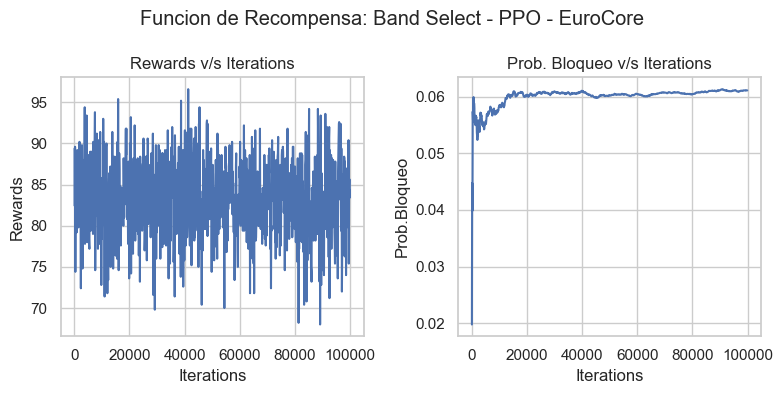

In [20]:
graph_Rewards_Bloqueo(x, rewardsArrayBS_PPO_Euro, probBloqueoArrayBS_PPO_Euro, "Band Select", "PPO", "EuroCore")


### 3) Funcion de Recompensa Length Based: (DONE)

#### 3.1) Data:

In [21]:
episodeRewardsArrayLB_PPO_Euro=[90.79999999999995, 90.99999999999996, 87.59999999999994, 84.59999999999995, 88.79999999999995, 76.39999999999996, 75.79999999999997, 86.19999999999996, 79.99999999999997, 85.59999999999995, 86.59999999999995, 84.19999999999996, 76.59999999999994, 91.39999999999995, 83.59999999999995, 82.79999999999997, 90.39999999999996, 82.59999999999997, 89.79999999999994, 82.59999999999997, 80.99999999999994, 85.59999999999998, 89.39999999999996, 80.19999999999997, 80.39999999999995, 78.39999999999998, 85.19999999999996, 87.59999999999997, 80.19999999999997, 83.79999999999997, 89.79999999999995, 84.59999999999998, 85.99999999999997, 83.99999999999996, 80.99999999999996, 84.59999999999997, 88.79999999999995, 83.19999999999996, 87.99999999999996, 89.79999999999995, 85.19999999999999, 82.99999999999994, 87.59999999999997, 77.79999999999998, 81.59999999999997, 89.19999999999996, 80.19999999999996, 89.99999999999997, 86.59999999999994, 79.99999999999997, 77.39999999999999, 87.19999999999997, 78.39999999999996, 85.59999999999997, 81.39999999999996, 84.79999999999997, 90.39999999999995, 88.99999999999996, 86.99999999999994, 76.39999999999996, 90.79999999999997, 85.19999999999996, 85.39999999999998, 88.19999999999997, 84.99999999999996, 89.99999999999999, 84.99999999999996, 77.19999999999999, 82.79999999999995, 84.19999999999997, 83.99999999999996, 82.59999999999995, 87.19999999999996, 73.19999999999997, 75.79999999999998, 83.79999999999998, 84.19999999999997, 82.99999999999999, 88.39999999999998, 82.99999999999997, 83.19999999999996, 80.79999999999998, 84.79999999999995, 82.79999999999997, 85.19999999999995, 81.79999999999995, 78.59999999999998, 80.99999999999999, 83.99999999999996, 90.59999999999998, 83.19999999999997, 83.19999999999996, 85.99999999999999, 88.39999999999998, 90.59999999999995, 85.19999999999995, 82.99999999999997, 74.19999999999995, 85.19999999999997, 83.19999999999997, 83.59999999999997, 85.59999999999994, 88.99999999999997, 86.19999999999996, 91.39999999999996, 77.99999999999996, 75.59999999999997, 90.79999999999994, 84.19999999999997, 85.79999999999995, 87.59999999999995, 73.59999999999998, 80.79999999999994, 86.19999999999997, 87.19999999999996, 79.19999999999995, 83.99999999999996, 83.19999999999995, 76.19999999999999, 77.99999999999996, 77.59999999999997, 82.39999999999995, 90.39999999999996, 73.79999999999997, 95.39999999999998, 90.99999999999997, 85.79999999999997, 81.6, 86.59999999999995, 75.19999999999997, 79.39999999999998, 81.99999999999999, 84.99999999999997, 86.39999999999996, 79.39999999999995, 90.99999999999996, 90.19999999999997, 85.59999999999997, 79.79999999999997, 74.39999999999998, 71.99999999999994, 82.19999999999996, 72.79999999999998, 83.79999999999997, 81.99999999999997, 86.19999999999996, 88.19999999999999, 75.59999999999997, 86.99999999999996, 70.39999999999998, 82.19999999999996, 86.19999999999996, 77.39999999999998, 83.79999999999997, 85.59999999999997, 84.39999999999998, 83.19999999999996, 87.59999999999997, 85.99999999999999, 87.59999999999997, 83.99999999999997, 76.59999999999997, 85.59999999999995, 83.59999999999995, 79.99999999999997, 84.59999999999998, 86.59999999999997, 85.39999999999998, 79.79999999999997, 77.39999999999995, 74.39999999999996, 80.79999999999997, 87.19999999999997, 81.39999999999998, 88.99999999999996, 76.79999999999997, 93.99999999999996, 84.99999999999997, 92.19999999999997, 95.19999999999996, 81.59999999999998, 73.19999999999996, 87.79999999999997, 87.79999999999997, 79.19999999999997, 83.79999999999997, 81.19999999999997, 81.99999999999996, 73.19999999999997, 86.59999999999997, 82.79999999999995, 80.99999999999997, 83.59999999999998, 83.79999999999997, 82.19999999999997, 80.79999999999997, 86.99999999999996, 82.39999999999998, 81.59999999999998, 88.79999999999997, 78.99999999999997, 85.39999999999998, 85.39999999999998, 79.99999999999997, 89.19999999999995, 84.59999999999997, 92.19999999999997, 85.79999999999997, 94.19999999999996, 89.39999999999996, 82.59999999999997, 82.59999999999998, 79.79999999999995, 89.59999999999995, 78.39999999999995, 75.99999999999996, 86.99999999999996, 85.99999999999997, 83.59999999999997, 75.79999999999997, 82.99999999999997, 86.79999999999995, 84.99999999999997, 83.59999999999997, 90.39999999999996, 84.59999999999997, 77.19999999999999, 86.39999999999996, 83.19999999999995, 80.99999999999997, 86.79999999999998, 84.19999999999996, 74.99999999999996, 78.19999999999997, 87.79999999999997, 81.19999999999996, 84.79999999999995, 82.99999999999996, 86.99999999999996, 95.99999999999997, 79.59999999999997, 79.99999999999997, 82.39999999999996, 84.59999999999997, 90.19999999999997, 88.19999999999997, 69.39999999999998, 90.39999999999995, 79.39999999999996, 86.19999999999997, 85.39999999999996, 86.99999999999996, 78.99999999999996, 79.39999999999996, 74.79999999999998, 80.39999999999998, 83.99999999999994, 82.99999999999999, 78.39999999999998, 86.19999999999996, 83.19999999999997, 77.79999999999998, 87.39999999999996, 84.39999999999998, 79.59999999999997, 85.79999999999998, 75.39999999999998, 88.99999999999996, 84.99999999999996, 83.19999999999997, 85.59999999999997, 93.59999999999995, 80.19999999999997, 84.39999999999996, 81.39999999999996, 79.19999999999997, 76.39999999999998, 83.59999999999998, 80.79999999999998, 90.19999999999997, 81.19999999999999, 89.99999999999997, 79.99999999999997, 81.79999999999997, 87.59999999999997, 83.59999999999998, 86.99999999999999, 85.39999999999998, 82.39999999999998, 86.59999999999995, 89.59999999999997, 74.79999999999998, 82.39999999999996, 82.19999999999996, 83.79999999999995, 90.19999999999996, 77.39999999999998, 80.99999999999996, 89.39999999999998, 89.19999999999996, 86.19999999999996, 82.39999999999995, 84.39999999999998, 85.19999999999997, 88.39999999999996, 77.59999999999997, 80.39999999999998, 82.39999999999996, 81.19999999999997, 86.59999999999998, 79.19999999999995, 67.59999999999995, 81.39999999999998, 86.19999999999996, 82.19999999999999, 91.39999999999996, 85.19999999999996, 74.19999999999997, 82.79999999999998, 79.99999999999997, 83.59999999999998, 88.19999999999996, 82.59999999999997, 86.19999999999996, 91.39999999999998, 79.59999999999998, 81.99999999999994, 88.39999999999998, 81.99999999999997, 81.19999999999997, 85.99999999999997, 80.59999999999998, 79.19999999999997, 88.99999999999997, 86.19999999999995, 85.59999999999998, 86.99999999999996, 86.19999999999999, 84.79999999999998, 76.99999999999999, 95.19999999999999, 80.59999999999995, 80.19999999999996, 84.59999999999998, 77.99999999999997, 78.59999999999998, 84.79999999999995, 82.39999999999998, 84.59999999999997, 90.19999999999996, 87.39999999999999, 88.19999999999996, 78.19999999999997, 78.79999999999995, 88.19999999999995, 82.59999999999997, 87.19999999999995, 83.59999999999997, 89.59999999999997, 80.59999999999995, 89.19999999999995, 77.59999999999998, 78.99999999999997, 82.19999999999997, 86.39999999999996, 81.19999999999996, 78.39999999999995, 79.39999999999998, 82.99999999999994, 75.99999999999997, 87.39999999999996, 89.59999999999995, 84.99999999999997, 89.99999999999997, 86.79999999999995, 87.99999999999996, 83.19999999999996, 86.19999999999995, 86.59999999999997, 79.59999999999997, 73.99999999999997, 77.79999999999998, 92.99999999999996, 76.79999999999997, 79.39999999999998, 90.99999999999997, 82.19999999999995, 88.59999999999997, 78.99999999999997, 87.99999999999997, 77.19999999999996, 83.19999999999996, 83.59999999999998, 84.59999999999995, 81.59999999999997, 83.39999999999996, 83.59999999999995, 88.79999999999997, 91.59999999999995, 78.19999999999996, 80.99999999999997, 77.59999999999997, 81.59999999999997, 86.39999999999998, 86.99999999999997, 76.19999999999996, 86.99999999999997, 87.39999999999995, 80.79999999999998, 82.59999999999998, 74.99999999999997, 85.39999999999995, 78.99999999999997, 86.99999999999997, 78.19999999999997, 78.59999999999998, 85.39999999999996, 84.39999999999996, 77.59999999999997, 81.19999999999996, 83.59999999999997, 84.39999999999993, 87.99999999999996, 79.59999999999997, 83.59999999999994, 89.79999999999997, 91.39999999999996, 82.39999999999998, 85.79999999999997, 79.19999999999995, 78.99999999999996, 83.59999999999995, 90.79999999999997, 87.99999999999994, 88.19999999999997, 87.59999999999997, 85.39999999999996, 88.99999999999996, 80.39999999999995, 85.19999999999997, 86.39999999999998, 90.39999999999998, 81.99999999999994, 87.99999999999997, 87.59999999999997, 76.79999999999995, 89.79999999999997, 79.99999999999997, 83.79999999999997, 89.39999999999995, 86.19999999999996, 85.79999999999997, 87.59999999999997, 93.99999999999997, 78.79999999999997, 85.79999999999997, 78.79999999999998, 79.99999999999997, 85.99999999999997, 91.39999999999998, 90.59999999999995, 86.39999999999998, 86.99999999999997, 91.39999999999996, 86.19999999999996, 83.39999999999996, 81.19999999999996, 81.99999999999997, 87.99999999999996, 78.79999999999997, 77.99999999999996, 90.59999999999995, 83.59999999999997, 92.19999999999997, 85.99999999999997, 80.59999999999995, 80.19999999999997, 87.99999999999994, 74.59999999999998, 86.59999999999995, 80.79999999999997, 75.79999999999994, 68.79999999999998, 85.59999999999997, 77.79999999999998, 81.59999999999997, 81.39999999999998, 85.39999999999996, 83.99999999999997, 84.8, 86.59999999999998, 76.99999999999997, 90.39999999999995, 83.39999999999995, 84.39999999999996, 80.39999999999998, 79.39999999999998, 80.99999999999996, 85.19999999999996, 92.59999999999997, 89.39999999999998, 86.19999999999997, 86.59999999999997, 88.59999999999997, 80.39999999999998, 86.99999999999997, 77.59999999999995, 84.99999999999996, 81.59999999999997, 79.99999999999996, 84.19999999999997, 86.39999999999998, 88.59999999999998, 83.39999999999996, 80.39999999999998, 87.99999999999996, 81.79999999999995, 78.59999999999998, 76.39999999999998, 82.99999999999997, 81.79999999999995, 83.99999999999997, 86.99999999999996, 83.79999999999997, 81.39999999999995, 85.79999999999995, 77.39999999999998, 78.39999999999999, 82.79999999999995, 84.59999999999998, 80.39999999999998, 87.19999999999996, 81.59999999999998, 87.59999999999997, 75.79999999999995, 80.79999999999995, 78.39999999999998, 67.59999999999997, 92.19999999999997, 92.19999999999995, 83.79999999999997, 83.59999999999998, 82.39999999999998, 83.39999999999995, 85.99999999999997, 87.19999999999995, 82.19999999999997, 82.39999999999998, 78.99999999999996, 89.8, 82.39999999999998, 74.39999999999996, 89.79999999999997, 81.79999999999994, 92.99999999999997, 81.19999999999996, 85.59999999999997, 84.59999999999997, 81.79999999999997, 83.79999999999995, 80.59999999999997, 84.19999999999997, 82.79999999999995, 77.99999999999997, 75.79999999999998, 86.99999999999997, 80.19999999999997, 85.99999999999997, 90.99999999999996, 88.39999999999998, 87.19999999999997, 79.79999999999997, 78.99999999999999, 82.19999999999996, 82.19999999999997, 79.99999999999996, 86.39999999999996, 79.59999999999995, 82.99999999999997, 87.59999999999997, 84.19999999999997, 88.59999999999997, 83.59999999999998, 90.99999999999994, 89.99999999999997, 76.59999999999997, 87.39999999999995, 90.79999999999998, 85.39999999999996, 79.59999999999997, 88.79999999999997, 84.59999999999997, 85.79999999999998, 80.59999999999997, 87.59999999999997, 84.59999999999995, 84.19999999999996, 78.79999999999997, 81.19999999999997, 82.19999999999996, 81.59999999999997, 75.79999999999998, 81.39999999999996, 81.99999999999999, 85.39999999999998, 80.79999999999995, 91.59999999999997, 84.39999999999995, 84.79999999999998, 73.59999999999997, 80.79999999999998, 82.79999999999998, 75.79999999999995, 74.39999999999998, 82.39999999999996, 86.19999999999996, 83.59999999999995, 83.79999999999997, 84.99999999999996, 81.79999999999997, 91.79999999999997, 81.99999999999996, 83.99999999999997, 86.99999999999997, 83.99999999999996, 88.39999999999998, 82.99999999999996, 84.99999999999997, 86.99999999999994, 84.79999999999997, 84.39999999999996, 81.39999999999998, 83.19999999999996, 84.39999999999995, 86.19999999999997, 91.79999999999997, 81.99999999999997, 84.79999999999998, 86.39999999999998, 84.59999999999995, 87.39999999999996, 89.79999999999995, 86.39999999999999, 85.6, 82.99999999999997, 84.79999999999998, 80.79999999999995, 85.59999999999997, 88.19999999999996, 84.79999999999995, 83.99999999999997, 76.19999999999996, 81.19999999999997, 83.99999999999996, 89.39999999999996, 87.19999999999999, 74.39999999999998, 82.19999999999999, 79.79999999999997, 84.79999999999995, 76.99999999999997, 84.19999999999996, 82.19999999999996, 86.99999999999997, 84.79999999999997, 81.79999999999995, 85.59999999999998, 80.19999999999997, 76.39999999999998, 76.79999999999998, 79.39999999999998, 79.19999999999999, 77.19999999999997, 86.79999999999995, 86.79999999999995, 84.79999999999997, 84.99999999999997, 81.99999999999997, 77.79999999999997, 76.19999999999996, 89.79999999999997, 81.19999999999997, 83.99999999999996, 85.79999999999998, 79.6, 90.19999999999997, 79.79999999999995, 80.39999999999996, 82.79999999999998, 82.99999999999996, 78.99999999999999, 80.19999999999997, 89.59999999999997, 89.79999999999995, 75.99999999999999, 79.59999999999997, 81.99999999999999, 82.59999999999997, 80.79999999999997, 86.79999999999997, 77.19999999999996, 85.79999999999997, 76.19999999999997, 88.19999999999999, 80.39999999999998, 82.79999999999995, 84.79999999999997, 81.59999999999997, 81.39999999999998, 82.79999999999998, 84.39999999999998, 79.39999999999996, 89.99999999999997, 76.19999999999996, 83.99999999999997, 83.59999999999997, 87.59999999999997, 75.39999999999998, 86.99999999999996, 89.79999999999997, 80.99999999999996, 81.19999999999997, 85.19999999999995, 83.79999999999995, 85.99999999999999, 83.99999999999996, 92.99999999999996, 84.39999999999996, 84.19999999999996, 74.39999999999995, 86.79999999999997, 81.8, 77.79999999999994, 71.99999999999999, 82.59999999999995, 82.59999999999997, 87.39999999999996, 89.39999999999998, 81.19999999999996, 85.99999999999996, 86.39999999999995, 85.39999999999996, 87.39999999999996, 86.99999999999997, 85.59999999999997, 81.39999999999996, 85.99999999999996, 74.19999999999997, 85.39999999999998, 75.19999999999997, 81.59999999999995, 83.99999999999997, 80.99999999999996, 84.59999999999998, 78.19999999999996, 81.59999999999997, 82.59999999999997, 90.19999999999997, 90.99999999999996, 86.99999999999997, 74.99999999999996, 87.19999999999996, 80.19999999999997, 89.99999999999997, 78.39999999999993, 78.39999999999998, 84.79999999999995, 85.39999999999998, 83.79999999999995, 79.59999999999997, 83.79999999999997, 83.39999999999996, 92.39999999999995, 83.59999999999998, 87.99999999999997, 88.19999999999996, 87.59999999999997, 86.59999999999995, 86.19999999999996, 83.59999999999997, 75.99999999999996, 86.59999999999997, 84.59999999999997, 77.99999999999997, 84.79999999999997, 87.99999999999996, 86.99999999999996, 84.59999999999998, 77.39999999999996, 90.59999999999998, 81.79999999999998, 78.99999999999996, 92.99999999999997, 86.19999999999996, 83.59999999999995, 87.59999999999997, 80.39999999999996, 87.39999999999995, 79.19999999999996, 82.79999999999995, 79.19999999999997, 81.39999999999998, 89.19999999999997, 80.99999999999999, 81.79999999999995, 88.59999999999998, 84.19999999999997, 83.59999999999994, 82.19999999999997, 82.59999999999997, 77.99999999999997, 91.79999999999998, 88.79999999999997, 91.19999999999997, 84.19999999999999, 77.19999999999995, 87.79999999999998, 82.79999999999995, 83.99999999999997, 82.99999999999997, 77.59999999999997, 86.99999999999996, 77.39999999999998, 82.39999999999996, 87.19999999999996, 77.39999999999998, 82.39999999999995, 81.39999999999996, 79.59999999999997, 77.99999999999997, 81.99999999999997, 84.19999999999999, 69.39999999999996, 80.39999999999996, 69.99999999999997, 82.39999999999996, 86.59999999999995, 86.79999999999998, 86.39999999999998, 77.59999999999997, 85.39999999999996, 78.59999999999998, 78.19999999999997, 92.79999999999998, 82.39999999999996, 82.59999999999995, 89.59999999999997, 85.19999999999996, 79.39999999999996, 84.59999999999997, 75.39999999999998, 81.79999999999997, 74.59999999999997, 83.19999999999996, 80.19999999999996, 85.19999999999996, 79.59999999999997, 91.79999999999995, 89.19999999999997, 85.39999999999995, 85.19999999999996, 77.99999999999999, 77.99999999999997, 81.79999999999998, 80.39999999999996, 74.19999999999997, 87.39999999999998, 90.59999999999997, 89.39999999999996, 87.19999999999996, 91.79999999999995, 86.19999999999997, 78.39999999999996, 84.39999999999999, 82.99999999999999, 75.39999999999998, 74.79999999999997, 88.19999999999997, 69.39999999999998, 77.39999999999996, 78.39999999999998, 82.59999999999997, 87.79999999999997, 85.19999999999997, 81.39999999999996, 82.79999999999997, 83.99999999999996, 76.19999999999997, 90.39999999999996, 77.39999999999998, 79.19999999999997, 82.79999999999997, 88.39999999999995, 79.19999999999996, 84.59999999999997, 88.99999999999996, 85.79999999999997, 77.99999999999997, 87.79999999999997, 75.8, 86.39999999999996, 81.19999999999997, 88.99999999999999, 91.59999999999997, 87.19999999999996, 89.19999999999996, 88.39999999999996, 77.39999999999998, 72.79999999999997, 80.39999999999996, 73.79999999999997, 82.99999999999999, 85.79999999999997, 93.19999999999997, 72.8, 82.39999999999995, 84.39999999999995, 83.19999999999996, 79.39999999999998, 76.59999999999998, 84.79999999999995, 79.59999999999997, 72.99999999999997, 83.99999999999997, 76.59999999999998, 80.79999999999995, 83.59999999999997, 77.39999999999996, 83.19999999999997, 86.79999999999997, 89.79999999999997, 82.19999999999995, 90.19999999999997, 85.39999999999996, 84.39999999999996, 95.59999999999995, 83.99999999999994, 79.59999999999995, 87.79999999999997, 84.39999999999998, 91.79999999999995, 83.59999999999997, 80.79999999999998, 87.59999999999997, 85.59999999999995, 81.19999999999997, 81.59999999999997, 92.79999999999997, 84.79999999999997, 90.39999999999996, 85.99999999999997, 87.39999999999998, 78.59999999999997, 87.79999999999997, 84.99999999999996, 87.39999999999996, 74.59999999999997, 84.19999999999996, 89.99999999999996, 82.39999999999996, 81.99999999999997, 88.19999999999996, 83.19999999999997, 80.19999999999997, 71.59999999999997, 87.19999999999997, 82.99999999999997, 77.19999999999996, 87.19999999999996, 82.19999999999997, 80.39999999999998, 77.39999999999996, 86.39999999999998, 84.19999999999997, 73.19999999999997, 80.6, 88.19999999999997, 89.39999999999996, 91.99999999999996, 92.19999999999993, 93.79999999999995, 84.19999999999996, 91.99999999999999, 78.39999999999996, 92.59999999999998, 86.39999999999996, 78.79999999999998, 88.79999999999997, 87.79999999999997, 76.59999999999997, 76.6, 76.19999999999997, 80.39999999999998, 86.79999999999997, 83.79999999999995, 73.59999999999998, 77.59999999999997, 88.59999999999995, 89.19999999999997, 83.79999999999997, 81.39999999999996, 80.19999999999996, 81.59999999999994, 80.59999999999998, 84.39999999999996, 79.39999999999998, 80.59999999999998, 80.99999999999996, 84.79999999999995, 82.79999999999998, 84.79999999999995, 83.59999999999995, 78.79999999999997, 84.59999999999997, 88.99999999999996, 76.19999999999997, 86.59999999999998, 83.39999999999995, 81.59999999999997, 81.99999999999997, 92.0, 94, 92, 90, 94, 88, 90, 90, 86, 86, 90, 90, 92, 92, 82, 86, 86, 88, 86, 84, 84, 94, 90, 86, 90, 86, 88, 86, 86, 90, 94, 88, 90, 90, 88, 84, 90, 88, 92, 82, 90, 88, 88, 86, 86, 84, 88, 90, 94, 90, 78, 92, 92, 90, 90, 90, 98, 86, 100, 80, 84, 86, 92, 90, 94, 92, 90, 92, 86, 90, 92, 84, 94, 78, 84, 96, 92, 90, 92, 98, 84, 92, 86, 92, 78, 86, 84, 94, 94, 90, 86, 94, 92, 88, 88, 84, 80, 80, 92, 86, 88, 82, 98, 90, 98, 96, 82, 86, 90, 90, 82, 92, 82, 78, 96, 88, 88, 90, 88, 96, 88, 90, 88, 92, 90, 82, 96, 86, 90, 82, 90, 86, 90, 88, 100, 80, 88, 80, 92, 86, 80, 82, 88, 86, 90, 86, 86, 88, 82, 84, 84, 90, 82, 98, 88, 94, 82, 96, 86, 84, 94, 88, 90, 94, 90, 88, 96, 94, 94, 94, 90, 82, 88, 88, 86, 88, 94, 90, 82, 92, 94, 86, 86, 92, 90, 88, 92, 72, 96, 84, 82, 86, 86, 86, 94, 84, 94, 90, 86, 86, 96, 88, 96, 96, 84, 92, 90, 90, 96, 90, 86, 88, 88, 82, 92, 84, 88, 88, 88, 84, 90, 92, 92, 92, 88, 86, 90, 90, 88, 92, 90, 90, 90, 88, 90, 86, 90, 88, 88, 92, 96, 86, 90, 90, 90, 78, 90, 86, 92, 90, 92, 94, 92, 86, 82, 92, 94, 98, 90, 90, 82, 94, 94, 92, 80, 96, 92, 92, 92, 86, 94, 92, 86, 92, 84, 88, 88, 90, 92, 96, 88, 94, 92, 96, 92, 94, 96, 92, 98, 88, 98, 92, 86, 90, 96, 88, 78, 82, 90, 94, 92, 92, 90, 86, 86, 90, 80, 96, 96, 88, 90, 86, 84, 90, 94, 84, 92, 90, 94, 86, 86, 86, 86, 92, 98, 88, 92, 86, 96, 84, 92, 90, 96, 92, 88, 92, 94, 92, 90, 88, 88, 94, 80, 92, 84, 80, 90, 84, 86, 94, 82, 90, 80, 88, 88, 92, 84, 92, 84, 88, 80, 82, 86, 86, 84, 86, 92, 88, 90, 92, 80, 94, 94, 88, 92, 84, 88, 92, 86, 84, 88, 88, 96, 86, 80, 86, 86, 90, 92, 90, 88, 94, 92, 98, 90, 90, 92, 84, 92, 94, 92, 88, 86, 92, 94, 78, 84, 96, 82, 84, 92, 90, 90, 84, 92, 88, 84, 84, 90, 94, 86, 96, 82, 90, 92, 90, 94, 82, 92, 88, 88, 82, 94, 90, 86, 86, 88, 90, 86, 86, 96, 94, 94, 92, 88, 92, 98, 90, 92, 96, 90, 90, 88, 86, 88, 78, 88, 86, 86, 88, 92, 96, 84, 88, 92, 96, 78, 80, 96, 90, 86, 86, 96, 90, 90, 78, 86, 94, 88, 82, 84, 92, 92, 92, 84, 86, 84, 90, 86, 80, 86, 92, 86, 92, 90, 86, 88, 84, 88, 84, 86, 86, 86, 92, 86, 86, 86, 84, 86, 88, 90, 84, 94, 86, 92, 82, 80, 88, 84, 84, 92, 84, 86, 90, 86, 96, 92, 88, 90, 94, 84, 90, 86, 84, 86, 96, 82, 90, 92, 86, 94, 90, 76, 86, 96, 96, 82, 90, 88, 90, 86, 88, 84, 84, 90, 100, 86, 78, 98, 82, 78, 88, 88, 94, 84, 88, 90, 92, 86, 96, 92, 90, 84, 96, 90, 88, 82, 92, 92, 90, 94, 90, 90, 94, 94, 80, 96, 88, 82, 90, 92, 86, 82, 86, 92, 78, 90, 76, 82, 84, 88, 96, 92, 96, 96, 92, 90, 84, 90, 84, 84, 88, 88, 88, 86, 86, 90, 92, 84, 86, 88, 94, 92, 90, 82, 92, 86, 86, 86, 96, 92, 84, 88, 90, 86, 90, 90, 92, 88, 98, 94, 94, 88, 92, 90, 96, 90, 94, 92, 92, 84, 88, 88, 90, 86, 84, 90, 94, 90, 90, 94, 88, 94, 90, 92, 90, 88, 92, 92, 86, 90, 88, 86, 92, 86, 90, 90, 88, 86, 90, 82, 80, 92, 94, 92, 90, 90, 82, 96, 88, 88, 92, 96, 84, 82, 84, 86, 88, 88, 92, 92, 86, 84, 88, 90, 90, 92, 86, 88, 92, 92, 90, 84, 84, 90, 88, 94, 82, 88, 92, 92, 90, 92, 82, 86, 92, 94, 92, 92, 94, 96, 92, 80, 82, 88, 80, 92, 88, 92, 90, 92, 86, 84, 94, 88, 78, 90, 86, 92, 90, 82, 90, 84, 96, 90, 94, 90, 92, 92, 86, 86, 90, 88, 84, 86, 90, 84, 94, 92, 86, 80, 94, 84, 90, 88, 90, 88, 84, 80, 82, 82, 86, 94, 92, 94, 84, 86, 94, 94, 88, 92, 86, 88, 90, 88, 82, 86, 90, 82, 80, 94, 90, 86, 92, 98, 90, 90, 92, 92, 94, 94, 92, 92, 88, 76, 92, 86, 84, 86, 92, 94, 94, 82, 92, 92, 94, 92, 88, 88, 86, 88, 84, 88, 84, 78, 78, 90, 90, 86, 88, 88, 86, 90, 86, 86, 90, 94, 86, 90, 88, 90, 84, 88, 82, 90, 86, 88, 88, 90, 90, 88, 94, 84, 96, 84, 88, 94, 94, 94, 90, 86, 96, 90, 82, 92, 92, 92, 94, 96, 90, 90, 92, 88, 92, 88, 84, 98, 94, 88, 98, 90, 94, 94, 94, 86, 80, 84, 94, 92, 80, 92, 84, 96, 88, 92, 90, 98, 88, 88, 76, 92, 84, 84, 84, 94, 92, 94, 96, 92, 84, 96, 76, 92, 78, 90, 88, 92, 88, 94, 88, 94, 82, 84, 90, 94, 96, 90, 92, 92, 92, 92, 90, 82, 84, 86, 80, 92, 94, 94, 84, 88, 92, 86, 90, 90, 86, 88, 88, 90, 92, 92, 84, 96, 88, 92, 88, 86, 84, 94, 86, 90, 82, 88, 92, 94, 86, 90, 92, 92, 98, 90, 94, 88, 86, 92, 82, 82, 90, 94, 94, 94, 92, 88, 90, 80, 84, 82, 92, 88, 86, 92, 88, 90, 82, 90, 92, 84, 90, 94, 90, 92, 90, 84, 86, 84, 96, 98, 92, 94, 84, 94, 94, 80, 86, 94, 92, 90, 90, 98, 88, 88, 84, 90, 86, 78, 92, 80, 84, 86, 94, 86, 86, 86, 96, 92, 88, 88, 92, 98, 88, 84, 92, 96, 82, 90, 88, 92, 82, 94, 82, 84, 94, 90, 88, 90, 96, 82, 88, 96, 92, 86, 84, 90, 88, 96, 86, 90, 86, 90, 78, 84, 92, 84, 82, 92, 82, 84, 82, 80, 78, 86, 90, 88, 90, 92, 90, 88, 86, 82, 84, 92, 96, 94, 86, 90, 80, 92, 88, 90, 92, 96, 92, 88, 96, 92, 90, 88, 90, 92, 92, 90, 80, 90, 90, 84, 88, 94, 96, 88, 92, 82, 86, 82, 88, 92, 90, 80, 92, 96, 88, 88, 82, 80, 86, 86, 84, 88, 96, 84, 82, 86, 76, 96, 90, 88, 80, 90, 88, 86, 86, 76, 92, 92, 92, 84, 84, 92, 86, 82, 92, 84, 84, 92, 82, 88, 86, 92, 90, 82, 92, 88, 92, 88, 86, 90, 84, 80, 86, 84, 88, 92, 88, 82, 96, 88, 90, 92, 96, 90, 90, 84, 82, 88, 90, 84, 92, 92, 92, 94, 88, 88, 86, 98, 90, 84, 84, 84, 88, 94, 94, 88, 84, 90, 88, 84, 86, 88, 84, 90, 92, 94, 82, 82, 90, 94, 92, 86, 88, 82, 88, 94, 94, 88, 90, 86, 84, 94, 90, 74, 80, 88, 86, 88, 92, 82, 78, 84, 88, 90, 88, 88, 92, 92, 84, 90, 84, 90, 82, 92, 86, 88, 90, 94, 86, 88, 88, 90, 86, 88, 88, 86, 94, 92, 92, 90, 96, 88, 84, 94, 86, 92, 92, 84, 84, 92, 90, 86, 92, 88, 94, 92, 92, 92, 86, 94, 90, 94, 86, 96, 84, 88, 88, 90, 84, 90, 90, 92, 90, 92, 84, 78, 90, 84, 82, 92, 88, 92, 94, 82, 90, 86, 90, 92, 88, 94, 80, 94, 88, 92, 92, 94, 94, 86, 90, 92, 90, 98, 90, 94, 90, 90, 88, 92, 90, 90, 86, 88, 90, 94, 84, 82, 96, 98, 86, 80, 86, 96, 90, 94, 90, 82, 82, 86, 88, 86, 90, 86, 92, 90, 90, 86, 98, 88, 80, 98, 94, 78, 96, 92, 90, 84, 92, 96, 90, 88, 84, 82, 84, 96, 82]
rewardsArrayLB_PPO_Euro=[0, 88, 92, 84, 92, 90, 80, 88, 94, 84, 84, 88, 88, 90, 86, 98, 84, 86, 80, 96, 92, 86, 92, 82, 90, 98, 88, 88, 88, 86, 92, 86, 86, 94, 86, 88, 86, 88, 92, 84, 88, 94, 96, 92, 94, 90, 92, 96, 92, 92, 96, 86, 92, 86, 84, 90, 78, 90, 84, 84, 90, 94, 92, 84, 88, 96, 90, 80, 84, 96, 90, 84, 90, 92, 92, 86, 80, 84, 98, 84, 82, 86, 94, 88, 92, 86, 86, 84, 94, 82, 80, 82, 96, 90, 92, 86, 86, 84, 92, 84, 88, 84, 84, 90, 90, 84, 88, 78, 88, 90, 86, 92, 84, 94, 86, 86, 84, 84, 84, 82, 90, 90, 84, 90, 86, 90, 94, 88, 88, 96, 94, 80, 94, 78, 88, 90, 94, 82, 86, 90, 94, 92, 86, 74, 92, 96, 94, 84, 90, 88, 90, 82, 92, 80, 86, 94, 98, 80, 86, 96, 80, 74, 90, 94, 84, 92, 90, 88, 90, 90, 92, 94, 88, 86, 98, 86, 84, 86, 90, 98, 88, 94, 90, 90, 96, 88, 86, 94, 84, 82, 94, 86, 90, 78, 92, 90, 76, 92, 72, 88, 82, 90, 96, 94, 96, 96, 86, 90, 88, 80, 88, 88, 90, 88, 82, 88, 86, 92, 92, 86, 82, 92, 92, 90, 94, 82, 94, 80, 88, 86, 100, 86, 84, 92, 88, 86, 94, 88, 88, 94, 98, 92, 94, 90, 90, 92, 92, 94, 90, 94, 90, 84, 86, 90, 90, 84, 88, 90, 94, 88, 92, 92, 92, 92, 92, 90, 86, 90, 94, 88, 86, 92, 90, 84, 90, 90, 90, 88, 88, 86, 90, 84, 78, 96, 92, 94, 88, 86, 86, 98, 86, 88, 92, 96, 86, 78, 88, 84, 84, 94, 92, 86, 86, 86, 90, 88, 92, 92, 82, 94, 90, 90, 86, 86, 90, 88, 86, 90, 82, 92, 94, 86, 96, 92, 80, 88, 90, 98, 88, 96, 90, 96, 88, 82, 86, 86, 82, 90, 90, 86, 92, 92, 88, 86, 94, 82, 84, 90, 86, 90, 86, 86, 92, 86, 96, 88, 94, 88, 90, 96, 84, 86, 92, 84, 84, 90, 90, 82, 92, 96, 80, 84, 98, 84, 88, 90, 90, 84, 84, 82, 82, 80, 86, 96, 90, 94, 88, 82, 96, 92, 90, 90, 86, 90, 90, 82, 86, 90, 84, 80, 86, 96, 84, 90, 94, 94, 92, 90, 90, 94, 90, 94, 96, 94, 82, 82, 86, 86, 82, 94, 90, 92, 94, 82, 94, 92, 92, 92, 90, 86, 88, 82, 88, 86, 82, 78, 84, 90, 86, 92, 80, 92, 88, 86, 84, 92, 92, 90, 88, 88, 90, 84, 90, 82, 86, 88, 90, 86, 88, 88, 94, 88, 90, 88, 94, 84, 90, 92, 96, 92, 88, 92, 92, 88, 86, 92, 90, 94, 96, 92, 90, 90, 94, 86, 94, 82, 90, 100, 90, 92, 94, 94, 92, 94, 92, 80, 86, 86, 92, 92, 78, 98, 84, 96, 84, 94, 92, 96, 82, 86, 86, 88, 86, 80, 90, 90, 94, 94, 94, 88, 92, 90, 80, 88, 80, 92, 88, 90, 90, 94, 88, 90, 86, 84, 90, 96, 94, 90, 92, 92, 88, 94, 86, 86, 84, 84, 86, 88, 98, 84, 94, 88, 90, 82, 94, 86, 90, 86, 84, 92, 94, 96, 80, 94, 90, 94, 86, 86, 86, 92, 90, 86, 80, 94, 92, 92, 88, 84, 94, 96, 96, 92, 90, 88, 84, 98, 76, 84, 94, 94, 92, 94, 90, 90, 84, 86, 82, 84, 90, 86, 90, 90, 86, 92, 86, 88, 90, 86, 92, 92, 88, 96, 84, 88, 86, 86, 96, 96, 88, 92, 90, 92, 90, 86, 86, 96, 92, 88, 92, 94, 90, 84, 86, 86, 88, 84, 84, 84, 84, 88, 90, 92, 84, 88, 96, 86, 90, 88, 96, 94, 84, 90, 94, 92, 84, 82, 98, 84, 90, 90, 80, 88, 92, 90, 90, 88, 96, 80, 92, 96, 90, 84, 88, 88, 88, 96, 90, 90, 82, 92, 76, 86, 84, 88, 84, 94, 76, 86, 86, 76, 82, 84, 94, 84, 92, 90, 88, 90, 80, 90, 84, 92, 96, 92, 86, 88, 84, 90, 92, 86, 94, 96, 90, 92, 90, 96, 90, 86, 88, 98, 90, 86, 82, 90, 84, 90, 90, 96, 92, 88, 92, 84, 80, 84, 92, 92, 84, 82, 96, 90, 94, 84, 82, 82, 86, 86, 86, 90, 94, 80, 82, 84, 84, 94, 88, 84, 88, 86, 80, 92, 82, 82, 94, 90, 92, 86, 86, 90, 80, 88, 88, 86, 86, 84, 90, 84, 88, 94, 88, 84, 92, 88, 92, 84, 88, 92, 78, 86, 82, 86, 90, 92, 86, 86, 90, 92, 86, 96, 94, 88, 88, 88, 80, 90, 90, 84, 92, 92, 94, 90, 94, 86, 88, 98, 86, 80, 84, 88, 90, 94, 94, 84, 86, 90, 88, 80, 92, 78, 92, 90, 96, 90, 80, 88, 88, 94, 86, 84, 92, 84, 90, 96, 90, 90, 90, 82, 90, 92, 88, 72, 80, 88, 92, 84, 92, 78, 78, 88, 90, 88, 90, 86, 96, 90, 84, 88, 88, 88, 84, 86, 86, 90, 92, 92, 84, 90, 84, 96, 84, 92, 84, 86, 94, 92, 92, 94, 92, 88, 86, 96, 80, 94, 92, 84, 86, 94, 86, 86, 96, 86, 92, 94, 88, 94, 86, 94, 94, 90, 86, 100, 80, 88, 88, 90, 86, 90, 88, 92, 86, 96, 80, 84, 84, 84, 84, 94, 86, 94, 96, 82, 88, 88, 88, 90, 92, 90, 86, 88, 90, 94, 92, 96, 94, 82, 90, 92, 92, 96, 92, 90, 92, 88, 86, 100, 88, 88, 86, 90, 90, 94, 76, 92, 96, 96, 80, 84, 88, 98, 86, 96, 90, 80, 82, 90, 88, 86, 88, 86, 88, 92, 90, 88, 94, 90, 84, 96, 86, 86, 96, 92, 90, 86, 90, 94, 92, 88, 78, 80, 94, 94]
probBloqueoArrayLB_PPO_Euro=[0.0, 0.0594059405940594, 0.04975124378109453, 0.059800664451827246, 0.05486284289276808, 0.05389221556886228, 0.06156405990016639, 0.06134094151212553, 0.05742821473158552, 0.05993340732519423, 0.061938061938061936, 0.061762034514078114, 0.061615320566194835, 0.06072252113758647, 0.06138472519628837, 0.057961359093937376, 0.05933791380387258, 0.059964726631393295, 0.06218767351471405, 0.05996843766438716, 0.05897051474262868, 0.05949547834364588, 0.05860972285324852, 0.05997392438070404, 0.059558517284464804, 0.057576969212315074, 0.05767012687427912, 0.05775638652350981, 0.057836486968939664, 0.058255773871078935, 0.05764745084971676, 0.058045791680103195, 0.058419243986254296, 0.05755831566192063, 0.057924139958835635, 0.057983433304770064, 0.0583171341294085, 0.05836260470143204, 0.05787950539331755, 0.058446552166111256, 0.058485378655336165, 0.05779078273591807, 0.056891216377053085, 0.05649848872355266, 0.05589638718473074, 0.05576538546989558, 0.055422734188219955, 0.054669219315039354, 0.05436367423453447, 0.05407059783717608, 0.05338932213557288, 0.053714957851401686, 0.05345125937319746, 0.053763440860215055, 0.05424921310868358, 0.05417196873295765, 0.05516871987145153, 0.05507805648131907, 0.055507671091191174, 0.05592272496187087, 0.05582402932844526, 0.055400753974758236, 0.055152394775036286, 0.05554673861291858, 0.05561630995157007, 0.0550684510075373, 0.05499166792910165, 0.05566333383077152, 0.056021173356859286, 0.055499203014055934, 0.05542065419225825, 0.05576679340937896, 0.055686710179141785, 0.05547185317079852, 0.05526280232401027, 0.05545927209705372, 0.056045257202999604, 0.056356317361381636, 0.055762081784386616, 0.056068852044045055, 0.05649293838270216, 0.05665967164547587, 0.056334593342275335, 0.056378749548247196, 0.056183787644328055, 0.056346312198564875, 0.0565050575514475, 0.05677508332375589, 0.05647085558459266, 0.056847545219638244, 0.05732696367070326, 0.05768596857488188, 0.057276383001847626, 0.05719815073647995, 0.05701521114775024, 0.057151878749605305, 0.05728569940631184, 0.05751984331512215, 0.057341087644117945, 0.05756994243005757, 0.0575942405759424, 0.057816057816057816, 0.05803352612488972, 0.057955538297252696, 0.05787905009133737, 0.05808970574231025, 0.058107725686256016, 0.058592654892066165, 0.058605684658827886, 0.05852674066599395, 0.05863103354240524, 0.05846320151337717, 0.05865547718953665, 0.05840191133528006, 0.058503640031576175, 0.05860359968698374, 0.05878803551417981, 0.058969318861635756, 0.05914752987034997, 0.05940677254012268, 0.05932838930089159, 0.05925130154532683, 0.059421358905007785, 0.05934476871799041, 0.05943069107330054, 0.05935525157987361, 0.0591222918815967, 0.059129202425005904, 0.05913600499960941, 0.058832648631889, 0.05861087608645489, 0.05892679948095565, 0.05870767366108628, 0.0590933012555447, 0.05910006715916723, 0.05903266424709281, 0.05881920447025954, 0.05904678490621122, 0.05912615027896529, 0.05906049924465866, 0.0588529390757803, 0.05871923977022906, 0.05879867614956693, 0.059296552688623175, 0.05916255815568363, 0.05889249017309151, 0.05869460995822204, 0.05883953472552888, 0.05877981217485305, 0.05878800080531508, 0.058729418038797415, 0.05893649427190252, 0.05881192026840339, 0.05908110581007777, 0.059152003116680736, 0.05896393781046384, 0.05865008653291456, 0.058913445003502964, 0.05898360863236504, 0.05873844412301113, 0.058996312730454345, 0.059437302030929756, 0.059379050675884205, 0.059198822158149804, 0.05932565087494665, 0.059208532816192955, 0.05915306306848985, 0.05915813424345848, 0.059103624784239035, 0.05904976036920892, 0.05893770954649726, 0.058768493070580664, 0.05877565257833847, 0.05884052944916479, 0.05855985288201827, 0.05862522141591909, 0.058746662121470374, 0.05881023670979041, 0.058760743778439414, 0.05848835260599967, 0.05849675018054552, 0.058339318269708854, 0.05829350035712323, 0.0582481831593902, 0.05804032389544046, 0.058050916166693695, 0.058115155099188215, 0.0579648147157906, 0.058082016913993936, 0.05825088619649754, 0.05810220514709752, 0.05816449400554945, 0.05812197281391594, 0.05839075695559816, 0.05829596412556054, 0.05825342290138967, 0.05856844038569461, 0.05847418912745546, 0.058885914852785215, 0.05889151298929702, 0.05904704764761762, 0.059002039699517436, 0.05880896985297757, 0.058667060735924335, 0.05847752561148963, 0.058289839520023416, 0.05834668219989321, 0.058306362011497026, 0.058314504110379306, 0.05851394670111478, 0.05852102280843769, 0.058528031846831904, 0.058487807178906656, 0.05849490634242524, 0.0586421195271249, 0.05864843495651365, 0.05870098606545993, 0.05861481037740196, 0.05852942525572222, 0.05858179991781197, 0.058724603427116946, 0.058639880548391476, 0.058555920904463765, 0.05851755526657997, 0.058390250435248425, 0.058530731967468115, 0.05840449537631078, 0.0585877274128893, 0.058593921319240384, 0.05864372734815074, 0.058388765705838876, 0.05843902861347994, 0.0585319598293177, 0.05845242693446633, 0.058459040211956755, 0.05850814858942173, 0.05838735646794627, 0.058394160583941604, 0.058400907524893915, 0.058282080247688384, 0.05808091329527936, 0.058005891871706565, 0.05789016982769307, 0.05785770132916341, 0.05782549895496086, 0.0577527447859271, 0.05768058209015894, 0.05756851949313793, 0.057538002499899196, 0.057427412553712705, 0.057397704091836324, 0.05748774949205211, 0.05753739930955121, 0.0575076083949251, 0.05747805204519507, 0.05756636994627662, 0.057575875942346005, 0.057546398972802615, 0.05743963412270842, 0.05744951932357824, 0.057382408368908885, 0.05731581165472587, 0.05724972329300408, 0.05718413748526672, 0.05711904852088936, 0.05709218520055847, 0.05714070899590241, 0.05711396576907232, 0.057012798029924254, 0.05702390245715773, 0.05707196029776675, 0.05700896645880226, 0.05698319914709018, 0.05706750668473682, 0.05704171380606547, 0.05701610850514527, 0.05699068874316148, 0.05700155229053103, 0.05701233768569476, 0.057058886778251675, 0.0570336773686654, 0.05711540514572435, 0.0573029325201234, 0.05717112469524045, 0.05711066511742544, 0.057015543314269675, 0.057025978112653405, 0.05707118218877391, 0.05711607235859866, 0.05695304660738383, 0.05699803455053274, 0.057008350228514484, 0.05695010444847779, 0.056823999180915324, 0.056868813985918844, 0.05704891359614928, 0.057058883145839664, 0.05713612336284973, 0.057212845206536696, 0.05712183539012073, 0.05706476450784974, 0.0571077372844756, 0.057150425482599916, 0.057192831919738625, 0.05716917206670833, 0.05717845316546998, 0.057122316264174376, 0.057066545063678704, 0.05717346839388331, 0.05708553121258212, 0.05706267539756782, 0.057039966560560755, 0.057081503797955194, 0.05712277563017156, 0.0571000923537467, 0.05710929811752008, 0.0571500901870194, 0.05712753540897764, 0.05723090468853181, 0.05717689100655152, 0.057091965876066374, 0.05713217656770817, 0.05701686283034688, 0.05696418067552088, 0.05709700317891423, 0.057105935201993786, 0.057084138523358176, 0.05694015473532919, 0.05694948324746197, 0.05683717820127048, 0.05681646010726948, 0.056705235491374885, 0.05671515918195235, 0.05681511065733762, 0.05685458519206012, 0.05689382406495329, 0.056992351418112555, 0.05697160321652177, 0.05695097778172244, 0.056989469337187695, 0.05693950177935943, 0.05688982727779244, 0.05689892108417882, 0.05693711553599021, 0.056858812243830124, 0.05695487087330802, 0.05702147336782174, 0.057001239157372985, 0.05703859084509066, 0.057018423540872755, 0.057055512699637156, 0.05709239053018433, 0.057043833981989145, 0.057080535962154046, 0.05697579164430383, 0.05698431030111828, 0.05690851380579197, 0.056917173188426096, 0.05689785201530684, 0.056795075346090636, 0.056859531679675564, 0.05689593086064098, 0.05684925830778155, 0.05691303269882372, 0.05697645669075026, 0.056957343634420975, 0.056938335018168904, 0.05702841884417318, 0.05698214722426021, 0.056881927319042846, 0.05699845950109456, 0.05706045659146654, 0.05693395338834978, 0.056995790997560386, 0.05700382342718109, 0.056985147062745, 0.056966570038030906, 0.057027665048672446, 0.057088436813840904, 0.05717527242025276, 0.05726165100918397, 0.05737382220939083, 0.05740687416559776, 0.05730920863685021, 0.057290174735032943, 0.05721929300537648, 0.057226496722882825, 0.05731118058964885, 0.05721502023143733, 0.05717076681833372, 0.05715238070818697, 0.05713408864223422, 0.05716690900742328, 0.057148673061754154, 0.057130529681987764, 0.05721374142426774, 0.057246029140678265, 0.057227777637842876, 0.057284992839375895, 0.05739204531214757, 0.05742356441088973, 0.057330241141118676, 0.057386632173329025, 0.05736830351604179, 0.05730056186728051, 0.057233154736920075, 0.05719070958843378, 0.05717304243138989, 0.05715546187593441, 0.05708906872692599, 0.05707177873710397, 0.0570059122649084, 0.056916094269556565, 0.05685092370644779, 0.056930992005024036, 0.05701067444157972, 0.057041898031297326, 0.05707297187117815, 0.057151742781273177, 0.05708694303238586, 0.057070069760243806, 0.057029524239329235, 0.05696547475178313, 0.05704356870995957, 0.056979788212542154, 0.056939836709724474, 0.05690007276824487, 0.05686049507037306, 0.05684446625078853, 0.056875131115824804, 0.056882398083765495, 0.05695923528456416, 0.05696627392884424, 0.056996374217685504, 0.05707241768622843, 0.05719408749224156, 0.057246393431343315, 0.05722981167479005, 0.05725896669025821, 0.05721965331085852, 0.05731687916183723, 0.057277612752545295, 0.05728377186036515, 0.05731247601634275, 0.05736357289250242, 0.05732455450439316, 0.05728571108271115, 0.05726941231739782, 0.05727550724314189, 0.057281575020600876, 0.05726539410235328, 0.057315802310370055, 0.057299617265104755, 0.057371801946976886, 0.057399616748529766, 0.05740533175095053, 0.05738909234446613, 0.05741668672457933, 0.057422327023427436, 0.0574279427463454, 0.05736831808004174, 0.05737402659378321, 0.05735806584273068, 0.057363771840780974, 0.05730479946552876, 0.05735360529881078, 0.05733782536855432, 0.05730070019913921, 0.05722099955129164, 0.05718428178503657, 0.05719027254739261, 0.05715377592832424, 0.05711743395267049, 0.05712352804380457, 0.05715069302335394, 0.05711458706132502, 0.0570996407638495, 0.05704282929079055, 0.05696533545323319, 0.0569299179557838, 0.05691548092748068, 0.05690110392715328, 0.056845293666106515, 0.05687252851907828, 0.056817007913059644, 0.05688542504278262, 0.05687125779304952, 0.05675448142748609, 0.05674064056064425, 0.05670640682194638, 0.05665190506316198, 0.056597625302946986, 0.05656389097782565, 0.05651000993894647, 0.056476589542721806, 0.056564513848205086, 0.05659160097578678, 0.05661857910303616, 0.05658520913234674, 0.05655197290635458, 0.056658866822663544, 0.05656573721083411, 0.05661241807932113, 0.05653963141885847, 0.05658617884565782, 0.056533533989425955, 0.056500859666805, 0.05642886728072424, 0.056494950886793564, 0.05652148287852891, 0.056547910825277936, 0.056554666249192774, 0.05658092615378606, 0.05666556207481336, 0.056652594307503745, 0.05663967689947768, 0.056588050619174046, 0.05653662404982496, 0.05648539603482558, 0.05649216778096761, 0.05646045268360224, 0.05644805282048329, 0.056531484071186376, 0.056538115906005625, 0.056621056850060116, 0.05658939829717529, 0.05659588220756259, 0.05658336653953435, 0.056570898278441695, 0.0565206706867545, 0.056527235335182356, 0.05651494322140826, 0.056540290596041425, 0.05658430423444213, 0.056571974307597236, 0.05650361675482701, 0.05645417063114494, 0.056442151915234356, 0.05641159086262337, 0.05638114320699059, 0.056387844669543156, 0.05633906951812351, 0.05636427372188705, 0.05638938509419716, 0.05643278616201908, 0.05647602796278967, 0.056500796688705335, 0.05650719365276686, 0.05642232805970694, 0.05646527385657821, 0.05641715605170815, 0.0564236583728063, 0.05641202152134925, 0.05647275817797146, 0.056424974278442626, 0.05644943334354336, 0.05643783385190914, 0.05646218200750435, 0.05650436372108027, 0.05647483944831041, 0.056427563793503686, 0.056362631682144705, 0.05644027686340101, 0.05639331450595904, 0.056381979042924774, 0.056335286101130956, 0.05635942827865232, 0.05638348530008289, 0.05640745761518283, 0.05637862251981512, 0.05636743215031315, 0.05639130663210802, 0.05646754427370151, 0.05642135390307324, 0.0563927457709796, 0.05636423714370185, 0.056370549122411066, 0.05641150066723281, 0.05636580681995121, 0.056302999948187424, 0.056240409648109516, 0.05621245761690849, 0.05620178347451075, 0.05620829831392257, 0.0562490368315611, 0.056169980000341874, 0.05627890309039095, 0.056319313129248226, 0.056274553153857924, 0.05622994516222136, 0.056202437246826324, 0.05615810223177273, 0.056147700207766764, 0.05613733326588084, 0.05617750542920153, 0.056200736122081985, 0.05625744534487676, 0.056297214452019226, 0.05628668416916105, 0.05630957746949133, 0.05629906168230529, 0.05628858088883713, 0.05631135695420342, 0.05628430705958442, 0.056307014784523435, 0.056313118791424935, 0.05630270127555651, 0.05632526647007463, 0.05629841614447131, 0.0562716539958293, 0.05627776593826331, 0.056218392497667795, 0.056257250698517995, 0.05626335622583645, 0.05628572824546831, 0.05630802751174778, 0.05624908686547296, 0.05619033727168117, 0.056196501674730184, 0.05617033650506454, 0.05616038450992726, 0.05613436176551102, 0.05612449960611566, 0.05614677131988251, 0.056168971651095335, 0.05611110222236444, 0.05608536604846568, 0.05609160938422035, 0.05606598621041066, 0.056024546509594444, 0.056014983889144616, 0.056052994405793886, 0.05607506210344773, 0.05609706007803984, 0.05610321603760193, 0.05614084817561928, 0.05617836197544064, 0.05621575799437999, 0.05625303678625727, 0.05625890048669035, 0.056249121107482696, 0.056223771860033384, 0.05626080590645006, 0.05626662104788417, 0.05621030729336501, 0.05623168633044449, 0.05622203990650299, 0.056227879012689136, 0.05617197265474298, 0.0561316466618388, 0.05616836664051322, 0.05615889156848589, 0.05611877118449104, 0.05609408737997887, 0.05613064020427822, 0.056182348361093724, 0.05611194951296474, 0.05614830824492778, 0.05613896445342776, 0.05612964901898302, 0.05619611824063272, 0.05620187289148424, 0.05617739913294361, 0.05616808192938266, 0.05615879278926522, 0.056164568953850316, 0.05611026861458537, 0.056176069324297986, 0.056151854014161465, 0.05609781617614087, 0.05608871509380457, 0.05612434986065781, 0.05613011711135251, 0.05613586722336964, 0.05614160027299298, 0.056088057954696964, 0.05607905208502833, 0.05607007282019468, 0.05612011622247459, 0.056096375605661185, 0.05619035014190968, 0.05621062833144888, 0.05624550959663348, 0.05625100657384226, 0.0562857268168594, 0.0562473540532255, 0.05634028658474366, 0.05636016942984818, 0.056379994476824465, 0.05647232986458832, 0.05652091998666686, 0.05655489790306942, 0.05651652432768313, 0.05655041052798661, 0.05652656301782395, 0.0565171724147854, 0.056522176405511416, 0.0565128190413337, 0.0565751207002765, 0.056565714367462556, 0.056599191440122286, 0.0565755124748577, 0.0565234113474167, 0.056499907540433277, 0.05651908353574523, 0.05652402093587325, 0.05655727255987875, 0.056547997906677416, 0.056524625358398896, 0.05654363126048998, 0.0565062463908959, 0.05645490218140392, 0.05644583643488153, 0.05642277106912946, 0.05641377571742693, 0.05636284807205494, 0.056353961536850045, 0.05637299340316035, 0.056378044874026825, 0.05631354223167967, 0.05630477354481188, 0.05632376804759989, 0.05637041038212767, 0.056361599424627595, 0.0563942486982224, 0.05638542916649426, 0.05637663393066211, 0.05632659798352155, 0.056304171645993877, 0.05630924129984499, 0.056286900179449595, 0.05631933899673055, 0.056379011215693775, 0.05641123586308509, 0.056388877535728396, 0.05636658004652998, 0.056398690235187024, 0.0564442816244013, 0.05639489979810572, 0.056386246464865154, 0.056350589856893826, 0.056382504959447244, 0.056427810945944123, 0.05647299497987914, 0.05649117619386836, 0.05650930859988457, 0.05652739239420383, 0.05651865436875008, 0.05648320209622866, 0.05654130118422985, 0.0565859121878375, 0.056617088986831064, 0.05664818286990864, 0.056612793986799644, 0.056617286242888025, 0.056648256314485904, 0.056652689779235724, 0.05667032139601855, 0.05672748380628224, 0.05670544525105071, 0.056749253299298696, 0.05679294621621266, 0.05675778533090117, 0.056748928585470704, 0.05672700619101844, 0.05674435628292441, 0.05676166107492069, 0.056752845464857045, 0.056809156130779546, 0.056813305418655154, 0.05681744392929962, 0.056834541705036254, 0.056851595186590845, 0.056881540989120453, 0.05687265022415731, 0.0569024915807538, 0.05690648316387675, 0.05687185493108197, 0.05687587563141862, 0.05690555962054403, 0.056883886104024305, 0.05688787595549353, 0.05686628048234677, 0.05689582508524795, 0.05689978444152498, 0.05687825632794487, 0.05694584038371013, 0.05696242741515355, 0.057004352736640396, 0.05702082356370642, 0.05701193655776509, 0.056990429956637716, 0.05700685597404073, 0.05702324056443172, 0.057014395284694146, 0.05699299379882014, 0.05700933405359229, 0.056962898834393545, 0.0569291111640205, 0.0569329545312324, 0.056936788290146374, 0.05694061247674811, 0.05699430181668558, 0.05698559171118666, 0.05697690327234736, 0.05700550303722935, 0.056984404659991814, 0.05696335857052577, 0.05692998849024146, 0.056921422479326585, 0.05688818656559796, 0.056904353830408996, 0.05690816615558922, 0.05685046924392074, 0.05686662326015651, 0.05691954699942332, 0.05694783152167253, 0.056951567300277846, 0.056943069155633796, 0.05691017203697146, 0.05687735515420544, 0.05690551881219474, 0.05692144864417708, 0.056913038723709314, 0.05691678499047342, 0.05696900643628562, 0.05694846309366715, 0.0570126116975611, 0.056992065313220854, 0.05698363107803284, 0.05693907302321659, 0.05693072285532064, 0.0569824881912477, 0.05698611061091704, 0.05698972434383281, 0.05695740170776398, 0.056973002715278526, 0.057000513733408205, 0.05698022696626532, 0.05700766379423368, 0.05699932143664956, 0.05695532752285942, 0.05694706713696987, 0.05693882634844189, 0.05693060508761744, 0.056969740003076884, 0.05696150163709649, 0.0569414764878809, 0.05694508319477365, 0.05704290879966078, 0.0570934459594593, 0.05709686137648206, 0.057076794873299606, 0.0571036681867739, 0.05708364070678329, 0.05714553046163203, 0.057207275615939066, 0.057210534299483085, 0.0572021305112994, 0.057205387597350436, 0.05719700933710073, 0.05721187907225236, 0.057168710339787245, 0.05716040370331746, 0.05718683811529959, 0.05719009028797355, 0.05719333494994284, 0.05719657212719576, 0.05722284305480352, 0.05723754617323161, 0.057252215491775955, 0.057243889277964664, 0.05722411440235777, 0.057204384829497947, 0.05723046647063535, 0.05722220317482086, 0.057248204929167476, 0.057205733115927984, 0.05723169439983599, 0.0572120908749616, 0.05723798593197805, 0.05725247159510108, 0.05722157345154817, 0.057202070191730556, 0.05718261105643601, 0.057151896588739114, 0.0571325380074717, 0.05713577073539194, 0.05715025731692211, 0.05710846897110269, 0.057156661161110546, 0.05712618264665941, 0.057106983105570566, 0.05713261889564507, 0.05714701177839174, 0.05711668026055575, 0.05713105880514727, 0.05714540529091092, 0.05710404115767085, 0.05711838577991346, 0.05709936556260486, 0.05706928890911311, 0.057072537998470084, 0.05704255766824288, 0.057056890963595536, 0.05702699417685993, 0.056997163386717585, 0.05698944884841402, 0.05700377749143732, 0.056941067755030196, 0.056988384743024804, 0.05699169054126738, 0.05699498909003191, 0.05698732763058455, 0.057001564534304876, 0.056993912634834595, 0.05699719435377343, 0.05697865890230205, 0.05699284321521552, 0.056952590287374455, 0.05699938044151694, 0.05702435369865691, 0.05704927278446004, 0.057074137874995934, 0.057098949145572016, 0.057069653301045395, 0.05708361680759387, 0.057054400707651484, 0.05701447182681221, 0.0570499779334991, 0.057053149966129396, 0.05705631518458448, 0.05705947361079817, 0.05705190726787494, 0.0570336506033126, 0.05702612806280147, 0.057039988889007597, 0.057043147885294715, 0.057035639278898945, 0.05700684763740535, 0.05698875543877193, 0.05694944793360326, 0.05692083948153417, 0.056955917752727965, 0.056948549273842436, 0.05693061449085195, 0.05691271762454942, 0.056873739453648854, 0.05685594033818209, 0.056848716030389566, 0.05683098072651867, 0.05683431299355422, 0.05684814235144589, 0.05678849120156137, 0.05679185752769887, 0.056795216804012526, 0.05680902919425529, 0.0568019142955664, 0.05679481425037317, 0.05676687417232354, 0.05683274132561119, 0.05681522564801615, 0.05677695658049293, 0.056738766990996975, 0.05678364332320204, 0.05680770147459612, 0.05681100609724537, 0.056762598111705156, 0.056776272972386646, 0.05673832055396745, 0.056731373903361824, 0.0567759343364126, 0.0568101151222724, 0.05680311610363717, 0.05680639829159865, 0.056819930051999465, 0.05682318828700526, 0.05683667516197378, 0.05683990961237615, 0.05682270865466134, 0.0568157467780941, 0.05681899267081885, 0.05679168236576002, 0.056784773298338774, 0.05680836576864056, 0.0567709972487589, 0.05678441395117696, 0.056797803467036806, 0.0567605591036528, 0.056743612299167856, 0.05673680063837739, 0.05675018415555847, 0.05674337960302819, 0.05671644797131952, 0.056699630788422654, 0.05670294770906825, 0.05675645826849128, 0.056799831496173556, 0.05677297822667107, 0.05674617871692976]

#### 3.2) Rewards & Prob. Bloqueo (LB):

Rewards Stats w/  Length Based  :
Avg =  88.562
Std =  5.488912096217246
Min-Max Reward = 72 - 100
Last Prob Bloqueo = 0.05674617871692976


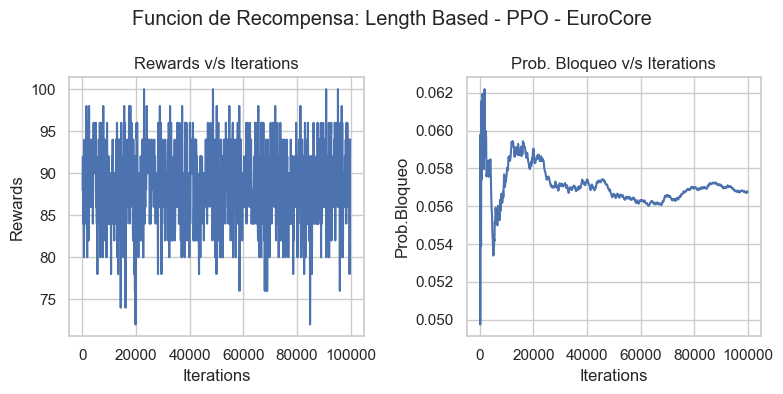

In [22]:
graph_Rewards_Bloqueo(x, rewardsArrayLB_PPO_Euro, probBloqueoArrayLB_PPO_Euro, "Length Based", "PPO", "EuroCore")


## Agente PPO - Topologia NSFNet:

### 1) Funcion de Recompensa Caso Base: (DONE)

#### 1.1) Data:

In [23]:
episodeRewardsArrayCB_PPO_NSFNet=[87, 96, 94, 88, 90, 90, 90, 98, 92, 88, 90, 82, 80, 88, 92, 86, 92, 92, 90, 86, 92, 88, 92, 82, 88, 84, 90, 90, 84, 90, 96, 90, 96, 94, 90, 82, 100, 98, 96, 84, 98, 90, 92, 86, 90, 94, 92, 88, 90, 92, 90, 96, 86, 92, 92, 82, 92, 88, 82, 78, 90, 84, 90, 90, 84, 92, 84, 96, 94, 96, 96, 88, 92, 88, 82, 90, 92, 88, 90, 80, 88, 88, 86, 92, 86, 82, 90, 90, 90, 90, 86, 90, 88, 82, 78, 78, 86, 80, 90, 86, 94, 90, 96, 94, 92, 84, 82, 98, 90, 80, 98, 88, 90, 90, 96, 88, 92, 86, 88, 88, 80, 92, 92, 80, 98, 88, 90, 92, 86, 92, 86, 88, 94, 84, 92, 90, 84, 90, 88, 90, 94, 88, 88, 78, 82, 68, 92, 88, 92, 88, 94, 90, 88, 86, 90, 88, 86, 94, 88, 94, 88, 94, 92, 86, 88, 96, 88, 94, 86, 92, 78, 88, 90, 90, 88, 88, 88, 90, 86, 92, 90, 84, 82, 94, 80, 96, 88, 90, 84, 90, 96, 86, 90, 92, 94, 82, 90, 86, 82, 86, 90, 90, 94, 88, 92, 84, 92, 98, 96, 94, 92, 86, 86, 88, 84, 82, 92, 96, 90, 84, 86, 88, 88, 92, 88, 90, 94, 84, 86, 94, 100, 92, 92, 96, 90, 90, 98, 84, 94, 94, 90, 86, 92, 90, 90, 94, 88, 100, 86, 90, 94, 86, 92, 86, 90, 94, 88, 96, 90, 96, 92, 90, 86, 88, 88, 90, 86, 90, 94, 96, 90, 94, 86, 92, 90, 94, 94, 82, 90, 94, 88, 84, 92, 90, 94, 96, 88, 88, 84, 90, 86, 86, 86, 90, 84, 92, 86, 90, 88, 96, 92, 84, 84, 86, 88, 82, 88, 90, 72, 94, 86, 78, 86, 90, 90, 96, 80, 84, 88, 86, 86, 82, 90, 94, 80, 90, 94, 88, 86, 88, 92, 96, 92, 100, 82, 88, 90, 92, 96, 90, 90, 82, 92, 92, 86, 88, 90, 86, 78, 88, 92, 92, 92, 96, 90, 90, 88, 86, 88, 78, 92, 82, 84, 88, 86, 90, 90, 84, 92, 82, 86, 96, 90, 90, 96, 84, 90, 90, 90, 94, 84, 90, 94, 86, 86, 90, 86, 86, 88, 84, 84, 86, 88, 94, 82, 94, 94, 92, 92, 92, 86, 84, 94, 88, 90, 80, 90, 88, 88, 80, 86, 86, 90, 88, 96, 76, 90, 84, 88, 90, 84, 86, 92, 92, 92, 94, 88, 92, 84, 90, 88, 92, 100, 94, 94, 90, 90, 86, 90, 84, 94, 98, 84, 94, 90, 90, 96, 94, 90, 82, 92, 90, 96, 88, 88, 96, 86, 90, 76, 92, 90, 86, 90, 96, 84, 94, 90, 82, 92, 86, 86, 88, 88, 96, 88, 82, 84, 78, 84, 96, 82, 96, 90, 88, 88, 86, 86, 98, 80, 90, 92, 92, 84, 88, 90, 92, 92, 88, 82, 90, 86, 88, 90, 92, 94, 82, 80, 90, 86, 90, 90, 86, 86, 92, 92, 88, 88, 86, 88, 84, 88, 88, 94, 86, 90, 94, 88, 84, 82, 90, 94, 92, 76, 90, 84, 94, 74, 90, 94, 88, 96, 88, 84, 92, 94, 88, 94, 86, 92, 84, 86, 86, 94, 90, 90, 82, 86, 86, 94, 94, 86, 92, 96, 80, 86, 100, 96, 90, 90, 88, 94, 90, 90, 92, 86, 86, 84, 96, 90, 86, 92, 98, 94, 92, 94, 82, 90, 88, 92, 92, 92, 88, 96, 88, 96, 92, 86, 86, 98, 90, 86, 78, 88, 94, 90, 86, 90, 84, 82, 88, 88, 98, 90, 86, 84, 82, 90, 86, 88, 86, 94, 90, 94, 94, 90, 86, 80, 84, 86, 88, 94, 94, 80, 86, 96, 98, 78, 84, 96, 90, 88, 92, 94, 88, 90, 90, 90, 94, 96, 88, 88, 88, 88, 84, 96, 86, 92, 100, 90, 88, 92, 88, 90, 88, 80, 88, 90, 88, 90, 88, 80, 92, 90, 90, 84, 92, 86, 94, 96, 90, 94, 88, 90, 90, 90, 96, 90, 92, 96, 88, 92, 88, 84, 90, 86, 90, 92, 84, 90, 92, 82, 86, 88, 90, 90, 92, 90, 86, 96, 84, 88, 88, 88, 92, 88, 92, 94, 86, 88, 88, 88, 96, 96, 88, 88, 88, 88, 90, 90, 88, 90, 88, 84, 80, 86, 92, 90, 88, 94, 94, 94, 90, 90, 94, 86, 92, 92, 80, 90, 82, 84, 92, 88, 90, 88, 88, 90, 86, 90, 92, 84, 86, 84, 92, 94, 88, 86, 86, 86, 88, 86, 82, 86, 90, 90, 84, 92, 90, 84, 84, 80, 84, 88, 90, 84, 90, 86, 94, 90, 94, 96, 88, 88, 94, 94, 90, 86, 90, 92, 90, 90, 84, 92, 92, 90, 92, 88, 86, 92, 98, 88, 96, 92, 86, 84, 76, 86, 92, 82, 86, 86, 90, 86, 90, 94, 82, 90, 94, 86, 86, 86, 90, 86, 86, 82, 90, 86, 90, 88, 88, 88, 82, 94, 92, 94, 86, 86, 86, 84, 92, 94, 92, 92, 94, 84, 94, 94, 86, 84, 86, 90, 84, 84, 88, 82, 92, 94, 88, 86, 94, 94, 94, 94, 96, 88, 94, 84, 92, 92, 90, 82, 86, 92, 88, 88, 94, 90, 90, 92, 96, 88, 92, 86, 78, 94, 92, 82, 84, 92, 84, 92, 94, 94, 90, 86, 94, 84, 92, 78, 92, 86, 90, 84, 92, 82, 82, 78, 92, 70, 92, 88, 92, 82, 96, 90, 88, 96, 92, 94, 96, 96, 88, 90, 90, 92, 88, 92, 90, 90, 88, 90, 86, 76, 90, 92, 90, 84, 96, 92, 90, 88, 78, 84, 98, 86, 82, 90, 90, 90, 92, 84, 94, 92, 92, 86, 86, 90, 84, 86, 90, 92, 88, 92, 96, 92, 86, 96, 92, 80, 86, 86, 88, 80, 84, 90, 88, 86, 94, 92, 92, 92, 88, 90, 98, 88, 88, 86, 88, 90, 90, 88, 96, 90, 92, 82, 88, 86, 92, 86, 90, 90, 92, 86, 80, 86, 86, 92, 92, 88, 86, 90, 86, 82, 88, 84, 86, 90, 76, 80, 76, 78, 84, 88, 90, 84, 90, 82, 76, 86, 94, 82, 88, 84, 80, 84, 84, 82, 80, 74, 80, 90, 86, 92, 92, 84, 80, 86, 86, 82, 80, 86, 86, 92, 78, 86, 68, 88, 74, 90, 80, 82, 84, 86, 86, 88, 94, 82, 78, 82, 88, 86, 80, 92, 88, 84, 90, 80, 68, 82, 86, 86, 76, 78, 72, 76, 86, 92, 90, 90, 82, 88, 80, 96, 84, 88, 90, 82, 80, 82, 78, 80, 94, 82, 82, 90, 80, 80, 88, 88, 90, 82, 84, 78, 86, 84, 82, 78, 90, 90, 84, 84, 80, 80, 82, 90, 80, 84, 82, 82, 84, 82, 84, 80, 78, 78, 80, 84, 80, 82, 84, 84, 78, 90, 88, 90, 80, 82, 82, 82, 78, 86, 74, 80, 78, 88, 80, 80, 86, 92, 88, 86, 86, 84, 84, 84, 84, 88, 96, 78, 82, 78, 88, 90, 86, 76, 80, 94, 94, 90, 94, 86, 84, 86, 78, 88, 82, 78, 84, 80, 82, 84, 82, 80, 94, 86, 84, 86, 84, 86, 76, 90, 80, 80, 68, 84, 96, 82, 78, 76, 84, 90, 74, 88, 82, 84, 86, 82, 86, 90, 80, 78, 78, 86, 72, 76, 90, 82, 86, 84, 80, 84, 90, 80, 82, 88, 78, 82, 86, 90, 78, 88, 82, 96, 82, 86, 88, 84, 88, 80, 84, 82, 80, 76, 84, 88, 74, 86, 80, 78, 82, 86, 88, 80, 76, 90, 84, 80, 82, 86, 90, 86, 78, 96, 86, 82, 88, 84, 90, 92, 76, 86, 84, 82, 86, 88, 82, 88, 86, 86, 96, 90, 86, 82, 90, 86, 90, 82, 84, 76, 88, 88, 84, 86, 78, 80, 78, 86, 82, 88, 84, 94, 82, 78, 92, 76, 72, 82, 84, 84, 70, 86, 94, 84, 92, 80, 76, 88, 88, 94, 70, 80, 90, 92, 88, 94, 86, 88, 74, 84, 82, 86, 74, 82, 90, 82, 80, 82, 88, 82, 82, 88, 92, 86, 86, 76, 82, 94, 80, 90, 90, 86, 80, 88, 78, 90, 86, 82, 84, 84, 88, 80, 74, 86, 74, 84, 80, 74, 84, 84, 84, 90, 80, 86, 78, 90, 82, 82, 84, 90, 90, 86, 80, 86, 88, 80, 92, 86, 90, 78, 90, 78, 84, 84, 92, 84, 94, 82, 84, 84, 86, 80, 78, 84, 86, 80, 84, 86, 82, 72, 76, 92, 84, 82, 78, 88, 84, 86, 84, 80, 86, 86, 88, 78, 92, 88, 82, 94, 86, 84, 80, 78, 84, 84, 92, 84, 70, 76, 72, 84, 80, 96, 82, 78, 78, 88, 88, 88, 88, 76, 84, 84, 82, 76, 82, 82, 78, 86, 92, 88, 92, 82, 80, 94, 92, 94, 82, 94, 88, 86, 92, 88, 92, 88, 86, 84, 86, 82, 78, 84, 88, 88, 84, 86, 80, 86, 88, 72, 82, 82, 86, 80, 82, 76, 80, 82, 86, 80, 78, 94, 80, 88, 98, 72, 84, 80, 84, 82, 86, 90, 70, 86, 88, 80, 88, 86, 96, 80, 84, 82, 82, 86, 90, 90, 80, 84, 90, 78, 88, 88, 84, 86, 92, 90, 78, 88, 90, 82, 72, 80, 86, 88, 92, 84, 80, 84, 88, 78, 80, 82, 96, 74, 90, 90, 94, 82, 84, 86, 84, 86, 94, 82, 84, 82, 82, 74, 92, 74, 88, 90, 78, 86, 90, 70, 92, 88, 88, 78, 84, 84, 80, 80, 78, 86, 88, 78, 82, 84, 82, 92, 84, 82, 90, 90, 84, 92, 86, 76, 74, 86, 80, 84, 84, 80, 90, 80, 82, 84, 84, 78, 84, 78, 78, 86, 86, 84, 84, 84, 82, 78, 88, 82, 90, 92, 92, 84, 92, 84, 84, 70, 78, 86, 90, 74, 88, 76, 90, 84, 72, 74, 86, 88, 86, 80, 72, 90, 76, 82, 82, 84, 78, 76, 76, 78, 90, 82, 82, 74, 84, 90, 94, 80, 80, 86, 76, 90, 84, 90, 90, 78, 80, 84, 86, 72, 78, 74, 84, 82, 72, 84, 84, 88, 76, 80, 92, 86, 80, 90, 80, 80, 88, 90, 90, 90, 74, 86, 74, 88, 82, 84, 86, 86, 86, 88, 84, 82, 82, 86, 84, 90, 84, 86, 80, 84, 84, 78, 78, 88, 68, 84, 88, 88, 94, 86, 80, 84, 92, 86, 78, 88, 76, 80, 88, 84, 80, 88, 78, 86, 82, 86, 84, 86, 90, 82, 86, 84, 80, 84, 88, 78, 80, 82, 84, 86, 86, 82, 86, 84, 92, 86, 80, 82, 90, 78, 84, 90, 84, 86, 84, 78, 90, 82, 86, 92, 100, 82, 86, 90, 84, 92, 80, 78, 82, 88, 86, 88, 80, 82, 82, 86, 86, 94, 84, 82, 90, 90, 82, 88, 86, 90, 90, 80, 84, 80, 88, 82, 86, 88, 88, 86, 94, 88, 82, 84, 80, 80, 88, 86, 72, 82, 94, 90, 80, 78, 88, 84, 92, 80, 86, 82, 88, 92, 90, 88, 92, 86, 86, 90, 78, 92, 92, 80, 86, 94, 90, 92, 88, 78, 88, 92, 78, 86, 78, 86, 88, 88, 90, 78, 82, 88, 78, 84, 88, 88, 90, 92, 86, 90, 84, 88, 88, 80, 78, 86, 94, 88, 86, 78, 90, 90, 84, 86, 82, 94, 82, 82, 82, 82, 84, 88, 82, 80, 74, 86, 84, 74, 80, 84, 82, 88, 76, 86, 84, 92, 86, 78, 72, 82, 84, 78, 82, 90, 82, 88, 90, 88, 84, 88, 88, 84, 82, 86, 82, 78, 88, 82, 86, 86, 88, 76, 84, 82, 90, 76, 80, 82, 90, 80, 90, 82, 86, 90, 84, 82, 84, 80, 86, 84, 78, 86, 84, 94, 88, 92, 84, 82, 90, 86, 78, 88, 88, 80, 88, 82, 78, 88, 76, 72, 86, 86, 90, 86, 86, 78, 84, 84, 90, 82, 92, 94, 96, 92, 88, 88, 88, 92, 90, 92, 84, 80, 82, 82, 86, 86, 94, 84, 88, 84, 80, 82, 92, 78, 82, 74, 82, 80, 70, 80, 88, 86, 68, 88, 90, 88, 86, 74, 82, 94, 84, 86, 88]
rewardsArrayCB_PPO_NSFNet=[0, 88, 84, 82, 82, 86, 82, 80, 72, 82, 88, 86, 94, 90, 84, 80, 86, 86, 84, 78, 86, 86, 94, 76, 86, 68, 88, 76, 88, 80, 82, 86, 84, 88, 86, 94, 84, 76, 82, 88, 86, 80, 92, 88, 84, 90, 82, 66, 82, 86, 86, 76, 80, 70, 76, 86, 92, 90, 90, 82, 88, 80, 96, 84, 88, 92, 80, 80, 82, 78, 80, 96, 80, 82, 90, 80, 80, 88, 88, 90, 82, 84, 80, 84, 84, 82, 78, 90, 90, 84, 84, 82, 78, 82, 90, 80, 86, 80, 82, 84, 82, 84, 80, 80, 76, 80, 84, 82, 82, 82, 84, 78, 90, 88, 94, 76, 82, 82, 84, 78, 84, 78, 78, 76, 88, 82, 80, 84, 92, 88, 86, 86, 86, 84, 82, 84, 88, 96, 82, 78, 78, 88, 90, 86, 76, 80, 94, 94, 90, 96, 86, 82, 88, 76, 88, 84, 76, 84, 82, 80, 84, 82, 80, 94, 88, 82, 86, 84, 86, 76, 90, 80, 80, 70, 82, 96, 82, 78, 76, 86, 88, 76, 88, 80, 84, 86, 82, 86, 90, 80, 78, 78, 86, 72, 76, 90, 82, 86, 86, 78, 84, 90, 80, 84, 86, 78, 82, 86, 90, 78, 88, 82, 96, 82, 86, 88, 84, 88, 80, 86, 80, 80, 76, 84, 88, 74, 86, 80, 78, 84, 84, 88, 80, 78, 88, 84, 80, 82, 86, 92, 86, 76, 96, 86, 82, 88, 84, 90, 92, 78, 84, 86, 82, 84, 90, 80, 88, 86, 86, 96, 90, 86, 82, 90, 86, 92, 82, 82, 76, 88, 88, 84, 86, 78, 80, 78, 86, 82, 88, 84, 94, 82, 78, 92, 76, 72, 84, 84, 84, 70, 84, 94, 84, 92, 82, 76, 86, 88, 94, 72, 78, 90, 92, 88, 94, 86, 88, 76, 82, 84, 86, 76, 80, 88, 82, 82, 82, 88, 80, 82, 88, 94, 84, 86, 76, 84, 94, 80, 88, 90, 86, 82, 86, 78, 90, 86, 82, 84, 84, 88, 82, 72, 86, 74, 86, 80, 72, 84, 84, 86, 88, 82, 84, 78, 90, 82, 84, 82, 90, 90, 86, 80, 86, 88, 80, 94, 86, 88, 80, 88, 78, 84, 84, 92, 84, 96, 82, 82, 84, 86, 82, 76, 84, 86, 80, 84, 86, 82, 74, 74, 94, 82, 82, 78, 90, 82, 86, 84, 82, 84, 86, 90, 76, 92, 88, 84, 92, 86, 84, 80, 80, 82, 84, 92, 84, 72, 74, 74, 82, 80, 96, 84, 76, 78, 88, 88, 88, 88, 76, 84, 84, 84, 74, 82, 82, 80, 84, 92, 88, 92, 82, 82, 92, 92, 94, 82, 94, 88, 86, 92, 88, 92, 88, 88, 82, 90, 78, 78, 84, 88, 88, 84, 88, 78, 86, 90, 70, 82, 82, 86, 82, 80, 78, 78, 82, 86, 80, 78, 94, 82, 86, 98, 74, 82, 80, 84, 84, 84, 90, 72, 84, 88, 80, 88, 86, 96, 80, 86, 82, 82, 84, 92, 88, 82, 82, 90, 78, 88, 90, 82, 86, 92, 90, 78, 88, 90, 82, 72, 80, 88, 86, 92, 86, 78, 84, 88, 80, 78, 84, 94, 76, 88, 90, 96, 80, 84, 86, 84, 86, 94, 82, 84, 84, 80, 78, 88, 74, 90, 88, 78, 86, 90, 70, 92, 88, 88, 78, 86, 82, 80, 82, 76, 86, 88, 78, 82, 88, 82, 88, 84, 82, 90, 90, 84, 92, 86, 78, 74, 84, 80, 84, 84, 80, 90, 80, 84, 82, 84, 78, 86, 76, 80, 86, 84, 86, 84, 82, 84, 76, 88, 82, 90, 92, 92, 84, 92, 84, 86, 72, 74, 88, 88, 74, 88, 78, 88, 84, 72, 76, 84, 88, 86, 80, 72, 90, 78, 80, 82, 84, 80, 76, 76, 78, 90, 82, 80, 76, 82, 90, 94, 80, 80, 86, 76, 90, 86, 88, 90, 78, 84, 82, 84, 72, 78, 74, 88, 78, 72, 84, 84, 90, 76, 78, 92, 86, 80, 90, 80, 80, 88, 92, 88, 90, 76, 84, 74, 88, 84, 82, 86, 86, 86, 88, 84, 84, 80, 86, 86, 88, 86, 84, 84, 80, 84, 78, 78, 88, 68, 84, 90, 86, 94, 88, 80, 82, 92, 88, 78, 86, 76, 80, 88, 84, 80, 88, 78, 86, 82, 86, 86, 84, 90, 82, 86, 84, 80, 86, 86, 80, 80, 80, 84, 86, 86, 82, 88, 82, 92, 86, 80, 82, 90, 78, 84, 90, 84, 86, 84, 78, 92, 82, 84, 92, 100, 82, 86, 90, 84, 92, 80, 78, 82, 88, 86, 90, 78, 82, 82, 86, 86, 94, 84, 82, 90, 90, 82, 88, 86, 92, 88, 80, 84, 80, 88, 82, 88, 86, 88, 86, 94, 88, 82, 84, 80, 80, 88, 86, 72, 84, 92, 90, 82, 78, 86, 84, 92, 80, 86, 84, 88, 92, 88, 90, 90, 88, 84, 90, 78, 92, 92, 80, 86, 94, 90, 92, 88, 80, 86, 94, 76, 86, 80, 84, 88, 88, 90, 80, 80, 88, 78, 86, 88, 86, 90, 94, 84, 90, 84, 88, 88, 80, 80, 84, 94, 88, 86, 80, 88, 90, 84, 86, 82, 94, 82, 84, 82, 80, 84, 88, 82, 80, 76, 84, 88, 70, 80, 84, 82, 88, 76, 86, 84, 92, 86, 78, 72, 82, 84, 78, 82, 90, 82, 88, 90, 90, 82, 88, 90, 82, 82, 86, 84, 78, 86, 82, 86, 86, 88, 76, 84, 82, 90, 76, 80, 82, 90, 82, 90, 80, 86, 90, 86, 80, 84, 82, 84, 84, 78, 86, 84, 94, 90, 90, 84, 82, 90, 88, 76, 88, 88, 80, 88, 82, 78, 90, 76, 70, 88, 84, 90, 88, 84, 78, 86, 84, 88, 82, 92, 94, 96, 92, 88, 88, 88, 92, 90, 92, 84, 80, 82, 82, 86, 86, 94, 84, 88, 84, 80, 86, 88, 78, 84, 72, 82, 80, 70, 80, 88, 86, 68, 88, 90, 88, 86, 76, 80, 94, 84, 88, 86]
probBloqueoArrayCB_PPO_NSFNet=[0.0, 0.0594059405940594, 0.06965174129353234, 0.07641196013289037, 0.0798004987531172, 0.07784431137724551, 0.07986688851913477, 0.08273894436519258, 0.0898876404494382, 0.08990011098779134, 0.08691308691308691, 0.08537693006357856, 0.08076602830974189, 0.07840122982321292, 0.07851534618129907, 0.07994670219853431, 0.07932542161149282, 0.078777189888301, 0.07884508606329817, 0.08048395581273014, 0.079960019990005, 0.0794859590671109, 0.07723761926397092, 0.07909604519774012, 0.07871720116618076, 0.08196721311475409, 0.08112264513648597, 0.08256201406886339, 0.0817565155301678, 0.08238538435022406, 0.08263912029323559, 0.08223153821347952, 0.08216182442986567, 0.08149045743714026, 0.08115260217583063, 0.07969151670951156, 0.07970008331019161, 0.08078897595244529, 0.08103130755064457, 0.08049218149192515, 0.0802299425143714, 0.08071202145818093, 0.07974291835277315, 0.0792838874680307, 0.07930015905476029, 0.07864918906909575, 0.0788958921973484, 0.08083386513507765, 0.08102478650281192, 0.08079983676800653, 0.08058388322335533, 0.08135659674573613, 0.0817150547971544, 0.0830032069420864, 0.08368820588779856, 0.08343937465915288, 0.08266381003392251, 0.08209086125241186, 0.08153766591966902, 0.08168107100491442, 0.08131978003666056, 0.08162596295689231, 0.08063215610385421, 0.08062212347246468, 0.08029995313232308, 0.07968004922319644, 0.07998788062414786, 0.08028652439934338, 0.08042934862520218, 0.08085784668888567, 0.0811312669618626, 0.08027038445289396, 0.08054436883766143, 0.08067388029037119, 0.08025942440210783, 0.08052259698706839, 0.08077884488883041, 0.08050902480197376, 0.08024612229201385, 0.07986330844196937, 0.07999000124984378, 0.07999012467596593, 0.08023411779051336, 0.08023129743404409, 0.08022854422092608, 0.08034348900129397, 0.0806882920590629, 0.0803355936099299, 0.07999091012384957, 0.07999101224581508, 0.07999111209865571, 0.08010108779255026, 0.08042604064775567, 0.08052897537899151, 0.08020423359217105, 0.08041258814861593, 0.08030413498593897, 0.08050716420987528, 0.0806040199979594, 0.0805979194020806, 0.0806919308069193, 0.08068508068508068, 0.08087442407607097, 0.08106009125327639, 0.08143447745409095, 0.08161127511665556, 0.0815960758419017, 0.08167460984954678, 0.08175168965836496, 0.08182735528850564, 0.08181074447777474, 0.08206467885776056, 0.08177841264172842, 0.0815857003804973, 0.08113323392684853, 0.0814711764194418, 0.08154469442289458, 0.08161695581574224, 0.08160325396152869, 0.08184186202840098, 0.08182651445712857, 0.08205933393934385, 0.08228833702155561, 0.08259491098284692, 0.08241270865252802, 0.08247340212782978, 0.08261249107213713, 0.0825919218959137, 0.08225919850011718, 0.08208665994884118, 0.08199369279286209, 0.08190214487443706, 0.08181198394061057, 0.08179836102548681, 0.08185956271920006, 0.08184578920079993, 0.08168517020807294, 0.0812349463542807, 0.08129845663357728, 0.08150492770304295, 0.08170844939647168, 0.0815544996808737, 0.08133230054221534, 0.08125305922662751, 0.08152211651968613, 0.08164954141093718, 0.08129580165742073, 0.08094687436228828, 0.08073778798729815, 0.0803301791826052, 0.08026131591227252, 0.08032580623799748, 0.08019209262548517, 0.08045225802235148, 0.08031945977533926, 0.08031739887749177, 0.08057175822062689, 0.0805681166804662, 0.08062780836655908, 0.0807496383875228, 0.08074495344040998, 0.08080243463138935, 0.08092093080674033, 0.08060855162259985, 0.08048289738430583, 0.08054057329858796, 0.08047707969399434, 0.08047422310041315, 0.0804118802452235, 0.08064611561446068, 0.08046585494970884, 0.08058008303607976, 0.08069298296610662, 0.08109357840587249, 0.08114476179529911, 0.08079538312096451, 0.08084767910914152, 0.08101237218236258, 0.08123139149485983, 0.08116864979610078, 0.08105105271929337, 0.08126622838517208, 0.0811493873962969, 0.08125239057974974, 0.08124558447910439, 0.08118480082157721, 0.08123219181764421, 0.08117212983262927, 0.08100632945056115, 0.08110681974498704, 0.08125888111152045, 0.08140935029579603, 0.08134992969116192, 0.08165380032122688, 0.08185145095613629, 0.08168811855802266, 0.08173052395285955, 0.0816709811684686, 0.0816120397959699, 0.08175468569418622, 0.08174591270436478, 0.08158798069747773, 0.0816791247958022, 0.08167085365252943, 0.08161364638988285, 0.08175210965318765, 0.0817921460123295, 0.08173518187527172, 0.08158261622037402, 0.08171857805846611, 0.08161516118280082, 0.08165489787213877, 0.08136408659968869, 0.08140462889066241, 0.0813513387224896, 0.08125203478907958, 0.08124623860006482, 0.08114833417814847, 0.08123480574285583, 0.08118350760239258, 0.08126903322576247, 0.08135378489661102, 0.0815278591054457, 0.0815210080265459, 0.08142493638676845, 0.08164081596373494, 0.08158931020751294, 0.08167041099511035, 0.08179465812902943, 0.08178682153617746, 0.08177905308464849, 0.08168477555084196, 0.0817637170811603, 0.08188489764387795, 0.0817913764369044, 0.0817837538828135, 0.0818609380958434, 0.08189527868022446, 0.0818453006176211, 0.08167022300322162, 0.0816215991000375, 0.08178083896933737, 0.08152555679517376, 0.08147812847207934, 0.08151305274374002, 0.0814252479490633, 0.08141945449371976, 0.08129225537427634, 0.08112576105802186, 0.08124171720011245, 0.08123675052997881, 0.0811919843830923, 0.08122693543906988, 0.08122208608355401, 0.08109916932404236, 0.0811732873220658, 0.08109058239912503, 0.08104743006108711, 0.08100461222433239, 0.08076908227481565, 0.08065074420214607, 0.08060993831653959, 0.08064577687874509, 0.08052925744268279, 0.08048937540244688, 0.08033659107203502, 0.08037291831134168, 0.08040897344668739, 0.08055669564568486, 0.08048027954351139, 0.08040442946557536, 0.08040293716099037, 0.08036469247454138, 0.08047324273836123, 0.08054450567497537, 0.08065161266863023, 0.08061302126734539, 0.08064690805386088, 0.0805726412718967, 0.08057058886778251, 0.080389986071926, 0.08042418419273335, 0.08052905925321797, 0.08038585209003216, 0.08052533361501356, 0.08073400933300585, 0.08073144295653999, 0.08072889446360754, 0.0807263636679282, 0.08096605653783606, 0.08096272542326127, 0.08078760180062541, 0.08078490462655388, 0.08064571175045221, 0.08067752797523894, 0.08081081997220434, 0.08077429816560251, 0.08070435338877478, 0.08053421026140062, 0.08073308584997158, 0.08083063897870071, 0.08072821500946813, 0.08059335783583325, 0.0805253952014785, 0.08035919871056874, 0.08032523523818891, 0.0802588150714029, 0.08038826096869808, 0.08041946690042531, 0.08041810944629624, 0.08038450372568627, 0.08051188064692454, 0.0805743405660075, 0.08050860994856394, 0.08053883634279163, 0.08056887082949747, 0.08059871523053068, 0.08053373710608498, 0.08059494984434452, 0.0806244318359926, 0.08055998250054686, 0.08040247967353042, 0.08040122977547282, 0.08036902882263706, 0.08049134285978828, 0.08048983108212054, 0.08033495905033589, 0.08039509495122474, 0.08033291667936954, 0.0802407221664995, 0.0802096906154359, 0.08023926769584, 0.08020842745700431, 0.08029788895228372, 0.08020717942576569, 0.08017671114295095, 0.08020594625159966, 0.08020533515325955, 0.08020472767077898, 0.08014512846228725, 0.08017411252610217, 0.08034954986657283, 0.080319288909681, 0.08046412641030874, 0.08043370832243249, 0.08049042056751979, 0.08066240860090748, 0.08066049969741507, 0.08065860176431712, 0.08062806223317383, 0.08056912659638296, 0.0805959944161135, 0.08059430129825858, 0.08067760120109913, 0.08059094375865089, 0.080617447395848, 0.08061571304176848, 0.08064199882356236, 0.08055640903885367, 0.08047129606417648, 0.08044220993861281, 0.08049638514168582, 0.08046739040358002, 0.08041100796121319, 0.08046482239498914, 0.08032656639544122, 0.08029835250402995, 0.08024304514863355, 0.08029673106709057, 0.08024172786645348, 0.08032215345531202, 0.08032128514056225, 0.08032042149404586, 0.08021232674727219, 0.08021175904387583, 0.08005119863470307, 0.08007765750910881, 0.08010397602185619, 0.08010370096029205, 0.08007704282208912, 0.08010315518012684, 0.08020786855988032, 0.08020732441559121, 0.08018067413383463, 0.08023228561756204, 0.08023168229396639, 0.08020517603170903, 0.08023048500038758, 0.0803587536403701, 0.08048636281843655, 0.08035691392528396, 0.08038157591877446, 0.08040611208897733, 0.08048141268670009, 0.08040405065861272, 0.08042834358623832, 0.08040201005025126, 0.08040099745598348, 0.08042511494686064, 0.08042404952256836, 0.08039799005024874, 0.08032218647914018, 0.08042088505261064, 0.08032058757847199, 0.08027029033934803, 0.08026962297227229, 0.08017043915174503, 0.0801454509717206, 0.08014509448297835, 0.08019363829735214, 0.08024194531840687, 0.08026568696625386, 0.08026504211062838, 0.08016755042250794, 0.08016714572111784, 0.0803113177995711, 0.08043075887598856, 0.08054962710726361, 0.08057223511399249, 0.08061860098804324, 0.08047427442203757, 0.0804731479062255, 0.08056681121300444, 0.08063639157466726, 0.08058772198768897, 0.08053928142867227, 0.08049106828478204, 0.08044308095829138, 0.08053550150697414, 0.0805342532808093, 0.08053301086021256, 0.08053177420477484, 0.08064628133608018, 0.08066788295882313, 0.08068938503721113, 0.08073377623502909, 0.08073209330061237, 0.08063888698199126, 0.0805917673112486, 0.08049930525500558, 0.08052089725233517, 0.08054239132899481, 0.08045066853691094, 0.08035935983386379, 0.0802459404067476, 0.0802678591492326, 0.08015515347189525, 0.0801100646517975, 0.0800874980469186, 0.0799982183024877, 0.07995377880491544, 0.07986519145916941, 0.07982124289285636, 0.07977748835566544, 0.0798000044051893, 0.07973451132942133, 0.07980088155961491, 0.07986696133563817, 0.07986725180672911, 0.07982396897671075, 0.07978087432881893, 0.07978134964534392, 0.07973853379796975, 0.07980389192458047, 0.07978276330251503, 0.07971871572654352, 0.07986953069676617, 0.07989122288601958, 0.07991282237559026, 0.0798916867444191, 0.079913193336312, 0.07995583957877753, 0.08001949111247643, 0.0800828735121879, 0.08010379527858062, 0.08008252457842993, 0.08012436713514422, 0.08018699817613886, 0.08008200665258049, 0.08010271184317655, 0.08008166496531323, 0.07993596806719196, 0.08003983319848136, 0.08006045423490196, 0.080101650792339, 0.08010144120739779, 0.0801012324849283, 0.08010102461961767, 0.08003934345607672, 0.08016195987812111, 0.08016162935450297, 0.08012056780920959, 0.08016097233796061, 0.0801200787002292, 0.08009959312564523, 0.07997818225894426, 0.0800185480131449, 0.07999839037443915, 0.08001847352462801, 0.08003847618284203, 0.08003839923201536, 0.07995848386259756, 0.07991872671859127, 0.07993876861295005, 0.07995873097755997, 0.07989940793251618, 0.07995889409300211, 0.07991952821443364, 0.07986063266471133, 0.07988055244494215, 0.07986117919256486, 0.07978317449756366, 0.07972500537098885, 0.07978401980468217, 0.07974553024260228, 0.07968777305295043, 0.07970775760159687, 0.07982437477031393, 0.07986332310187062, 0.07982505154043275, 0.07980615757389281, 0.07972975566687779, 0.079711116645275, 0.07976902927286285, 0.07976947004828153, 0.07973181463210224, 0.07977034657135795, 0.0798277072541318, 0.07982803355997045, 0.07973384246044499, 0.07980981490915266, 0.0797725089922977, 0.07971654668145335, 0.07960451023432956, 0.07964270332016254, 0.07964337115194109, 0.07962538012350516, 0.07962607772667175, 0.07960818572145499, 0.07951614997866459, 0.07953556415621933, 0.07953642261695718, 0.07953727791000166, 0.07957496178707574, 0.07963088913806732, 0.0795948698189024, 0.07968718521638798, 0.07963291347507358, 0.07959708764438606, 0.079652465346715, 0.07963491572880493, 0.07958113282880529, 0.079708700929331, 0.07963689625865716, 0.07960145123734229, 0.07956613394353255, 0.0796208701282351, 0.07960359778100931, 0.07962222899231197, 0.07965868231337543, 0.07967714862234603, 0.07974902408156717, 0.07973167737228876, 0.07969663061046874, 0.0797503590361873, 0.07976849967257217, 0.07973357361177365, 0.07975167986455266, 0.07971690639249308, 0.07971740391205778, 0.07973544323783793, 0.07968336806710916, 0.07963147497421373, 0.07963211811312193, 0.07956307381404505, 0.07954644267056225, 0.07959931251193555, 0.07968666054314483, 0.07968720264355288, 0.07972228458921263, 0.07972276340063103, 0.07972324056384572, 0.07975807975807976, 0.07970703761513524, 0.07974178524340336, 0.07974222662860464, 0.07975973106260985, 0.0797601403723957, 0.07981156783047907, 0.07979491010339383, 0.07986305316859037, 0.07989712526014789, 0.07988040742555025, 0.07988060909596803, 0.07986397535395028, 0.07986420396295861, 0.0798812100468113, 0.07988140902162442, 0.07994849584455109, 0.07991519340244738, 0.07993200113331445, 0.07988219829952913, 0.07981594990116443, 0.07974992122850368, 0.07975033525935, 0.07968463331184608, 0.07968515371033481, 0.0796691982010181, 0.07976842486143321, 0.07985090556805308, 0.07981836363338306, 0.07978592821721413, 0.07986797601346383, 0.07983556548832808, 0.07988469243171935, 0.07985236012422563, 0.07985259979545786, 0.07995008184632339, 0.08001488649050986, 0.08001486244164069, 0.0799825809261141, 0.0799665061754239, 0.07999871384704425, 0.08009502255180495, 0.08004679412188907, 0.08009471848450425, 0.08012651555086979, 0.08014226248385194, 0.08014203595484148, 0.0801736061429866, 0.08023682163775178, 0.08029983676962331, 0.08034682995522223, 0.08029888943302634, 0.08031419062790808, 0.08034519141430843, 0.08040754076193771, 0.08042259933125069, 0.08037491575367157, 0.08029608300339587, 0.08032686989265793, 0.08035756072448168, 0.08034142770361832, 0.08040310415079081, 0.08035589509479667, 0.08033983969240786, 0.08030835435983963, 0.08026151064125747, 0.08030740266353914, 0.08030692901496125, 0.08032184120244304, 0.08032134683030982, 0.08041287710311192, 0.08045818593895959, 0.08053393678995734, 0.08050258774675195, 0.0805475526287709, 0.08063804203893396, 0.08063707238491816, 0.08063610567366201, 0.08058968803502978, 0.08064930939017564, 0.08069364511110104, 0.08063226798992473, 0.08061625577928043, 0.08064540382851386, 0.08059939039954354, 0.08062847633468763, 0.08065747518749719, 0.08062659750975322, 0.08056596170206415, 0.08053531243945694, 0.0804898736625943, 0.08054858025883717, 0.08054776635361494, 0.08062102783662464, 0.0805905238088194, 0.080589651556107, 0.08060353092137285, 0.08058791475825099, 0.08057234452434522, 0.08055682001732721, 0.08052667849445022, 0.08052590738056543, 0.08052513852136664, 0.0805535685610429, 0.08053818457456888, 0.0805228453734298, 0.08049301608988241, 0.08047778696971017, 0.08047709453486182, 0.08047640410413742, 0.08050461698530369, 0.08050388883277297, 0.08054638982147232, 0.08058876850692796, 0.08055918736799758, 0.08067316107372921, 0.0806721966734001, 0.0806283171914565, 0.08061313409808431, 0.0805409337955236, 0.08051167362288286, 0.0805393948876972, 0.08055283305634864, 0.0804953121232323, 0.08046628234727553, 0.08050805504872632, 0.08049321337269248, 0.08054893442969775, 0.08057632991084633, 0.08054739033206285, 0.08054662153621438, 0.08057390499431985, 0.0805450904048963, 0.08058628550649641, 0.08057150039803913, 0.08058465014434946, 0.08056990849709614, 0.0805552078552454, 0.08055443674393412, 0.08051205947212937, 0.08052520048198779, 0.0805106430063208, 0.08050993770804271, 0.08053682018179059, 0.08052230685527748, 0.08050783345483556, 0.08053460804109834, 0.08056130917271367, 0.08058793715154587, 0.08058713287095935, 0.08057266977227087, 0.08055824613579624, 0.08057110938543072, 0.08054312186228758, 0.08055597070691975, 0.08050094299941656, 0.08048671427216433, 0.08051311890231526, 0.08052593883866434, 0.0804847437956303, 0.08052452123286748, 0.0805238152918534, 0.08048278920982245, 0.08048214117931303, 0.08046809024007721, 0.08046746362163826, 0.08050694509431693, 0.08045286444773768, 0.08046559379208278, 0.08046497383523522, 0.08041116474514967, 0.08030437842790933, 0.0803172371719208, 0.08030357213811738, 0.0802634885781934, 0.08026314051333536, 0.0802100236144642, 0.08023609702111961, 0.08027525953605874, 0.08028803826493738, 0.08026141389220613, 0.08024796529534345, 0.08020837423593932, 0.08024731702853558, 0.08026004882442787, 0.08027274742180676, 0.08025937162276534, 0.0802460306107853, 0.08018077687302762, 0.08018054240541628, 0.08019326174531417, 0.08015420240359115, 0.08011524398909575, 0.0801279983484084, 0.08010206054045696, 0.0800890593428656, 0.08003753165126412, 0.08001180986123413, 0.08003743541749465, 0.08003738748543553, 0.08006291479648597, 0.08003729198860807, 0.08004999936225303, 0.08002445828715558, 0.08001170468569102, 0.07998627717563944, 0.0799736043958833, 0.07991026729699244, 0.07988506474601588, 0.0798978521131212, 0.0798979810860974, 0.07992333009672009, 0.0799486152567348, 0.07992352297455378, 0.07991105639376389, 0.07998644935446231, 0.07998646633500833, 0.07993642132138522, 0.07989900126248421, 0.07991161159036717, 0.07994912781636139, 0.07993673802318775, 0.07993681670625988, 0.0798872063701072, 0.07991215989876056, 0.07989987732494021, 0.07990000123760845, 0.07987540327066414, 0.079826174985494, 0.07980172870864724, 0.07976502752429157, 0.07972841662464177, 0.07970418053832262, 0.07970454350253371, 0.07966814132179753, 0.07970526676540067, 0.0796567279128617, 0.07960830759087191, 0.07963317520518043, 0.07962144188255929, 0.07956107589931996, 0.07952515765300543, 0.07947719081079113, 0.07945358238081962, 0.07947845667727993, 0.07946699556232693, 0.07940725353558532, 0.07945621886346364, 0.07944482596595222, 0.07946956113644842, 0.07947019867549669, 0.07944682536824288, 0.07942350811141353, 0.0793882707991521, 0.07941292568270715, 0.07943752165446052, 0.07941432679800957, 0.07945078127793472, 0.07943953048177999, 0.07941641597602882, 0.0794052327169511, 0.07937035147863014, 0.0793118564945913, 0.0793126708559662, 0.07927802271840759, 0.07927887510182878, 0.07925614084739567, 0.07923346014770144, 0.0792578910836343, 0.07928226460323616, 0.07928310700578632, 0.07922533147325354, 0.0792028196391143, 0.07919205623326044, 0.07921636429480965, 0.07919394172763446, 0.07915991655108914, 0.07916089451810805, 0.07915024243904141, 0.07916284363712384, 0.07910581083746128, 0.07911843431709946, 0.07911945463594171, 0.07913203315568607, 0.07915612983683791, 0.07915710314759922, 0.07913503300653218, 0.07914753570154544, 0.07917150377581866, 0.07921837866385001, 0.07921927500831412, 0.07919726005429491, 0.07927826912735553, 0.0793019508348476, 0.07930274768552871, 0.07931494509754734, 0.07929294654958371, 0.07933925666374672, 0.0793286439926819, 0.07932940602263311, 0.07928481536490516, 0.07927430040429893, 0.07930905758984627, 0.07937763415102654, 0.079389623141951, 0.0793903112704479, 0.07942478125246337, 0.07943667675279244, 0.07940360220671677, 0.07941549477559175, 0.07939372876985684, 0.079360813428741, 0.07932797172291138, 0.07933989564362409, 0.07931831117956273, 0.07928562669312493, 0.0792975579336533, 0.07930946263111645, 0.0792991188986789, 0.07929989678249964, 0.07933393199631933, 0.07932359553050354, 0.07933540558179666, 0.07932509033049359, 0.07931479784991335, 0.07929350282797323, 0.07933833327826786, 0.07933906117644471, 0.07935077636509488, 0.07931855852295804, 0.0793631648775781, 0.0793857679543488, 0.07939738077263925, 0.07936525283876679, 0.07937686269800548, 0.07934482721017219, 0.07936732715329899, 0.0793571343075701, 0.0793252247258182, 0.0793150997274731, 0.07933753430006182, 0.07933825202327169, 0.07934979058668196, 0.07935049350817829, 0.07935119491150204, 0.07938425691200743, 0.07937414467516514, 0.0793748183550231, 0.07932172772335781, 0.07929023318761345, 0.0792588062359846, 0.07925960064736712, 0.07927109988115759, 0.07923979422679972, 0.07921923911069326, 0.07926276133659192, 0.07924222556262726, 0.07922173352786445, 0.07924383783151243, 0.07922338763668824, 0.07923482765575737, 0.07926745209488764, 0.07923644876643256, 0.07927958434302282, 0.0793543408632044, 0.07933390354906496, 0.07933460617504035, 0.0793036954299744, 0.07928337596446353, 0.07928412950442161, 0.07931639373535992, 0.07930661797882499, 0.07930734478674228, 0.07928712788347766, 0.07929833369943828, 0.07925727003897556, 0.07920585380110855, 0.07914411737103888, 0.07910334267351382, 0.07908346427196387, 0.07906362719722249, 0.07904383132054703, 0.07900332984097676, 0.07897327488834313, 0.07893293030092856, 0.07893403377421122, 0.07895579591119926, 0.07896719332101836, 0.07897856723126566, 0.07896932060431922, 0.0789600930031584, 0.07890977482245815, 0.07891089413866387, 0.07889149854873283, 0.07889263429677974, 0.07891423833942335, 0.07890512366949214, 0.07888581321947682, 0.07891756206569321, 0.07891866545702898, 0.0789808657752976, 0.07899207536037273, 0.0790134246603185, 0.07908549151785262, 0.07910670277177716, 0.07908734460643763, 0.07907814698231799, 0.07915996804885694, 0.07914061474126524, 0.0791112097758852, 0.07909194463765486, 0.07908278869296381, 0.0791239524753272, 0.07914493321675159, 0.0790955914097248, 0.07909649853060652, 0.079077363954269, 0.07906827759481887]

#### 1.2) Rewards & Prob. Bloqueo (CB):

Rewards Stats w/  Caso Base  :
Avg =  84.102
Std =  5.964695801128503
Min-Max Reward = 66 - 100
Last Prob Bloqueo = 0.07906827759481887


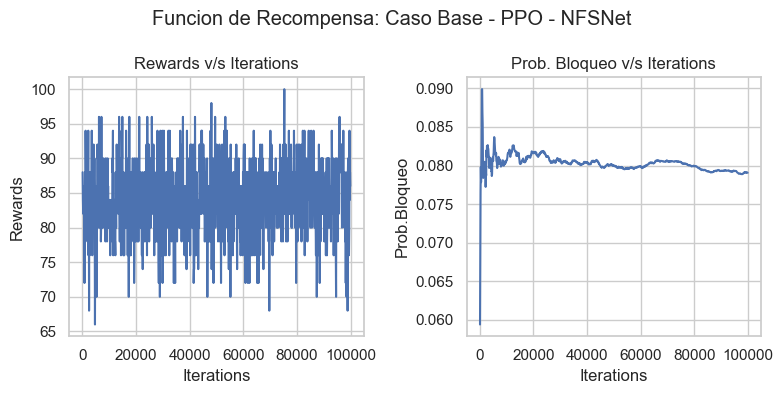

In [24]:
graph_Rewards_Bloqueo(x, rewardsArrayCB_PPO_NSFNet, probBloqueoArrayCB_PPO_NSFNet, "Caso Base", "PPO", "NFSNet")

### 2) Funcion de Recompensa Band Select: (DONE)

#### 2.1) Data:

In [25]:
episodeRewardsArrayBS_PPO_NSFNet=[87, 96, 94, 88, 90, 90, 90, 98, 92, 88, 90, 82, 80, 88, 92, 86, 92, 92, 90, 86, 92, 88, 92, 82, 88, 84, 90, 90, 84, 90, 96, 90, 96, 94, 90, 82, 100, 98, 96, 84, 98, 90, 92, 86, 90, 94, 92, 88, 90, 92, 90, 96, 86, 92, 92, 82, 92, 88, 82, 78, 90, 84, 90, 90, 84, 92, 84, 96, 94, 96, 96, 88, 92, 88, 82, 90, 92, 88, 90, 80, 88, 88, 86, 92, 86, 82, 90, 90, 90, 90, 86, 90, 88, 82, 78, 78, 86, 80, 90, 86, 94, 90, 96, 94, 92, 84, 82, 98, 90, 80, 98, 88, 90, 90, 96, 88, 92, 86, 88, 88, 80, 92, 92, 80, 98, 88, 90, 92, 86, 92, 86, 88, 94, 84, 92, 90, 84, 90, 88, 90, 94, 88, 88, 78, 82, 68, 92, 88, 92, 88, 94, 90, 88, 86, 90, 88, 86, 94, 88, 94, 88, 94, 92, 86, 88, 96, 88, 94, 86, 92, 78, 88, 90, 90, 88, 88, 88, 90, 86, 92, 90, 84, 82, 94, 80, 96, 88, 90, 84, 90, 96, 86, 90, 92, 94, 82, 90, 86, 82, 86, 90, 90, 94, 88, 92, 84, 92, 98, 96, 94, 92, 86, 86, 88, 84, 82, 92, 96, 90, 84, 86, 88, 88, 92, 88, 90, 94, 84, 86, 94, 100, 92, 92, 96, 90, 90, 98, 84, 94, 94, 90, 86, 92, 90, 90, 94, 88, 100, 86, 90, 94, 86, 92, 86, 90, 94, 88, 96, 90, 96, 92, 90, 86, 88, 88, 90, 86, 90, 94, 96, 90, 94, 86, 92, 90, 94, 94, 82, 90, 94, 88, 84, 92, 90, 94, 96, 88, 88, 84, 90, 86, 86, 86, 90, 84, 92, 86, 90, 88, 96, 92, 84, 84, 86, 88, 82, 88, 90, 72, 94, 86, 78, 86, 90, 90, 96, 80, 84, 88, 86, 86, 82, 90, 94, 80, 90, 94, 88, 86, 88, 92, 96, 92, 100, 82, 88, 90, 92, 96, 90, 90, 82, 92, 92, 86, 88, 90, 86, 78, 88, 92, 92, 92, 96, 90, 90, 88, 86, 88, 78, 92, 82, 84, 88, 86, 90, 90, 84, 92, 82, 86, 96, 90, 90, 96, 84, 90, 90, 90, 94, 84, 90, 94, 86, 86, 90, 86, 86, 88, 84, 84, 86, 88, 94, 82, 94, 94, 92, 92, 92, 86, 84, 94, 88, 90, 80, 90, 88, 88, 80, 86, 86, 90, 88, 96, 76, 90, 84, 88, 90, 84, 86, 92, 92, 92, 94, 88, 92, 84, 90, 88, 92, 100, 94, 94, 90, 90, 86, 90, 84, 94, 98, 84, 94, 90, 90, 96, 94, 90, 82, 92, 90, 96, 88, 88, 96, 86, 90, 76, 92, 90, 86, 90, 96, 84, 94, 90, 82, 92, 86, 86, 88, 88, 96, 88, 82, 84, 78, 84, 96, 82, 96, 90, 88, 88, 86, 86, 98, 80, 90, 92, 92, 84, 88, 90, 92, 92, 88, 82, 90, 86, 88, 90, 92, 94, 82, 80, 90, 86, 90, 90, 86, 86, 92, 92, 88, 88, 86, 88, 84, 88, 88, 94, 86, 90, 94, 88, 84, 82, 90, 94, 92, 76, 90, 84, 94, 74, 90, 94, 88, 96, 88, 84, 92, 94, 88, 94, 86, 92, 84, 86, 86, 94, 90, 90, 82, 86, 86, 94, 94, 86, 92, 96, 80, 86, 100, 96, 90, 90, 88, 94, 90, 90, 92, 86, 86, 84, 96, 90, 86, 92, 98, 94, 92, 94, 82, 90, 88, 92, 92, 92, 88, 96, 88, 96, 92, 86, 86, 98, 90, 86, 78, 88, 94, 90, 86, 90, 84, 82, 88, 88, 98, 90, 86, 84, 82, 90, 86, 88, 86, 94, 90, 94, 94, 90, 86, 80, 84, 86, 88, 94, 94, 80, 86, 96, 98, 78, 84, 96, 90, 88, 92, 94, 88, 90, 90, 90, 94, 96, 88, 88, 88, 88, 84, 96, 86, 92, 100, 90, 88, 92, 88, 90, 88, 80, 88, 90, 88, 90, 88, 80, 92, 90, 90, 84, 92, 86, 94, 96, 90, 94, 88, 90, 90, 90, 96, 90, 92, 96, 88, 92, 88, 84, 90, 86, 90, 92, 84, 90, 92, 82, 86, 88, 90, 90, 92, 90, 86, 96, 84, 88, 88, 88, 92, 88, 92, 94, 86, 88, 88, 88, 96, 96, 88, 88, 88, 88, 90, 90, 88, 90, 88, 84, 80, 86, 92, 90, 88, 94, 94, 94, 90, 90, 94, 86, 92, 92, 80, 90, 82, 84, 92, 88, 90, 88, 88, 90, 86, 90, 92, 84, 86, 84, 92, 94, 88, 86, 86, 86, 88, 86, 82, 86, 90, 90, 84, 92, 90, 84, 84, 80, 84, 88, 90, 84, 90, 86, 94, 90, 94, 96, 88, 88, 94, 94, 90, 86, 90, 92, 90, 90, 84, 92, 92, 90, 92, 88, 86, 92, 98, 88, 96, 92, 86, 84, 76, 86, 92, 82, 86, 86, 90, 86, 90, 94, 82, 90, 94, 86, 86, 86, 90, 86, 86, 82, 90, 86, 90, 88, 88, 88, 82, 94, 92, 94, 86, 86, 86, 84, 92, 94, 92, 92, 94, 84, 94, 94, 86, 84, 86, 90, 84, 84, 88, 82, 92, 94, 88, 86, 94, 94, 94, 94, 96, 88, 94, 84, 92, 92, 90, 82, 86, 92, 88, 88, 94, 90, 90, 92, 96, 88, 92, 86, 78, 94, 92, 82, 84, 92, 84, 92, 94, 94, 90, 86, 94, 84, 92, 78, 92, 86, 90, 84, 92, 82, 82, 78, 92, 70, 92, 88, 92, 82, 96, 90, 88, 96, 92, 94, 96, 96, 88, 90, 90, 92, 88, 92, 90, 90, 88, 90, 86, 76, 90, 92, 90, 84, 96, 92, 90, 88, 78, 84, 98, 86, 82, 90, 90, 90, 92, 84, 94, 92, 92, 86, 86, 90, 84, 86, 90, 92, 88, 92, 96, 92, 86, 96, 92, 80, 86, 86, 88, 80, 84, 90, 88, 86, 94, 92, 92, 92, 88, 90, 98, 88, 88, 86, 88, 90, 90, 88, 96, 90, 92, 82, 88, 86, 92, 86, 90, 90, 92, 86, 80, 86, 86, 92, 92, 88, 86, 90, 86, 82, 88, 84, 86, 90, 76, 80, 76, 78, 84, 88, 90, 84, 90, 82, 76, 86, 94, 82, 88, 84, 80, 84, 84, 82, 80, 74, 80, 90, 86, 92, 92, 84, 80, 86, 86, 82, 80, 86, 86, 92, 78, 86, 68, 88, 74, 90, 80, 82, 84, 86, 86, 88, 94, 82, 78, 82, 88, 86, 80, 92, 88, 84, 90, 80, 68, 82, 86, 86, 76, 78, 72, 76, 86, 92, 90, 90, 82, 88, 80, 96, 84, 88, 90, 82, 80, 82, 78, 80, 94, 82, 82, 90, 80, 80, 88, 88, 90, 82, 84, 78, 86, 84, 82, 78, 90, 90, 84, 84, 80, 80, 82, 90, 80, 84, 82, 82, 84, 82, 84, 80, 78, 78, 80, 84, 80, 82, 84, 84, 78, 90, 88, 90, 80, 82, 82, 82, 78, 86, 74, 80, 78, 88, 80, 80, 86, 92, 88, 86, 86, 84, 84, 84, 84, 88, 96, 78, 82, 78, 88, 90, 86, 76, 80, 94, 94, 90, 94, 86, 84, 86, 78, 88, 82, 78, 84, 80, 82, 84, 82, 80, 94, 86, 84, 86, 84, 86, 76, 90, 80, 80, 68, 84, 96, 82, 78, 76, 84, 90, 74, 88, 82, 84, 86, 82, 86, 90, 80, 78, 78, 86, 72, 76, 90, 82, 86, 84, 80, 84, 90, 80, 82, 88, 78, 82, 86, 90, 78, 88, 82, 96, 82, 86, 88, 84, 88, 80, 84, 82, 80, 76, 84, 88, 74, 86, 80, 78, 82, 86, 88, 80, 76, 90, 84, 80, 82, 86, 90, 86, 78, 96, 86, 82, 88, 84, 90, 92, 76, 86, 84, 82, 86, 88, 82, 88, 86, 86, 96, 90, 86, 82, 90, 86, 90, 82, 84, 76, 88, 88, 84, 86, 78, 80, 78, 86, 82, 88, 84, 94, 82, 78, 92, 76, 72, 82, 84, 84, 70, 86, 94, 84, 92, 80, 76, 88, 88, 94, 70, 80, 90, 92, 88, 94, 86, 88, 74, 84, 82, 86, 74, 82, 90, 82, 80, 82, 88, 82, 82, 88, 92, 86, 86, 76, 82, 94, 80, 90, 90, 86, 80, 88, 78, 90, 86, 82, 84, 84, 88, 80, 74, 86, 74, 84, 80, 74, 84, 84, 84, 90, 80, 86, 78, 90, 82, 82, 84, 90, 90, 86, 80, 86, 88, 80, 92, 86, 90, 78, 90, 78, 84, 84, 92, 84, 94, 82, 84, 84, 86, 80, 78, 84, 86, 80, 84, 86, 82, 72, 76, 92, 84, 82, 78, 88, 84, 86, 84, 80, 86, 86, 88, 78, 92, 88, 82, 94, 86, 84, 80, 78, 84, 84, 92, 84, 70, 76, 72, 84, 80, 96, 82, 78, 78, 88, 88, 88, 88, 76, 84, 84, 82, 76, 82, 82, 78, 86, 92, 88, 92, 82, 80, 94, 92, 94, 82, 94, 88, 86, 92, 88, 92, 88, 86, 84, 86, 82, 78, 84, 88, 88, 84, 86, 80, 86, 88, 72, 82, 82, 86, 80, 82, 76, 80, 82, 86, 80, 78, 94, 80, 88, 98, 72, 84, 80, 84, 82, 86, 90, 70, 86, 88, 80, 88, 86, 96, 80, 84, 82, 82, 86, 90, 90, 80, 84, 90, 78, 88, 88, 84, 86, 92, 90, 78, 88, 90, 82, 72, 80, 86, 88, 92, 84, 80, 84, 88, 78, 80, 82, 96, 74, 90, 90, 94, 82, 84, 86, 84, 86, 94, 82, 84, 82, 82, 74, 92, 74, 88, 90, 78, 86, 90, 70, 92, 88, 88, 78, 84, 84, 80, 80, 78, 86, 88, 78, 82, 84, 82, 92, 84, 82, 90, 90, 84, 92, 86, 76, 74, 86, 80, 84, 84, 80, 90, 80, 82, 84, 84, 78, 84, 78, 78, 86, 86, 84, 84, 84, 82, 78, 88, 82, 90, 92, 92, 84, 92, 84, 84, 70, 78, 86, 90, 74, 88, 76, 90, 84, 72, 74, 86, 88, 86, 80, 72, 90, 76, 82, 82, 84, 78, 76, 76, 78, 90, 82, 82, 74, 84, 90, 94, 80, 80, 86, 76, 90, 84, 90, 90, 78, 80, 84, 86, 72, 78, 74, 84, 82, 72, 84, 84, 88, 76, 80, 92, 86, 80, 90, 80, 80, 88, 90, 90, 90, 74, 86, 74, 88, 82, 84, 86, 86, 86, 88, 84, 82, 82, 86, 84, 90, 84, 86, 80, 84, 84, 78, 78, 88, 68, 84, 88, 88, 94, 86, 80, 84, 92, 86, 78, 88, 76, 80, 88, 84, 80, 88, 78, 86, 82, 86, 84, 86, 90, 82, 86, 84, 80, 84, 88, 78, 80, 82, 84, 86, 86, 82, 86, 84, 92, 86, 80, 82, 90, 78, 84, 90, 84, 86, 84, 78, 90, 82, 86, 92, 100, 82, 86, 90, 84, 92, 80, 78, 82, 88, 86, 88, 80, 82, 82, 86, 86, 94, 84, 82, 90, 90, 82, 88, 86, 90, 90, 80, 84, 80, 88, 82, 86, 88, 88, 86, 94, 88, 82, 84, 80, 80, 88, 86, 72, 82, 94, 90, 80, 78, 88, 84, 92, 80, 86, 82, 88, 92, 90, 88, 92, 86, 86, 90, 78, 92, 92, 80, 86, 94, 90, 92, 88, 78, 88, 92, 78, 86, 78, 86, 88, 88, 90, 78, 82, 88, 78, 84, 88, 88, 90, 92, 86, 90, 84, 88, 88, 80, 78, 86, 94, 88, 86, 78, 90, 90, 84, 86, 82, 94, 82, 82, 82, 82, 84, 88, 82, 80, 74, 86, 84, 74, 80, 84, 82, 88, 76, 86, 84, 92, 86, 78, 72, 82, 84, 78, 82, 90, 82, 88, 90, 88, 84, 88, 88, 84, 82, 86, 82, 78, 88, 82, 86, 86, 88, 76, 84, 82, 90, 76, 80, 82, 90, 80, 90, 82, 86, 90, 84, 82, 84, 80, 86, 84, 78, 86, 84, 94, 88, 92, 84, 82, 90, 86, 78, 88, 88, 80, 88, 82, 78, 88, 76, 72, 86, 86, 90, 86, 86, 78, 84, 84, 90, 82, 92, 94, 96, 92, 88, 88, 88, 92, 90, 92, 84, 80, 82, 82, 86, 86, 94, 84, 88, 84, 80, 82, 92, 78, 82, 74, 82, 80, 70, 80, 88, 86, 68, 88, 90, 88, 86, 74, 82, 94, 84, 86, 88, 87.8, 81.99999999999996, 90.39999999999995, 83.39999999999996, 80.19999999999997, 66.19999999999997, 77.59999999999995, 72.39999999999996, 85.19999999999996, 77.19999999999996, 84.79999999999995, 68.99999999999996, 77.59999999999998, 83.59999999999997, 78.79999999999995, 80.39999999999996, 77.99999999999999, 81.59999999999997, 72.59999999999995, 78.39999999999996, 81.79999999999997, 72.99999999999994, 83.79999999999997, 82.59999999999997, 77.59999999999997, 79.79999999999997, 78.19999999999997, 78.79999999999995, 83.39999999999996, 80.19999999999997, 73.39999999999996, 77.79999999999998, 81.79999999999995, 79.59999999999998, 79.39999999999998, 77.99999999999997, 80.79999999999995, 79.39999999999996, 88.19999999999996, 75.59999999999998, 83.19999999999995, 77.39999999999996, 82.39999999999996, 79.39999999999996, 86.19999999999995, 85.19999999999997, 70.99999999999996, 80.59999999999997, 80.39999999999998, 81.99999999999997, 74.39999999999996, 78.99999999999999, 81.59999999999998, 80.59999999999995, 87.59999999999995, 83.39999999999999, 87.39999999999996, 74.99999999999996, 78.19999999999997, 86.39999999999996, 78.99999999999997, 83.59999999999997, 85.79999999999995, 81.79999999999995, 83.99999999999997, 77.39999999999996, 80.39999999999996, 80.39999999999998, 71.79999999999997, 81.79999999999997, 82.39999999999996, 74.19999999999997, 73.59999999999998, 70.39999999999996, 76.99999999999999, 77.79999999999997, 84.79999999999997, 83.99999999999996, 83.59999999999997, 81.19999999999996, 80.19999999999996, 76.59999999999998, 87.39999999999996, 76.19999999999995, 66.39999999999999, 88.99999999999994, 73.39999999999996, 78.19999999999993, 82.39999999999999, 81.39999999999996, 72.99999999999999, 79.19999999999996, 73.99999999999996, 77.39999999999996, 84.59999999999997, 77.79999999999997, 75.99999999999997, 78.19999999999997, 82.19999999999996, 75.99999999999997, 90.39999999999996, 85.59999999999995, 71.19999999999999, 78.39999999999998, 77.79999999999995, 77.39999999999996, 76.99999999999997, 78.59999999999997, 86.59999999999997, 73.39999999999996, 80.99999999999997, 82.39999999999995, 76.79999999999998, 78.39999999999996, 76.59999999999998, 78.39999999999996, 82.39999999999998, 74.39999999999996, 78.59999999999995, 81.79999999999997, 80.79999999999997, 75.59999999999998, 78.19999999999996, 79.59999999999995, 66.99999999999997, 75.39999999999996, 73.99999999999994, 72.79999999999997, 79.19999999999997, 84.99999999999996, 79.19999999999997, 71.59999999999998, 74.99999999999999, 77.59999999999997, 86.79999999999997, 81.79999999999997, 75.39999999999999, 81.39999999999995, 76.99999999999996, 83.59999999999997, 83.39999999999996, 64.19999999999996, 90.79999999999998, 72.59999999999997, 71.59999999999998, 75.59999999999998, 73.99999999999999, 79.99999999999997, 78.99999999999997, 79.79999999999997, 85.19999999999996, 80.59999999999997, 77.19999999999997, 83.39999999999996, 76.39999999999998, 70.99999999999996, 74.79999999999995, 74.39999999999996, 89.59999999999997, 84.99999999999996, 80.99999999999996, 71.59999999999997, 82.19999999999995, 85.99999999999997, 76.59999999999995, 74.59999999999998, 78.99999999999997, 85.99999999999997, 75.99999999999997, 82.99999999999997, 83.79999999999997, 86.39999999999998, 78.39999999999998, 76.39999999999995, 72.59999999999998, 75.19999999999997, 79.59999999999998, 78.39999999999995, 82.59999999999998, 75.99999999999997, 81.19999999999996, 77.79999999999998, 77.59999999999998, 85.59999999999997, 81.6, 85.59999999999997, 77.79999999999995, 80.99999999999997, 76.79999999999995, 75.79999999999998, 84.39999999999998, 79.99999999999997, 76.59999999999998, 70.99999999999996, 75.79999999999997, 76.19999999999997, 76.79999999999997, 82.59999999999997, 81.19999999999997, 78.79999999999995, 86.19999999999997, 78.19999999999997, 70.99999999999997, 77.59999999999997, 79.59999999999997, 82.79999999999997, 84.19999999999997, 86.99999999999997, 67.99999999999997, 87.79999999999994, 80.59999999999998, 84.79999999999995, 83.79999999999997, 86.39999999999996, 74.19999999999997, 68.39999999999998, 78.99999999999994, 78.99999999999996, 87.59999999999997, 71.99999999999997, 68.59999999999997, 75.99999999999997, 71.39999999999998, 73.99999999999996, 78.59999999999997, 81.19999999999997, 88.99999999999997, 68.79999999999997, 80.79999999999998, 75.19999999999996, 76.99999999999999, 81.99999999999997, 73.39999999999996, 83.79999999999997, 76.19999999999997, 72.79999999999997, 77.19999999999995, 82.19999999999996, 87.39999999999998, 81.79999999999997, 88.59999999999997, 78.19999999999997, 76.59999999999998, 72.99999999999996, 88.19999999999997, 80.79999999999995, 72.79999999999997, 86.19999999999997, 79.39999999999996, 73.99999999999996, 80.39999999999995, 86.99999999999997, 82.39999999999995, 83.59999999999997, 88.99999999999999, 75.39999999999996, 88.79999999999995, 76.59999999999997, 82.19999999999996, 85.59999999999997, 89.19999999999996, 82.39999999999999, 80.59999999999997, 78.59999999999997, 71.99999999999997, 77.6, 69.59999999999998, 82.99999999999996, 79.79999999999998, 73.39999999999996, 77.39999999999996, 83.59999999999994, 77.79999999999997, 78.99999999999996, 74.19999999999997, 78.59999999999995, 85.39999999999998, 70.39999999999998, 85.99999999999997, 79.39999999999996, 80.59999999999995, 82.79999999999994, 84.59999999999997, 79.39999999999998, 83.79999999999997, 88.39999999999996, 72.79999999999995, 82.79999999999997, 79.79999999999997, 78.59999999999997, 77.99999999999997, 79.39999999999995, 73.79999999999997, 81.59999999999995, 81.79999999999997, 71.19999999999997, 83.59999999999997, 82.99999999999994, 84.39999999999996, 70.99999999999997, 84.99999999999997, 85.39999999999995, 85.19999999999997, 74.39999999999999, 81.79999999999995, 76.79999999999998, 74.79999999999998, 75.79999999999998, 75.59999999999998, 77.39999999999996, 81.99999999999997, 73.19999999999997, 80.39999999999995, 77.79999999999997, 80.79999999999997, 86.59999999999997, 84.79999999999997, 80.39999999999995, 80.39999999999996, 80.39999999999998, 58.19999999999999, 74.59999999999998, 83.99999999999997, 81.59999999999998, 81.79999999999997, 79.19999999999996, 74.39999999999999, 76.99999999999999, 70.99999999999997, 81.2, 80.59999999999995, 85.59999999999998, 77.19999999999997, 86.79999999999997, 70.19999999999996, 82.39999999999996, 80.99999999999996, 84.59999999999994, 87.39999999999996, 71.59999999999997, 76.79999999999997, 87.59999999999995, 88.39999999999993, 82.19999999999996, 75.99999999999997, 74.99999999999996, 86.19999999999996, 78.39999999999998, 68.99999999999997, 90.79999999999997, 77.59999999999998, 84.79999999999995, 77.59999999999995, 70.79999999999998, 85.99999999999997, 81.39999999999996, 80.19999999999997, 89.99999999999997, 76.39999999999998, 74.19999999999997, 69.39999999999998, 83.79999999999997, 71.19999999999997, 83.39999999999996, 79.39999999999998, 78.99999999999999, 70.59999999999998, 71.19999999999997, 74.59999999999997, 82.79999999999997, 81.19999999999996, 85.99999999999997, 64.79999999999995, 76.79999999999997, 86.39999999999998, 84.79999999999997, 80.39999999999995, 85.19999999999997, 80.39999999999998, 82.39999999999998, 81.59999999999997, 80.39999999999998, 85.39999999999998, 86.19999999999996, 74.59999999999995, 77.59999999999995, 74.79999999999994, 81.39999999999996, 84.19999999999997, 75.99999999999996, 74.99999999999997, 87.39999999999996, 72.39999999999998, 83.59999999999997, 75.59999999999998, 83.39999999999996, 80.39999999999998, 76.19999999999996, 75.39999999999996, 82.59999999999998, 71.99999999999999, 76.19999999999996, 88.99999999999996, 73.19999999999997, 87.39999999999998, 79.99999999999997, 73.39999999999995, 81.59999999999997, 77.39999999999998, 75.19999999999996, 81.59999999999998, 72.59999999999997, 79.79999999999995, 66.79999999999997, 82.79999999999995, 78.59999999999997, 86.19999999999996, 74.79999999999995, 77.19999999999996, 75.79999999999997, 75.39999999999996, 74.99999999999999, 78.79999999999995, 70.19999999999997, 84.99999999999996, 83.59999999999998, 78.39999999999995, 88.79999999999997, 77.39999999999996, 78.39999999999999, 77.80000000000001, 73.39999999999996, 86.79999999999997, 82.59999999999997, 68.99999999999999, 73.79999999999997, 77.79999999999997, 74.99999999999996, 74.39999999999998, 75.19999999999997, 85.99999999999996, 79.99999999999997, 84.39999999999998, 80.99999999999999, 85.79999999999995, 81.19999999999997, 80.99999999999996, 80.19999999999996, 78.8, 84.79999999999995, 79.39999999999998, 84.39999999999999, 82.19999999999997, 69.59999999999997, 79.19999999999996, 86.99999999999996, 69.59999999999998, 83.79999999999998, 86.59999999999997, 75.59999999999998, 80.99999999999996, 71.19999999999997, 83.39999999999996, 82.99999999999997, 73.19999999999997, 90.99999999999999, 80.99999999999996, 79.19999999999996, 76.59999999999998, 80.19999999999999, 76.99999999999996, 78.19999999999996, 80.59999999999997, 81.19999999999997, 83.19999999999996, 83.79999999999995, 75.59999999999995, 79.19999999999997, 81.39999999999996, 81.59999999999995, 78.79999999999997, 77.99999999999997, 86.99999999999997, 77.79999999999998, 81.19999999999995, 77.39999999999996, 78.79999999999995, 67.8, 83.79999999999997, 72.79999999999998, 69.59999999999998, 69.79999999999995, 89.39999999999995, 79.59999999999994, 79.39999999999999, 73.59999999999998, 77.19999999999996, 79.19999999999997, 82.19999999999996, 77.39999999999996, 82.19999999999996, 79.59999999999997, 81.79999999999997, 77.99999999999997, 77.39999999999998, 88.79999999999997, 79.39999999999998, 72.99999999999997, 78.79999999999997, 76.99999999999996, 69.19999999999997, 87.19999999999996, 74.99999999999997, 74.19999999999996, 75.99999999999997, 79.39999999999996, 70.79999999999995, 82.39999999999998, 84.99999999999994, 83.99999999999996, 80.99999999999997, 82.39999999999998, 84.79999999999995, 86.99999999999996, 69.19999999999997, 74.39999999999998, 82.19999999999996, 74.79999999999995, 76.79999999999997, 83.79999999999997, 79.39999999999999, 85.59999999999995, 83.39999999999996, 72.99999999999997, 77.99999999999997, 77.39999999999996, 85.59999999999997, 75.39999999999996, 77.99999999999996, 79.19999999999996, 80.99999999999994, 84.79999999999997, 82.79999999999995, 77.19999999999997, 68.79999999999995, 80.59999999999995, 79.59999999999997, 78.79999999999997, 79.79999999999995, 82.99999999999994, 74.39999999999998, 82.59999999999995, 78.79999999999998, 75.19999999999996, 79.39999999999996, 81.79999999999998, 83.19999999999997, 88.99999999999996, 72.79999999999997, 76.59999999999995, 85.79999999999995, 81.39999999999996, 84.19999999999997, 74.19999999999999, 78.19999999999997, 78.19999999999997, 70.19999999999997, 75.99999999999997, 77.19999999999997, 82.59999999999998, 82.39999999999996, 80.59999999999998, 76.39999999999999, 82.99999999999996, 83.59999999999997, 77.39999999999995, 80.19999999999996, 81.79999999999995, 65.79999999999998, 80.99999999999996, 78.99999999999996, 75.99999999999997, 81.19999999999996, 74.59999999999997, 79.99999999999997, 80.39999999999996, 78.19999999999995, 88.19999999999997, 81.59999999999997, 79.59999999999997, 84.39999999999998, 87.39999999999998, 79.39999999999996, 72.99999999999996, 70.99999999999997, 78.19999999999996, 80.79999999999995, 78.39999999999998, 81.19999999999996, 84.39999999999998, 83.39999999999996, 85.39999999999996, 80.79999999999997, 72.39999999999995, 82.59999999999997, 82.39999999999996, 74.19999999999996, 78.39999999999998, 76.39999999999995, 81.79999999999997, 69.19999999999997, 77.39999999999998, 80.39999999999992, 83.59999999999998, 75.59999999999997, 73.19999999999996, 75.19999999999996, 86.39999999999998, 80.79999999999997, 80.79999999999995, 77.39999999999995, 82.79999999999995, 81.19999999999996, 81.59999999999997, 78.19999999999995, 80.19999999999997, 74.39999999999998, 77.99999999999994, 82.59999999999998, 78.99999999999996, 79.59999999999998, 82.39999999999996, 80.19999999999997, 76.59999999999998, 86.59999999999997, 80.39999999999996, 79.19999999999995, 72.59999999999998, 71.19999999999996, 89.19999999999996, 79.59999999999997, 75.79999999999997, 80.19999999999997, 65.39999999999999, 78.19999999999997, 77.79999999999997, 81.59999999999998, 82.79999999999998, 82.39999999999996, 75.59999999999995, 82.99999999999996, 65.0, 74.39999999999995, 69.59999999999997, 81.59999999999998, 80.39999999999996, 77.19999999999996, 64.99999999999996, 76.19999999999996, 85.59999999999997, 74.99999999999997, 73.39999999999996, 79.19999999999999, 79.99999999999996, 75.6, 75.39999999999998, 83.39999999999996, 79.19999999999997, 81.99999999999997, 73.79999999999997, 72.19999999999997, 77.79999999999995, 79.79999999999995, 74.79999999999997, 85.99999999999997, 75.99999999999996, 80.59999999999995, 80.19999999999996, 71.79999999999998, 75.39999999999996, 89.59999999999998, 69.79999999999998, 82.79999999999997, 79.59999999999998, 81.19999999999997, 82.19999999999996, 85.59999999999995, 74.39999999999996, 72.19999999999997, 75.99999999999997, 81.99999999999997, 87.99999999999997, 75.39999999999999, 80.59999999999994, 75.79999999999995, 83.59999999999998, 73.6, 71.79999999999997, 85.79999999999997, 81.19999999999996, 81.79999999999997, 84.99999999999997, 76.79999999999995, 82.79999999999997, 76.79999999999995, 76.39999999999998, 81.99999999999996, 85.99999999999996, 75.99999999999999, 93.79999999999997, 86.59999999999998, 85.79999999999995, 74.19999999999997, 76.19999999999997, 76.19999999999996, 75.19999999999997, 75.19999999999997, 86.19999999999999, 81.79999999999995, 81.79999999999995, 82.59999999999997, 79.99999999999996, 83.39999999999992, 79.79999999999997, 74.79999999999997, 88.79999999999997, 80.99999999999999, 85.99999999999997, 80.99999999999996, 72.99999999999996, 78.79999999999997, 92.99999999999996, 69.59999999999995, 79.39999999999995, 79.39999999999996, 81.19999999999996, 76.59999999999998, 82.99999999999996, 83.39999999999998, 72.39999999999995, 78.99999999999996, 71.39999999999996, 78.19999999999995, 82.19999999999996, 65.39999999999998, 71.59999999999997, 67.59999999999997, 77.99999999999999, 83.59999999999997, 75.99999999999999, 76.19999999999997, 71.39999999999996, 81.79999999999995, 83.39999999999995, 80.79999999999995, 88.99999999999996, 78.39999999999996, 79.99999999999997, 80.99999999999997, 77.39999999999996, 75.99999999999997, 67.99999999999997, 84.99999999999997, 66.39999999999998, 76.79999999999995, 79.59999999999995, 75.79999999999997, 76.59999999999995, 74.39999999999998, 92.79999999999998, 76.19999999999996, 84.99999999999997, 76.59999999999995, 79.59999999999997, 79.39999999999999, 73.59999999999997, 76.79999999999995, 85.99999999999996, 83.19999999999996, 76.79999999999995, 81.99999999999997, 74.39999999999998, 82.19999999999996, 84.19999999999997, 76.59999999999998, 77.39999999999998, 79.59999999999997, 71.39999999999996, 77.19999999999997, 82.59999999999995, 87.59999999999998, 81.19999999999999, 80.39999999999996, 84.39999999999995, 84.19999999999997, 80.99999999999996, 87.59999999999995, 92.59999999999997, 85.19999999999997, 73.79999999999998, 78.99999999999997, 79.79999999999997, 85.59999999999995, 77.99999999999997, 75.59999999999997, 84.99999999999996, 76.99999999999996, 75.59999999999997, 74.79999999999997, 77.39999999999998, 87.19999999999996, 73.19999999999995, 83.39999999999996, 80.79999999999995, 76.19999999999997, 76.39999999999998, 82.19999999999996, 89.59999999999997, 67.19999999999997, 84.59999999999998, 81.99999999999997, 86.39999999999998, 77.19999999999996, 72.19999999999997, 82.39999999999996, 85.59999999999997, 77.39999999999996, 73.79999999999997, 70.59999999999997, 74.19999999999997, 85.79999999999995, 79.59999999999995, 75.39999999999996, 81.19999999999996, 83.59999999999997, 75.79999999999997, 84.19999999999996, 83.79999999999997, 74.39999999999998, 79.99999999999996, 75.99999999999999, 76.59999999999995, 88.79999999999998, 83.99999999999994, 77.59999999999997, 84.79999999999997, 84.39999999999995, 81.59999999999998, 74.79999999999998, 80.99999999999996, 83.19999999999996, 75.19999999999996, 80.19999999999996, 85.19999999999997, 74.79999999999997, 76.99999999999996, 89.99999999999997, 79.99999999999997, 79.79999999999997, 82.59999999999997, 80.79999999999998, 76.59999999999998, 77.99999999999999, 72.39999999999999, 81.19999999999996, 69.19999999999997, 83.99999999999997, 77.39999999999998, 82.19999999999996, 79.19999999999997, 75.59999999999997, 79.19999999999997, 78.59999999999998, 79.19999999999997, 82.79999999999993, 81.99999999999996, 82.99999999999996, 78.8, 82.19999999999996, 86.99999999999997, 84.59999999999998, 70.79999999999997, 75.99999999999997, 85.19999999999996, 87.39999999999998, 78.59999999999998, 81.99999999999997, 83.39999999999996, 80.79999999999995, 83.39999999999998, 83.19999999999995, 73.79999999999997, 77.39999999999996, 79.79999999999997, 66.79999999999998, 82.99999999999996, 74.19999999999997, 76.99999999999997, 80.59999999999997, 74.39999999999995, 68.59999999999998, 77.99999999999996, 75.19999999999997, 73.79999999999997, 67.39999999999996, 70.59999999999998, 76.99999999999996, 79.19999999999996, 80.19999999999999, 75.79999999999995, 87.99999999999997, 81.39999999999996, 76.79999999999995, 81.19999999999996, 78.99999999999997, 76.19999999999995, 81.19999999999997, 78.19999999999999, 80.59999999999997, 80.79999999999995, 72.19999999999995, 88.39999999999998, 68.19999999999996, 76.6, 61.39999999999997, 79.19999999999996, 81.79999999999995, 81.59999999999997, 76.59999999999997, 72.39999999999998, 75.99999999999994, 79.99999999999997, 85.19999999999996, 77.39999999999996, 82.59999999999997, 80.99999999999996, 90.19999999999996, 68.79999999999997, 69.99999999999997, 77.59999999999997, 81.19999999999997, 65.19999999999996, 76.79999999999997, 76.79999999999997, 74.79999999999997, 80.19999999999997, 72.39999999999998, 74.99999999999997, 82.39999999999996, 80.79999999999998, 80.99999999999996, 89.19999999999996, 86.79999999999997, 81.59999999999997, 84.79999999999995, 78.59999999999997, 75.79999999999995, 79.99999999999997, 78.39999999999998, 73.99999999999997, 84.19999999999995, 84.39999999999996, 78.19999999999997, 76.59999999999995, 76.79999999999998, 68.59999999999997, 76.79999999999995, 67.19999999999996, 81.19999999999997, 83.99999999999996, 79.79999999999995, 87.59999999999997, 76.79999999999995, 75.59999999999997, 71.19999999999996, 80.39999999999995, 83.79999999999994, 82.19999999999997, 83.59999999999998, 79.99999999999996, 86.59999999999995, 71.99999999999996, 79.19999999999996, 84.59999999999995, 87.19999999999995, 79.59999999999998, 83.99999999999999, 72.59999999999998, 85.99999999999996, 69.59999999999997, 78.99999999999996, 71.79999999999997, 86.99999999999996, 75.59999999999995, 80.99999999999997, 75.99999999999997, 76.59999999999998, 78.99999999999994, 78.39999999999996, 78.19999999999996, 84.79999999999995, 86.19999999999997, 86.79999999999995, 75.99999999999997, 87.99999999999996, 70.59999999999997, 73.59999999999995, 86.99999999999994, 89.99999999999997, 71.19999999999996, 75.19999999999996, 75.99999999999996, 84.99999999999997, 78.39999999999996, 71.79999999999997, 71.99999999999999, 91.59999999999997, 78.59999999999998, 81.59999999999997, 83.99999999999994, 81.6]
rewardsArrayBS_PPO_NSFNet=[0, 79.39999999999996, 82.19999999999997, 78.79999999999997, 76.19999999999997, 83.39999999999996, 76.79999999999997, 80.19999999999997, 81.39999999999998, 79.99999999999997, 74.79999999999995, 76.59999999999997, 81.59999999999997, 78.19999999999997, 78.99999999999997, 83.39999999999996, 77.59999999999998, 84.19999999999999, 77.39999999999998, 83.39999999999996, 79.39999999999998, 79.59999999999997, 81.99999999999997, 81.39999999999996, 87.19999999999995, 74.19999999999997, 84.99999999999997, 76.19999999999996, 82.59999999999997, 73.59999999999997, 81.19999999999997, 75.79999999999995, 86.39999999999996, 78.99999999999997, 85.99999999999999, 88.39999999999995, 77.99999999999994, 82.39999999999996, 77.39999999999996, 82.79999999999995, 85.99999999999997, 81.59999999999997, 84.39999999999998, 81.19999999999996, 85.59999999999997, 75.79999999999997, 78.19999999999997, 74.19999999999997, 81.99999999999997, 77.59999999999997, 78.79999999999995, 71.39999999999996, 77.39999999999996, 71.59999999999998, 76.79999999999998, 82.79999999999995, 83.99999999999997, 86.99999999999996, 79.99999999999997, 80.79999999999994, 76.99999999999997, 81.99999999999996, 83.59999999999997, 68.19999999999996, 78.59999999999997, 86.39999999999996, 70.79999999999995, 80.79999999999994, 79.19999999999997, 79.59999999999997, 70.59999999999998, 87.79999999999997, 68.99999999999997, 82.79999999999997, 77.39999999999995, 79.99999999999997, 81.79999999999997, 72.79999999999998, 85.79999999999997, 76.39999999999996, 92.39999999999996, 73.39999999999996, 80.99999999999997, 73.59999999999997, 82.19999999999996, 76.39999999999998, 77.19999999999996, 80.59999999999995, 77.59999999999995, 80.39999999999995, 81.79999999999995, 80.79999999999997, 80.79999999999998, 71.19999999999996, 82.99999999999996, 79.79999999999998, 74.79999999999994, 82.79999999999995, 72.59999999999997, 82.99999999999997, 77.79999999999997, 82.59999999999997, 72.19999999999999, 74.19999999999999, 73.79999999999997, 73.19999999999996, 74.79999999999998, 74.99999999999999, 83.99999999999997, 78.59999999999997, 75.59999999999994, 70.99999999999997, 78.19999999999995, 86.19999999999995, 81.79999999999997, 78.39999999999999, 77.79999999999998, 80.59999999999997, 80.59999999999997, 81.79999999999997, 75.19999999999996, 72.39999999999998, 82.59999999999997, 74.59999999999995, 73.19999999999996, 75.79999999999995, 72.59999999999997, 79.19999999999996, 84.19999999999997, 79.19999999999996, 86.79999999999995, 76.59999999999997, 83.19999999999996, 78.19999999999997, 75.99999999999996, 71.19999999999997, 75.6, 81.39999999999998, 85.79999999999998, 82.39999999999995, 81.19999999999996, 73.39999999999998, 86.19999999999995, 80.19999999999997, 75.39999999999998, 75.39999999999996, 80.39999999999999, 83.99999999999993, 81.99999999999997, 80.59999999999997, 87.79999999999997, 74.59999999999995, 81.99999999999996, 74.99999999999994, 73.59999999999997, 71.59999999999997, 87.39999999999996, 80.59999999999997, 78.79999999999998, 77.99999999999997, 75.99999999999996, 80.39999999999998, 80.19999999999996, 85.59999999999997, 81.79999999999998, 82.19999999999996, 77.59999999999995, 81.79999999999997, 74.59999999999997, 80.59999999999997, 84.19999999999997, 76.39999999999996, 76.39999999999998, 75.99999999999997, 74.59999999999998, 74.79999999999998, 75.59999999999995, 83.79999999999997, 80.19999999999997, 82.59999999999995, 84.19999999999996, 72.59999999999997, 73.39999999999998, 81.39999999999998, 79.19999999999997, 85.59999999999994, 82.79999999999995, 85.99999999999997, 69.59999999999998, 84.59999999999998, 79.79999999999997, 88.99999999999997, 84.59999999999998, 76.39999999999995, 74.39999999999995, 78.99999999999997, 71.99999999999997, 82.59999999999998, 85.19999999999996, 75.19999999999996, 61.79999999999998, 73.59999999999997, 77.19999999999996, 78.99999999999997, 78.79999999999998, 81.79999999999997, 82.59999999999998, 68.19999999999997, 77.19999999999997, 77.39999999999993, 77.99999999999996, 85.39999999999996, 75.59999999999997, 78.79999999999998, 73.39999999999996, 74.39999999999995, 86.39999999999996, 77.19999999999996, 86.59999999999995, 87.99999999999997, 76.19999999999997, 82.19999999999997, 76.59999999999998, 80.39999999999996, 86.19999999999996, 69.39999999999995, 86.59999999999998, 76.39999999999998, 82.59999999999997, 71.99999999999997, 85.19999999999997, 90.19999999999996, 78.59999999999997, 90.19999999999997, 78.59999999999998, 82.79999999999995, 83.79999999999995, 76.59999999999998, 84.19999999999997, 86.39999999999996, 92.79999999999998, 78.19999999999996, 82.99999999999996, 69.79999999999997, 72.39999999999998, 74.39999999999996, 74.59999999999998, 81.59999999999995, 82.79999999999997, 75.19999999999997, 73.39999999999998, 89.59999999999995, 79.19999999999996, 71.59999999999997, 76.39999999999998, 82.19999999999996, 77.99999999999996, 75.99999999999997, 83.79999999999995, 77.99999999999997, 83.39999999999998, 82.59999999999994, 79.39999999999995, 83.59999999999998, 90.99999999999996, 79.19999999999997, 77.99999999999996, 85.79999999999997, 72.99999999999997, 77.39999999999996, 80.59999999999995, 76.99999999999997, 78.39999999999996, 80.79999999999997, 72.79999999999995, 76.19999999999997, 84.39999999999998, 87.39999999999996, 78.59999999999995, 76.59999999999995, 87.39999999999995, 81.19999999999996, 79.79999999999997, 82.59999999999997, 74.19999999999997, 73.59999999999997, 78.99999999999996, 79.6, 70.59999999999998, 78.79999999999997, 81.59999999999997, 77.59999999999997, 79.19999999999997, 78.59999999999995, 78.39999999999995, 90.79999999999995, 85.59999999999997, 80.79999999999998, 76.19999999999997, 67.99999999999996, 66.79999999999998, 78.19999999999997, 85.59999999999995, 79.79999999999997, 84.19999999999996, 74.79999999999995, 80.79999999999997, 68.19999999999999, 71.59999999999997, 92.39999999999996, 74.59999999999997, 81.99999999999996, 81.19999999999997, 78.19999999999997, 79.99999999999999, 75.99999999999996, 87.19999999999997, 85.79999999999995, 81.39999999999996, 72.59999999999998, 80.59999999999997, 90.79999999999995, 85.39999999999996, 75.99999999999997, 81.39999999999996, 75.79999999999998, 81.79999999999997, 77.19999999999995, 77.99999999999997, 83.19999999999997, 80.59999999999997, 82.19999999999995, 72.99999999999997, 82.39999999999996, 82.19999999999997, 80.19999999999995, 85.59999999999997, 81.79999999999997, 76.19999999999997, 74.79999999999997, 72.99999999999999, 81.39999999999996, 75.19999999999997, 76.79999999999998, 88.59999999999998, 67.59999999999995, 69.19999999999997, 78.19999999999997, 75.79999999999997, 82.79999999999995, 79.79999999999997, 74.39999999999998, 78.79999999999997, 72.19999999999997, 94.99999999999997, 83.79999999999997, 77.99999999999996, 82.19999999999996, 86.39999999999998, 79.79999999999997, 80.39999999999996, 75.39999999999996, 93.59999999999997, 78.39999999999996, 79.79999999999995, 76.19999999999996, 72.79999999999995, 81.79999999999997, 80.99999999999994, 76.59999999999997, 79.19999999999996, 80.19999999999996, 77.79999999999995, 85.39999999999996, 79.39999999999996, 81.79999999999997, 79.59999999999997, 69.59999999999998, 76.79999999999995, 84.39999999999996, 74.99999999999999, 74.79999999999995, 85.39999999999996, 78.59999999999995, 86.59999999999998, 71.19999999999996, 83.39999999999996, 77.59999999999997, 76.19999999999996, 80.19999999999996, 73.99999999999996, 81.59999999999995, 72.19999999999995, 74.39999999999996, 81.59999999999997, 77.59999999999998, 83.39999999999996, 76.59999999999997, 70.79999999999998, 78.79999999999997, 75.59999999999998, 78.99999999999996, 76.39999999999996, 76.39999999999998, 80.79999999999997, 81.19999999999996, 83.99999999999994, 79.39999999999996, 81.19999999999995, 77.19999999999995, 77.39999999999998, 80.99999999999996, 84.39999999999998, 71.99999999999997, 78.19999999999996, 72.19999999999997, 79.99999999999999, 68.99999999999996, 77.99999999999997, 74.39999999999996, 86.99999999999997, 84.39999999999998, 78.19999999999997, 83.39999999999999, 84.59999999999995, 83.99999999999997, 81.99999999999996, 76.39999999999996, 84.19999999999996, 77.19999999999995, 85.59999999999997, 80.79999999999997, 77.99999999999997, 75.59999999999997, 81.39999999999998, 82.79999999999995, 75.0, 85.19999999999997, 79.19999999999996, 80.19999999999996, 74.59999999999997, 79.59999999999997, 79.19999999999996, 84.39999999999998, 74.59999999999998, 82.59999999999997, 82.99999999999996, 79.99999999999999, 75.59999999999997, 80.59999999999998, 81.19999999999997, 79.19999999999996, 74.59999999999995, 85.19999999999996, 84.59999999999995, 85.39999999999996, 73.79999999999997, 78.59999999999998, 84.39999999999998, 76.19999999999996, 79.39999999999996, 81.19999999999995, 86.99999999999994, 74.59999999999998, 80.99999999999996, 81.19999999999996, 70.19999999999996, 76.59999999999997, 78.19999999999997, 69.99999999999997, 72.39999999999999, 76.79999999999995, 85.99999999999997, 71.79999999999997, 80.79999999999995, 79.99999999999997, 74.99999999999997, 78.99999999999997, 82.99999999999997, 74.39999999999999, 84.59999999999994, 85.99999999999997, 77.39999999999998, 77.59999999999997, 81.39999999999996, 80.59999999999995, 77.79999999999997, 78.79999999999998, 77.59999999999997, 71.99999999999996, 80.19999999999997, 77.99999999999997, 70.99999999999999, 77.19999999999996, 83.79999999999997, 71.39999999999996, 76.99999999999997, 82.99999999999999, 84.99999999999996, 84.19999999999997, 78.39999999999998, 88.39999999999996, 84.59999999999997, 76.79999999999995, 73.59999999999998, 78.99999999999999, 75.19999999999996, 74.79999999999997, 79.99999999999994, 81.79999999999995, 83.19999999999996, 84.59999999999997, 83.99999999999997, 68.99999999999997, 79.39999999999996, 81.59999999999995, 86.99999999999996, 73.39999999999998, 72.59999999999997, 79.59999999999997, 85.99999999999994, 81.19999999999997, 82.39999999999995, 68.39999999999998, 80.39999999999996, 78.39999999999998, 78.99999999999996, 82.79999999999995, 76.79999999999997, 80.79999999999997, 77.59999999999997, 79.79999999999998, 76.39999999999998, 84.79999999999997, 75.39999999999998, 82.99999999999999, 86.19999999999996, 78.59999999999995, 76.79999999999995, 80.19999999999996, 82.39999999999996, 87.79999999999997, 71.99999999999997, 84.39999999999998, 72.79999999999995, 77.99999999999996, 63.39999999999997, 85.59999999999995, 77.99999999999997, 76.19999999999996, 88.99999999999997, 81.59999999999997, 76.99999999999997, 80.99999999999994, 76.39999999999998, 84.79999999999994, 83.39999999999996, 70.59999999999997, 75.79999999999997, 78.19999999999996, 81.59999999999997, 74.39999999999998, 81.39999999999996, 70.39999999999998, 77.19999999999996, 88.19999999999995, 80.99999999999997, 80.39999999999996, 84.99999999999997, 83.99999999999997, 81.79999999999997, 87.79999999999994, 77.39999999999996, 70.39999999999996, 72.19999999999997, 77.59999999999998, 80.99999999999997, 77.99999999999997, 85.19999999999996, 82.99999999999997, 84.59999999999997, 80.79999999999995, 81.59999999999997, 75.79999999999995, 77.79999999999997, 79.39999999999996, 80.99999999999997, 77.79999999999997, 76.59999999999998, 78.79999999999995, 67.99999999999997, 79.59999999999997, 85.39999999999993, 78.59999999999997, 72.39999999999998, 76.39999999999996, 79.39999999999996, 83.79999999999995, 80.79999999999998, 77.99999999999997, 80.39999999999996, 82.99999999999996, 83.59999999999998, 77.19999999999996, 79.99999999999994, 72.99999999999997, 79.99999999999997, 86.19999999999996, 76.39999999999996, 78.79999999999997, 78.59999999999997, 85.99999999999997, 73.99999999999996, 84.79999999999997, 83.39999999999995, 81.79999999999998, 72.79999999999998, 78.19999999999996, 69.39999999999998, 90.79999999999995, 74.39999999999998, 79.19999999999996, 70.79999999999997, 75.39999999999998, 75.99999999999997, 79.59999999999997, 81.99999999999997, 83.99999999999996, 77.39999999999998, 76.79999999999997, 73.39999999999996, 70.79999999999997, 74.59999999999997, 76.59999999999995, 79.59999999999995, 80.99999999999996, 71.59999999999997, 69.8, 79.19999999999997, 81.19999999999996, 79.39999999999998, 67.99999999999999, 81.99999999999997, 71.19999999999997, 82.39999999999996, 75.79999999999997, 81.59999999999997, 86.59999999999997, 69.39999999999995, 82.79999999999997, 73.99999999999996, 78.99999999999997, 68.79999999999997, 86.79999999999997, 80.99999999999999, 80.59999999999997, 79.79999999999998, 69.39999999999996, 77.99999999999997, 82.99999999999997, 77.59999999999995, 77.59999999999997, 80.79999999999997, 85.19999999999997, 78.99999999999997, 82.39999999999998, 75.79999999999995, 75.59999999999997, 76.19999999999997, 75.99999999999997, 87.59999999999997, 76.79999999999997, 83.59999999999995, 73.19999999999996, 81.39999999999998, 84.79999999999997, 70.19999999999996, 75.19999999999997, 85.59999999999997, 80.99999999999997, 81.19999999999996, 87.39999999999996, 75.59999999999995, 81.99999999999997, 80.59999999999997, 75.79999999999998, 81.79999999999998, 76.99999999999996, 89.19999999999999, 89.39999999999998, 85.19999999999996, 74.39999999999995, 82.59999999999997, 75.39999999999996, 74.39999999999995, 74.99999999999994, 77.19999999999996, 89.19999999999997, 83.79999999999997, 74.59999999999995, 82.19999999999995, 86.99999999999997, 79.79999999999997, 78.19999999999997, 77.39999999999999, 89.79999999999997, 80.79999999999997, 83.79999999999995, 79.39999999999995, 75.79999999999995, 83.59999999999997, 85.79999999999997, 67.99999999999999, 82.39999999999996, 73.39999999999996, 87.59999999999997, 76.19999999999997, 82.19999999999995, 80.59999999999998, 77.59999999999997, 75.79999999999997, 74.99999999999997, 78.99999999999996, 76.99999999999997, 63.99999999999998, 67.59999999999998, 71.59999999999997, 85.99999999999997, 80.79999999999997, 74.59999999999997, 75.59999999999997, 76.59999999999998, 83.39999999999998, 80.79999999999997, 82.99999999999996, 83.99999999999997, 75.59999999999997, 81.19999999999996, 81.39999999999995, 79.59999999999997, 71.99999999999997, 69.39999999999996, 80.19999999999993, 68.19999999999997, 79.19999999999997, 81.19999999999996, 72.19999999999997, 74.59999999999997, 85.79999999999997, 83.99999999999996, 85.19999999999996, 80.59999999999997, 76.99999999999997, 81.59999999999998, 75.39999999999998, 71.39999999999998, 79.59999999999994, 91.59999999999997, 77.19999999999997, 77.19999999999995, 73.79999999999997, 80.99999999999996, 87.59999999999998, 72.19999999999997, 84.79999999999998, 77.19999999999997, 76.99999999999996, 69.19999999999996, 85.19999999999996, 78.59999999999997, 90.79999999999994, 78.79999999999997, 80.59999999999998, 88.19999999999996, 83.39999999999996, 79.79999999999997, 89.99999999999997, 88.99999999999996, 83.39999999999996, 75.39999999999996, 81.99999999999996, 79.99999999999997, 77.59999999999997, 77.99999999999997, 81.19999999999995, 87.19999999999997, 72.99999999999997, 72.99999999999997, 76.99999999999997, 81.39999999999998, 80.19999999999997, 81.79999999999997, 80.19999999999997, 79.19999999999997, 73.79999999999997, 80.99999999999997, 83.39999999999996, 79.19999999999995, 76.19999999999999, 82.19999999999996, 87.79999999999997, 79.99999999999996, 73.79999999999997, 78.59999999999998, 83.59999999999997, 81.79999999999997, 77.19999999999997, 74.59999999999995, 68.59999999999998, 78.99999999999996, 87.19999999999997, 75.39999999999996, 77.99999999999996, 77.79999999999997, 85.59999999999998, 77.79999999999997, 80.59999999999997, 76.39999999999998, 84.79999999999995, 72.59999999999997, 82.59999999999998, 80.59999999999998, 83.79999999999995, 86.59999999999997, 78.39999999999999, 81.79999999999995, 85.79999999999995, 74.59999999999998, 82.59999999999997, 78.99999999999997, 82.79999999999995, 76.59999999999998, 77.99999999999999, 81.39999999999998, 75.59999999999997, 85.19999999999996, 87.59999999999995, 79.99999999999996, 79.59999999999997, 83.59999999999997, 72.99999999999999, 77.39999999999996, 74.39999999999996, 80.39999999999998, 76.6, 76.39999999999998, 78.79999999999995, 78.99999999999996, 81.19999999999996, 79.39999999999996, 72.59999999999998, 80.79999999999997, 81.39999999999995, 77.79999999999997, 82.39999999999995, 87.79999999999995, 75.39999999999996, 82.39999999999996, 85.59999999999998, 82.39999999999998, 81.59999999999997, 67.99999999999997, 83.39999999999995, 85.19999999999996, 84.19999999999997, 81.39999999999995, 86.59999999999997, 78.99999999999996, 80.99999999999996, 85.99999999999997, 77.19999999999997, 77.39999999999996, 75.39999999999998, 73.99999999999997, 74.39999999999996, 75.19999999999996, 75.19999999999996, 79.19999999999995, 85.39999999999996, 68.59999999999997, 69.79999999999997, 73.99999999999996, 79.79999999999997, 69.99999999999996, 70.39999999999995, 67.99999999999997, 85.99999999999996, 74.79999999999995, 80.59999999999997, 80.59999999999997, 89.19999999999995, 74.19999999999997, 78.39999999999996, 82.99999999999996, 79.19999999999997, 71.59999999999995, 81.39999999999996, 77.59999999999995, 87.59999999999995, 78.19999999999996, 72.59999999999997, 84.39999999999996, 68.39999999999996, 74.59999999999997, 73.39999999999998, 71.99999999999996, 80.99999999999997, 78.99999999999996, 69.99999999999999, 79.39999999999996, 76.39999999999998, 85.19999999999996, 81.59999999999995, 74.39999999999998, 89.79999999999997, 81.39999999999995, 83.19999999999996, 65.99999999999996, 77.79999999999998, 72.99999999999996, 79.79999999999997, 64.19999999999997, 80.79999999999995, 74.59999999999995, 77.59999999999997, 72.99999999999999, 77.19999999999996, 77.99999999999997, 82.19999999999997, 78.59999999999997, 88.59999999999995, 87.99999999999997, 86.39999999999998, 83.39999999999996, 76.39999999999996, 83.59999999999997, 73.39999999999996, 84.19999999999997, 77.59999999999997, 78.19999999999997, 79.19999999999999, 84.19999999999997, 80.39999999999998, 66.19999999999997, 77.79999999999995, 73.19999999999997, 71.39999999999998, 68.19999999999996, 88.79999999999997, 81.19999999999997, 86.39999999999995, 82.59999999999997, 70.99999999999997, 79.79999999999997, 72.79999999999997, 82.19999999999996, 82.19999999999996, 84.99999999999994, 83.39999999999995, 82.99999999999996, 78.19999999999999, 74.59999999999998, 80.99999999999997, 85.39999999999998, 82.39999999999996, 83.39999999999996, 78.79999999999997, 78.59999999999998, 79.59999999999997, 73.59999999999997, 73.59999999999998, 81.39999999999998, 77.79999999999994, 79.59999999999998, 83.79999999999997, 72.39999999999998, 77.79999999999995, 76.79999999999995, 84.19999999999997, 78.59999999999997, 83.59999999999998, 86.39999999999998, 86.79999999999994, 77.59999999999997, 75.59999999999997, 72.39999999999996, 80.19999999999997, 86.99999999999996, 86.19999999999997, 67.19999999999997, 82.39999999999995, 81.99999999999996, 74.59999999999998, 81.39999999999996, 70.99999999999996, 79.99999999999996, 84.59999999999998, 85.79999999999995, 75.59999999999997, 83.19999999999996]
probBloqueoArrayBS_PPO_NSFNet=[0.0, 0.06930693069306931, 0.06965174129353234, 0.07308970099667775, 0.0798004987531172, 0.07584830339321358, 0.07986688851913477, 0.07845934379457917, 0.07740324594257178, 0.07769145394006659, 0.07992007992007992, 0.08174386920980926, 0.08076602830974189, 0.08147578785549578, 0.08208422555317631, 0.08061292471685542, 0.08119925046845722, 0.07995296884185774, 0.08051082731815658, 0.07943187795896896, 0.07946026986506746, 0.0794859590671109, 0.07905497501135847, 0.07866145154280747, 0.07663473552686381, 0.07796881247501, 0.07689350249903883, 0.0777489818585709, 0.07747233131024633, 0.07859358841778696, 0.07830723092302566, 0.07900677200902935, 0.07810059356451109, 0.07815813389881854, 0.07733019700088209, 0.07626392459297343, 0.07636767564565398, 0.07592542556065929, 0.07629571165482768, 0.0758779800051269, 0.07523119220194951, 0.07510363326018045, 0.07474410854558439, 0.07463380609160661, 0.07407407407407407, 0.07465007776049767, 0.074983699195827, 0.07572856838970432, 0.07560924807331806, 0.07590287696388492, 0.07598480303939212, 0.07684767692609293, 0.07710055758507979, 0.07790982833427655, 0.07831882984632475, 0.07798582075986184, 0.07766470273165506, 0.07700403437993335, 0.0770556800551629, 0.07693611252330114, 0.07715380769871688, 0.07703655138501884, 0.07676181261086922, 0.07760672909062054, 0.07780034369629746, 0.07721888940163052, 0.07786698985002273, 0.07760035815549918, 0.0777826790177915, 0.0778148094479061, 0.07856020568490216, 0.07801718067877764, 0.07873906401888627, 0.07861936720997123, 0.07877313876503175, 0.07878949473403546, 0.07867385870280226, 0.07921049214387742, 0.07883604666068453, 0.07910391089735476, 0.07836520434945632, 0.0787557091717072, 0.0787708815998049, 0.07914709071196241, 0.07891917628853708, 0.07916715680508175, 0.07929310545285433, 0.07918630042523848, 0.07930916941256676, 0.07920458375463431, 0.0791023219642262, 0.079002307438743, 0.0790131507444843, 0.07945382216965918, 0.07924688862886926, 0.07925481528260184, 0.07947088844911988, 0.07927017833213071, 0.07958371594735231, 0.07948692051307948, 0.0795920407959204, 0.0794970794970795, 0.07989412802666405, 0.08018638967090573, 0.08047303143928468, 0.08075421388439197, 0.08093576077728516, 0.0812073637977759, 0.08101101749837979, 0.08100174295936152, 0.08108353786019452, 0.08143410503558238, 0.0814213016694938, 0.08105477391381294, 0.08095781071835804, 0.0810364316146422, 0.08119989656064132, 0.0811041791299889, 0.08101008389119566, 0.08091756995210486, 0.08107657695192068, 0.08131559375258243, 0.08122285058601754, 0.0813754979269978, 0.08160632207080074, 0.08175345972322214, 0.08205697960479327, 0.08204078419022125, 0.0818686040153113, 0.08185411983567166, 0.08153218983155142, 0.08159682466987253, 0.08143322475570032, 0.08149763175701075, 0.08163569882844564, 0.08191985778831197, 0.08205279023601206, 0.0819648200861251, 0.08173320773856967, 0.08157686497374289, 0.0814941789872152, 0.08169633359336217, 0.08140271811844237, 0.08139290958674218, 0.08152211651968613, 0.08164954141093718, 0.08163824395589343, 0.08142303244677233, 0.08134585500979663, 0.08133682303201127, 0.0810612625824945, 0.08118667637904775, 0.08111308466548253, 0.08117116528331482, 0.08135835335367833, 0.08160763821688924, 0.08134093968335362, 0.08126870899942679, 0.08132396683754192, 0.08137852965222313, 0.08143241047434535, 0.08142351406744923, 0.08141472748595766, 0.08122201091957548, 0.08121456008779952, 0.08108599478819466, 0.0810794530449973, 0.08101311298724627, 0.08112612344503303, 0.08111946038695936, 0.08099523557437797, 0.08110636804865212, 0.08121620835997907, 0.08126697878735334, 0.08143210160335614, 0.0815953374092909, 0.08169990341457872, 0.08157731201627026, 0.08156845121060614, 0.08144796380090498, 0.08132881506582967, 0.08154245621788851, 0.0816988077578155, 0.08163488333970821, 0.08162599858703332, 0.08140100535106211, 0.08128595236815225, 0.0811186567563232, 0.0813786500718047, 0.08121263425215597, 0.0812062523025104, 0.08093817077639914, 0.08082912348315192, 0.08087663851613906, 0.0809752074635328, 0.08097020665606892, 0.08116932809550532, 0.08106187503172428, 0.08090500479773749, 0.08100095472589317, 0.08144592770361482, 0.08158798069747773, 0.08162962229592595, 0.08162159499532043, 0.08166266359492182, 0.08160577532803277, 0.08154943934760449, 0.08183179556543162, 0.0819191385029566, 0.08190995646141333, 0.0819484786438741, 0.08179707122885171, 0.08188293005046932, 0.081921036571053, 0.08205224054950704, 0.08213571461792475, 0.08194065089579186, 0.08197778904197964, 0.08178523920921059, 0.08159444774211223, 0.08167810554065724, 0.08162526582507579, 0.08170803116976713, 0.08165553114210125, 0.08151421811526272, 0.08168525843295854, 0.08150081854785186, 0.08158230914937668, 0.08148765405026095, 0.08165582288983014, 0.08151819486109299, 0.0812951820267521, 0.08128959958622473, 0.08106948199648084, 0.08110764497243708, 0.08101782902855198, 0.08088640311851193, 0.08096704780389014, 0.08087895466577034, 0.08070792017070415, 0.08045498104245656, 0.08049458528691755, 0.08040990041733813, 0.08061396650343607, 0.0807753780582763, 0.08089465736092405, 0.08101296695256291, 0.08092789765596535, 0.0808838353292206, 0.08096060399180756, 0.08107675692972281, 0.08083343293095893, 0.08083012578865918, 0.08098494130666772, 0.08105980079524429, 0.08097721657974197, 0.08101246045076364, 0.08108633905295513, 0.08100461222433239, 0.08103934211034323, 0.080958424675974, 0.08083981456649171, 0.08083660928972176, 0.08075738565073572, 0.08052725275557744, 0.08052526319761519, 0.080523288598173, 0.08040897344668739, 0.08051938360508937, 0.08055462622207353, 0.08051553646161254, 0.08055053319065718, 0.0805485092459836, 0.08050987143328084, 0.08061749571183534, 0.0806879749827279, 0.08061302126734539, 0.08043030937511281, 0.08042876155533973, 0.08046306583993405, 0.08031856005142674, 0.08028184050389665, 0.08028084110492535, 0.08024451432811562, 0.08034928347593395, 0.08045331742745869, 0.08045173245690711, 0.08048500052262987, 0.08065692163466547, 0.08065464862807516, 0.08061790972725079, 0.08065014947939933, 0.08064792301633505, 0.08064571175045221, 0.08064351552668277, 0.08043795125588964, 0.08033512381338469, 0.08030032658833036, 0.08036643065668937, 0.08056586736229558, 0.0807639745341822, 0.08079465798478457, 0.08069269229495712, 0.08069040625721924, 0.08062234794908062, 0.08068587915150323, 0.08068363778961472, 0.08090941663138008, 0.08103632998928606, 0.08083880780557264, 0.08090061610915777, 0.08086556702356837, 0.0808307426044037, 0.08086003642056164, 0.08085729753829496, 0.0809180660931399, 0.08078858263978989, 0.08065991609097505, 0.08062639539637119, 0.08074981975486661, 0.08074747664135495, 0.08055823806111959, 0.08046333964783703, 0.08052382279186403, 0.08049134285978828, 0.08055136765022615, 0.08051900248458636, 0.08054799547414453, 0.08057681168257065, 0.08054466429591806, 0.08054301384806521, 0.08048095223709253, 0.08056986235354356, 0.08053812197831897, 0.08050657165953115, 0.08047520969523297, 0.0803845123657034, 0.08035369870330257, 0.08041182213543978, 0.08049910032152444, 0.0806152760212935, 0.08058414709246063, 0.08064091693225345, 0.08069735576222267, 0.08057905293450772, 0.08075128257151967, 0.08089361579145112, 0.08091985821734243, 0.08097468463549898, 0.08091458697458526, 0.08091197394360161, 0.0809948434517535, 0.08099201727223658, 0.0811025183422566, 0.08090166944436598, 0.08084279316075603, 0.08084042583073509, 0.08081006134281953, 0.08072400212284574, 0.08072198546001504, 0.08071998000055554, 0.08077338577878729, 0.0805778845888235, 0.08057629266411394, 0.08054723771324963, 0.08057313498260321, 0.08065353405644654, 0.08062450614424675, 0.08059563598815249, 0.08062112137882442, 0.08061944271776439, 0.08061777310584621, 0.08064299346791753, 0.08056084287284523, 0.08055934333306596, 0.0805311858350444, 0.08052977314433127, 0.08066099042465717, 0.08068569614560461, 0.08063111791245614, 0.08070840241046288, 0.08075903519592662, 0.0806785162692076, 0.08067674473251352, 0.08059685945678498, 0.08069920261811382, 0.08061967306546462, 0.08064391101005142, 0.08069379655163526, 0.08066630677874605, 0.08074151944821928, 0.08068847344057696, 0.08076324583556542, 0.08081219307396759, 0.08078475165604934, 0.08080808080808081, 0.08075553647635161, 0.08077882169214881, 0.08090248988718876, 0.08090022806445954, 0.08094797630059249, 0.0809456123288696, 0.08096813512101689, 0.08101535942036178, 0.08098809435410015, 0.08096096392681662, 0.08088470727321988, 0.08088253359868308, 0.08085586137594666, 0.08087821813647587, 0.08092485549132948, 0.080898274981144, 0.08084755224387757, 0.0809423500641631, 0.08096422791720007, 0.08105828775210236, 0.08105574385231125, 0.0811491331143138, 0.08117030693045621, 0.08121524545953557, 0.08111711625913669, 0.0810669580295005, 0.08108812587379446, 0.08106191342994255, 0.08098865592792623, 0.08093927201712901, 0.08089011995023591, 0.08091145406430762, 0.08086259666830214, 0.08088389548029183, 0.08081207413781075, 0.08081019001879307, 0.0808314622346705, 0.08087573035264775, 0.08085067164351052, 0.08080274016689272, 0.08086970482328387, 0.08082194915448158, 0.08082007260108216, 0.08081820459670623, 0.08086179859548646, 0.0808598444479717, 0.08085789914255334, 0.08081081691158214, 0.08087655683430553, 0.08085211568279364, 0.08080536310845049, 0.08080356144157849, 0.0808464096783554, 0.0808445246208325, 0.08082042621275083, 0.0808186071262278, 0.08086104289728104, 0.08079291847862079, 0.08072509416092156, 0.08065756796553922, 0.08072191399311418, 0.08074221570643969, 0.08069692801467217, 0.0807171957037973, 0.0807156366165953, 0.08069239278974426, 0.08060431592389775, 0.08066780415109825, 0.08064481368936015, 0.08062192210920195, 0.08070642260895688, 0.08074773559452689, 0.08076750496784257, 0.08087247606660838, 0.0809557243462905, 0.08097492622237319, 0.08088811677718692, 0.08094966279782669, 0.0809476593320816, 0.08094566430180418, 0.08098569357786602, 0.0809836271776273, 0.08093972929436623, 0.0810003966514269, 0.08093581383721173, 0.08087149955302385, 0.08089043795771872, 0.08090929794414194, 0.08088675853804674, 0.08086431207603967, 0.08088310940104113, 0.08090182953122113, 0.08092047294112825, 0.08097993906055091, 0.08097793922573009, 0.08099631372069815, 0.08109591268470152, 0.0811139733473966, 0.0810712333758426, 0.08114987576008566, 0.08116771839277434, 0.08114524858654755, 0.08108270918254654, 0.08104046011101981, 0.08105837883242335, 0.08097642761621525, 0.08091472281428656, 0.08093278463648834, 0.08099045653856074, 0.0810082968654086, 0.08104582913381159, 0.08108321334884913, 0.08106139642920415, 0.08102001925305986, 0.08097880433716986, 0.08091818164028101, 0.08087732661471456, 0.08099257324418627, 0.08099064220540457, 0.08096930156695986, 0.08088990523439468, 0.08094620993791223, 0.08100229725294879, 0.08100036608157839, 0.08092152073998576, 0.08090055853054644, 0.08086051991341162, 0.08097359515114434, 0.08095265357531345, 0.0809508390316375, 0.08094903138723598, 0.08090928065881103, 0.08092649760421204, 0.08090584298973555, 0.08092300145280278, 0.08092126325304608, 0.08095712486607394, 0.08089904504605917, 0.08093481395479485, 0.08091437543223491, 0.08085670043469338, 0.08085510511908531, 0.08087210274901953, 0.08085193224615499, 0.08081331827188386, 0.08073787915195653, 0.08081031715282005, 0.08077199314929744, 0.08082572011543905, 0.08082420506045761, 0.0809692130180766, 0.0809125975759127, 0.08092918012445029, 0.0809639168685452, 0.08087125688623843, 0.0808515271955137, 0.08088621582942337, 0.08086653044248748, 0.08090106676774787, 0.08082737247977514, 0.08078991385047031, 0.0808603077144037, 0.08089460762351929, 0.08089300728072843, 0.08087355582936019, 0.08092547369922105, 0.08090603370046796, 0.08099323280225929, 0.08100920196450417, 0.08091892178899489, 0.08089963074857334, 0.08089804412620588, 0.08084364711888875, 0.08080701569392454, 0.0807880563498886, 0.08069911209961296, 0.08071537210887922, 0.08078393047241758, 0.08085224996080208, 0.0808681588146293, 0.08084929081092342, 0.08086514965078595, 0.08081175066175325, 0.08079307783976097, 0.08073998724159928, 0.0807215022116659, 0.0807030807030807, 0.0807190271178882, 0.08073491892262119, 0.08073366267243295, 0.08071534615450249, 0.08073116301255515, 0.08074692607268584, 0.08074565796845555, 0.08084608735445162, 0.08084465575878581, 0.08075877096670664, 0.08077435456400398, 0.08084038989242605, 0.08085578393640443, 0.08085434808140803, 0.08081941676018828, 0.08081804652096118, 0.08083337506886362, 0.08081531974467092, 0.08078068584549342, 0.08074616700719257, 0.0807615130760684, 0.08074369629641893, 0.08080858167633592, 0.08080724740515834, 0.0807400207574834, 0.0807716978339172, 0.0807704306990033, 0.08078556089244439, 0.08073517618369584, 0.08078299374193232, 0.08074909055317206, 0.08071529779645283, 0.08069787483130356, 0.08074544244411616, 0.08076044148393056, 0.08084011585573049, 0.0807418296958046, 0.08078901953194303, 0.08078774898954928, 0.08086686709216893, 0.08091362899471918, 0.08094421563756991, 0.08094270491672133, 0.08092522483666395, 0.08089185180459642, 0.08090635499434723, 0.08092081206976041, 0.08096696877827336, 0.08104467441086512, 0.0810746665400864, 0.08108876637019952, 0.08108704910017192, 0.08106958945528417, 0.08113079983019135, 0.08120751636552016, 0.08120562373630508, 0.08118808782335175, 0.08118623146513336, 0.08127798318278966, 0.08126041650441582, 0.08132066375328532, 0.08130308535581746, 0.081332072370971, 0.08131453073481834, 0.08125067618738505, 0.08132590546442185, 0.08129304633210582, 0.08133721019676621, 0.08133515614199474, 0.08140979432830785, 0.08134638060672884, 0.08134432195226372, 0.08132700264118105, 0.08132497980213717, 0.08139906546323496, 0.08141213659366879, 0.08137964522541388, 0.08139270617111861, 0.08140572759867476, 0.08138849866316218, 0.08135623897075459, 0.0813692564871011, 0.08135216011789297, 0.08136514466749749, 0.08139308256248032, 0.08142093681232317, 0.08144870779211073, 0.0813868449724631, 0.08141458398533553, 0.08138271751908453, 0.08141038023209164, 0.08139345113573983, 0.08136175760359106, 0.08143370660197334, 0.08146113055937135, 0.08141472839633633, 0.08139791755644246, 0.08138115615946824, 0.08132039177104594, 0.08133311828272313, 0.0813165253803019, 0.08129998099442991, 0.0813418782207559, 0.08132534511158729, 0.08133797179080363, 0.08127788840278484, 0.08121797941974718, 0.0811727366270054, 0.08119998263411528, 0.08116934726376787, 0.08119651953074271, 0.08122361349260097, 0.0812506294873455, 0.08126320024137584, 0.08120399994261202, 0.0811736221544104, 0.0812005550707429, 0.0811702689961572, 0.08111153906506327, 0.0810957108873093, 0.08110837683674485, 0.08113521114756893, 0.08106267996198635, 0.0810611747708956, 0.08103138569468607, 0.08102992895580571, 0.08104258049956982, 0.0810129434796693, 0.08096932532594478, 0.08105223241246612, 0.08102270655390527, 0.08106329043010602, 0.0810058600579013, 0.08103238781581262, 0.0810030543507064, 0.08100165735853261, 0.0810002642522357, 0.08102665240760545, 0.08105296736522379, 0.08103765875818894, 0.081050054632716, 0.08115910001243076, 0.08124025875505166, 0.08129364609302903, 0.08125060177989299, 0.08123514786884796, 0.08127460528662159, 0.08130025616087451, 0.08132583685585697, 0.0812967035969454, 0.08128129220610905, 0.0812522990149998, 0.0812233847158542, 0.0812488960747816, 0.08123363319357946, 0.08121841167463856, 0.08121676296667163, 0.0812691720382157, 0.08133493475121793, 0.08131965876470668, 0.08139863528081721, 0.08139675541995403, 0.08138145796700716, 0.08143322475570032, 0.0814580795437812, 0.08141602384994853, 0.08138743140946049, 0.08134558205890588, 0.08134379036231208, 0.08135530112631481, 0.08134022124540179, 0.08137823105794353, 0.08142938504125773, 0.08141426700705016, 0.0813331395886448, 0.08134457329058983, 0.08134280180761781, 0.08138050815120854, 0.08136555367209367, 0.08131126888098582, 0.0813619742860513, 0.08133401395269696, 0.08135841361550829, 0.08136969491259906, 0.08143309735205538, 0.08139216937279463, 0.08139035903304248, 0.08131063232945027, 0.08132190243965708, 0.0813201901529773, 0.08125380008020595, 0.08122634074495162, 0.08122475839021431, 0.08115874795427894, 0.08109290742718885, 0.08106579606945927, 0.081090101539133, 0.0810758836425174, 0.08107450608827031, 0.0810859196173962, 0.0810973039935633, 0.0810703945102741, 0.08101807620285092, 0.08105494841032557, 0.08109172691579522, 0.08110303168741513, 0.08108895958226131, 0.0810875811698586, 0.08106092211223626, 0.08105958258102802, 0.0810582464281661, 0.08109469654034585, 0.08109331958088578, 0.0810668207685833, 0.08106548223987152, 0.0810892094084034, 0.08107533072176819, 0.08102398720015999, 0.081022708830102, 0.08105883966534083, 0.08106997422198976, 0.0810437681123369, 0.08103004931615757, 0.08104117814915447, 0.0810646708219229, 0.08113760968304848, 0.08113620350799125, 0.08108541869853458, 0.0811087409526393, 0.08110737552493195, 0.08111831342787912, 0.08108008501124064, 0.08109102955791954, 0.08107743777649784, 0.08110059852388588, 0.08106257869708194, 0.0810979108924189, 0.08108437701979244, 0.08107087611600346, 0.0810452427586039, 0.08099537065163243, 0.08100629846725162, 0.08099295766111926, 0.0809433299838985, 0.08097846458930363, 0.08096520573423026, 0.08096404144702718, 0.08093878387007386, 0.08096172127892565, 0.08097258446412904, 0.080971416909761, 0.08099423268306136, 0.08095711428605645, 0.08090812310857526, 0.08090703814769239, 0.08090595577618405, 0.08088103836664641, 0.08092760800466661, 0.08093839550064803, 0.08097291006045058, 0.08097175596968008, 0.08099430101539082, 0.0810167927006781, 0.08101559083225966, 0.08101439180174969, 0.08100140328533861, 0.08100022379006136, 0.08104610533993718, 0.0810448760884126, 0.08103191277097686, 0.0810424262318144, 0.08100607721221063, 0.08094642167927861, 0.08096868027242672, 0.08095588149496505, 0.08091980279950117, 0.08090709072071338, 0.08089440820455576, 0.08096305501678261, 0.08093873620955673, 0.08090288640919573, 0.08087869353363966, 0.08086611715471498, 0.08083047539866745, 0.0808295175372833, 0.08081704127832628, 0.0807815790382159, 0.08079217480258848, 0.08080274623712701, 0.08082476118393138, 0.0808581803186676, 0.08089152298028626, 0.08091336099016011, 0.08093514914213308, 0.08093408284968244, 0.08089885081035524, 0.08095471041285082, 0.081010443063147, 0.08103199736665873, 0.08103082731488305, 0.08108628441354004, 0.0811303039558376, 0.08119682263477249, 0.08115032561709236, 0.08117157641965705, 0.08117025709169942, 0.08115769226442897, 0.08110021235716453, 0.08113264722056991, 0.08113137745092544, 0.08110771435930168, 0.08110647531906802, 0.08113875822616506, 0.08112632671510363, 0.08113621921717706, 0.08109041101992183, 0.08108919811792972, 0.0811213208742125, 0.08109787904684743, 0.08115209365749826, 0.08118404004385334, 0.08121591575314432, 0.08124772101965724, 0.08123530645357115, 0.08123394449895811, 0.08128765101705929, 0.08128623447486827, 0.08129580993615455, 0.08126145706413761, 0.08124910911064571, 0.08128059933626137, 0.08122449426155075, 0.08120129834646615, 0.08117815307693148, 0.08124229833916752, 0.08125183821526999, 0.08128311987900023, 0.08128172519863915, 0.08135633706474414, 0.08134402012993351, 0.08136423224017074, 0.08137357820802806, 0.08141533605042107, 0.08142460664571657, 0.08143385723994348, 0.0814215364058577, 0.08143077038998504, 0.08137546908097762, 0.08133102759368857, 0.08129741097198528, 0.08127458440959905, 0.08128392629629233, 0.0812611629822141, 0.08129186653988739, 0.08126914333891848, 0.08127845118921972, 0.08128773921470485, 0.08128636929394369, 0.08126374852552046, 0.08126240698081762, 0.08133529867127602, 0.08134447728307963, 0.08137480026666384, 0.08141562985592118, 0.08146693276734142, 0.08142319173848377, 0.08141115478235214, 0.08136756455195208, 0.08135561140261406, 0.08139620382138843, 0.08139473877503908, 0.0814247230112892, 0.08140228898126721, 0.08137990188387151, 0.08134711236037241, 0.08132482959468064, 0.08130259329933995, 0.08131165300361455, 0.08133109957232496, 0.08131932100497916, 0.08128679868329508, 0.0812647171709837, 0.08124268142299043, 0.08125174687632633, 0.08126079358021117, 0.0812594911209595, 0.08128915078275765, 0.08131874929124443, 0.08130709261490612, 0.08130574788325223, 0.08130440591566376, 0.08128253303354176, 0.08132224284879129, 0.08133113390231657, 0.0813297714455328, 0.08130796208627723, 0.08130662608144963, 0.08128488484811379, 0.08125299436295247, 0.08120080243582041, 0.08120975371562852, 0.08122884930031199, 0.08125805829382443, 0.08124664050060344, 0.0812048510146807, 0.08117326747704982, 0.08123274789941456, 0.08121130089595055, 0.08118989717560872, 0.08121893932520842, 0.08120764141348023, 0.08124666753855594, 0.08124541461894855, 0.08122408409554122, 0.08119276637145063, 0.08121161110610114, 0.08118036856487923]

#### 2.2) Rewards & Prob. Bloqueo (BS):

Rewards Stats w/  Band Select  :
Avg =  79.15899999999996
Std =  5.641109731249692
Min-Max Reward = 61.79999999999998 - 94.99999999999997
Last Prob Bloqueo = 0.08118036856487923


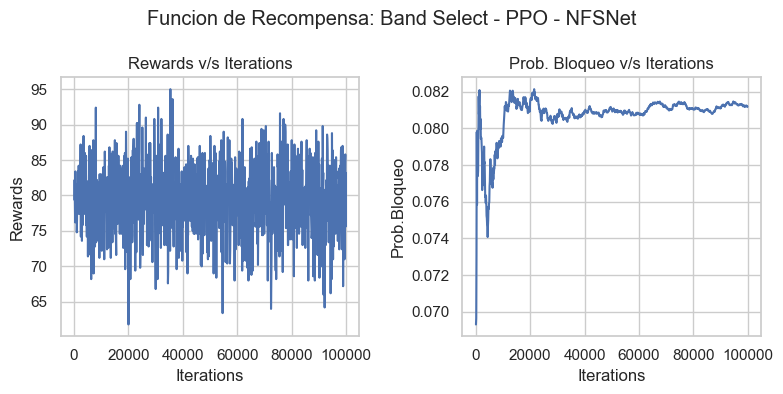

In [26]:
graph_Rewards_Bloqueo(x, rewardsArrayBS_PPO_NSFNet, probBloqueoArrayBS_PPO_NSFNet, "Band Select", "PPO", "NFSNet")

### 3) Funcion de Recompensa Length Base: (DONE)

#### 3.1) Data:

In [27]:
episodeRewardsArrayLB_PPO_NSFNet=[85, 92, 90, 90, 90, 78, 88, 74, 74, 82, 80, 82, 84, 78, 82, 84, 92, 76, 80, 86, 86, 82, 86, 82, 76, 80, 86, 70, 86, 86, 80, 82, 90, 84, 90, 86, 90, 92, 82, 86, 84, 80, 92, 84, 90, 80, 84, 80, 82, 78, 74, 80, 82, 90, 88, 80, 76, 86, 92, 86, 90, 86, 94, 80, 82, 84, 74, 82, 82, 76, 84, 80, 84, 78, 72, 78, 82, 88, 76, 86, 80, 92, 78, 78, 76, 86, 86, 88, 72, 78, 84, 76, 82, 88, 88, 78, 86, 90, 84, 78, 82, 84, 90, 86, 88, 92, 82, 96, 78, 86, 88, 82, 80, 84, 80, 88, 88, 88, 90, 84, 76, 86, 92, 76, 84, 84, 80, 78, 78, 88, 88, 88, 84, 82, 86, 86, 84, 76, 82, 80, 86, 78, 82, 84, 78, 76, 84, 80, 90, 80, 84, 82, 84, 82, 88, 84, 90, 86, 86, 84, 84, 84, 94, 82, 76, 88, 92, 94, 88, 92, 90, 90, 84, 76, 82, 88, 82, 72, 88, 86, 80, 76, 86, 90, 84, 80, 82, 74, 78, 74, 86, 80, 84, 78, 82, 86, 84, 74, 80, 84, 86, 72, 88, 88, 86, 74, 84, 78, 92, 86, 88, 84, 80, 78, 78, 82, 88, 78, 82, 80, 84, 86, 84, 90, 88, 78, 78, 86, 80, 80, 82, 76, 88, 80, 88, 80, 88, 80, 90, 90, 86, 82, 72, 86, 82, 84, 84, 88, 84, 84, 92, 80, 72, 84, 72, 92, 76, 86, 86, 88, 90, 84, 82, 86, 84, 82, 88, 86, 80, 84, 90, 76, 88, 86, 88, 88, 82, 90, 82, 90, 86, 82, 78, 78, 88, 78, 88, 84, 90, 92, 84, 84, 88, 86, 68, 86, 86, 78, 92, 90, 90, 84, 80, 82, 82, 82, 80, 86, 82, 90, 88, 90, 84, 86, 88, 96, 90, 90, 92, 82, 78, 94, 92, 86, 88, 82, 88, 84, 80, 80, 80, 82, 86, 82, 76, 86, 90, 80, 88, 94, 88, 82, 78, 86, 88, 90, 92, 88, 96, 82, 90, 84, 76, 98, 90, 88, 88, 92, 86, 76, 80, 76, 84, 70, 80, 86, 74, 82, 80, 84, 86, 86, 84, 86, 94, 86, 76, 88, 84, 82, 82, 86, 76, 90, 88, 86, 84, 84, 78, 88, 82, 82, 90, 84, 82, 82, 84, 80, 92, 80, 84, 90, 82, 84, 86, 82, 72, 84, 76, 86, 78, 84, 78, 84, 86, 86, 86, 88, 90, 84, 80, 82, 76, 88, 80, 92, 84, 90, 90, 72, 82, 90, 90, 80, 88, 80, 76, 82, 84, 92, 94, 84, 84, 88, 86, 88, 78, 86, 80, 86, 84, 86, 88, 84, 80, 78, 86, 82, 76, 84, 80, 94, 82, 86, 84, 84, 78, 86, 92, 80, 96, 90, 82, 84, 82, 80, 86, 84, 78, 86, 84, 74, 88, 88, 80, 86, 84, 86, 78, 86, 92, 88, 84, 86, 88, 90, 86, 84, 78, 90, 80, 88, 88, 88, 82, 86, 86, 80, 74, 74, 86, 76, 92, 86, 90, 86, 86, 90, 86, 82, 92, 80, 82, 78, 86, 84, 92, 88, 88, 88, 82, 86, 78, 90, 80, 84, 80, 78, 92, 84, 92, 86, 70, 78, 88, 82, 82, 88, 82, 84, 80, 84, 94, 86, 84, 92, 84, 72, 84, 82, 86, 76, 86, 82, 78, 86, 80, 88, 88, 86, 92, 80, 80, 92, 86, 76, 92, 76, 76, 84, 72, 84, 90, 88, 72, 82, 84, 82, 88, 80, 92, 90, 86, 88, 88, 80, 84, 84, 84, 76, 82, 90, 88, 90, 88, 78, 88, 80, 88, 74, 84, 88, 86, 86, 78, 82, 82, 90, 86, 80, 92, 84, 88, 86, 88, 88, 82, 90, 80, 84, 82, 84, 82, 92, 84, 90, 78, 78, 94, 82, 78, 88, 90, 82, 82, 80, 78, 84, 86, 74, 76, 86, 86, 90, 90, 84, 72, 86, 94, 76, 76, 86, 74, 82, 78, 86, 88, 90, 82, 84, 86, 86, 72, 86, 82, 82, 68, 76, 78, 84, 92, 84, 92, 88, 88, 90, 84, 76, 82, 84, 92, 84, 78, 80, 82, 74, 94, 86, 92, 80, 84, 84, 84, 82, 86, 88, 88, 82, 84, 92, 76, 74, 78, 78, 84, 74, 90, 74, 84, 82, 88, 84, 90, 90, 86, 90, 86, 90, 88, 86, 92, 78, 88, 84, 82, 74, 92, 84, 84, 96, 82, 84, 92, 78, 74, 82, 82, 78, 84, 82, 80, 86, 90, 80, 90, 90, 82, 92, 88, 90, 86, 86, 88, 80, 82, 84, 88, 88, 90, 82, 86, 84, 86, 92, 82, 88, 86, 84, 84, 86, 78, 90, 86, 78, 84, 78, 80, 86, 86, 96, 96, 88, 86, 86, 90, 82, 90, 86, 80, 84, 78, 80, 84, 80, 86, 74, 76, 88, 86, 84, 86, 90, 82, 84, 86, 82, 76, 82, 86, 84, 82, 84, 88, 86, 90, 88, 78, 74, 90, 80, 86, 82, 86, 90, 76, 94, 84, 84, 86, 86, 78, 88, 90, 82, 88, 84, 82, 86, 80, 86, 88, 86, 88, 78, 82, 92, 86, 80, 94, 80, 80, 84, 82, 92, 78, 84, 82, 78, 90, 88, 80, 86, 84, 82, 84, 90, 80, 92, 92, 78, 74, 92, 84, 88, 68, 80, 84, 84, 80, 80, 76, 82, 88, 86, 80, 76, 86, 80, 86, 80, 92, 84, 90, 86, 84, 90, 88, 78, 84, 90, 86, 88, 88, 92, 86, 94, 90, 84, 84, 82, 94, 80, 84, 76, 84, 74, 90, 90, 84, 84, 84, 82, 86, 84, 92, 84, 82, 82, 78, 82, 76, 84, 78, 80, 80, 86, 88, 94, 84, 86, 84, 86, 86, 82, 78, 84, 86, 88, 88, 92, 88, 84, 80, 82, 80, 88, 80, 80, 84, 82, 92, 78, 78, 82, 88, 88, 88, 90, 76, 88, 80, 80, 92, 86, 92, 86, 82, 86, 76, 78, 92, 88, 90, 86, 76, 84, 92, 80, 80, 82, 86, 92, 78, 90, 78, 78, 84, 86, 80, 84, 92, 82, 90, 82, 82, 92, 86, 96, 92, 86]
rewardsArrayLB_PPO_NSFNet=[0, 92, 76, 80, 88, 78, 80, 76, 78, 86, 86, 78, 86, 86, 90, 86, 90, 90, 86, 84, 90, 76, 90, 86, 86, 84, 86, 80, 82, 76, 78, 76, 88, 80, 90, 86, 78, 80, 88, 84, 92, 88, 92, 86, 82, 84, 78, 76, 84, 74, 86, 78, 86, 78, 80, 72, 80, 82, 88, 78, 86, 84, 86, 72, 80, 80, 82, 92, 78, 78, 78, 90, 74, 80, 90, 80, 84, 88, 90, 76, 84, 80, 92, 86, 84, 94, 80, 96, 80, 88, 90, 84, 78, 80, 84, 86, 88, 84, 90, 90, 74, 86, 84, 88, 84, 80, 80, 80, 82, 82, 84, 88, 90, 82, 82, 86, 88, 74, 82, 84, 82, 82, 80, 82, 78, 84, 74, 86, 80, 88, 84, 86, 82, 82, 82, 86, 88, 86, 86, 88, 84, 80, 92, 88, 78, 82, 90, 92, 92, 90, 92, 86, 88, 84, 76, 84, 88, 72, 86, 86, 84, 74, 80, 88, 90, 84, 78, 74, 82, 74, 80, 84, 80, 86, 76, 88, 80, 78, 82, 84, 84, 74, 82, 88, 84, 86, 72, 88, 84, 90, 78, 94, 86, 76, 76, 76, 88, 78, 88, 76, 86, 82, 86, 92, 88, 80, 78, 80, 78, 82, 86, 82, 80, 84, 84, 88, 78, 88, 82, 92, 86, 80, 78, 82, 82, 82, 88, 84, 86, 88, 84, 86, 76, 76, 80, 82, 94, 72, 82, 92, 90, 86, 84, 80, 84, 84, 86, 88, 80, 86, 86, 86, 80, 84, 88, 92, 82, 84, 84, 88, 88, 88, 80, 76, 78, 90, 78, 92, 82, 90, 90, 86, 86, 80, 80, 76, 88, 76, 88, 94, 94, 84, 78, 86, 82, 82, 82, 82, 84, 86, 86, 92, 86, 84, 86, 92, 98, 86, 92, 86, 76, 88, 98, 80, 98, 82, 86, 86, 76, 86, 78, 78, 90, 82, 78, 80, 90, 86, 84, 90, 94, 82, 86, 80, 80, 88, 96, 88, 90, 96, 82, 84, 80, 90, 92, 92, 88, 84, 94, 82, 76, 84, 72, 76, 78, 78, 84, 76, 86, 86, 76, 86, 88, 86, 88, 96, 78, 82, 88, 78, 82, 84, 86, 80, 88, 90, 82, 84, 80, 82, 82, 82, 90, 88, 82, 82, 86, 80, 88, 88, 80, 82, 88, 84, 88, 82, 76, 78, 78, 80, 90, 76, 80, 84, 84, 84, 90, 86, 88, 88, 78, 86, 80, 78, 84, 86, 94, 80, 92, 78, 76, 86, 90, 92, 80, 82, 82, 78, 86, 84, 92, 92, 82, 88, 86, 86, 82, 80, 86, 80, 90, 82, 90, 86, 78, 82, 86, 78, 78, 82, 84, 86, 88, 80, 90, 78, 84, 86, 84, 92, 82, 96, 86, 84, 76, 84, 84, 88, 78, 84, 84, 80, 82, 86, 84, 88, 82, 84, 84, 78, 88, 94, 86, 80, 86, 94, 84, 86, 82, 82, 88, 86, 86, 88, 84, 80, 90, 88, 76, 68, 78, 88, 82, 82, 94, 92, 86, 84, 88, 82, 88, 86, 86, 82, 82, 76, 90, 92, 86, 88, 82, 90, 84, 82, 88, 80, 78, 80, 84, 88, 90, 90, 78, 70, 86, 90, 78, 86, 84, 78, 86, 84, 86, 92, 84, 88, 86, 78, 82, 84, 80, 84, 82, 84, 76, 86, 78, 84, 90, 86, 88, 90, 78, 86, 82, 94, 76, 90, 72, 80, 78, 80, 86, 86, 84, 76, 84, 82, 84, 84, 88, 92, 86, 86, 86, 84, 88, 78, 88, 84, 76, 82, 90, 84, 92, 80, 90, 86, 82, 82, 80, 84, 84, 88, 82, 78, 78, 90, 88, 82, 92, 84, 84, 92, 82, 90, 84, 86, 86, 80, 86, 82, 80, 92, 86, 88, 80, 90, 78, 86, 80, 86, 88, 86, 82, 80, 78, 86, 82, 82, 70, 82, 84, 92, 88, 86, 80, 80, 92, 82, 76, 82, 82, 72, 82, 84, 86, 90, 86, 84, 86, 86, 72, 88, 80, 80, 76, 68, 82, 80, 86, 92, 84, 94, 84, 90, 84, 80, 82, 86, 86, 88, 86, 78, 78, 74, 88, 88, 88, 84, 86, 84, 86, 80, 82, 92, 86, 86, 82, 92, 78, 74, 76, 82, 78, 78, 88, 80, 78, 86, 78, 92, 84, 90, 86, 92, 92, 80, 94, 86, 86, 84, 84, 90, 80, 78, 84, 86, 86, 90, 88, 84, 88, 88, 76, 76, 76, 88, 76, 88, 74, 84, 90, 84, 86, 92, 88, 86, 90, 88, 86, 86, 84, 92, 78, 82, 86, 88, 86, 94, 80, 84, 88, 88, 84, 84, 88, 90, 82, 82, 86, 80, 92, 78, 82, 86, 72, 82, 92, 90, 94, 94, 82, 92, 88, 84, 84, 90, 78, 90, 78, 80, 78, 84, 80, 86, 72, 84, 88, 86, 80, 92, 80, 80, 88, 86, 84, 72, 84, 90, 84, 84, 80, 94, 84, 88, 80, 78, 86, 86, 80, 86, 84, 84, 90, 78, 94, 78, 90, 80, 90, 78, 88, 86, 86, 84, 86, 78, 90, 80, 88, 88, 90, 78, 82, 86, 90, 84, 86, 86, 78, 84, 78, 92, 86, 82, 84, 80, 82, 86, 84, 86, 78, 84, 86, 88, 86, 82, 98, 78, 78, 82, 96, 82, 80, 72, 82, 88, 78, 78, 80, 78, 82, 92, 80, 78, 78, 90, 80, 82, 84, 92, 86, 92, 88, 84, 86, 80, 88, 82, 88, 88, 86, 90, 92, 86, 96, 84, 88, 80, 86, 84, 92, 76, 82, 78, 80, 92, 84, 86, 82, 90, 80, 82, 90, 86, 82, 86, 78, 78, 80, 80, 78, 86, 80, 80, 86, 92, 90, 86, 84, 84, 90, 84, 80, 82, 80, 90, 90, 86, 86, 92, 80, 82, 82, 82, 82, 82, 82, 76, 96, 82, 76, 80, 88, 90, 86, 92, 80, 88, 74, 84, 88, 84, 94, 86, 86, 80, 86, 74, 84, 94, 84, 90, 80, 82, 84, 96, 78, 78, 82, 88, 94, 78, 82, 76, 82, 90, 80, 78, 94, 86, 86, 86, 76, 90, 88, 94, 94, 90]
probBloqueoArrayLB_PPO_NSFNet=[0.0, 0.039603960396039604, 0.07960199004975124, 0.08637873754152824, 0.0798004987531172, 0.08582834331337326, 0.08818635607321132, 0.09272467902995721, 0.09488139825218476, 0.09211986681465038, 0.0899100899100899, 0.09173478655767484, 0.08992506244796003, 0.0883935434281322, 0.08565310492505353, 0.08461025982678215, 0.08244846970643348, 0.0805408583186361, 0.07995558023320377, 0.07995791688584955, 0.07846076961519241, 0.08043788672060924, 0.07905497501135847, 0.07866145154280747, 0.07830070803831737, 0.07836865253898441, 0.07804690503652441, 0.07885968159940762, 0.07925740806854695, 0.08066184074457083, 0.08163945351549484, 0.08287649145436955, 0.08216182442986567, 0.08270221145107544, 0.08174066451043811, 0.08140531276778064, 0.08219938905859484, 0.08268035666036207, 0.08208366219415943, 0.08203024865419123, 0.08097975506123468, 0.08046817849305048, 0.07950487979052606, 0.0792838874680307, 0.07952738014087707, 0.07953788047100645, 0.08019995653118887, 0.08104658583280153, 0.08102478650281192, 0.08202407671903693, 0.08178364327134573, 0.08233679670652813, 0.08209959623149395, 0.08262591963780419, 0.08294760229587113, 0.08398473004908198, 0.08427066595250848, 0.08437116295386775, 0.08395104292363385, 0.08439247585155059, 0.08415264122646225, 0.08408457629896739, 0.08385744234800839, 0.08474845262656722, 0.08498672082487112, 0.08521765882171974, 0.08529010755946069, 0.08461423668109237, 0.08498750183796501, 0.08534994928271265, 0.0857020425653478, 0.08519926770877341, 0.0858214136925427, 0.08601561429941104, 0.08552898256992299, 0.08572190374616717, 0.08564662544402052, 0.08531359563693026, 0.08486091526727342, 0.08530565751170738, 0.08523934508186477, 0.08542155289470436, 0.08486769906109011, 0.08468859173593543, 0.08463278181168908, 0.08399011880955182, 0.08417625857458436, 0.08343868520859671, 0.08362686058402455, 0.08336142006516122, 0.0829907788023553, 0.08295791671244918, 0.08325182045429845, 0.0834318890441888, 0.08339538346984364, 0.08325439427428692, 0.08301218623060098, 0.0829811359653644, 0.08264462809917356, 0.08231491768508231, 0.0827917208279172, 0.08266508266508267, 0.08263895696500344, 0.08241918260363072, 0.08239592346889722, 0.08256356537472621, 0.0827280445241015, 0.08288944958415101, 0.0829552819183409, 0.0830199064306027, 0.0829924552313426, 0.08278533465453562, 0.08249263458619766, 0.08255906556941864, 0.08262433119901763, 0.08251456395096078, 0.0823204896129644, 0.08272797196820784, 0.08278959410219473, 0.08276615410469708, 0.0828264311307391, 0.08288571192463433, 0.08302598147692812, 0.08308267620518657, 0.08329973389242804, 0.08327333813294936, 0.08364415522577573, 0.08353672939138651, 0.08366533864541832, 0.0834819006278583, 0.08345511883701254, 0.08335241584611862, 0.08340277251723355, 0.0834523720021051, 0.08350123125139915, 0.0834012295385527, 0.08322917432541725, 0.08313261805707613, 0.08303746105354684, 0.08287173584634198, 0.08285122491250625, 0.08297283880575845, 0.08267023449052883, 0.0825117124676596, 0.08270259009790987, 0.08275291359216606, 0.08252859393192247, 0.08223930344874499, 0.08195392203229511, 0.0817394805717737, 0.0814612359176055, 0.08138533871929012, 0.08124465495691073, 0.08123652048885693, 0.08148821505097072, 0.08147861428294949, 0.08134093968335362, 0.08171454047512897, 0.0816404025061705, 0.08156719703163323, 0.0815574026623336, 0.08185826967269114, 0.08197024875007716, 0.08183547021655113, 0.08164136333150418, 0.08163141627780135, 0.08180230106620083, 0.08209089276091253, 0.08213796797809654, 0.0824211585113307, 0.08252455737897771, 0.0825097947488451, 0.08261147607697227, 0.08253858158487949, 0.08275386472041836, 0.08262385006571053, 0.08272257258110334, 0.08287667363425795, 0.08291669007359137, 0.08290039662588682, 0.08288428420643297, 0.08314457764764378, 0.08318224273391572, 0.08305557073383968, 0.08303896527362643, 0.08296848818982758, 0.08327509273694962, 0.08315063365595422, 0.08313387585766714, 0.08295857362044336, 0.08310088942687227, 0.0828228888539867, 0.08275610645278891, 0.08294906999637325, 0.08314004432761198, 0.08332906004820266, 0.08321004030406612, 0.08334602304451551, 0.0832281197919297, 0.08341289382443093, 0.08334583270836458, 0.0833789363713248, 0.08331270729171823, 0.08309935471159056, 0.08298612813097397, 0.08306911857958148, 0.08319984466773457, 0.08328100091783006, 0.0834094514686794, 0.08344098368499114, 0.08337698204847388, 0.0834083692715985, 0.08348662798924579, 0.08347025961222478, 0.0834540442035419, 0.08334496069950235, 0.08346835794639137, 0.08336021381503156, 0.08339067015274529, 0.08319254828546642, 0.08313258488250534, 0.08320890457445365, 0.08332957974865997, 0.08335949060580243, 0.08338913441364225, 0.08341851473267854, 0.08331489757090395, 0.08330029514118321, 0.0832419630717951, 0.08314047421509978, 0.08312682057301857, 0.08306999696982814, 0.08322917115641568, 0.08338697909960946, 0.08345797188154352, 0.08348580911450576, 0.0832591839328842, 0.08349858655752922, 0.08352590227301374, 0.08334379314673027, 0.08320486646389734, 0.08315007676030041, 0.08313706045204744, 0.08320645240936587, 0.08319331174951847, 0.08318027835598547, 0.0831267021665786, 0.08303307558398446, 0.08310148784323212, 0.08304887353921529, 0.0829966801327947, 0.08294490259352218, 0.08301257886591802, 0.08300067191020118, 0.08291012164875398, 0.08274185326065644, 0.08277020428889496, 0.08275942570328003, 0.0827487306693539, 0.08266090112350874, 0.08257374716357063, 0.08248726102448183, 0.08255410098851189, 0.08269647541918558, 0.08279989394341124, 0.08267612542922909, 0.08277884290064283, 0.08261862851578593, 0.08264616991903287, 0.08252481320397011, 0.08240435539424466, 0.08235858455407549, 0.08231315025182898, 0.08237793487418044, 0.08244224663333455, 0.0825788153158067, 0.08249701097786312, 0.08263239594238475, 0.08255098737455487, 0.08236263933192359, 0.0821756365844077, 0.08216789438098289, 0.08226658629126626, 0.08222324299494717, 0.08225062497799374, 0.08227781481351532, 0.08230481451697493, 0.08233162607574648, 0.08232353043297108, 0.08228088993460433, 0.08223854349850006, 0.08209339885227311, 0.08205198452107805, 0.08204498139995221, 0.08200401346892963, 0.08186163180909121, 0.08161886422755987, 0.08157974478973772, 0.08144022012684138, 0.08140195980067556, 0.08153061564614512, 0.08145908773794891, 0.0812224760769511, 0.08128444605788587, 0.08104996546166245, 0.08107930887511886, 0.08104310316656319, 0.08100713331813296, 0.08113372942436933, 0.08109769910358888, 0.0811909293248605, 0.08128356001414745, 0.08118329540719849, 0.08121146289255934, 0.08130314321199962, 0.0813624964286848, 0.08126325116293788, 0.08122772152298034, 0.08122386088487783, 0.08112598351148867, 0.08096621980563107, 0.08099436154636927, 0.08096021862675072, 0.08101916349339029, 0.0810777445140582, 0.08101289191101813, 0.0808257415416705, 0.08076205620623222, 0.08066827230877108, 0.08048387587003435, 0.080512711736008, 0.0805111628047491, 0.08056986235354356, 0.08047806372181016, 0.08035687554264842, 0.08023641085340737, 0.08017618523258237, 0.08017566244325094, 0.08002721812964113, 0.08005663549747795, 0.08017411252610217, 0.08017360194715697, 0.08034852782082395, 0.08046412641030874, 0.08054998401209267, 0.08063534390307528, 0.08063350770208953, 0.08074695253739085, 0.08071607137725928, 0.08068536718145612, 0.08079769149452873, 0.08076692971710207, 0.08070793443368086, 0.08067760120109913, 0.08061919154826135, 0.08044843807216698, 0.08053144574590601, 0.08055796756393378, 0.08050054467752298, 0.08058271357343806, 0.08060887197577846, 0.0806071853965264, 0.0805778845888235, 0.08063138756508086, 0.08057470948600313, 0.08049094545354922, 0.08051692576705555, 0.08051551728835726, 0.0805684628135105, 0.0805940218422265, 0.08061944271776439, 0.08064472655723566, 0.08056235047444961, 0.08050722500737245, 0.08053260608005133, 0.08055785179061892, 0.08052977314433127, 0.08058141693854275, 0.08052697018597392, 0.08047281074377985, 0.08052419673166496, 0.08054906695362327, 0.08049527499280124, 0.08049398188036866, 0.08044061352568943, 0.0804654424560401, 0.08056786093624517, 0.08064391101005142, 0.08071956908327105, 0.0807691318989229, 0.0806902387118279, 0.08079077261451113, 0.08083977449554858, 0.080837637719142, 0.08083551178904089, 0.08083339662287031, 0.08075553647635161, 0.08072844512732677, 0.08067636491545438, 0.08062454575073306, 0.08069798255043624, 0.08067130495498866, 0.08071938508992314, 0.08079203989975435, 0.08079007945347888, 0.08076343793980395, 0.08063840792098717, 0.08068597823149308, 0.08058626014068283, 0.08065817461675753, 0.08075412794809883, 0.08072796282328897, 0.08065338219946118, 0.08055495024333552, 0.08060191782807179, 0.08062456326353581, 0.08064709982933102, 0.08071748878923767, 0.08069184947728524, 0.08069019832462232, 0.08059331920668555, 0.0804969003111565, 0.08051941897111443, 0.08047091085317132, 0.08044621589113464, 0.0804216371379497, 0.08044412103002277, 0.080489918268893, 0.08046540968668957, 0.08051094380084381, 0.08043998976767983, 0.08046217025127027, 0.0803916576005185, 0.08036765894552089, 0.0804359346558835, 0.08045792050757454, 0.08043393500149079, 0.08050159035262351, 0.08056893678226525, 0.08059041935263433, 0.08058907752096543, 0.08056506655177888, 0.080518540304518, 0.08056251551883704, 0.08049368257471679, 0.08055998741601313, 0.0805587318669985, 0.08053511107134069, 0.08053391665364612, 0.0804436426805639, 0.08046487855825427, 0.08033081306401188, 0.0803079577885445, 0.08030727798503344, 0.08039470496244576, 0.08039383749807696, 0.08039297383829302, 0.08034835123957901, 0.08041309141721796, 0.08041219145552385, 0.08041129540662159, 0.08045378625192512, 0.08047444860500855, 0.0804518260944688, 0.08045085235232, 0.08040687297047375, 0.08042745863822665, 0.08042654332883664, 0.08042563193094164, 0.08048868894053432, 0.08044509691283164, 0.0803379970701259, 0.08031609499798734, 0.08035770913934166, 0.0803358578932934, 0.0802298898970548, 0.08022940694523224, 0.08020796209723066, 0.08022844710361708, 0.08024884657940336, 0.0802066623612008, 0.08018544313008046, 0.0801643119437356, 0.0801225647502122, 0.0801223115224892, 0.08016329560215253, 0.0801012324849283, 0.0800599577010739, 0.08014180037294318, 0.08030510623504632, 0.08036570682230974, 0.08032422964909065, 0.08034389544927949, 0.08036348147096407, 0.08026153316734479, 0.08018019837983072, 0.08015967420011694, 0.08015935293052454, 0.08011887311499769, 0.0801386745756598, 0.08009839803203936, 0.08007824195125846, 0.0800581661719886, 0.0800779308562454, 0.08009761711077161, 0.0801766301657393, 0.08011699373530168, 0.08003786907556064, 0.08001810987972678, 0.07997878234219367, 0.07999843140330581, 0.07993972720690397, 0.07993984492490382, 0.07995945498138438, 0.07992062411237136, 0.07995961243471, 0.08001782911183891, 0.08005647859809288, 0.08005636956815505, 0.08001772605537466, 0.07996000076921597, 0.07990249707299284, 0.07996015402003794, 0.0800940708590658, 0.08007480773267686, 0.08001752347574331, 0.08007452329803616, 0.0800554069182748, 0.080055301982917, 0.08011190714731291, 0.0800928284371993, 0.08009265362234233, 0.08007368282551079, 0.07999849909007335, 0.07999850190071348, 0.07996112222201454, 0.07994253838547788, 0.07999851026982738, 0.08001710005390235, 0.08001706832897348, 0.08005407307272087, 0.08005397312434151, 0.08007232338886737, 0.08007219019907552, 0.08014558555908899, 0.08012697014733675, 0.08018168165418216, 0.08018134951829034, 0.08012627506797321, 0.08010783045846159, 0.08007127143142852, 0.08001669661167674, 0.0800710132062825, 0.08005280193848212, 0.08007075684554431, 0.07998054089115511, 0.08005251704106041, 0.07999856376007612, 0.08010609128868658, 0.08014167903973095, 0.08019499651791932, 0.08023029892515285, 0.08021209587018024, 0.08019395747855278, 0.08019361358841155, 0.08026406612272349, 0.08026359958304624, 0.08028077106223876, 0.08028027675569092, 0.08027978418656966, 0.08024420624199576, 0.08017372725521445, 0.08015594132969703, 0.08013821748311548, 0.08012055539102106, 0.08012034573311769, 0.08008541518376418, 0.08013725931959585, 0.08010242037334994, 0.08010224348456849, 0.08017103153393906, 0.08018794857231373, 0.08013608013608013, 0.08013584672647124, 0.08006712213831955, 0.08010119485137006, 0.08004982850122011, 0.08003270813103695, 0.08004965901940443, 0.08006655235055432, 0.08010033728241894, 0.080100167509856, 0.08009999831083935, 0.08006610343839059, 0.08008282688843622, 0.08013310700660493, 0.0801832184023758, 0.08013266109445404, 0.0800989950000836, 0.08011552394784728, 0.08004866585556908, 0.08004858488211511, 0.08004850417767147, 0.07998208984925623, 0.07999867551861724, 0.07994909175054958, 0.07994917575617565, 0.07993278529184034, 0.07991644874261937, 0.07994942611779773, 0.07993311585055983, 0.07994959165971097, 0.0799823532295224, 0.07991713022626058, 0.07990097881142001, 0.07986862002243866, 0.0799013003035665, 0.07985283868981054, 0.07990161971489135, 0.07988562381867821, 0.07991806583764778, 0.07990209497431604, 0.07987009855147023, 0.07985425595094782, 0.07987051489559462, 0.0799027215564551, 0.07995079950799508, 0.0799349292674758, 0.07995095619496505, 0.07996693216324065, 0.08007809399850796, 0.08009381784757769, 0.08009366940396513, 0.08003033127438745, 0.07999873819024937, 0.07998299239382058, 0.08001446518136507, 0.08004583915480133, 0.0799830723656369, 0.07999874806341059, 0.0800612490429837, 0.08007675387279449, 0.08009221040170714, 0.08018537814341924, 0.08020061800282605, 0.08020030697198494, 0.08018451726753456, 0.08013786494799154, 0.08012222033610593, 0.08012203201799664, 0.08010645990061692, 0.0800909356231087, 0.08018281928191286, 0.08015191191559087, 0.08018226021008854, 0.08021251583945284, 0.08027316656758281, 0.08039451454315764, 0.08040911232352092, 0.08043884007829927, 0.08042302389357738, 0.08036187047094598, 0.0803613238470718, 0.0802853652282771, 0.08028493546783934, 0.08023939489631735, 0.08023903544991817, 0.08026866163925578, 0.08028322929297466, 0.08026785847745176, 0.08025253354427546, 0.08022235138075438, 0.08020713977470573, 0.08025140785426665, 0.08029554457648996, 0.08036917971585607, 0.08033904823893137, 0.08030900577539475, 0.08027905193138744, 0.08027864096257788, 0.08026352553638917, 0.08026313857358923, 0.08024809020395596, 0.08027700912138915, 0.08029122381251737, 0.08023240536634502, 0.08021748954096879, 0.08020261713803292, 0.08021685731312045, 0.08015848826577263, 0.08020173620672164, 0.08027380211574363, 0.08033120908657389, 0.08034516096448825, 0.08038789066439965, 0.08043049740291507, 0.080401143661729, 0.08042926213397225, 0.08047162648099597, 0.08045664582767056, 0.08049885001642834, 0.08044107787335417, 0.08044044956624549, 0.08039714940043527, 0.08038238093208903, 0.08032510177160608, 0.08026798487273551, 0.08029589397603994, 0.08022485558113586, 0.08021043426749976, 0.08019605357671018, 0.08019577783716123, 0.08019550287215067, 0.08015315353220852, 0.0801809498466408, 0.08022265422861219, 0.08022234326336225, 0.0802080863586282, 0.08019386916616761, 0.08015187549547294, 0.08012388716823378, 0.0801237153437539, 0.0800958435478733, 0.08006804885132986, 0.0801232027181945, 0.08017820443855947, 0.08023305464112064, 0.08020522413721957, 0.08025988654002006, 0.08023209558167926, 0.080300269859317, 0.08029985909905474, 0.08025846641439324, 0.08025811380472299, 0.08024413836323756, 0.08018938517843295, 0.08016195432127281, 0.08014816623926406, 0.08010731561902955, 0.08008010717040365, 0.08006648558803259, 0.0800529007705699, 0.08005282947669169, 0.07999892329847512, 0.08003924678431741, 0.08005261674339942, 0.08003914156646694, 0.08001231576551854, 0.07999893049558161, 0.07993217714049211, 0.07995893388088159, 0.07995898856206975, 0.0799324477068124, 0.07990597734425837, 0.07990610204108699, 0.07990622640759724, 0.07987989576857449, 0.0798404248292625, 0.07985382778591311, 0.07986719542562022, 0.0798542124445731, 0.07988068487930514, 0.07982834870933453, 0.07986789163969017, 0.07988115338804466, 0.0798682370165096, 0.07994673698776779, 0.0799598440698296, 0.07990781370034244, 0.07986892238072327, 0.0798041583875534, 0.07973956239218687, 0.0797528529423194, 0.07970142688969095, 0.0796759731786411, 0.07967639127237068, 0.07967680828855299, 0.07963861468964363, 0.07967763910489582, 0.07963954249624523, 0.07967846566069665, 0.07970448521785893, 0.07974322578995154, 0.07974355372217469, 0.07976939069654723, 0.07975694577139145, 0.07983358990343635, 0.07983380134941107, 0.07980863187015393, 0.07979620030164383, 0.07982177440791889, 0.07977143146104347, 0.07979697226045125, 0.079822448645036, 0.07979748365889598, 0.07978515993509516, 0.07978542983128353, 0.07986098041429844, 0.07986115462212252, 0.07982378193013855, 0.0798240021999725, 0.07982422191982622, 0.07984937843667785, 0.0797873002826864, 0.07978756483128319, 0.0797629843107539, 0.07978809195915683, 0.07982552880385621, 0.07981336864642764, 0.07980123855082137, 0.079826174985494, 0.07981405901283585, 0.0798142880013793, 0.07981451642661222, 0.07977788970651466, 0.07981497159544054, 0.07975392458425755, 0.07979094503127257, 0.07975452622828572, 0.07977924567465598, 0.07974292996426872, 0.07977978343747336, 0.07975572073332442, 0.07974386702470201, 0.07973204208686788, 0.07973236688040145, 0.07972058449655574, 0.07975719761550647, 0.07972125940507965, 0.07974572079950784, 0.07972193106107155, 0.07969819857763444, 0.07966250405644162, 0.0796989231821947, 0.07971127444515054, 0.07969964431563693, 0.07966411885025299, 0.07966452013715487, 0.07965298743451749, 0.07964148222309626, 0.07967762288544183, 0.07967800620682275, 0.07971401764824645, 0.07966690786586161, 0.07965545431926162, 0.07966769624028118, 0.0796680890296805, 0.07969209336371472, 0.07970424877065128, 0.07969281869471502, 0.07969318008023435, 0.07968178987320948, 0.0797173742092229, 0.07971770553686358, 0.07970632662381003, 0.07968327855814551, 0.07967196644899008, 0.07968401768940853, 0.07960280183214648, 0.07963818814682018, 0.07967349216869571, 0.07968548565057317, 0.07961624575120939, 0.0796282777719841, 0.07965185588129767, 0.07972162171535589, 0.07973349037539983, 0.07971072998004637, 0.07974562505040264, 0.07978043981081921, 0.07980368041746647, 0.07983834858382798, 0.07985000172016377, 0.07980435504747942, 0.07982746192835322, 0.07986194443492074, 0.07989634821520303, 0.07986225926728316, 0.07988519492944272, 0.07989670197153616, 0.07989681935432552, 0.07985153403480097, 0.0798403646217163, 0.07979524580695575, 0.07977285324826643, 0.07977310990836262, 0.07976207943476936, 0.0797848953224879, 0.0797626152858639, 0.07977413077468196, 0.07975191289985506, 0.07972974489624135, 0.07971883723276645, 0.07968555783249907, 0.07964116732475028, 0.07963039519111519, 0.07956384415352508, 0.07956433038650629, 0.07954254406966516, 0.07956529960734586, 0.07955467161475983, 0.07955516586941322, 0.07951131362180021, 0.07955615109467226, 0.07956770389708079, 0.07960133037204009, 0.0796238452114215, 0.07958015898391418, 0.07958062135879561, 0.07957008173727462, 0.07958154305996637, 0.07954907190919967, 0.07957149592657975, 0.07958291804032815, 0.07955055196332644, 0.07954011431569054, 0.07955153328020437, 0.07954111732696481, 0.07957429657629002, 0.07960740361911187, 0.07962956924381256, 0.0796516867352146, 0.07968460211928287, 0.07967410970628704, 0.07969610718498718, 0.07971805710208538, 0.07970756255332016, 0.07966472853583025, 0.07963276257798946, 0.07962239373096092, 0.07962279975484135, 0.07962320490649939, 0.07959142069291102, 0.07959185860816069, 0.07961370863266988, 0.07962481684687864, 0.07964658497238278, 0.0796149454114684, 0.07958337331158516, 0.07957316748490431, 0.07956298337251731, 0.0795209402663096, 0.07954268001401259, 0.0795537693131568, 0.07956483511827205, 0.07957587750394175, 0.07958689654443399, 0.07959789231370312, 0.0796088648853915, 0.07965142622311672, 0.07958863590909569, 0.07959958360059305, 0.07964202056701085, 0.07966338233596709, 0.07964277104013585, 0.07961173181432656, 0.07960167780671751, 0.0795602971755781, 0.07958163275957454, 0.07956121416877822, 0.07961375402339559, 0.07961415594010468, 0.079593767216557, 0.07959418905307318, 0.07954274333253804, 0.0795328545818178, 0.0795229863044896, 0.07954416190111788, 0.07953430233158748, 0.07958638197748218, 0.07958680838341872, 0.07953574113551869, 0.07953621876318145, 0.07950586324909302, 0.07952690424122956, 0.07953764576773571, 0.07953811948648067, 0.0794771803768641, 0.0795083894847701, 0.0795395348362121, 0.07955020867134009, 0.07953028001753296, 0.0794798423641307, 0.07951089002146469, 0.0795215495777482, 0.07956264403407072, 0.07957322948043123, 0.07954326703883446, 0.07956397202457464, 0.07959474626141293, 0.07954465106413067, 0.07953501982825602, 0.0795254080099999, 0.07951581555069939, 0.07955654369674349, 0.07952683892624195, 0.07950723386311383, 0.0794575781586945, 0.07940802196370778, 0.07937858479895096]


#### 3.2) Rewards & Prob. Bloque (LB):

Rewards Stats w/  Length Based  :
Avg =  84.04
Std =  5.774980519447663
Min-Max Reward = 68 - 98
Last Prob Bloqueo = 0.07937858479895096


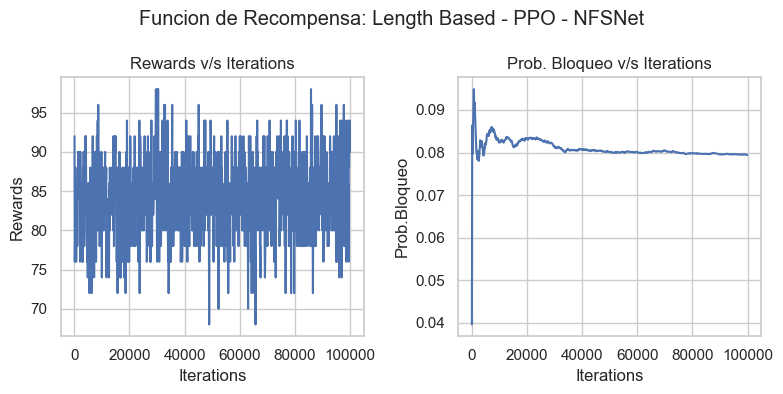

In [28]:
graph_Rewards_Bloqueo(x, rewardsArrayLB_PPO_NSFNet, probBloqueoArrayLB_PPO_NSFNet, "Length Based", "PPO", "NFSNet")


## Comparacion Final:


### Resultados para Agente TRPO:

#### Resultados Rewards:

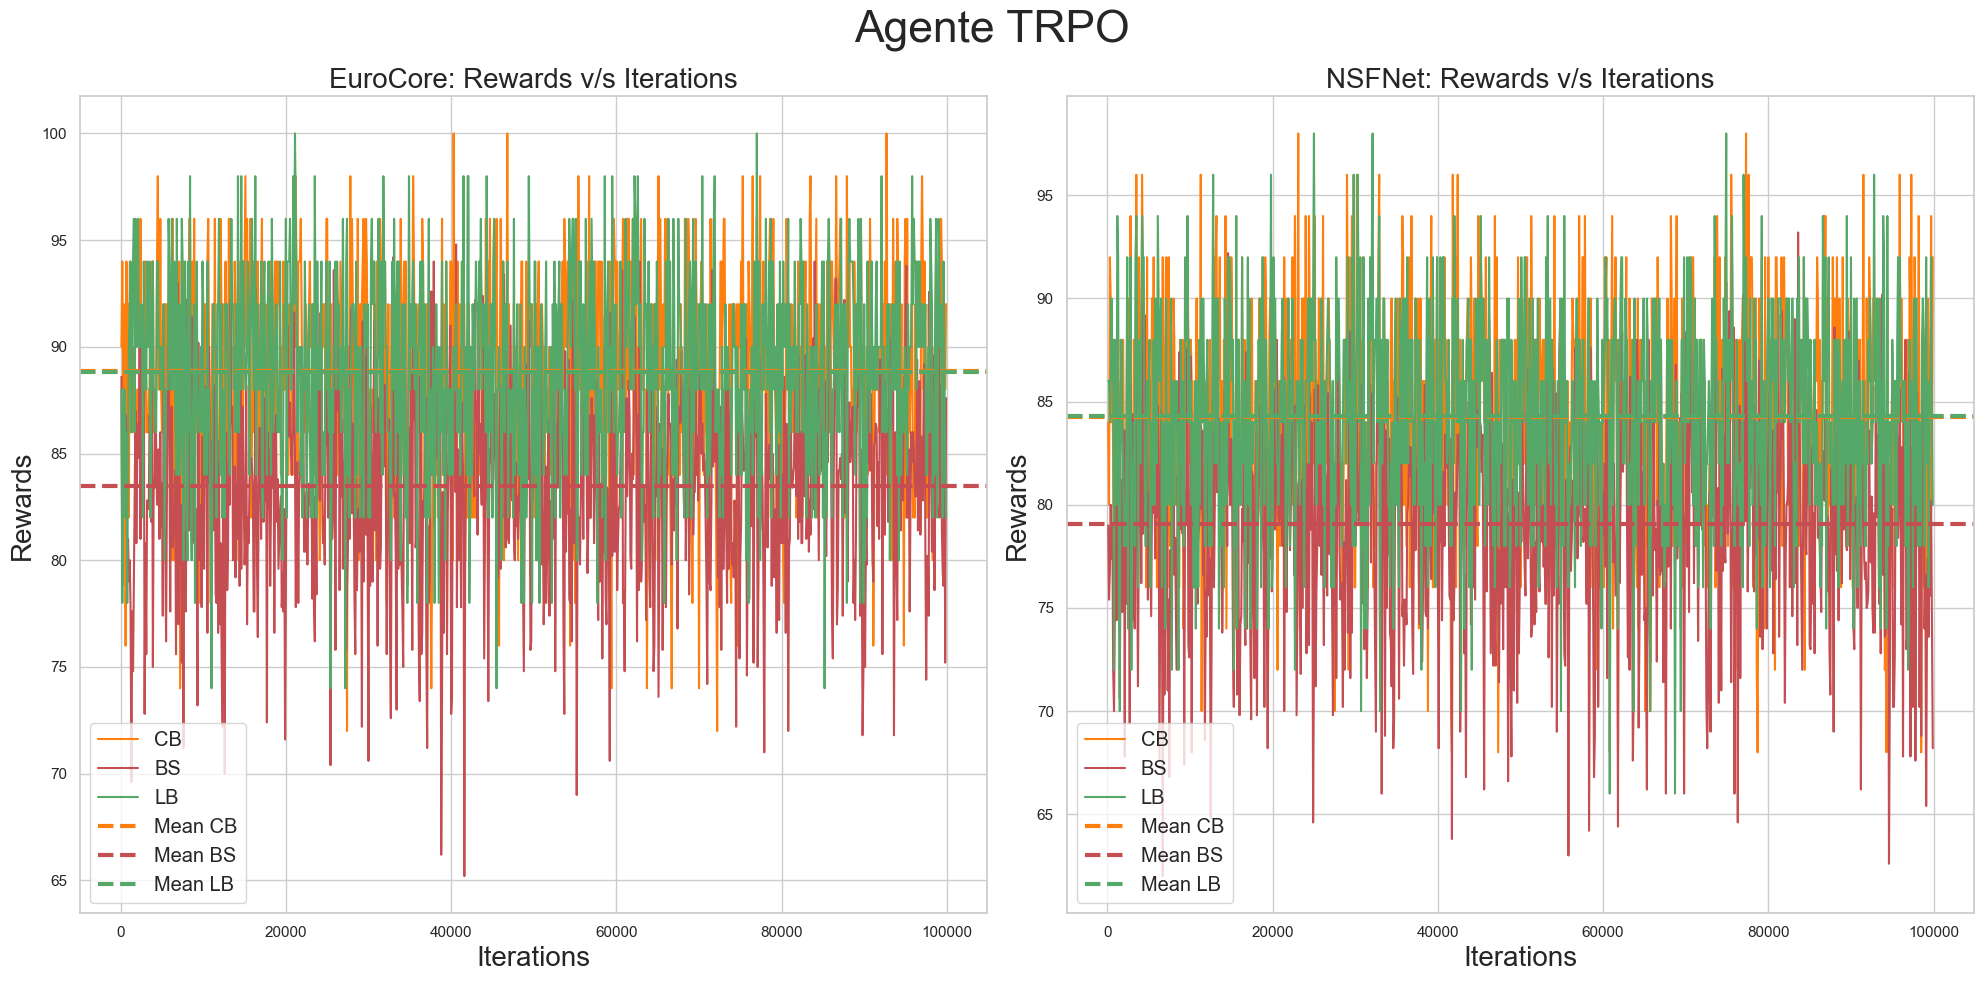

In [29]:
data1 = {'X': x[1:],'Y1': rewardsArrayCB_TRPO_Euro[1:] ,'Y2': rewardsArrayBS_TRPO_Euro[1:], 'Y3':rewardsArrayLB_TRPO_Euro[1:]}
df = pd.DataFrame(data1)

data2 = {'X': x[1:],'Y1': rewardsArrayCB_TRPO_NSFNet[1:] ,'Y2': rewardsArrayBS_TRPO_NSFNet[1:], 'Y3':rewardsArrayLB_TRPO_NSFNet[1:]}
df2 = pd.DataFrame(data2)

sns.set(style="whitegrid")
f, axs = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw=dict(width_ratios=[4, 4]))
plt.suptitle('Agente TRPO',fontsize=32)
sns.lineplot(x="X", y="Y1", data= df, ax=axs[0], label='CB', color='tab:orange')
sns.lineplot(x="X", y="Y2", data= df, ax=axs[0], label='BS', color='r')
sns.lineplot(x="X", y="Y3", data= df, ax=axs[0], label='LB', color='g')
axs[0].axhline(y=np.mean(rewardsArrayCB_TRPO_Euro[1:]), color='tab:orange', linestyle='--', label='Mean CB', linewidth=3)
axs[0].axhline(y=np.mean(rewardsArrayBS_TRPO_Euro[1:]), color='r', linestyle='--', label='Mean BS', linewidth=3)
axs[0].axhline(y=np.mean(rewardsArrayLB_TRPO_Euro[1:]), color='g', linestyle='--', label='Mean LB', linewidth=3)


axs[0].legend(fontsize='large', loc='lower left')
axs[0].set_title('EuroCore: Rewards v/s Iterations',fontsize=20)
axs[0].set_ylabel('Rewards',fontsize=20)
axs[0].set_xlabel('Iterations',fontsize=20)


sns.lineplot(x="X", y="Y1", data= df2, ax=axs[1], label='CB', color='tab:orange')
sns.lineplot(x="X", y="Y2", data= df2, ax=axs[1], label='BS',color='r')
sns.lineplot(x="X", y="Y3", data= df2, ax=axs[1], label='LB', color='g')
axs[1].axhline(y=np.mean(rewardsArrayCB_TRPO_NSFNet[1:]), color='tab:orange', linestyle='--', label='Mean CB', linewidth=3)
axs[1].axhline(y=np.mean(rewardsArrayBS_TRPO_NSFNet[1:]), color='r', linestyle='--', label='Mean BS', linewidth=3)
axs[1].axhline(y=np.mean(rewardsArrayLB_TRPO_NSFNet[1:]), color='g', linestyle='--', label='Mean LB', linewidth=3)


axs[1].legend(fontsize='large')
axs[1].set_title('NSFNet: Rewards v/s Iterations',fontsize=20)
axs[1].set_ylabel('Rewards',fontsize=20)
axs[1].set_xlabel('Iterations',fontsize=20)

f.tight_layout()


#### Resultados Prob. Bloqueo:

In [30]:
data1 = {'X': x[1:],'Y1': probBloqueoArrayCB_TRPO_Euro[1:] ,'Y2': probBloqueoArrayBS_TRPO_Euro[1:], 'Y3':probBloqueoArrayLB_TRPO_Euro[1:]}
df = pd.DataFrame(data1)

data2 = {'X': x[1:],'Y1': probBloqueoArrayCB_TRPO_NSFNet[1:] ,'Y2': probBloqueoArrayBS_TRPO_NSFNet[1:], 'Y3':probBloqueoArrayLB_TRPO_NSFNet[1:]}
df2 = pd.DataFrame(data2)

sns.set(style="whitegrid")
f, axs = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw=dict(width_ratios=[4, 4]))
plt.suptitle('Agente TRPO', fontsize=32)
sns.lineplot(x="X", y="Y1", data= df, ax=axs[0], label='CB', color='tab:orange')
sns.lineplot(x="X", y="Y2", data= df, ax=axs[0], label='BS', color='r')
sns.lineplot(x="X", y="Y3", data= df, ax=axs[0], label='LB', color='g')

#axs[0].axhline(y=np.mean(probBloqueoArrayCB_TRPO_Euro[1:]), color='tab:orange', linestyle='--', label='Mean CB', linewidth=3)
#axs[0].axhline(y=np.mean(probBloqueoArrayBS_TRPO_Euro[1:]), color='r', linestyle='--', label='Mean BS', linewidth=3)
#axs[0].axhline(y=np.mean(probBloqueoArrayLB_TRPO_Euro[1:]), color='g', linestyle='--', label='Mean LB', linewidth=3)

axs[0].legend(fontsize='large')
axs[0].set_title('EuroCore: Prob. Bloqueo v/s Iterations', fontsize=20)
axs[0].set_ylabel('Rewards', fontsize=20)
axs[0].set_xlabel('Iterations', fontsize=20)

sns.lineplot(x="X", y="Y1", data= df2, ax=axs[1], label='CB', color='tab:orange')
sns.lineplot(x="X", y="Y2", data= df2, ax=axs[1], label='BS',color='r')
sns.lineplot(x="X", y="Y3", data= df2, ax=axs[1], label='LB', color='g')

#axs[1].axhline(y=np.mean(probBloqueoArrayCB_TRPO_NSFNet[1:]), color='tab:orange', linestyle='--', label='Mean CB', linewidth=3)
#axs[1].axhline(y=np.mean(probBloqueoArrayBS_TRPO_NSFNet[1:]), color='r', linestyle='--', label='Mean BS', linewidth=3)
#axs[1].axhline(y=np.mean(probBloqueoArrayLB_TRPO_NSFNet[1:]), color='g', linestyle='--', label='Mean LB', linewidth=3)

axs[1].legend(fontsize='large')
axs[1].set_title('NSFNet: Prob. Bloqueo v/s Iterations', fontsize=20)
axs[1].set_ylabel('Rewards', fontsize=20)
axs[1].set_xlabel('Iterations', fontsize=20)

f.tight_layout()

NameError: name 'probBloqueoArrayFF_Euro' is not defined

### Resultados para Agente PPO:

#### Resultados Rewards:

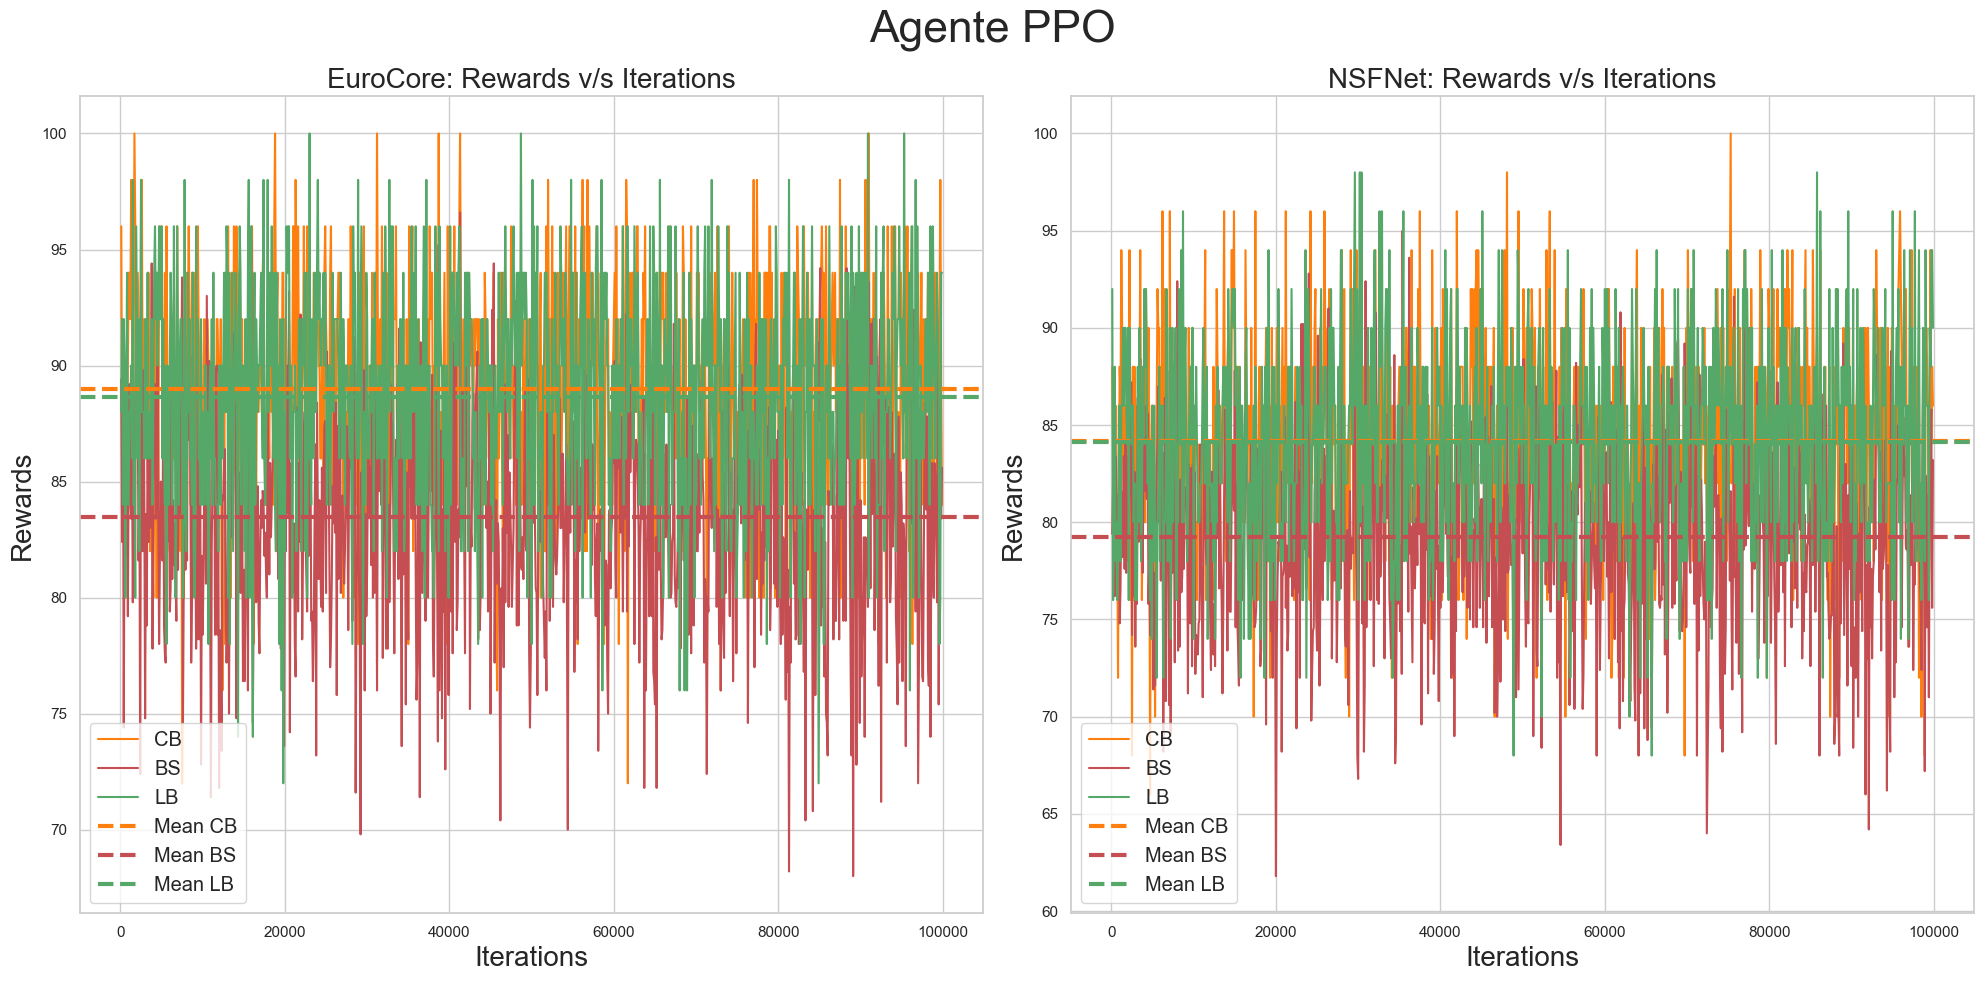

In [ ]:
data1 = {'X': x[1:],'Y1': rewardsArrayCB_PPO_Euro[1:] ,'Y2': rewardsArrayBS_PPO_Euro[1:], 'Y3':rewardsArrayLB_PPO_Euro[1:]}
df = pd.DataFrame(data1)

data2 = {'X': x[1:],'Y1': rewardsArrayCB_PPO_NSFNet[1:] ,'Y2': rewardsArrayBS_PPO_NSFNet[1:], 'Y3':rewardsArrayLB_PPO_NSFNet[1:]}
df2 = pd.DataFrame(data2)

sns.set(font_scale=4)
sns.set(style="whitegrid")
f, axs = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw=dict(width_ratios=[4, 4]))
plt.suptitle('Agente PPO',fontsize=32)
sns.lineplot(x="X", y="Y1", data= df, ax=axs[0], label='CB', color='tab:orange')
sns.lineplot(x="X", y="Y2", data= df, ax=axs[0], label='BS', color='r')
sns.lineplot(x="X", y="Y3", data= df, ax=axs[0], label='LB', color='g')
axs[0].axhline(y=np.mean(rewardsArrayCB_PPO_Euro[1:]), color='tab:orange', linestyle='--', label='Mean CB', linewidth=3)
axs[0].axhline(y=np.mean(rewardsArrayBS_PPO_Euro[1:]), color='r', linestyle='--', label='Mean BS', linewidth=3)
axs[0].axhline(y=np.mean(rewardsArrayLB_PPO_Euro[1:]), color='g', linestyle='--', label='Mean LB', linewidth=3)

axs[0].legend(fontsize='large', loc='lower left')
axs[0].set_title('EuroCore: Rewards v/s Iterations',fontsize=20)
axs[0].set_ylabel('Rewards',fontsize=20)
axs[0].set_xlabel('Iterations',fontsize=20)


sns.lineplot(x="X", y="Y1", data= df2, ax=axs[1], label='CB', color='tab:orange')
sns.lineplot(x="X", y="Y2", data= df2, ax=axs[1], label='BS',color='r')
sns.lineplot(x="X", y="Y3", data= df2, ax=axs[1], label='LB', color='g')
axs[1].axhline(y=np.mean(rewardsArrayCB_PPO_NSFNet[1:]), color='tab:orange', linestyle='--', label='Mean CB', linewidth=3)
axs[1].axhline(y=np.mean(rewardsArrayBS_PPO_NSFNet[1:]), color='r', linestyle='--', label='Mean BS', linewidth=3)
axs[1].axhline(y=np.mean(rewardsArrayLB_PPO_NSFNet[1:]), color='g', linestyle='--', label='Mean LB', linewidth=3)


axs[1].legend(fontsize='large')
axs[1].set_title('NSFNet: Rewards v/s Iterations',fontsize=20)
axs[1].set_ylabel('Rewards',fontsize=20)
axs[1].set_xlabel('Iterations',fontsize=20)

f.tight_layout()

#### Resultados Prob. Bloqueo:

In [ ]:
data1 = {'X': x[2:],'Y1': probBloqueoArrayCB_PPO_Euro[2:] ,'Y2': probBloqueoArrayBS_PPO_Euro[2:], 'Y3':probBloqueoArrayLB_PPO_Euro[2:]}
df = pd.DataFrame(data1)

data2 = {'X': x[2:],'Y1': probBloqueoArrayCB_PPO_NSFNet[2:] ,'Y2': probBloqueoArrayBS_PPO_NSFNet[2:], 'Y3':probBloqueoArrayLB_PPO_NSFNet[2:]}
df2 = pd.DataFrame(data2)

sns.color_palette("muted")
sns.set(style="whitegrid")
f, axs = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw=dict(width_ratios=[4, 4]))
plt.suptitle('Agente PPO', fontsize=32)
sns.lineplot(x="X", y="Y1", data= df, ax=axs[0], label='CB', color='tab:orange')
sns.lineplot(x="X", y="Y2", data= df, ax=axs[0], label='BS', color='r')
sns.lineplot(x="X", y="Y3", data= df, ax=axs[0], label='LB', color='g')
#axs[0].axhline(y=np.mean(probBloqueoArrayCB_PPO_Euro[1:]), color='tab:orange', linestyle='--', label='Mean CB', linewidth=3)
#axs[0].axhline(y=np.mean(probBloqueoArrayBS_PPO_Euro[1:]), color='r', linestyle='--', label='Mean BS', linewidth=3)
#axs[0].axhline(y=np.mean(probBloqueoArrayLB_PPO_Euro[1:]), color='g', linestyle='--', label='Mean LB', linewidth=3)

axs[0].axis([-0.01, 100001, 0.042, 0.092])

axs[0].legend(fontsize='large')
axs[0].set_title('EuroCore: Prob. Bloqueo v/s Iterations', fontsize=20)
axs[0].set_ylabel('Prob. Bloqueo', fontsize=20)
axs[0].set_xlabel('Iterations', fontsize=20)


sns.lineplot(x="X", y="Y1", data= df2, ax=axs[1], label='CB', color='tab:orange')
sns.lineplot(x="X", y="Y2", data= df2, ax=axs[1], label='BS',color='r')
sns.lineplot(x="X", y="Y3", data= df2, ax=axs[1], label='LB', color='g')
#axs[1].axhline(y=np.mean(probBloqueoArrayCB_PPO_NSFNet[1:]), color='tab:orange', linestyle='--', label='Mean CB', linewidth=3)
#axs[1].axhline(y=np.mean(probBloqueoArrayBS_PPO_NSFNet[1:]), color='r', linestyle='--', label='Mean BS', linewidth=3)
#axs[1].axhline(y=np.mean(probBloqueoArrayLB_PPO_NSFNet[1:]), color='g', linestyle='--', label='Mean LB', linewidth=3)

axs[1].axis([-0.01, 100001, 0.069, 0.095])

axs[1].legend(fontsize='large')
axs[1].set_title('NSFNet: Prob. Bloqueo v/s Iterations',fontsize=20)
axs[1].set_ylabel('Prob. Bloqueo', fontsize=20)
axs[1].set_xlabel('Iterations', fontsize=20)

f.tight_layout()

NameError: name 'probBloqueoArrayBS_PPO_Euro' is not defined

### Resultados First Fit:

#### Data NSFNet (100 Timesteps):

In [ ]:
episodeRewardArrayFF_NSFNet_100ts=[49, 48, 36, 36, 38, 46, 52, 30, 28, 32, 34, 46, 50, 46, 44, 44, 58, 48, 56, 48, 44, 58, 44, 60, 44, 46, 54, 30, 44, 34, 62, 54, 58, 28, 46, 40, 42, 44, 52, 46, 36, 42, 42, 54, 38, 46, 46, 52, 46, 28, 38, 46, 38, 52, 36, 44, 34, 46, 62, 34, 56, 60, 44, 44, 46, 56, 48, 36, 46, 60, 48, 40, 44, 56, 38, 50, 46, 50, 46, 56, 58, 52, 48, 46, 46, 48, 50, 44, 54, 40, 58, 42, 46, 48, 44, 42, 38, 52, 40, 62, 44, 52, 52, 42, 48, 40, 36, 56, 54, 48, 50, 32, 36, 44, 56, 56, 46, 48, 52, 42, 36, 46, 36, 40, 36, 48, 36, 44, 34, 42, 52, 50, 44, 36, 40, 38, 40, 32, 42, 52, 40, 52, 24, 48, 40, 44, 46, 30, 50, 42, 48, 42, 48, 40, 54, 42, 30, 58, 36, 52, 50, 54, 32, 48, 36, 52, 50, 52, 60, 46, 54, 46, 40, 58, 54, 52, 40, 54, 46, 32, 42, 48, 60, 56, 58, 48, 48, 40, 46, 48, 46, 32, 46, 36, 48, 48, 50, 52, 40, 40, 52, 48, 38, 44, 48, 60, 38, 44, 40, 34, 48, 48, 52, 42, 48, 48, 52, 48, 32, 36, 46, 52, 50, 50, 54, 58, 30, 48, 50, 64, 50, 40, 50, 44, 50, 42, 50, 42, 56, 62, 46, 44, 42, 34, 38, 58, 36, 50, 40, 48, 50, 40, 26, 46, 42, 54, 46, 42, 36, 42, 50, 44, 36, 42, 50, 40, 46, 54, 44, 42, 52, 48, 54, 56, 48, 42, 52, 48, 54, 40, 50, 62, 48, 38, 52, 34, 54, 52, 52, 54, 48, 32, 52, 42, 24, 36, 48, 52, 56, 30, 52, 54, 48, 48, 52, 44, 38, 36, 38, 52, 30, 32, 40, 52, 46, 48, 38, 48, 42, 44, 50, 60, 40, 38, 40, 56, 52, 44, 48, 48, 30, 46, 46, 36, 46, 58, 60, 50, 56, 48, 66, 32, 34, 42, 52, 42, 54, 54, 62, 46, 60, 44, 48, 46, 52, 42, 50, 38, 48, 46, 48, 36, 44, 46, 38, 30, 36, 44, 38, 44, 58, 36, 44, 42, 52, 48, 44, 48, 48, 66, 32, 46, 50, 56, 56, 46, 54, 60, 42, 42, 28, 46, 44, 44, 50, 40, 44, 42, 50, 34, 66, 50, 32, 44, 32, 42, 40, 40, 36, 38, 36, 40, 40, 58, 46, 62, 50, 44, 40, 50, 38, 38, 40, 54, 30, 56, 66, 50, 38, 40, 38, 48, 52, 52, 44, 54, 60, 38, 42, 52, 52, 48, 36, 48, 52, 44, 48, 58, 48, 58, 42, 60, 40, 58, 30, 50, 50, 58, 56, 52, 36, 50, 52, 40, 52, 64, 42, 62, 54, 42, 46, 38, 50, 46, 46, 50, 52, 38, 48, 46, 50, 44, 32, 44, 40, 42, 46, 44, 42, 48, 56, 42, 34, 44, 50, 44, 48, 46, 38, 38, 56, 48, 50, 54, 48, 32, 44, 48, 40, 32, 54, 46, 48, 44, 40, 40, 46, 42, 54, 50, 54, 40, 44, 42, 48, 58, 50, 58, 34, 52, 40, 54, 36, 44, 46, 28, 48, 52, 46, 42, 48, 50, 40, 50, 32, 58, 42, 50, 42, 38, 50, 48, 46, 54, 60, 58, 30, 46, 50, 52, 28, 48, 50, 40, 44, 64, 42, 50, 54, 52, 42, 36, 56, 50, 48, 44, 40, 38, 36, 62, 48, 38, 44, 56, 48, 42, 52, 46, 52, 46, 32, 50, 50, 52, 42, 52, 50, 44, 50, 38, 46, 34, 38, 30, 52, 40, 46, 46, 52, 44, 40, 40, 38, 42, 36, 40, 46, 62, 42, 48, 52, 32, 42, 40, 52, 46, 52, 54, 36, 46, 42, 32, 54, 56, 46, 54, 50, 54, 62, 50, 40, 52, 40, 44, 56, 58, 46, 40, 40, 44, 54, 44, 42, 60, 66, 38, 30, 40, 50, 44, 38, 54, 42, 56, 52, 54, 54, 42, 52, 34, 40, 44, 46, 56, 48, 46, 46, 52, 38, 52, 40, 36, 44, 50, 40, 50, 50, 30, 38, 46, 40, 40, 30, 42, 40, 32, 42, 40, 32, 44, 36, 42, 42, 54, 40, 48, 28, 30, 44, 46, 52, 44, 50, 40, 54, 42, 38, 36, 44, 50, 58, 44, 54, 44, 56, 46, 54, 50, 32, 48, 62, 48, 42, 44, 30, 40, 50, 42, 40, 46, 40, 46, 46, 42, 42, 40, 46, 50, 48, 46, 40, 38, 60, 42, 42, 46, 58, 62, 44, 38, 52, 40, 52, 42, 52, 48, 50, 48, 58, 40, 50, 42, 38, 60, 36, 52, 52, 36, 46, 36, 36, 54, 54, 32, 42, 56, 46, 44, 38, 42, 48, 48, 54, 50, 50, 52, 50, 40, 46, 50, 52, 60, 50, 46, 42, 32, 42, 32, 44, 66, 48, 56, 42, 42, 48, 36, 36, 36, 58, 46, 48, 60, 64, 50, 54, 48, 40, 48, 58, 38, 34, 40, 54, 58, 36, 54, 38, 44, 36, 38, 42, 44, 50, 40, 54, 40, 42, 56, 38, 60, 44, 36, 42, 44, 50, 46, 30, 36, 48, 48, 40, 54, 60, 48, 36, 54, 54, 54, 48, 56, 48, 38, 38, 40, 50, 52, 38, 34, 54, 46, 52, 42, 46, 64, 50, 48, 48, 44, 46, 32, 36, 56, 44, 42, 42, 46, 38, 42, 70, 52, 40, 46, 38, 40, 58, 46, 50, 46, 42, 40, 24, 46, 38, 46, 50, 50, 40, 52, 38, 40, 50, 34, 34, 42, 40, 50, 60, 56, 38, 44, 44, 34, 56, 46, 58, 60, 38, 44, 42, 52, 30, 52, 40, 36, 52, 42, 44, 54, 46, 50, 48, 40, 32, 54, 44, 36, 50, 42, 32, 40, 36, 44, 48, 36, 48, 58, 44, 46, 58, 44, 54, 42, 44, 46, 54, 42, 46, 56, 44, 48, 50, 44, 42, 42, 52, 44, 42, 48, 46, 50, 50, 54, 62, 60, 40, 44, 44, 48, 38, 42, 50, 34, 28, 54, 38, 40, 56, 52, 58, 58, 44, 60, 38, 44, 52, 50, 26, 44, 48, 52]
rewardsArrayFF_NSFNet_100ts=[0, 60, 36, 62, 52, 40, 54, 40, 40, 38, 44, 66, 50, 46, 42, 34, 44, 40, 54, 46, 46, 34, 44, 48, 50, 28, 52, 54, 46, 32, 40, 42, 46, 42, 38, 48, 28, 46, 54, 48, 44, 58, 58, 38, 42, 46, 60, 44, 40, 50, 56, 46, 46, 42, 48, 48, 48, 44, 44, 48, 66, 54, 48, 42, 46, 62, 44, 46, 46, 48, 48, 48, 50, 42, 42, 48, 38, 46, 52, 50, 54, 40, 64, 34, 48, 46, 44, 42, 50, 48, 56, 40, 32, 38, 54, 58, 48, 48, 42, 60, 34, 44, 40, 44, 34, 36, 48, 40, 38, 34, 42, 58, 44, 46, 38, 38, 38, 24, 42, 46, 54, 50, 42, 22, 42, 48, 44, 50, 28, 46, 46, 42, 56, 42, 44, 50, 36, 48, 44, 36, 56, 46, 46, 36, 50, 36, 54, 52, 56, 54, 42, 62, 38, 48, 60, 50, 52, 40, 54, 36, 36, 44, 54, 56, 58, 52, 44, 54, 40, 46, 52, 40, 32, 48, 46, 42, 52, 46, 46, 36, 54, 40, 44, 48, 40, 62, 50, 44, 44, 26, 44, 44, 50, 44, 56, 38, 50, 60, 42, 38, 30, 50, 54, 50, 46, 54, 46, 40, 50, 52, 62, 42, 48, 44, 54, 44, 44, 48, 50, 52, 58, 48, 40, 40, 28, 44, 52, 44, 48, 46, 52, 42, 36, 28, 50, 46, 48, 44, 44, 36, 46, 40, 52, 24, 54, 48, 42, 42, 56, 42, 48, 52, 52, 48, 64, 28, 54, 48, 60, 38, 46, 62, 48, 44, 50, 42, 46, 54, 48, 56, 46, 48, 34, 50, 32, 30, 38, 46, 62, 48, 38, 60, 38, 50, 50, 46, 42, 36, 38, 46, 40, 32, 42, 46, 44, 38, 56, 44, 42, 44, 48, 54, 44, 40, 48, 38, 60, 48, 40, 54, 44, 34, 36, 54, 34, 52, 60, 56, 50, 56, 56, 48, 40, 28, 52, 46, 50, 48, 62, 54, 52, 50, 48, 48, 44, 48, 52, 40, 42, 52, 50, 38, 40, 40, 48, 28, 32, 40, 42, 44, 48, 50, 44, 36, 52, 46, 50, 52, 34, 64, 44, 44, 48, 56, 52, 52, 50, 60, 44, 44, 36, 30, 46, 50, 50, 46, 42, 36, 52, 40, 50, 56, 40, 42, 40, 36, 32, 46, 32, 44, 42, 34, 40, 48, 48, 62, 50, 54, 38, 40, 44, 38, 46, 46, 44, 44, 64, 50, 50, 32, 36, 46, 52, 50, 50, 50, 54, 44, 48, 44, 44, 60, 38, 44, 42, 54, 46, 58, 48, 52, 50, 52, 56, 48, 40, 40, 58, 48, 60, 54, 44, 46, 48, 40, 56, 48, 56, 56, 52, 48, 48, 32, 50, 44, 48, 54, 52, 44, 42, 46, 46, 46, 46, 30, 48, 44, 42, 42, 46, 40, 54, 50, 28, 46, 52, 44, 44, 46, 40, 36, 50, 58, 46, 50, 62, 24, 42, 48, 48, 32, 40, 54, 46, 46, 46, 38, 48, 36, 52, 42, 60, 46, 44, 46, 44, 56, 46, 54, 52, 38, 50, 48, 36, 48, 40, 38, 46, 40, 54, 38, 42, 52, 46, 42, 46, 48, 48, 44, 46, 50, 36, 44, 46, 58, 56, 54, 48, 30, 58, 48, 42, 34, 54, 40, 48, 54, 48, 46, 50, 58, 42, 50, 42, 52, 44, 48, 44, 42, 44, 34, 58, 42, 46, 42, 60, 38, 54, 50, 44, 50, 40, 40, 50, 50, 48, 50, 52, 34, 60, 40, 42, 40, 36, 24, 48, 48, 44, 46, 50, 46, 46, 42, 34, 38, 44, 40, 36, 56, 48, 50, 52, 42, 30, 42, 52, 42, 50, 56, 50, 34, 48, 26, 46, 64, 50, 50, 46, 56, 52, 64, 40, 44, 50, 48, 48, 56, 44, 46, 44, 44, 42, 44, 52, 44, 68, 56, 30, 40, 38, 50, 48, 40, 44, 50, 52, 50, 66, 48, 42, 42, 42, 36, 44, 50, 62, 48, 40, 50, 40, 52, 42, 34, 44, 54, 42, 44, 44, 38, 42, 36, 52, 36, 36, 38, 38, 34, 36, 40, 40, 32, 48, 38, 38, 50, 48, 40, 40, 32, 38, 42, 42, 52, 48, 52, 40, 50, 44, 36, 34, 44, 52, 62, 44, 54, 48, 50, 50, 44, 52, 36, 54, 50, 54, 36, 38, 38, 44, 54, 36, 44, 40, 44, 48, 46, 38, 42, 46, 44, 48, 48, 40, 36, 56, 46, 42, 46, 52, 62, 50, 42, 50, 38, 44, 56, 44, 50, 46, 50, 58, 50, 40, 46, 46, 52, 44, 36, 50, 48, 46, 38, 32, 52, 46, 46, 34, 58, 48, 46, 36, 40, 44, 52, 48, 62, 44, 50, 46, 46, 40, 56, 50, 60, 50, 48, 46, 40, 42, 34, 30, 50, 56, 62, 54, 38, 38, 46, 38, 30, 46, 60, 52, 50, 58, 56, 48, 54, 48, 42, 50, 50, 40, 30, 56, 44, 54, 48, 46, 38, 42, 40, 38, 38, 50, 42, 54, 40, 38, 52, 54, 40, 54, 48, 34, 42, 42, 54, 40, 30, 46, 48, 34, 56, 52, 60, 34, 52, 56, 50, 48, 56, 46, 52, 32, 36, 44, 54, 54, 24, 48, 52, 46, 48, 46, 48, 66, 48, 48, 42, 46, 44, 30, 56, 42, 42, 44, 34, 54, 36, 54, 66, 42, 42, 36, 44, 58, 38, 50, 56, 44, 36, 38, 30, 42, 42, 60, 40, 42, 46, 44, 40, 44, 44, 38, 32, 42, 44, 58, 58, 42, 46, 48, 36, 48, 44, 54, 56, 48, 48, 44, 46, 40, 38, 42, 46, 42, 46, 44, 46, 54, 50, 48, 40, 34, 50, 42, 42, 44, 48, 44, 26, 40, 34, 58, 38, 44, 54, 50, 42, 50, 50, 60, 42, 40, 36, 62, 42, 52, 54, 42, 48, 46, 56, 34, 36, 48, 58, 42, 40, 50, 50, 44, 58, 54, 66, 54, 40, 40, 52, 34, 34, 54, 42, 28, 42, 48, 44, 46, 44, 66, 52, 54, 48, 52, 34, 48, 60, 32, 32, 54, 50]
probBloqueoArrayFF_NSFNet_100ts=[0.0, 0.19801980198019803, 0.25870646766169153, 0.23588039867109634, 0.23690773067331672, 0.249500998003992, 0.24625623960066556, 0.25392296718972895, 0.2596754057428215, 0.26526082130965595, 0.26673326673326675, 0.2579473206176203, 0.257285595337219, 0.2582628747117602, 0.2605281941470378, 0.26515656229180545, 0.2660836976889444, 0.26807760141093473, 0.2659633536923931, 0.2661756970015781, 0.26636681659170414, 0.2693955259400286, 0.2698773284870513, 0.26944806605823557, 0.26863806747188673, 0.2722910835665734, 0.2710495963091119, 0.26952980377637914, 0.26954659050339164, 0.27197518097207857, 0.2729090303232256, 0.27346017413737506, 0.2733520774757888, 0.27385640714934867, 0.2749191414289915, 0.2744930019994287, 0.27686753679533466, 0.276681977843826, 0.27545382794001577, 0.27505767751858495, 0.2751812046988253, 0.27359180687637163, 0.27207807664841704, 0.27295977679609396, 0.27334696659850033, 0.2732726060875361, 0.2716800695500978, 0.27185705169112956, 0.2724432409914601, 0.27198530912058766, 0.2709458108378324, 0.2709272691629092, 0.27090944049221305, 0.27126957177890965, 0.271060914645436, 0.2708598436647882, 0.27066595250848063, 0.27082967900368354, 0.27098776073090847, 0.2708015590577868, 0.26912181303116145, 0.2684805769545976, 0.26834381551362685, 0.2686875099190605, 0.26870801437275427, 0.2674973081064452, 0.26768671413422207, 0.26772123563647215, 0.26775474194971327, 0.2676423706709173, 0.26753320954149407, 0.2674271229404309, 0.2671851131787252, 0.26749760306807285, 0.2678016484258884, 0.26769764031462473, 0.2682541770819629, 0.26827684716270617, 0.2679143699525702, 0.2676876344766485, 0.26721659792525937, 0.26762128132329344, 0.2665528594073893, 0.26731719069991566, 0.2672300916557553, 0.2672626749794142, 0.2674107661899779, 0.2676703827146305, 0.267469605726622, 0.26738568700146054, 0.26685923786245974, 0.267223382045929, 0.2680143462667101, 0.26846575637028275, 0.2680565897244974, 0.267445532049258, 0.26736798250182275, 0.2672920317493042, 0.26752372206917663, 0.26684173315826687, 0.26747325267473254, 0.2675972675972676, 0.2679149103029115, 0.2680322298805941, 0.26862801653687146, 0.2691172269307685, 0.269031223469484, 0.26932062424072517, 0.26969725025460606, 0.27025043573984037, 0.2704299609126443, 0.26988559589226196, 0.2699758950093742, 0.2699761083089992, 0.27032716428383474, 0.2706721154682202, 0.2710111197310577, 0.2719425690111956, 0.2720955851199051, 0.27207797664061845, 0.2717273560536622, 0.27154780596644906, 0.271699041062208, 0.27266075928786276, 0.27280058059833884, 0.27269818414526836, 0.272756130465836, 0.27257696244390206, 0.2732599015701898, 0.27323463297418804, 0.2732097530959157, 0.2733379131364018, 0.2729338686463147, 0.2730621757762574, 0.273113946720394, 0.27294274498185317, 0.27328872876994337, 0.2731917378293555, 0.27324106948771826, 0.2735774404719085, 0.2731947718020141, 0.2731721154528048, 0.2731497781846349, 0.27347737920425147, 0.27331435316991876, 0.27363630094476243, 0.27333744264091503, 0.27311067274335077, 0.2727518410918181, 0.2724649352392457, 0.27258182787814145, 0.27203496457188264, 0.27228471811065064, 0.27220443108293574, 0.2717356015843127, 0.27159538094316493, 0.2713928594320877, 0.271575058913445, 0.27131194228213407, 0.27161813722407396, 0.27192050496843945, 0.271970685050618, 0.2717116227393371, 0.27139439298202567, 0.27102005975245413, 0.2708320707835889, 0.27088729594602734, 0.2706424764984133, 0.2708172132611154, 0.2708123779658008, 0.2706311393447444, 0.2708028770247354, 0.2712051624905529, 0.27114039650887234, 0.27113384288259296, 0.2712416433346666, 0.27106414408272256, 0.2710581323089091, 0.2710521880793214, 0.27132562426680074, 0.2710960502194322, 0.27125573172752887, 0.2713037745178836, 0.271242008633408, 0.2713982935710016, 0.2709583265769418, 0.2708456534594914, 0.2708946045666007, 0.27094303494494976, 0.2714671181418973, 0.2715120256828588, 0.2715564630124077, 0.27144419561481176, 0.2714885239106782, 0.2712231328282047, 0.2714219783600841, 0.27131268812815673, 0.27095071316176844, 0.2710469168223827, 0.2712426511230591, 0.27163641817909107, 0.27152877966270333, 0.271323201821692, 0.2712181665927787, 0.2712121954806137, 0.27101117018682014, 0.2710062618319499, 0.2711463214337472, 0.2710446613143599, 0.2708961293718004, 0.2705109280510452, 0.270603288943652, 0.2705532757888779, 0.2705976245246702, 0.27040792486332416, 0.2704525370912981, 0.2704967362622101, 0.27044836643472653, 0.27035457089124354, 0.27021597187343044, 0.2699422753511204, 0.2698972897153975, 0.27003288140173864, 0.27016725707367384, 0.27056827820186596, 0.2706101951024399, 0.2704747577540817, 0.270516717325228, 0.27047059339502655, 0.27046853849176894, 0.27033607234468066, 0.27042119388771046, 0.27063488642730915, 0.27101841122698594, 0.27092859279517967, 0.2709246415046168, 0.27087835261217746, 0.27091683895194296, 0.27095500189067684, 0.27116020250198736, 0.2711553685263114, 0.2712750508277665, 0.2711458204206438, 0.27159376157359777, 0.2714233023236753, 0.27137667850291824, 0.27145237998455346, 0.27152746852354154, 0.27131970485061085, 0.27139472310348983, 0.2713491460341586, 0.2712242540137843, 0.2711003531605889, 0.27105647998102844, 0.2706980040155899, 0.2710481941884632, 0.2708878559431272, 0.2708454923932921, 0.27057090810433704, 0.27072313810277593, 0.27072035690934965, 0.27041109536033103, 0.27037135987176064, 0.2704079692787347, 0.27033066929282984, 0.270404890381495, 0.270403368294425, 0.27025205048500056, 0.2702137979926122, 0.2700271365376752, 0.2700270360357024, 0.2699900372679975, 0.27021065402007277, 0.2701366250320501, 0.2703915915477537, 0.2706810661430493, 0.2708235208869244, 0.2708205479946572, 0.270529837056221, 0.27049209705745314, 0.270633191671726, 0.27038183694530443, 0.2705223219034786, 0.2704498074272994, 0.27037780359846486, 0.27037647801831516, 0.2704450893325408, 0.27061774851050485, 0.2707544876913996, 0.2707518770976783, 0.27085272921623393, 0.27109034053812586, 0.2711550974281703, 0.271151155250674, 0.2711812523383558, 0.271312836852988, 0.2711394885307929, 0.27116932089828627, 0.2712325089762089, 0.2712618307080031, 0.27122429252358254, 0.27108733929105344, 0.27111685043541606, 0.2712121712154714, 0.2711752902865037, 0.2713025802432707, 0.27106957288977485, 0.27103351682355625, 0.2711275607934807, 0.2709944661985049, 0.2710235153704719, 0.27121314427188836, 0.27136950738758375, 0.2712373406600428, 0.2714244769274864, 0.2713247198501635, 0.27109901585392865, 0.27093782530519545, 0.27087198515769945, 0.2707125168490016, 0.27055404518608794, 0.2705211675648734, 0.27061271389087294, 0.2708894461471781, 0.27079411129286135, 0.2707916679486785, 0.27072789178246065, 0.27069508577719337, 0.27044907167464405, 0.2703261299048661, 0.2702342353262022, 0.2701731065526721, 0.2701424655883859, 0.2701120086483889, 0.27014161252657104, 0.2701113399600012, 0.2700217255438826, 0.2701106792083321, 0.27016952161178664, 0.2700805285979765, 0.27002146995676596, 0.2701387056098062, 0.270226016783135, 0.2703128188682546, 0.2702828406150984, 0.2705428828149909, 0.2707436201265859, 0.27082793003083483, 0.27088302060285624, 0.2709091430044984, 0.27087797491500243, 0.27081849519956697, 0.27084457827902614, 0.2709838248208266, 0.27089630236434, 0.2708937776400665, 0.27083508890199715, 0.2707487185232907, 0.27091422027317674, 0.27066098437369435, 0.27068692536318434, 0.27071272263926205, 0.27068313030026797, 0.2705435111980386, 0.270459602758166, 0.27037615407797044, 0.2703204830469113, 0.27012887932208934, 0.27015570229069863, 0.270182379881304, 0.27031701845896056, 0.27053179159591384, 0.2705303620870407, 0.27047532237741617, 0.27042057698992006, 0.2704194554811872, 0.2704715300124997, 0.2706029017797936, 0.2705219438639189, 0.270599720324002, 0.2705455119602116, 0.27041285005642896, 0.27049030130101304, 0.27054123913213757, 0.2706179526574829, 0.27074621438404195, 0.2709256236885055, 0.2709232319578305, 0.271101260276797, 0.27112413562633353, 0.2711725340375888, 0.27132298406690364, 0.2713961378536262, 0.2713671407852217, 0.27133829090632217, 0.2711323763955343, 0.27107901315623345, 0.2709755421777789, 0.2710735911158011, 0.2711460865642465, 0.27116822079448016, 0.27126505573427095, 0.2712619089077386, 0.27125877769782386, 0.2712804138511423, 0.27130194316189726, 0.2710770670673136, 0.2710252819341048, 0.2709737506433666, 0.27114251485293756, 0.27126167654447453, 0.27125860684654873, 0.2711827382830514, 0.27113144960170454, 0.27108040868578054, 0.2710296137442471, 0.27093098723588377, 0.27095273494640415, 0.2709265328580656, 0.2709481873940956, 0.2709697388157425, 0.2708011686183226, 0.2708940546432549, 0.270915581191934, 0.27096059055210964, 0.270864214959648, 0.27086218633365416, 0.27071965527739394, 0.2706946099390201, 0.27062306239947787, 0.27057510290458364, 0.27050416463655136, 0.270387259554177, 0.2703632710560957, 0.27043155687656967, 0.2704995287464656, 0.2703607715419371, 0.2703370632250978, 0.2701764799890414, 0.2700849638960388, 0.2701074975568737, 0.2701072538037686, 0.2700843872310581, 0.2701519153066522, 0.27003896308641695, 0.27001640412575, 0.26990426223627273, 0.2697926220889913, 0.26972612218477265, 0.26970446092514644, 0.26968289593564587, 0.26983880623489503, 0.2697949160416805, 0.26981744332354696, 0.269795819475342, 0.26970835805806465, 0.26964320957873733, 0.2696658716439465, 0.26971026833475253, 0.26971089954467226, 0.26971152801026066, 0.26971215374937635, 0.2697127767797234, 0.2698861795641563, 0.269864873601862, 0.26988666910389025, 0.26992982983197783, 0.2699728057215049, 0.269972863827696, 0.27003688620711713, 0.269951703155252, 0.26990934375066344, 0.27010020974131904, 0.2700999978858798, 0.2700364971203139, 0.2700574724742637, 0.27007835969832567, 0.2700781954256724, 0.27014079203363944, 0.27024488006513436, 0.27020270411033104, 0.2700775451653812, 0.2700773842866331, 0.2700358170638289, 0.26987045722195824, 0.27009752376239665, 0.27013847451698525, 0.2701176567216279, 0.2700969242433557, 0.27023987239524755, 0.2703006061100794, 0.27021852915419237, 0.2702180849982724, 0.2702176426441654, 0.27021720208092953, 0.2702975697460657, 0.2702768089353037, 0.2703768535844349, 0.27031585711130296, 0.27035530350093184, 0.2702145957080858, 0.2702141673818886, 0.27023366068405014, 0.27023319615912206, 0.27025257435368344, 0.27015306627591534, 0.270152763779372, 0.27007356856866727, 0.2700143697958702, 0.27009292548279995, 0.270053528362189, 0.27003385452339485, 0.27013144274525885, 0.27011169372916705, 0.270169841053676, 0.27024717966641426, 0.27024670064533635, 0.2703042494342469, 0.2702264435049516, 0.2703030770120036, 0.27034095498163496, 0.27028272010134163, 0.27028217850232755, 0.2703198791610103, 0.2703192687162459, 0.2702996133406983, 0.27028003269899814, 0.27029847630974746, 0.2702979110244124, 0.27025954140753483, 0.2703533895586876, 0.2703715560912224, 0.2703708576906449, 0.2702575936661601, 0.2701634800846426, 0.27008840956243807, 0.2700695882539505, 0.2702184316865608, 0.27010650359658744, 0.2700877534739615, 0.27012462732171627, 0.27023530064139295, 0.2701610671389827, 0.27021601812121326, 0.2701972390213415, 0.27012348397277114, 0.27010494313290967, 0.2701047512842544, 0.2700680644513786, 0.2699586528478534, 0.2699950909983455, 0.26995880292553676, 0.26999510878426114, 0.2699408690620423, 0.2699590260103608, 0.2699410821426641, 0.26995917339616193, 0.2699951526902569, 0.2700130822028279, 0.270120391406236, 0.27001303548150923, 0.2700486622341848, 0.2700485756481201, 0.2700840127173585, 0.26995975248665804, 0.2700306189270986, 0.26995989470150705, 0.269924692686196, 0.2699424305910107, 0.26990738299854133, 0.26996017613726075, 0.270012784364547, 0.2699777975909512, 0.2699429329331076, 0.26992561105207225, 0.26989095841811445, 0.2698390652940053, 0.2699433285385002, 0.26982232141312434, 0.26987444085594375, 0.2699091394975949, 0.26996093010447325, 0.2700469064105428, 0.27023550196394575, 0.27021797571959383, 0.27020050939300183, 0.27021723178785345, 0.27021686172296894, 0.27018247988979777, 0.270182170082002, 0.2701818613243843, 0.27021539398656536, 0.2703163797908819, 0.27038329876393313, 0.270399488224104, 0.27044923614729166, 0.27053237361789234, 0.27044773119378235, 0.27043026036353907, 0.2703961536535283, 0.27034549424176263, 0.2703781967022179, 0.27051045663693296, 0.27054277706837365, 0.27049221039386767, 0.27052445414125387, 0.270490585963928, 0.2704074067972521, 0.27037384253548463, 0.2704717492323607, 0.2704545827117588, 0.27061750216854064, 0.27061649319455566, 0.2704686709841601, 0.27043533492939853, 0.2704021072828084, 0.27040145452184217, 0.2703197679129998, 0.27027070759372823, 0.2701248768194375, 0.27017306172481087, 0.2701888858472488, 0.2701564283532419, 0.27014012616169886, 0.2701238762199324, 0.27004367930113116, 0.27005958371272026, 0.270059488684391, 0.27007531727201795, 0.27009109553107263, 0.2701226964651355, 0.2701383496299583, 0.270090663122419, 0.27010631743574354, 0.26993265090455987, 0.2698540180469599, 0.2699800317605069, 0.2700271581293857, 0.27008981050453756, 0.27005837154348133, 0.2700426555835065, 0.27008939018112044, 0.2701048270276164, 0.27007356028677626, 0.2700268629369109, 0.2699958140183873, 0.26984102413275335, 0.2698258141296116, 0.26985694665205784, 0.2698879832360056, 0.26991892432424114, 0.26999585259827036, 0.27001119614729835, 0.26998055159951606, 0.2698582590480268, 0.2698432085006336, 0.26988917851862015, 0.2698589062571346, 0.26990471269433597, 0.2698593344562298, 0.2698898501537855, 0.2699807869775041, 0.26999592151175966, 0.2699355967481637, 0.26996581376786494, 0.2699809025428189, 0.2699959460068167, 0.2700559212005817, 0.27008577715902454, 0.2701603862423581, 0.27011537141236697, 0.27018971401320396, 0.27026383535959286, 0.27032287781756587, 0.2703817450779662, 0.2704700671101169, 0.27054333515776396, 0.2705868450982999, 0.27063022669282166, 0.2707323898028011, 0.270716607108719, 0.27077429112641516, 0.2708318059852495, 0.270801305983807, 0.27078551483165453, 0.2708281630925096, 0.27087068701622424, 0.2709713104612742, 0.27102803738317754, 0.27105557248806256, 0.27108302778220605, 0.2710380457591062, 0.2710220950564298, 0.2709773307744477, 0.27101914957997725, 0.2709889066344369, 0.27100185342164623, 0.2710721510451787, 0.27115657368805607, 0.271169225046852, 0.27112469821859686, 0.2710089727678635, 0.2710217803165197, 0.27096342868522494, 0.27094785585432024, 0.2709181430050638, 0.2708885143269925, 0.2709014016774869, 0.2708577562463807, 0.2709270673192198, 0.2708694243743046, 0.27084007257281895, 0.2707827137259308, 0.2708517412098007, 0.27090656993599527, 0.27096124529726856, 0.2709738690800408, 0.27091672361612806, 0.2709850837732065, 0.27099762172987857, 0.2710379022513576, 0.27105033217292407, 0.2710350272156895, 0.2710335956625773, 0.2710874159196696, 0.27111350188273264, 0.2711119681547086, 0.2711241936149434, 0.2711089133391025, 0.27109367498388226, 0.27113327214695687, 0.27120012038139013, 0.2711301758172703, 0.27112863398862225, 0.27115434394626775, 0.271152773431654, 0.27111044686892843, 0.27100039348177096, 0.27097193804961994, 0.2709976860935576, 0.270969311225524, 0.2710219835089945, 0.27103408309861055, 0.27096539750474424, 0.27097754062445395, 0.2709493832297553, 0.2709481106151392, 0.2709200680044444, 0.27083862515207013, 0.2708108035940775, 0.2708497220037066, 0.27084859056470617, 0.27084746213481203, 0.27080649659367073, 0.2708186894073023, 0.2708838293532536, 0.27085620560574597, 0.27084186470456134, 0.2708407540797615, 0.2708923466093991, 0.27098327653583504, 0.2709425631726258, 0.27094132622931455, 0.27094009252827617, 0.27101739506027406, 0.27093763480215943, 0.270923356091957, 0.27092215225355604, 0.27098605486907723, 0.27102378382595804, 0.2710354410981676, 0.2709951881298556, 0.2709809458426704, 0.27087618530161317, 0.27088797302360434, 0.2708610211481142, 0.27085991159907735, 0.27085880490598574, 0.27089626097350933, 0.2708309264322666, 0.27080422045871205, 0.27071356320661705, 0.27068707561284383, 0.270673426903871, 0.2706725679519394, 0.2707099272620731, 0.2707344690271116, 0.2708097737004612, 0.2709102676361975, 0.2708837657317398, 0.2708193567170036, 0.2707171843592369, 0.27066577442204015, 0.2707153755942548, 0.2707648518280626, 0.2707638897623929, 0.27081318073893546, 0.2709125356018118, 0.27091139208781845, 0.27082264302073816, 0.27078411519856, 0.27075816781313594, 0.27068241044376007, 0.27061929490292774, 0.2706060869889678, 0.2705556452714873, 0.2705425490998871, 0.2705666596448619, 0.27054120617319094, 0.27051581562650645, 0.2705522154047481, 0.2706501769398651, 0.2705878006428492, 0.2705993776214315, 0.2705495018488716, 0.2705365578336462, 0.2705359002953395, 0.2705842033757237, 0.27060793877825456, 0.2706438260827096, 0.27069182083145327, 0.2707396986638409, 0.2707144681938176, 0.27073790111906293, 0.27068846251865875, 0.2707239912243488, 0.2707715402961223, 0.2707343321120664, 0.270685136652939, 0.27072049794333, 0.27067143769352175, 0.2706585961661111, 0.27072991911154914, 0.2707530521842475, 0.2707761297826165, 0.2707272966790817, 0.2707623114556046, 0.270856979008614, 0.27085595637283566, 0.2708430173657048, 0.27091344150664876, 0.2708529030570386, 0.27081626108953577, 0.27073225703135195, 0.27080247864361795, 0.27076602643755693, 0.270706020023404, 0.2706815740073907, 0.2706689779601656, 0.27060929788812854, 0.2706085810755168, 0.27057261371781766, 0.27065410030398707, 0.27071194944959615, 0.2707228252596574, 0.2706751967813242, 0.27062767958318246, 0.2707553004048961, 0.2707427652358364, 0.2707069766358948, 0.2707061545795979, 0.27069372016585175, 0.27069291539541307, 0.2706805251387585, 0.2705639981018738, 0.270551785528491, 0.27053960115933995, 0.2705620465738573, 0.27056139906222276, 0.2705722603882579, 0.27066355559131505, 0.270605389145934, 0.2706276304170824, 0.2706498207351577, 0.2706605187583666, 0.2707283345333196, 0.2706818415314894, 0.2707380759626458, 0.2706916777713238, 0.27057712654008487, 0.27059919773638935, 0.27062121882839013, 0.27067720320631283, 0.2706877611805076, 0.27061911064354477, 0.27066360832080993, 0.27064028622701775, 0.2705831952289151, 0.27059379961937363, 0.2706493740227894, 0.27069358771249763, 0.27078259503260343, 0.27080413896705197, 0.2708256346513477, 0.2707464122325254, 0.2707790974402521, 0.2708005491010145, 0.27079965663704975, 0.27080990189418824, 0.2708423710526023, 0.2708525460828213, 0.27086269852720835, 0.2709060875156595, 0.27098260262898527, 0.2710036393402728, 0.27101357996044245, 0.27094623679650337, 0.2708790421274297, 0.27090010021916056, 0.27089911002079187, 0.2708871331084274, 0.2709410434572617, 0.27092904683062685, 0.2709389820483894, 0.2708941915296332, 0.27083857007027246, 0.2708267376993701, 0.27081493113488403, 0.27082493654753215, 0.2708240389114373, 0.27085575156791775, 0.2708982530048534, 0.27091897051008124, 0.2709179748865126, 0.2709386262053441, 0.2709376114852812, 0.27094739797626377, 0.2709463759829991, 0.2709022532084784, 0.27087975371632167, 0.27086805518220236, 0.27089934587168774, 0.27096275791032287, 0.2709402900290458, 0.2709606963522874, 0.2709810590261067, 0.2709906945438617, 0.27097896500570967, 0.2709885822112771, 0.2710940245577789, 0.2711247752683482, 0.27118734126098554, 0.2711223872358043, 0.2711636143837287, 0.27117297486255443, 0.2711294060380313, 0.27110707074978063, 0.2711270208339933, 0.2711047351821183, 0.2710824964963488, 0.27100767360343575, 0.27102764429396115, 0.27105807712103863, 0.27110943222001865, 0.2710244127420048, 0.27104428225882454, 0.2710118094999006, 0.27096895539231564, 0.2709888205759856, 0.2709773620713027, 0.2709763439964167, 0.2709232994453752, 0.270984709098658, 0.2710356071068836, 0.27102415950042014, 0.27096092268473904, 0.2709806316704796, 0.27101064104817946, 0.2709889360647101, 0.27096727587950586, 0.27097658787022816, 0.27091379079515143, 0.27087169885083484, 0.270768029105559, 0.27072617324257453, 0.27075619737233464, 0.2707861599778691, 0.27075464938946375, 0.2708152268381714, 0.2708756805344174, 0.27083397108192775, 0.2708535081191833, 0.2709442877363774, 0.27096367280088707, 0.2709525309702137, 0.2709617161247094, 0.27096074076327825, 0.2709698989878522, 0.2708677037681805, 0.27083649305871527, 0.2707952444924799, 0.270784351318352, 0.2707533190189615, 0.27081298274941845, 0.2708021046065935, 0.27073094742766407, 0.2708004939709441, 0.270869901004002, 0.27082894960972337, 0.27080810001901884]


#### Data EuroCore(100 Timesteps):

In [ ]:
episodeRewardArrayFF_Euro_100ts=[65, 72, 48, 50, 50, 46, 46, 56, 42, 48, 60, 58, 56, 58, 40, 46, 62, 54, 58, 72, 56, 60, 58, 46, 46, 46, 56, 60, 46, 50, 62, 52, 62, 58, 56, 50, 64, 52, 52, 58, 50, 52, 60, 44, 64, 46, 58, 60, 68, 50, 52, 58, 46, 76, 74, 54, 54, 68, 68, 60, 70, 58, 64, 60, 54, 66, 56, 56, 64, 72, 54, 52, 46, 56, 58, 66, 64, 50, 64, 46, 48, 60, 66, 50, 62, 62, 52, 60, 60, 68, 58, 60, 54, 58, 60, 52, 68, 46, 58, 48, 56, 66, 62, 62, 54, 36, 44, 70, 52, 50, 64, 46, 52, 60, 58, 56, 46, 70, 54, 44, 56, 52, 60, 48, 62, 52, 58, 56, 50, 52, 50, 60, 58, 52, 52, 64, 60, 56, 46, 68, 38, 54, 44, 48, 58, 54, 62, 50, 52, 50, 62, 62, 58, 56, 54, 58, 54, 60, 52, 64, 74, 68, 62, 56, 46, 66, 58, 62, 56, 44, 40, 58, 56, 60, 68, 50, 60, 52, 60, 46, 58, 50, 66, 60, 58, 62, 58, 74, 42, 56, 64, 52, 68, 56, 56, 38, 60, 50, 66, 56, 66, 50, 62, 54, 56, 58, 62, 62, 66, 66, 70, 62, 58, 70, 68, 50, 70, 60, 54, 56, 62, 48, 62, 56, 62, 56, 52, 62, 72, 58, 70, 62, 58, 66, 62, 64, 66, 46, 54, 58, 52, 60, 66, 76, 70, 60, 58, 58, 62, 50, 64, 60, 52, 64, 46, 70, 40, 54, 58, 48, 46, 56, 66, 58, 68, 60, 58, 72, 54, 60, 74, 50, 56, 52, 58, 58, 54, 62, 48, 62, 50, 58, 58, 70, 64, 54, 60, 66, 62, 60, 60, 60, 66, 48, 48, 64, 54, 64, 62, 52, 46, 46, 58, 56, 56, 62, 58, 54, 44, 66, 60, 54, 62, 46, 54, 54, 54, 52, 48, 60, 54, 66, 56, 58, 46, 66, 44, 62, 46, 48, 60, 56, 62, 64, 60, 64, 54, 60, 54, 60, 58, 48, 62, 58, 52, 60, 56, 54, 60, 74, 58, 66, 46, 60, 70, 44, 68, 48, 52, 54, 60, 38, 62, 54, 58, 54, 44, 48, 50, 48, 48, 62, 58, 56, 72, 58, 54, 60, 68, 52, 66, 64, 64, 58, 56, 62, 64, 54, 60, 64, 52, 62, 68, 54, 62, 60, 70, 50, 62, 54, 58, 62, 58, 52, 66, 50, 50, 56, 52, 58, 56, 56, 58, 64, 68, 60, 46, 54, 58, 44, 44, 48, 52, 62, 68, 64, 72, 54, 58, 52, 54, 72, 62, 50, 56, 44, 60, 38, 56, 60, 66, 64, 38, 68, 64, 60, 56, 56, 48, 54, 46, 60, 64, 72, 58, 62, 58, 58, 50, 64, 46, 58, 82, 56, 56, 60, 48, 66, 68, 60, 66, 58, 52, 66, 60, 54, 58, 56, 66, 56, 58, 50, 50, 46, 60, 62, 52, 74, 50, 48, 46, 64, 66, 58, 62, 58, 50, 58, 48, 68, 46, 56, 52, 70, 46, 52, 44, 42, 58, 48, 56, 50, 66, 58, 44, 56, 48, 46, 56, 52, 54, 48, 58, 50, 62, 60, 62, 56, 52, 56, 56, 66, 48, 52, 54, 44, 56, 50, 66, 56, 62, 54, 56, 58, 64, 54, 36, 56, 52, 56, 42, 52, 64, 64, 62, 50, 44, 52, 50, 66, 58, 70, 56, 56, 58, 68, 64, 48, 60, 52, 50, 60, 60, 52, 50, 52, 64, 44, 38, 56, 50, 36, 50, 46, 58, 58, 62, 52, 56, 60, 50, 60, 62, 42, 62, 54, 52, 44, 64, 56, 68, 56, 52, 56, 60, 56, 48, 48, 52, 64, 48, 50, 56, 42, 52, 70, 66, 54, 64, 58, 54, 52, 54, 64, 58, 54, 62, 58, 58, 62, 64, 58, 58, 56, 54, 66, 58, 56, 64, 70, 60, 66, 56, 70, 46, 58, 64, 60, 52, 58, 56, 48, 38, 70, 66, 48, 50, 58, 60, 64, 46, 66, 60, 56, 50, 44, 52, 48, 46, 54, 56, 56, 44, 68, 60, 54, 50, 62, 56, 50, 60, 58, 66, 62, 54, 50, 46, 54, 62, 50, 50, 66, 60, 48, 56, 46, 66, 52, 58, 58, 44, 48, 62, 62, 34, 48, 54, 54, 62, 42, 52, 52, 64, 60, 68, 60, 62, 56, 66, 54, 58, 46, 64, 58, 60, 60, 52, 38, 58, 64, 58, 56, 44, 50, 56, 62, 68, 56, 60, 60, 62, 48, 60, 68, 52, 50, 42, 60, 60, 46, 52, 78, 68, 68, 48, 56, 62, 68, 54, 46, 44, 66, 58, 52, 62, 58, 68, 62, 64, 50, 66, 60, 56, 58, 50, 68, 64, 54, 52, 58, 56, 68, 64, 60, 66, 68, 54, 58, 60, 50, 72, 70, 66, 66, 50, 64, 66, 66, 46, 60, 70, 52, 48, 54, 54, 66, 62, 52, 64, 56, 66, 56, 50, 58, 42, 50, 52, 54, 62, 52, 62, 70, 60, 62, 56, 54, 64, 64, 52, 58, 52, 70, 46, 54, 48, 58, 68, 42, 48, 50, 60, 62, 52, 74, 68, 62, 60, 62, 54, 72, 46, 60, 48, 48, 42, 58, 52, 56, 54, 48, 62, 50, 58, 62, 56, 54, 58, 64, 62, 62, 72, 48, 56, 52, 56, 58, 62, 76, 72, 60, 54, 60, 46, 72, 48, 64, 58, 56, 54, 56, 60, 68, 66, 60, 56, 54, 44, 62, 62, 46, 66, 48, 64, 52, 58, 48, 46, 70, 54, 60, 56, 56, 52, 42, 64, 54, 58, 56, 42, 54, 68, 56, 48, 70, 52, 54, 64, 60, 66, 56, 52, 42, 60, 62, 72, 78, 64, 46, 56, 80, 74, 58, 66, 68, 46, 50, 54, 64, 56, 70, 60, 56, 60, 50, 56, 58, 62, 64, 66, 40, 58, 64, 66, 52, 58, 66, 66, 62, 70, 58, 62, 46, 68, 56, 62, 48, 46, 54, 64, 66, 50, 68, 60, 52, 66, 58, 58, 58, 50, 56, 56, 58, 62, 68, 60, 48, 54, 48, 60, 48, 66, 64, 56, 60, 60, 44, 54, 60, 76, 66, 58, 52, 56, 48, 60, 56, 72, 54, 48, 58]
rewardsArrayFF_Euro_100ts=[0, 70, 46, 56, 52, 44, 50, 58, 48, 48, 54, 60, 58, 62, 56, 50, 62, 60, 46, 64, 50, 46, 60, 54, 46, 58, 54, 62, 60, 56, 56, 54, 52, 58, 74, 70, 52, 62, 66, 66, 68, 54, 66, 60, 54, 74, 56, 54, 54, 66, 68, 48, 52, 48, 66, 60, 66, 52, 58, 58, 48, 56, 62, 52, 56, 68, 56, 56, 64, 56, 62, 60, 62, 52, 56, 64, 56, 60, 50, 48, 60, 52, 76, 48, 68, 40, 46, 50, 68, 52, 52, 52, 60, 50, 58, 54, 52, 56, 56, 58, 50, 50, 62, 52, 60, 50, 60, 50, 62, 42, 52, 56, 64, 50, 56, 48, 72, 54, 54, 52, 64, 40, 46, 50, 48, 60, 52, 60, 50, 54, 50, 74, 54, 56, 54, 62, 50, 58, 58, 54, 76, 64, 68, 62, 44, 56, 62, 66, 54, 46, 50, 50, 50, 64, 64, 60, 48, 54, 64, 48, 54, 58, 54, 68, 58, 56, 64, 58, 54, 52, 70, 54, 60, 62, 58, 48, 44, 60, 56, 62, 66, 48, 58, 58, 56, 54, 64, 62, 66, 64, 66, 66, 58, 66, 74, 50, 58, 70, 64, 50, 52, 62, 54, 66, 50, 60, 60, 56, 68, 58, 70, 66, 54, 64, 64, 60, 78, 46, 46, 58, 56, 60, 58, 78, 72, 58, 66, 54, 62, 66, 46, 64, 50, 66, 54, 56, 58, 44, 52, 54, 50, 48, 66, 60, 60, 58, 72, 52, 68, 64, 64, 68, 48, 54, 56, 54, 60, 52, 60, 54, 54, 56, 58, 60, 70, 54, 64, 62, 68, 52, 66, 64, 58, 56, 50, 60, 54, 58, 66, 62, 44, 40, 52, 60, 56, 62, 60, 52, 52, 56, 54, 68, 52, 60, 40, 56, 58, 50, 48, 60, 58, 58, 58, 54, 58, 50, 62, 52, 56, 40, 62, 54, 58, 60, 56, 70, 60, 58, 58, 52, 64, 58, 48, 64, 58, 48, 58, 58, 64, 66, 66, 56, 56, 56, 64, 54, 60, 52, 46, 60, 56, 44, 52, 62, 48, 60, 48, 54, 48, 44, 48, 54, 66, 52, 68, 66, 58, 56, 62, 62, 56, 66, 60, 68, 52, 64, 62, 54, 56, 62, 60, 62, 60, 62, 60, 64, 62, 52, 56, 64, 56, 62, 56, 54, 62, 56, 48, 64, 44, 58, 62, 54, 54, 64, 62, 62, 54, 44, 66, 48, 42, 52, 48, 56, 66, 60, 76, 58, 60, 48, 56, 66, 64, 60, 44, 56, 54, 54, 46, 50, 64, 68, 52, 54, 60, 62, 66, 42, 58, 50, 52, 58, 58, 68, 64, 58, 68, 50, 56, 64, 44, 62, 66, 74, 50, 62, 56, 48, 72, 66, 64, 62, 50, 56, 70, 52, 58, 56, 62, 64, 56, 50, 52, 46, 56, 56, 58, 64, 64, 44, 56, 56, 64, 54, 66, 54, 50, 60, 54, 54, 58, 50, 52, 68, 54, 48, 44, 46, 60, 42, 60, 48, 56, 64, 58, 52, 40, 56, 52, 44, 62, 48, 56, 54, 56, 64, 58, 50, 64, 52, 46, 68, 60, 44, 56, 46, 62, 48, 62, 50, 60, 56, 62, 56, 58, 66, 46, 40, 50, 62, 48, 44, 54, 68, 60, 58, 48, 48, 52, 58, 58, 72, 60, 56, 58, 60, 66, 62, 48, 52, 50, 64, 54, 62, 44, 56, 56, 50, 44, 50, 52, 46, 40, 48, 46, 58, 68, 54, 58, 54, 58, 52, 64, 54, 48, 58, 62, 42, 52, 56, 70, 50, 60, 54, 64, 48, 56, 54, 46, 56, 60, 56, 36, 58, 52, 56, 68, 52, 58, 70, 56, 54, 52, 50, 62, 62, 56, 62, 58, 64, 54, 68, 54, 64, 54, 56, 62, 58, 54, 70, 64, 60, 60, 70, 64, 44, 58, 60, 64, 54, 54, 52, 44, 60, 62, 68, 42, 52, 54, 68, 56, 58, 60, 58, 56, 40, 48, 50, 52, 48, 62, 50, 50, 52, 66, 58, 48, 58, 60, 50, 66, 54, 58, 64, 66, 50, 46, 38, 68, 50, 60, 52, 64, 56, 44, 56, 58, 56, 58, 52, 62, 38, 54, 64, 54, 32, 58, 54, 54, 50, 48, 46, 62, 70, 62, 60, 68, 58, 60, 58, 54, 58, 50, 64, 58, 62, 52, 38, 66, 54, 62, 52, 56, 42, 52, 60, 68, 56, 66, 58, 62, 50, 50, 68, 66, 42, 50, 50, 66, 48, 44, 62, 80, 68, 56, 54, 58, 70, 58, 50, 42, 58, 64, 50, 58, 60, 62, 66, 56, 70, 52, 64, 64, 54, 54, 54, 62, 72, 46, 58, 54, 60, 66, 60, 70, 64, 60, 58, 58, 60, 54, 70, 66, 76, 54, 56, 64, 70, 50, 48, 68, 68, 48, 50, 56, 66, 58, 58, 56, 64, 58, 62, 54, 56, 44, 44, 56, 44, 66, 56, 60, 58, 72, 62, 54, 52, 62, 74, 52, 52, 56, 56, 64, 46, 56, 54, 60, 48, 60, 46, 56, 62, 50, 60, 76, 66, 54, 66, 68, 56, 52, 54, 62, 42, 50, 40, 62, 50, 58, 54, 54, 60, 48, 58, 50, 64, 60, 62, 60, 64, 62, 70, 44, 48, 60, 50, 60, 74, 74, 70, 52, 58, 58, 52, 64, 60, 64, 52, 54, 58, 62, 54, 72, 58, 60, 52, 54, 52, 66, 48, 56, 54, 62, 58, 62, 46, 52, 52, 66, 50, 70, 42, 62, 48, 48, 56, 56, 62, 46, 46, 66, 56, 56, 58, 66, 50, 60, 60, 58, 66, 54, 46, 46, 68, 68, 72, 68, 64, 44, 72, 78, 62, 56, 76, 54, 46, 54, 60, 64, 58, 72, 50, 56, 58, 56, 58, 56, 62, 68, 54, 46, 64, 64, 60, 50, 70, 56, 68, 64, 68, 62, 56, 52, 56, 64, 62, 44, 52, 52, 70, 56, 60, 62, 60, 52, 68, 54, 64, 46, 54, 58, 58, 56, 72, 66, 48, 52, 56, 50, 54, 56, 68, 68, 40, 70, 56, 38, 60, 72, 60, 66, 54, 54, 54, 56, 56, 70, 60, 56, 44]
probBloqueoArrayFF_Euro_100ts=[0.0, 0.1485148514851485, 0.208955223880597, 0.21262458471760798, 0.2194513715710723, 0.2315369261477046, 0.23460898502495842, 0.23109843081312412, 0.23470661672908863, 0.23751387347391786, 0.23676323676323677, 0.23342415985467757, 0.231473771856786, 0.2282859338970023, 0.22769450392576732, 0.229180546302465, 0.22673329169269207, 0.22516166960611406, 0.22765130483064963, 0.22514466070489217, 0.22638680659670166, 0.2284626368396002, 0.22716946842344388, 0.22729248152976966, 0.22907122032486463, 0.22830867652938824, 0.22837370242214533, 0.22695298037763792, 0.22599071760085684, 0.22578421234057222, 0.2255914695101633, 0.22573363431151242, 0.22617931896282412, 0.22568918509542563, 0.22287562481623052, 0.22079405884033135, 0.22132740905304082, 0.22048095109429883, 0.21915285451197053, 0.21789284798769545, 0.21644588852786803, 0.21677639600097537, 0.21566293739585812, 0.21529876772843526, 0.21563281072483526, 0.2137302821595201, 0.213866550749837, 0.21420974260795575, 0.21453863778379503, 0.21362987145480514, 0.21255748850229955, 0.21348755146049794, 0.21399730820995963, 0.2148651197887191, 0.21403443806702463, 0.2137793128522087, 0.2129976789858954, 0.2134713208209086, 0.21341148077917602, 0.2133536688696831, 0.21413097817030494, 0.21422717587280773, 0.2138364779874214, 0.21425170607840024, 0.214341509139197, 0.21350561452084293, 0.2136039993940312, 0.21369944784360542, 0.21320394059697104, 0.21330241993913926, 0.2129695757748893, 0.21278693141811011, 0.2124704902096931, 0.21284755512943432, 0.2129441967301716, 0.2125049993334222, 0.21260360478884358, 0.21243994286456305, 0.21292142033072683, 0.21351727629414, 0.21334833145856769, 0.21367732378718676, 0.2125350567004024, 0.21310685459583184, 0.21247470539221522, 0.2135042936125162, 0.2141611440530171, 0.21457303758188714, 0.21395295989092147, 0.21424559038310304, 0.21453171869792245, 0.21481155916932204, 0.2146505814585371, 0.21503064186646598, 0.21497713009254335, 0.2151352489211662, 0.21539422976773254, 0.2154417070405113, 0.21548821548821548, 0.21543278456721543, 0.21577842215778423, 0.21611721611721613, 0.215861190079404, 0.2160955247063392, 0.21594077492548794, 0.21626511760784686, 0.2161116875766437, 0.21642837118026353, 0.21618368669567634, 0.2168608384551876, 0.21707117534769566, 0.21709755877848844, 0.2167663601464155, 0.21706043712945758, 0.21708622050697307, 0.21745935136075123, 0.21679165589173346, 0.2169045380736689, 0.21701550716041013, 0.21720863792958575, 0.216898591784018, 0.21758532352698123, 0.21801491681009752, 0.2182749369969921, 0.21861140230626563, 0.21846252299816016, 0.2186334417903341, 0.2184867333280844, 0.21873291149128973, 0.21882024649251997, 0.2190600723021306, 0.21838027631478513, 0.21846829785622301, 0.21847981354785354, 0.21856577867323335, 0.21835419598548256, 0.21858686861260201, 0.21852419531421063, 0.2184624302586769, 0.21854542838644703, 0.2178415827440897, 0.2175732217573222, 0.217167805084149, 0.21697783371792181, 0.21741545725991251, 0.2174332804634163, 0.21724539415108554, 0.21692401877423304, 0.21701236402945748, 0.2173679618817529, 0.21758549430037996, 0.21780014568571618, 0.21801197289651997, 0.2177635448663486, 0.21751834296474254, 0.2174053286884717, 0.21767835395166976, 0.21775683077510988, 0.21751787861527752, 0.21778504496572543, 0.21786138366352104, 0.21781255822619713, 0.21788778470464787, 0.21753266670756397, 0.21748673861349918, 0.21750196957760135, 0.21727606770676466, 0.21723250104784145, 0.21730849354205106, 0.21744275486657594, 0.21704605611434621, 0.21712180574235423, 0.217022266147317, 0.21686607710536962, 0.2168266191598184, 0.2170733100965659, 0.21743082779387535, 0.2173323541042879, 0.21734734003707656, 0.2171945701357466, 0.21693239264485306, 0.21717032208165296, 0.21713092687214988, 0.2170919621878586, 0.217107765882289, 0.21717744986757473, 0.21697758185043814, 0.21683332442115394, 0.2165842242433913, 0.2163906671604677, 0.216146518604284, 0.2159049264436417, 0.2158741732201448, 0.21563649551836692, 0.2151950930364414, 0.21537357058612377, 0.21534615580837713, 0.2150144662707477, 0.2148376344629059, 0.21501432088839756, 0.21513924303784812, 0.21501417839908463, 0.2150883619622791, 0.21486626274567755, 0.2150384785059556, 0.21496512365250475, 0.21489248094752683, 0.2149171537606879, 0.21465314167588095, 0.21463087890531554, 0.21432312747012047, 0.2141130752097057, 0.21418800999952833, 0.214027510445519, 0.21386851081725153, 0.21380400911585506, 0.21332345724734966, 0.21358462743652365, 0.21384340167882207, 0.2138258527007899, 0.21385391573110313, 0.2137912311660106, 0.2137741543173731, 0.21330882023227657, 0.21298156332306595, 0.2129683125194436, 0.2127781956550595, 0.21285405929254217, 0.21275382658655323, 0.212567136806253, 0.21281683405069346, 0.21267477598372364, 0.21283565363561915, 0.21265181751856144, 0.21272595188239818, 0.21275690396153354, 0.21274522266005677, 0.21302898611872917, 0.21314230494517036, 0.21321283628300072, 0.21336610974542727, 0.21355960333596116, 0.21337961241271022, 0.21332455454508045, 0.21326994795295276, 0.21325660177135627, 0.2129588228120808, 0.21306829683008785, 0.21285432039030686, 0.21272238062728405, 0.2125914963401464, 0.21238197681367277, 0.2125709297250109, 0.2126398166080392, 0.21266879256722176, 0.21273675542135603, 0.21268700441389007, 0.2127932765262052, 0.21274369210495717, 0.21281031620400756, 0.21287642782969884, 0.2129037201639784, 0.21289263768558453, 0.2128436181133797, 0.21260558312185143, 0.212671219953964, 0.21254840043607384, 0.21246395266094903, 0.21226819894780047, 0.2123712873127393, 0.21221436243102107, 0.21209549463119443, 0.21208779089004082, 0.21211677227940368, 0.21225502718878872, 0.21221046507399732, 0.21227491757545017, 0.21226670517309845, 0.2121146721340959, 0.21203541091717143, 0.21227813292382414, 0.21259029927760578, 0.2126874933512996, 0.2126426628034345, 0.21266856800816872, 0.21258903196379075, 0.21254501590853467, 0.21264067454095675, 0.2127356689003854, 0.21276080412442477, 0.21282024757766974, 0.21263874093673757, 0.21273244066984007, 0.2126889867240026, 0.2129859528587463, 0.21300972848378022, 0.21299956082564778, 0.21312413723443654, 0.21328143350894266, 0.21323701548443197, 0.21322622579247358, 0.21321550779043885, 0.2132048607661998, 0.21326028843932543, 0.2132495641590737, 0.2133700534408708, 0.2132936832129669, 0.21338067163936028, 0.21340216226745884, 0.21368240510015857, 0.21360601270926743, 0.21365872479984566, 0.21364699849363802, 0.21360339925242006, 0.21362376994363236, 0.21342179613345608, 0.21337932343913169, 0.21336866344910255, 0.21335807050092764, 0.21344158490329457, 0.2133370832161495, 0.21332668764212953, 0.21347163131579763, 0.21336800718244017, 0.21335761241936976, 0.21350112304236793, 0.21349038373056042, 0.21347971010060854, 0.21337764092558154, 0.2132457980000608, 0.21311475409836064, 0.21313555481707502, 0.2131562302340291, 0.2131767814780337, 0.21307745277087511, 0.21312796632936332, 0.21308889616380464, 0.21316874870181893, 0.21333688352415608, 0.2132975428453438, 0.21331725537484192, 0.2135128002111375, 0.21359024589924272, 0.21352147167721058, 0.21365657975058863, 0.21361699660879394, 0.21375104765758215, 0.2137978732601366, 0.2139306341771788, 0.21411993925675482, 0.2142510213993886, 0.21429588900601124, 0.21417005198715947, 0.21424322257159853, 0.21408999745769894, 0.2139658037801752, 0.21395466419482598, 0.21397159743424554, 0.21390463953520852, 0.2138380546502883, 0.21385517068970306, 0.21373369158749064, 0.213695754260932, 0.2135478361477645, 0.2136205049311832, 0.21352839648228816, 0.21346411300237697, 0.2135091686875017, 0.21352680633678434, 0.21346304978184874, 0.21342666414421232, 0.21336352119888952, 0.2133275987204645, 0.21326505991796466, 0.21322959279163659, 0.21314098290712247, 0.21307943937661233, 0.21315084480517757, 0.2131689637840269, 0.21308144903828394, 0.21309965527222968, 0.21303902784703813, 0.2130572498102144, 0.21310148560089814, 0.21304132704877476, 0.21305940105451807, 0.21318100567342815, 0.21309526885610192, 0.21326769928610087, 0.213259299246806, 0.21319966154713982, 0.21324262806577837, 0.2132853753730772, 0.21320068191649066, 0.2131417984315119, 0.2130832130832131, 0.21312593116335446, 0.21329437545653762, 0.2131855983518002, 0.21330292473872836, 0.21349466263343417, 0.21356075908331462, 0.2136762767095346, 0.21369196794124215, 0.21358382218261923, 0.21355028270906892, 0.2133198689687446, 0.21331171224294243, 0.21327908629690448, 0.21339331556685656, 0.21340942903831614, 0.21330381255930514, 0.21322298002475668, 0.2131909638991792, 0.21335233448467428, 0.2133683525698176, 0.21340833153049205, 0.21344811875014988, 0.21358340709552404, 0.2136703181308322, 0.21359015261541392, 0.21346286311489038, 0.21352574583540673, 0.21356469114205337, 0.21353269970047875, 0.21347732994517776, 0.2133752728809183, 0.21355471768811035, 0.21354641246699843, 0.21363138388382555, 0.21369270482081812, 0.21368413725899632, 0.21367560936089441, 0.21355165007736543, 0.2134743439091265, 0.2134663570952392, 0.21334373064837964, 0.21342761035216584, 0.21344261546540033, 0.21336643812213846, 0.21351787459375923, 0.2134645472891771, 0.2133662134340852, 0.21317803209859823, 0.21326096259093263, 0.21320869193950698, 0.21322391874621646, 0.2133285608823069, 0.2131648847123948, 0.21306875125275607, 0.21299526677184952, 0.2129442806146205, 0.21302626048096282, 0.21304165470960906, 0.2129027994978084, 0.21296235247576975, 0.212955856231223, 0.21297126977527844, 0.21292111525949214, 0.2128493932594061, 0.21286493771874523, 0.21294548925186005, 0.2130040475314387, 0.21312714628193777, 0.2131419581474537, 0.21315670630739125, 0.213149932404884, 0.21307894905890667, 0.21300826905408005, 0.21315110552013816, 0.21316567732601435, 0.21318018725717075, 0.21310989173958178, 0.21314559945878522, 0.21305457690766016, 0.21309025073156354, 0.2131677905926346, 0.21314018574034088, 0.21317545658040626, 0.21321058015490282, 0.21320389158559197, 0.2132803891810981, 0.2133358229082384, 0.21322539906006086, 0.21326005661040062, 0.21335642564070845, 0.21349354951544208, 0.2136095768054044, 0.21358168889981763, 0.2137379603689086, 0.21370992428725943, 0.21380419950713836, 0.21381679234161907, 0.21374819983367477, 0.21374061253820772, 0.2137936607341266, 0.213967460333461, 0.21397959799601618, 0.21403184675006526, 0.21416404480872125, 0.2141157176856463, 0.21420730125147203, 0.21421884026214616, 0.21425021371344505, 0.2142616217932184, 0.21419377834102296, 0.21418549040532797, 0.21425612907043254, 0.21418869707289226, 0.2142394059055814, 0.21434873826003412, 0.21424238273223617, 0.21421456612175543, 0.2143428003352761, 0.21435380634618004, 0.21446185510960952, 0.21441444933237727, 0.21450262083905533, 0.21445531939537846, 0.21452380493632106, 0.2144958750793254, 0.21450643941575018, 0.21445949311315876, 0.21447008661402267, 0.2144615560771741, 0.21437686901201883, 0.2144826143989658, 0.21464488339879698, 0.21471184257873904, 0.21466512920360672, 0.21475066508179091, 0.21487354287113236, 0.2149019755267758, 0.21479897187670025, 0.21477125896518792, 0.21476234089082447, 0.21484673793399378, 0.21493082065510885, 0.21497741677663984, 0.21496818240848964, 0.2149589822410696, 0.21482042845788432, 0.21479308499843178, 0.21480267398390454, 0.21479384570136578, 0.21476670152841232, 0.214684712734199, 0.21463958611359937, 0.21472235908103868, 0.2147684013041657, 0.21483245759168015, 0.21476924193753288, 0.21479683339069944, 0.21475199363483483, 0.21486976769372393, 0.21487901118898758, 0.21488822143486627, 0.21495125760758335, 0.2150678303256214, 0.21513031967227778, 0.21517472902269602, 0.21527245503645212, 0.215423213110087, 0.21550238894513418, 0.21559901420187585, 0.21558910461761738, 0.2154908923870603, 0.21551648119080793, 0.2155067692470203, 0.21553224020667475, 0.2155225346923738, 0.21556540165671353, 0.21550322546808623, 0.215528524807595, 0.21560599989547222, 0.21559625049999132, 0.21555181333657403, 0.21568083742049532, 0.21572291136831542, 0.21573029826773285, 0.2156169721211703, 0.21567615015232094, 0.21564921564921566, 0.21567383063755338, 0.2156127463570829, 0.21568862070733832, 0.21569597788433645, 0.2157203454796341, 0.21581265624734272, 0.21581976536900901, 0.2157929526618193, 0.2158000710647874, 0.21597608148511005, 0.21596600394597057, 0.21600646453763406, 0.21601317624913868, 0.21591919598664452, 0.21595953166613624, 0.2159495660607682, 0.2158394684562862, 0.21584640255995732, 0.2158699522470508, 0.21591003471703127, 0.21596656771861164, 0.21592357742421484, 0.21588072924414473, 0.2158875266084718, 0.21584487899705113, 0.2158352658673377, 0.2157764240324461, 0.21579974098785265, 0.2157084172108476, 0.2157317690887404, 0.21567348004110862, 0.21569681275549257, 0.21570380969415132, 0.21566208340773688, 0.2156529067600201, 0.21567612174560283, 0.21557002310140386, 0.21551265302172545, 0.215487673306388, 0.2154627739103873, 0.21535769891334008, 0.2153010368423583, 0.21540455352714358, 0.21539592019296816, 0.21537136568794757, 0.21531504275409627, 0.2153383888968379, 0.21536166092601705, 0.21540070680337872, 0.21550291925760667, 0.2154784284608458, 0.21543824229901737, 0.21535093935528574, 0.21546831024669424, 0.21550682092902781, 0.21552953715459006, 0.21544263783039388, 0.2154497585975219, 0.21544125676666512, 0.2154172053394807, 0.21540878057884014, 0.21541590969084332, 0.21554704578223594, 0.21561585733966968, 0.21566900047912707, 0.21570654773846082, 0.21577479545769712, 0.21573514253626866, 0.21578777591742063, 0.21584024784895936, 0.21587724537143382, 0.21580709775079893, 0.21579823208805973, 0.2158656118046981, 0.21585668406873565, 0.21583258613090986, 0.21588443270967056, 0.21581491189527433, 0.21583637161313748, 0.21582755547499283, 0.2157735177448304, 0.2157045827623078, 0.21575615404279636, 0.2158376000360355, 0.21597877093296952, 0.2158949716321612, 0.2159459499857999, 0.21592215041566543, 0.21595803341231876, 0.2159045252302793, 0.21591061054070518, 0.216005697244848, 0.21601161464274604, 0.21600272185322703, 0.21600862616504926, 0.21599976401528, 0.2160351099394707, 0.21599682357612388, 0.21613485851896447, 0.21615518834034692, 0.21610225326129925, 0.21612257130743703, 0.2163034116290273, 0.2162942231162811, 0.2163141730105821, 0.2163340649118472, 0.2163829262274858, 0.21644613846176142, 0.2165236393105744, 0.21648531090591178, 0.21638937389070864, 0.21635134940418727, 0.21632782262125724, 0.21624689300441086, 0.21623793058923113, 0.21621466741164166, 0.2162057767413914, 0.21622548249310725, 0.21621660176031726, 0.21626472557370977, 0.21621314063811325, 0.2162043152796125, 0.21616714656529695, 0.2162009036699197, 0.21633357378254905, 0.21626813180604793, 0.2162874994710935, 0.21625047534541766, 0.21628387786388378, 0.2162890970632435, 0.21639247696385744, 0.2164255402585398, 0.2164025677962546, 0.21632379436041396, 0.2163289214934241, 0.21626439743179066, 0.21625568490007094, 0.2162192191775114, 0.21626607120566982, 0.21631279345161425, 0.21623490684776145, 0.2161710473612243, 0.2162728789947725, 0.21631933444442913, 0.21636566209543198, 0.21630197387398525, 0.2163619154744105, 0.21644908973849672, 0.21641290816815092, 0.21625387631316512, 0.21617713264484795, 0.21618234084004306, 0.2162011401205426, 0.21619271477289712, 0.2161029022672691, 0.21609463286405334, 0.21614051230700532, 0.2162403210767422, 0.21623189970445744, 0.21618307030902548, 0.21622858373373172, 0.21622021209392348, 0.21619844028939209, 0.2161633222074771, 0.216101524745318, 0.21610673654095533, 0.21601847772392893, 0.2160504526606312, 0.21600245003395427, 0.21595457507214, 0.21597322744717865, 0.2159918303470776, 0.21601038396842426, 0.2159759791537149, 0.21587561590996157, 0.21594701916861256, 0.21593918393697054, 0.2159576847673057, 0.21593671568047726, 0.21587643206782064, 0.21585562443480427, 0.21576942710173952, 0.2157226702918916, 0.21570214488061515, 0.21569471062958762, 0.21568729573833675, 0.2156668963992666, 0.2156855105777847, 0.2156003164680095, 0.21554124946568048, 0.21541765307046482, 0.215436493068565, 0.21544238138862723, 0.2153967088052989, 0.21531254424009988, 0.2153571290857444, 0.21541443627167817, 0.21534339303342265, 0.21527253172174493, 0.2153297272413396, 0.21537400544054355, 0.2153799058685476, 0.21532209780767125, 0.215315326777013, 0.2153085729533297, 0.2153145264654002, 0.21526976844399945, 0.21526309793546916, 0.21523116016232413, 0.21524980745192612, 0.21525579753092647, 0.21533733832067606, 0.21541867397894365, 0.21542442934133993, 0.21550545162545012, 0.21544842796456184, 0.2154541244790428, 0.2154348070649117, 0.21542802212207088, 0.21533397339185298, 0.21530242462733964, 0.21532070496635614, 0.21535136209488082, 0.2153199091822682, 0.21521418569782283, 0.2152448608309303, 0.2152754601302827, 0.21528129282354538, 0.21528711113303164, 0.21524365463479514, 0.215311004784689, 0.2153167651503053, 0.21533478116832921, 0.21531598877464736, 0.21537068089741865, 0.21535189056368503, 0.21541861515732408, 0.21542420214387628, 0.21539323516156927, 0.2154353353365531, 0.21541658060047872, 0.21530078518464582, 0.21524587580756596, 0.21526373772714616, 0.21520900593705033, 0.2151423291989227, 0.21514818880351264, 0.21517813038397127, 0.2151959663541955, 0.21516568310477038, 0.21525551914142688, 0.21529717869090298, 0.215398617980623, 0.2153682372220428, 0.21540961278837767, 0.215403157480221, 0.2154205551781266, 0.21543791145343508, 0.21541955505879834, 0.21547250032659945, 0.21546600870689553, 0.21550692527339724, 0.21546490574076047, 0.21544662592640748, 0.21541658303916128, 0.21539840332071555, 0.21535670957939246, 0.2153268785073117, 0.21525011456974655, 0.215326111195878, 0.21537848325342024, 0.21536047587264787, 0.21540098946211156, 0.21538299786217452, 0.21528336892218294, 0.21518397221477606, 0.21510808954494126, 0.2151370332903106, 0.21513106700270612, 0.21512511455783576, 0.21515393796132143, 0.2151132510040393, 0.21509577923954637, 0.21505525340354037, 0.2150840244057162, 0.21510120851142267, 0.21509533837355152, 0.2150664934885806, 0.2150836385345748, 0.21499753443194458, 0.21499180994490327, 0.21497465704053728, 0.2150032571056331, 0.21502037647972055, 0.21504885919202746, 0.2149975512807371, 0.21504874802334445, 0.21505437438210928, 0.21507133857731467, 0.21504291334565367, 0.21503720229668974, 0.21500887999004537, 0.2150710161467102, 0.21509915237976998, 0.21512722517220775, 0.21507640679722076, 0.21511569048717114, 0.2150425276120493, 0.2151266540218404, 0.21509848544298832, 0.21514876653116988, 0.21519893513495375, 0.21520429939330288, 0.21520965167799466, 0.2151815475858686, 0.21524259195331902, 0.21530350051723562, 0.21525316385373497, 0.21525843220386012, 0.2152636888726289, 0.21525785982436518, 0.21520779637393392, 0.21524624037303455, 0.21522941247889096, 0.21521262169105082, 0.215206880981487, 0.2151571489862598, 0.21517345963231174, 0.21523364178219778, 0.21529369195513207, 0.21523312997667057, 0.21517270051749982, 0.21509054545851958, 0.215030403598214, 0.21499220292036073, 0.215063016742737, 0.21498133861437851, 0.21486722970402497, 0.2148402297477769, 0.2148458259671804, 0.21474306887249325, 0.2147595805240203, 0.2148192992508189, 0.21483569291908294, 0.21481968910799237, 0.21478216829560026, 0.21477702069945426, 0.21469661616541758, 0.2147345356118624, 0.21474018519114602, 0.21473510466125764, 0.21474074153381656, 0.21473567127624305, 0.21474129549897972, 0.21471489098302046, 0.2146565601646038, 0.2146729001821067, 0.2147317581727854, 0.21469484915144366, 0.2146580184923727, 0.21464247462911315, 0.21467992923803772, 0.21461148559274504, 0.21461718163655774, 0.21455950834732473, 0.2145230535542874, 0.2144656009947208, 0.2144398480016, 0.21444569457734408, 0.21447253705318223, 0.21447833705837294, 0.2144421966226769, 0.2144166029675082, 0.2144852041296639, 0.21451186507977973, 0.21453847037087295, 0.21447117339756624, 0.2144769325319528, 0.21446186824278624, 0.21443644036964274, 0.2144214494138171, 0.21444798290474165, 0.21439156070921545, 0.21440771834660097, 0.2143721367927943, 0.21442960299996902, 0.21444567135530077, 0.21444108823620375, 0.21443651455700766, 0.2144422382485777, 0.2143657310819005, 0.21432018151764357, 0.21436703213300376, 0.21439329515066444, 0.21439903378675756, 0.21443543522049877, 0.21445133348995413, 0.21445699533678228, 0.2144014841846668, 0.21434608608873637, 0.21443322041484827, 0.2143677401652422, 0.21437345813748085, 0.21447044147625277, 0.2144557805898623, 0.21438042125079707, 0.2143658810325477, 0.214321067463965, 0.21433688862877268, 0.21435267789639217, 0.2143684353631887, 0.2143741008641764, 0.2143797549773369, 0.2143151173180992, 0.21430075927021794, 0.21430646987505136, 0.21437222850622115]

#### Rewards & Prob. Bloqueo NSFNet(100 Timesteps):

Rewards Stats w/  First Fit  :
Avg =  45.792
Std =  7.860072264298847
Min-Max Reward = 22 - 68
Last Prob Bloqueo = 0.27080810001901884


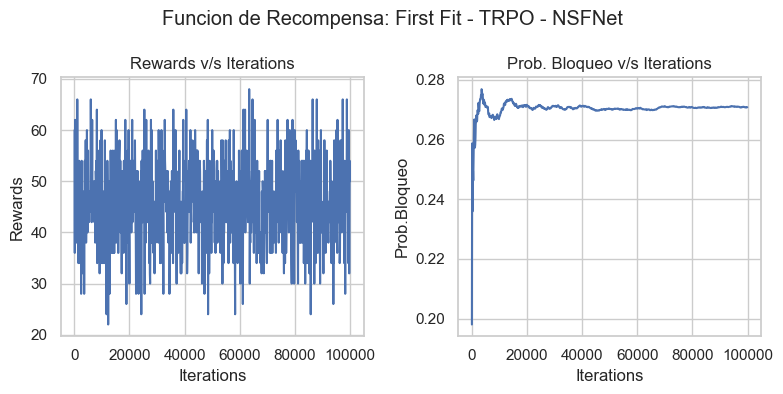

In [ ]:
graph_Rewards_Bloqueo(x, rewardsArrayFF_NSFNet_100ts, probBloqueoArrayFF_NSFNet_100ts, "First Fit", "TRPO", "NSFNet")

#### Rewards & Prob. Bloqueo EuroCore(100 Timesteps):

Rewards Stats w/  First Fit  :
Avg =  57.068
Std =  7.759598958709142
Min-Max Reward = 32 - 80
Last Prob Bloqueo = 0.21437222850622115


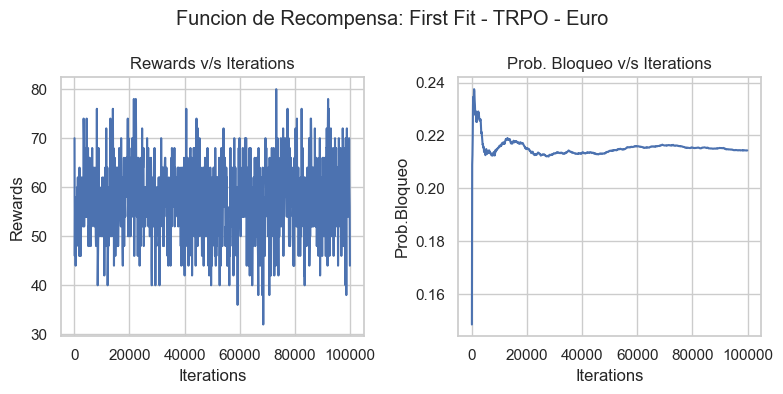

In [ ]:
graph_Rewards_Bloqueo(x, rewardsArrayFF_Euro_100ts, probBloqueoArrayFF_Euro_100ts, "First Fit", "TRPO", "Euro")